In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim


def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    print(corr)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [93]:
# 파일 읽기
data = pd.read_csv('[regression]Bike-sharing/day.csv')

In [94]:
# 데이터셋 앞부분 출력해보기
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [95]:
# y값 세팅
y = data['cnt'].values

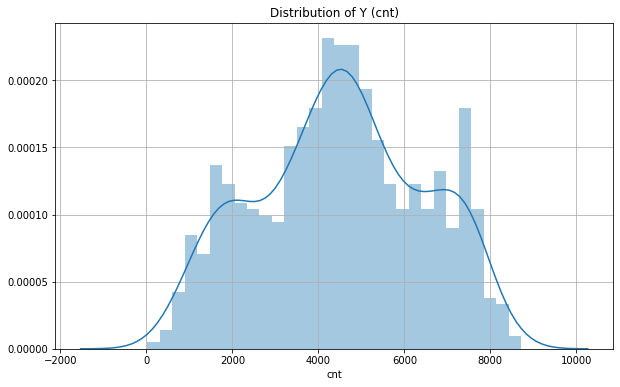

In [96]:
# y값 분포 그려보기
# Distribution of target (Y)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.distplot(data['cnt'], bins=30, ax=ax)
ax.set_title('Distribution of Y (cnt)')
plt.grid(True)
plt.show(fig)

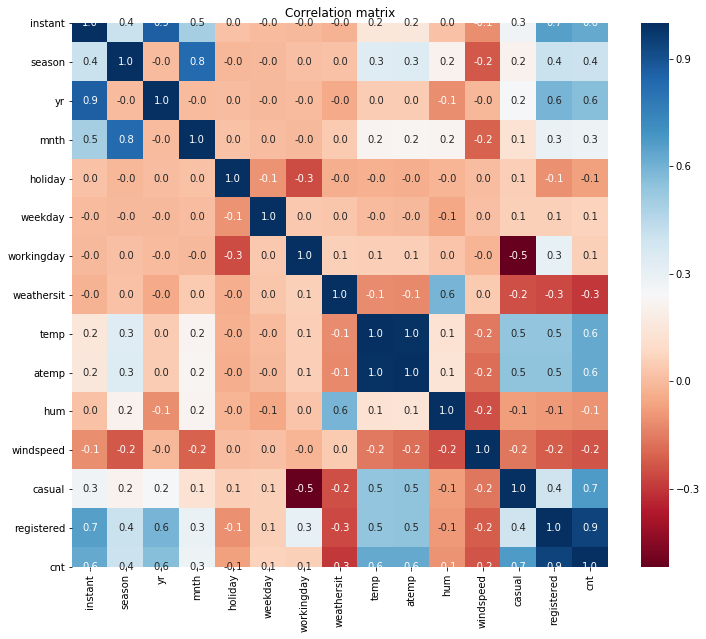

In [98]:
# 변수들의 상관관계 알아보기
corr_matrix = data.corr()

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(data=corr_matrix, cmap=plt.cm.RdBu, annot=True, fmt='.1f', ax=ax)
ax.set_title('Correlation matrix')
plt.show(fig)

In [99]:
# 카테고리형 컬럼 분류하기 season, mnth, weekday, weathersit
# casual과 registered는 빼야 하지 않을까?
# dteday는 빼버리자
# casual과 registered는 빼보자
data_numeric = data.drop(columns=['season','mnth','weekday', 'weathersit', 'dteday', 'casual', 'registered'], axis=1)
data_numeric.head()
data_numeric.columns

Index(['instant', 'yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'cnt'],
      dtype='object')

In [100]:
# 더미변수 만들기
data_category = data.loc[:, ['season', 'mnth', 'weekday', 'weathersit']]
data_dummy = pd.get_dummies(data_category, columns=['season', 'mnth', 'weekday', 'weathersit'], drop_first=True) # 더미에서 하나는 빼야된다
data_dummy.head()
data_dummy.columns

Index(['season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [101]:
# 두개 합치기
data_numeric = pd.concat([data_numeric, data_dummy], axis=1)
data_numeric.columns

Index(['instant', 'yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'cnt', 'season_2', 'season_3', 'season_4', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [102]:
# pandas dataframe -> numpy array
X = data_numeric.drop('cnt', axis=1).values
y = data_numeric['cnt'].values

# Change dtype
X = X.astype(np.float32)
y = y.astype(np.float32).reshape(-1, 1)

# numpy array -> torch float tensor
X = torch.from_numpy(X)
y = torch.from_numpy(y)

print(X.size(), X.dtype)
print(y.size(), y.dtype)

torch.Size([731, 30]) torch.float32
torch.Size([731, 1]) torch.float32


In [103]:
# Split into train & test sets
split_idx = 500
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

In [104]:
# Define model
class LinearRegressionModel(nn.Module):
    
    def __init__(self, in_features):
     
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(in_features, 1, bias=True)
        
    def forward(self, x):
        
        y_pred = self.linear(x)
        return y_pred

In [105]:
# Instantiate model
model = LinearRegressionModel(in_features=X.shape[1])

# Construct loss criterion & optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [107]:
# Train model

train_loss_list = []
test_loss_list = []

num_batch_updates = 1000000
for i in range(num_batch_updates):
    
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    
    train_loss = loss.item()
    test_loss = criterion(model(X_test), y_test).item()
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    if (i + 1) % 200 == 0:
        print(f'Iteration: {i + 1:>05d} | Training Loss: {train_loss:.3f} | Test loss: {test_loss:.3f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Iteration: 00200 | Training Loss: 3939320.000 | Test loss: 4298105.000
Iteration: 00400 | Training Loss: 3847427.250 | Test loss: 4223806.500
Iteration: 00600 | Training Loss: 3760657.250 | Test loss: 4169430.750
Iteration: 00800 | Training Loss: 3678938.000 | Test loss: 4134438.500


Iteration: 01000 | Training Loss: 3602188.500 | Test loss: 4118245.750
Iteration: 01200 | Training Loss: 3530325.000 | Test loss: 4120223.750
Iteration: 01400 | Training Loss: 3463257.250 | Test loss: 4139691.500
Iteration: 01600 | Training Loss: 3400889.750 | Test loss: 4175909.500


Iteration: 01800 | Training Loss: 3343115.750 | Test loss: 4228081.500
Iteration: 02000 | Training Loss: 3289823.750 | Test loss: 4295340.000
Iteration: 02200 | Training Loss: 3240893.250 | Test loss: 4376744.000
Iteration: 02400 | Training Loss: 3196193.250 | Test loss: 4471274.500


Iteration: 02600 | Training Loss: 3155580.750 | Test loss: 4577827.000
Iteration: 02800 | Training Loss: 3118904.750 | Test loss: 4695201.500
Iteration: 03000 | Training Loss: 3086001.500 | Test loss: 4822104.500
Iteration: 03200 | Training Loss: 3056695.750 | Test loss: 4957141.500


Iteration: 03400 | Training Loss: 3030798.750 | Test loss: 5098834.000
Iteration: 03600 | Training Loss: 3008114.500 | Test loss: 5245586.000
Iteration: 03800 | Training Loss: 2988432.250 | Test loss: 5395726.500
Iteration: 04000 | Training Loss: 2971532.000 | Test loss: 5547475.000


Iteration: 04200 | Training Loss: 2957180.500 | Test loss: 5698962.000
Iteration: 04400 | Training Loss: 2945136.250 | Test loss: 5848240.000
Iteration: 04600 | Training Loss: 2935146.750 | Test loss: 5993327.000
Iteration: 04800 | Training Loss: 2926956.250 | Test loss: 6132240.000


Iteration: 05000 | Training Loss: 2920305.750 | Test loss: 6263060.000
Iteration: 05200 | Training Loss: 2914941.000 | Test loss: 6384025.000
Iteration: 05400 | Training Loss: 2910619.000 | Test loss: 6493568.000
Iteration: 05600 | Training Loss: 2907112.750 | Test loss: 6590493.000


Iteration: 05800 | Training Loss: 2904218.250 | Test loss: 6673994.000
Iteration: 06000 | Training Loss: 2901760.250 | Test loss: 6743779.000
Iteration: 06200 | Training Loss: 2899596.000 | Test loss: 6800061.000
Iteration: 06400 | Training Loss: 2897614.750 | Test loss: 6843601.000


Iteration: 06600 | Training Loss: 2895737.250 | Test loss: 6875629.500
Iteration: 06800 | Training Loss: 2893910.750 | Test loss: 6897707.000
Iteration: 07000 | Training Loss: 2892103.250 | Test loss: 6911608.500
Iteration: 07200 | Training Loss: 2890297.000 | Test loss: 6919136.000


Iteration: 07400 | Training Loss: 2888485.500 | Test loss: 6921981.500
Iteration: 07600 | Training Loss: 2886664.250 | Test loss: 6921584.000
Iteration: 07800 | Training Loss: 2884834.750 | Test loss: 6919115.500
Iteration: 08000 | Training Loss: 2882997.750 | Test loss: 6915412.000


Iteration: 08200 | Training Loss: 2881153.750 | Test loss: 6911017.500
Iteration: 08400 | Training Loss: 2879304.250 | Test loss: 6906411.000
Iteration: 08600 | Training Loss: 2877451.000 | Test loss: 6901539.500
Iteration: 08800 | Training Loss: 2875594.000 | Test loss: 6896723.500


Iteration: 09000 | Training Loss: 2873734.250 | Test loss: 6891953.000
Iteration: 09200 | Training Loss: 2871873.000 | Test loss: 6887216.000
Iteration: 09400 | Training Loss: 2870010.000 | Test loss: 6882523.000
Iteration: 09600 | Training Loss: 2868146.000 | Test loss: 6877853.500


Iteration: 09800 | Training Loss: 2866281.500 | Test loss: 6873222.000
Iteration: 10000 | Training Loss: 2864416.500 | Test loss: 6868619.500
Iteration: 10200 | Training Loss: 2862551.500 | Test loss: 6864043.000
Iteration: 10400 | Training Loss: 2860686.500 | Test loss: 6859490.000


Iteration: 10600 | Training Loss: 2858821.750 | Test loss: 6854956.500
Iteration: 10800 | Training Loss: 2856957.500 | Test loss: 6850450.000
Iteration: 11000 | Training Loss: 2855093.000 | Test loss: 6845956.000
Iteration: 11200 | Training Loss: 2853229.750 | Test loss: 6841486.000


Iteration: 11400 | Training Loss: 2851367.250 | Test loss: 6837029.500
Iteration: 11600 | Training Loss: 2849505.500 | Test loss: 6832580.000
Iteration: 11800 | Training Loss: 2847644.750 | Test loss: 6828137.500
Iteration: 12000 | Training Loss: 2845784.500 | Test loss: 6823696.000


Iteration: 12200 | Training Loss: 2843925.500 | Test loss: 6819290.500
Iteration: 12400 | Training Loss: 2842067.250 | Test loss: 6814899.500
Iteration: 12600 | Training Loss: 2840210.000 | Test loss: 6810524.000
Iteration: 12800 | Training Loss: 2838353.250 | Test loss: 6806158.000


Iteration: 13000 | Training Loss: 2836497.750 | Test loss: 6801795.000
Iteration: 13200 | Training Loss: 2834643.000 | Test loss: 6797446.000
Iteration: 13400 | Training Loss: 2832789.500 | Test loss: 6793100.500
Iteration: 13600 | Training Loss: 2830937.000 | Test loss: 6788766.000


Iteration: 13800 | Training Loss: 2829085.000 | Test loss: 6784435.500
Iteration: 14000 | Training Loss: 2827234.250 | Test loss: 6780105.500
Iteration: 14200 | Training Loss: 2825384.250 | Test loss: 6775785.500
Iteration: 14400 | Training Loss: 2823535.250 | Test loss: 6771466.000


Iteration: 14600 | Training Loss: 2821687.250 | Test loss: 6767162.500
Iteration: 14800 | Training Loss: 2819840.500 | Test loss: 6762855.000
Iteration: 15000 | Training Loss: 2817995.000 | Test loss: 6758553.500
Iteration: 15200 | Training Loss: 2816149.500 | Test loss: 6754258.000


Iteration: 15400 | Training Loss: 2814305.750 | Test loss: 6749963.000
Iteration: 15600 | Training Loss: 2812462.750 | Test loss: 6745676.500
Iteration: 15800 | Training Loss: 2810621.000 | Test loss: 6741391.500
Iteration: 16000 | Training Loss: 2808780.500 | Test loss: 6737108.500


Iteration: 16200 | Training Loss: 2806940.250 | Test loss: 6732828.000
Iteration: 16400 | Training Loss: 2805101.250 | Test loss: 6728551.000
Iteration: 16600 | Training Loss: 2803263.500 | Test loss: 6724283.000
Iteration: 16800 | Training Loss: 2801426.750 | Test loss: 6720015.000


Iteration: 17000 | Training Loss: 2799591.000 | Test loss: 6715745.000
Iteration: 17200 | Training Loss: 2797755.750 | Test loss: 6711487.000
Iteration: 17400 | Training Loss: 2795922.000 | Test loss: 6707221.000
Iteration: 17600 | Training Loss: 2794089.000 | Test loss: 6702964.500


Iteration: 17800 | Training Loss: 2792257.250 | Test loss: 6698707.500
Iteration: 18000 | Training Loss: 2790426.750 | Test loss: 6694458.000
Iteration: 18200 | Training Loss: 2788596.750 | Test loss: 6690211.500
Iteration: 18400 | Training Loss: 2786768.000 | Test loss: 6685961.500


Iteration: 18600 | Training Loss: 2784940.500 | Test loss: 6681719.500
Iteration: 18800 | Training Loss: 2783114.000 | Test loss: 6677477.500
Iteration: 19000 | Training Loss: 2781288.750 | Test loss: 6673237.500
Iteration: 19200 | Training Loss: 2779464.000 | Test loss: 6669002.000


Iteration: 19400 | Training Loss: 2777640.250 | Test loss: 6664766.500
Iteration: 19600 | Training Loss: 2775817.750 | Test loss: 6660536.500
Iteration: 19800 | Training Loss: 2773996.250 | Test loss: 6656308.500
Iteration: 20000 | Training Loss: 2772176.000 | Test loss: 6652081.000


Iteration: 20200 | Training Loss: 2770356.250 | Test loss: 6647853.500
Iteration: 20400 | Training Loss: 2768537.500 | Test loss: 6643629.000
Iteration: 20600 | Training Loss: 2766719.750 | Test loss: 6639412.000
Iteration: 20800 | Training Loss: 2764903.250 | Test loss: 6635195.000


Iteration: 21000 | Training Loss: 2763087.750 | Test loss: 6630977.000
Iteration: 21200 | Training Loss: 2761273.250 | Test loss: 6626765.000
Iteration: 21400 | Training Loss: 2759460.000 | Test loss: 6622551.500
Iteration: 21600 | Training Loss: 2757647.000 | Test loss: 6618342.500


Iteration: 21800 | Training Loss: 2755835.750 | Test loss: 6614139.000
Iteration: 22000 | Training Loss: 2754025.000 | Test loss: 6609934.500
Iteration: 22200 | Training Loss: 2752215.750 | Test loss: 6605727.500
Iteration: 22400 | Training Loss: 2750407.250 | Test loss: 6601527.000


Iteration: 22600 | Training Loss: 2748599.500 | Test loss: 6597332.500
Iteration: 22800 | Training Loss: 2746792.750 | Test loss: 6593137.000
Iteration: 23000 | Training Loss: 2744987.000 | Test loss: 6588942.500
Iteration: 23200 | Training Loss: 2743182.250 | Test loss: 6584751.500


Iteration: 23400 | Training Loss: 2741378.250 | Test loss: 6580555.000
Iteration: 23600 | Training Loss: 2739574.750 | Test loss: 6576369.500
Iteration: 23800 | Training Loss: 2737772.250 | Test loss: 6572181.000
Iteration: 24000 | Training Loss: 2735970.750 | Test loss: 6567999.500


Iteration: 24200 | Training Loss: 2734170.500 | Test loss: 6563815.500
Iteration: 24400 | Training Loss: 2732371.750 | Test loss: 6559641.000
Iteration: 24600 | Training Loss: 2730573.500 | Test loss: 6555462.000
Iteration: 24800 | Training Loss: 2728776.500 | Test loss: 6551286.000


Iteration: 25000 | Training Loss: 2726980.750 | Test loss: 6547111.500
Iteration: 25200 | Training Loss: 2725185.750 | Test loss: 6542946.000
Iteration: 25400 | Training Loss: 2723392.250 | Test loss: 6538773.000
Iteration: 25600 | Training Loss: 2721598.750 | Test loss: 6534602.500


Iteration: 25800 | Training Loss: 2719807.000 | Test loss: 6530445.500
Iteration: 26000 | Training Loss: 2718016.250 | Test loss: 6526287.000
Iteration: 26200 | Training Loss: 2716226.250 | Test loss: 6522121.000
Iteration: 26400 | Training Loss: 2714437.500 | Test loss: 6518004.000


Iteration: 26600 | Training Loss: 2712649.250 | Test loss: 6513768.500
Iteration: 26800 | Training Loss: 2710862.000 | Test loss: 6509677.500
Iteration: 27000 | Training Loss: 2709076.500 | Test loss: 6505508.000
Iteration: 27200 | Training Loss: 2707291.500 | Test loss: 6501348.500


Iteration: 27400 | Training Loss: 2705507.750 | Test loss: 6497150.500
Iteration: 27600 | Training Loss: 2703724.750 | Test loss: 6493075.500
Iteration: 27800 | Training Loss: 2701942.750 | Test loss: 6488818.500
Iteration: 28000 | Training Loss: 2700161.750 | Test loss: 6484717.000


Iteration: 28200 | Training Loss: 2698381.750 | Test loss: 6480632.500
Iteration: 28400 | Training Loss: 2696603.000 | Test loss: 6476532.000
Iteration: 28600 | Training Loss: 2694825.250 | Test loss: 6472412.500
Iteration: 28800 | Training Loss: 2693048.000 | Test loss: 6468348.000


Iteration: 29000 | Training Loss: 2691272.250 | Test loss: 6464079.500
Iteration: 29200 | Training Loss: 2689497.250 | Test loss: 6460041.000
Iteration: 29400 | Training Loss: 2687723.500 | Test loss: 6455825.000
Iteration: 29600 | Training Loss: 2685950.750 | Test loss: 6451747.000


Iteration: 29800 | Training Loss: 2684178.500 | Test loss: 6447674.000
Iteration: 30000 | Training Loss: 2682407.500 | Test loss: 6443421.000
Iteration: 30200 | Training Loss: 2680637.500 | Test loss: 6439328.000
Iteration: 30400 | Training Loss: 2678868.750 | Test loss: 6435211.000


Iteration: 30600 | Training Loss: 2677101.000 | Test loss: 6431144.000
Iteration: 30800 | Training Loss: 2675334.250 | Test loss: 6427074.500
Iteration: 31000 | Training Loss: 2673567.750 | Test loss: 6422986.000
Iteration: 31200 | Training Loss: 2671803.000 | Test loss: 6418912.000


Iteration: 31400 | Training Loss: 2670039.250 | Test loss: 6414741.500
Iteration: 31600 | Training Loss: 2668276.250 | Test loss: 6410611.000
Iteration: 31800 | Training Loss: 2666514.500 | Test loss: 6406513.000
Iteration: 32000 | Training Loss: 2664753.250 | Test loss: 6402501.000


Iteration: 32200 | Training Loss: 2662993.250 | Test loss: 6398341.500
Iteration: 32400 | Training Loss: 2661234.750 | Test loss: 6394254.000
Iteration: 32600 | Training Loss: 2659477.250 | Test loss: 6390132.000


Iteration: 32800 | Training Loss: 2657721.000 | Test loss: 6386039.500
Iteration: 33000 | Training Loss: 2655965.000 | Test loss: 6381956.500
Iteration: 33200 | Training Loss: 2654210.500 | Test loss: 6377871.000
Iteration: 33400 | Training Loss: 2652457.250 | Test loss: 6373630.000


Iteration: 33600 | Training Loss: 2650704.750 | Test loss: 6369657.500
Iteration: 33800 | Training Loss: 2648953.500 | Test loss: 6365594.500
Iteration: 34000 | Training Loss: 2647203.000 | Test loss: 6361557.500
Iteration: 34200 | Training Loss: 2645453.500 | Test loss: 6357451.000


Iteration: 34400 | Training Loss: 2643705.250 | Test loss: 6353489.000
Iteration: 34600 | Training Loss: 2641957.750 | Test loss: 6349270.000
Iteration: 34800 | Training Loss: 2640211.500 | Test loss: 6345327.500
Iteration: 35000 | Training Loss: 2638466.250 | Test loss: 6341229.500


Iteration: 35200 | Training Loss: 2636721.750 | Test loss: 6337143.000
Iteration: 35400 | Training Loss: 2634978.250 | Test loss: 6333049.500
Iteration: 35600 | Training Loss: 2633236.000 | Test loss: 6328920.500
Iteration: 35800 | Training Loss: 2631494.750 | Test loss: 6325013.500


Iteration: 36000 | Training Loss: 2629754.500 | Test loss: 6320953.500
Iteration: 36200 | Training Loss: 2628014.750 | Test loss: 6316894.500
Iteration: 36400 | Training Loss: 2626276.250 | Test loss: 6312835.000
Iteration: 36600 | Training Loss: 2624539.000 | Test loss: 6308774.500


Iteration: 36800 | Training Loss: 2622802.750 | Test loss: 6304757.000
Iteration: 37000 | Training Loss: 2621067.250 | Test loss: 6300606.500
Iteration: 37200 | Training Loss: 2619333.000 | Test loss: 6296593.000
Iteration: 37400 | Training Loss: 2617599.250 | Test loss: 6292519.000


Iteration: 37600 | Training Loss: 2615866.750 | Test loss: 6288664.000
Iteration: 37800 | Training Loss: 2614135.500 | Test loss: 6284469.500
Iteration: 38000 | Training Loss: 2612404.750 | Test loss: 6280524.500
Iteration: 38200 | Training Loss: 2610675.750 | Test loss: 6276494.500


Iteration: 38400 | Training Loss: 2608947.000 | Test loss: 6272500.000
Iteration: 38600 | Training Loss: 2607219.500 | Test loss: 6268336.000
Iteration: 38800 | Training Loss: 2605493.250 | Test loss: 6264367.500
Iteration: 39000 | Training Loss: 2603767.500 | Test loss: 6260429.000


Iteration: 39200 | Training Loss: 2602043.500 | Test loss: 6256327.500
Iteration: 39400 | Training Loss: 2600319.500 | Test loss: 6252174.000
Iteration: 39600 | Training Loss: 2598597.000 | Test loss: 6248295.000
Iteration: 39800 | Training Loss: 2596876.000 | Test loss: 6244278.500


Iteration: 40000 | Training Loss: 2595155.250 | Test loss: 6240343.000
Iteration: 40200 | Training Loss: 2593436.000 | Test loss: 6236104.500
Iteration: 40400 | Training Loss: 2591717.500 | Test loss: 6232243.000


Iteration: 40600 | Training Loss: 2590000.000 | Test loss: 6228204.000
Iteration: 40800 | Training Loss: 2588283.500 | Test loss: 6224229.500
Iteration: 41000 | Training Loss: 2586568.000 | Test loss: 6220218.500


Iteration: 41200 | Training Loss: 2584853.500 | Test loss: 6216222.500
Iteration: 41400 | Training Loss: 2583140.250 | Test loss: 6212160.500
Iteration: 41600 | Training Loss: 2581427.500 | Test loss: 6208198.500
Iteration: 41800 | Training Loss: 2579716.250 | Test loss: 6204209.500


Iteration: 42000 | Training Loss: 2578005.500 | Test loss: 6200317.000
Iteration: 42200 | Training Loss: 2576296.250 | Test loss: 6196304.500
Iteration: 42400 | Training Loss: 2574587.750 | Test loss: 6192293.500
Iteration: 42600 | Training Loss: 2572880.000 | Test loss: 6188244.000


Iteration: 42800 | Training Loss: 2571173.500 | Test loss: 6184311.500
Iteration: 43000 | Training Loss: 2569468.250 | Test loss: 6180322.500
Iteration: 43200 | Training Loss: 2567763.750 | Test loss: 6176291.500
Iteration: 43400 | Training Loss: 2566060.500 | Test loss: 6172207.500


Iteration: 43600 | Training Loss: 2564358.000 | Test loss: 6168427.000
Iteration: 43800 | Training Loss: 2562656.250 | Test loss: 6164373.000
Iteration: 44000 | Training Loss: 2560956.250 | Test loss: 6160349.500
Iteration: 44200 | Training Loss: 2559256.750 | Test loss: 6156500.500


Iteration: 44400 | Training Loss: 2557558.500 | Test loss: 6152525.500
Iteration: 44600 | Training Loss: 2555861.500 | Test loss: 6148598.500
Iteration: 44800 | Training Loss: 2554164.750 | Test loss: 6144566.000


Iteration: 45000 | Training Loss: 2552469.250 | Test loss: 6140600.500
Iteration: 45200 | Training Loss: 2550775.250 | Test loss: 6136647.500
Iteration: 45400 | Training Loss: 2549081.750 | Test loss: 6132687.000


Iteration: 45600 | Training Loss: 2547389.500 | Test loss: 6128756.500
Iteration: 45800 | Training Loss: 2545698.000 | Test loss: 6124802.000
Iteration: 46000 | Training Loss: 2544007.500 | Test loss: 6120908.500
Iteration: 46200 | Training Loss: 2542318.500 | Test loss: 6116941.500


Iteration: 46400 | Training Loss: 2540630.000 | Test loss: 6113042.500
Iteration: 46600 | Training Loss: 2538942.750 | Test loss: 6109000.500
Iteration: 46800 | Training Loss: 2537256.500 | Test loss: 6105050.000


Iteration: 47000 | Training Loss: 2535570.500 | Test loss: 6101071.000
Iteration: 47200 | Training Loss: 2533886.500 | Test loss: 6097200.500
Iteration: 47400 | Training Loss: 2532203.250 | Test loss: 6093260.000
Iteration: 47600 | Training Loss: 2530520.750 | Test loss: 6089409.500


Iteration: 47800 | Training Loss: 2528839.500 | Test loss: 6085522.500
Iteration: 48000 | Training Loss: 2527158.750 | Test loss: 6081472.000
Iteration: 48200 | Training Loss: 2525479.500 | Test loss: 6077542.500
Iteration: 48400 | Training Loss: 2523801.250 | Test loss: 6073603.000


Iteration: 48600 | Training Loss: 2522123.750 | Test loss: 6069721.500
Iteration: 48800 | Training Loss: 2520447.500 | Test loss: 6065821.000
Iteration: 49000 | Training Loss: 2518771.750 | Test loss: 6061818.000
Iteration: 49200 | Training Loss: 2517097.250 | Test loss: 6057978.000


Iteration: 49400 | Training Loss: 2515424.250 | Test loss: 6054125.000
Iteration: 49600 | Training Loss: 2513752.000 | Test loss: 6050252.500
Iteration: 49800 | Training Loss: 2512080.500 | Test loss: 6046269.000
Iteration: 50000 | Training Loss: 2510410.250 | Test loss: 6042196.000


Iteration: 50200 | Training Loss: 2508740.500 | Test loss: 6038394.500
Iteration: 50400 | Training Loss: 2507072.250 | Test loss: 6034595.000
Iteration: 50600 | Training Loss: 2505404.750 | Test loss: 6030519.000
Iteration: 50800 | Training Loss: 2503738.500 | Test loss: 6026714.000


Iteration: 51000 | Training Loss: 2502073.250 | Test loss: 6022833.000
Iteration: 51200 | Training Loss: 2500408.500 | Test loss: 6018911.500
Iteration: 51400 | Training Loss: 2498745.000 | Test loss: 6015056.000
Iteration: 51600 | Training Loss: 2497082.750 | Test loss: 6011204.000


Iteration: 51800 | Training Loss: 2495421.500 | Test loss: 6007251.500
Iteration: 52000 | Training Loss: 2493761.250 | Test loss: 6003331.500
Iteration: 52200 | Training Loss: 2492101.250 | Test loss: 5999473.500
Iteration: 52400 | Training Loss: 2490442.750 | Test loss: 5995583.000


Iteration: 52600 | Training Loss: 2488785.750 | Test loss: 5991731.500
Iteration: 52800 | Training Loss: 2487129.500 | Test loss: 5987903.000
Iteration: 53000 | Training Loss: 2485474.000 | Test loss: 5983976.000
Iteration: 53200 | Training Loss: 2483819.750 | Test loss: 5980098.500


Iteration: 53400 | Training Loss: 2482165.750 | Test loss: 5976249.000
Iteration: 53600 | Training Loss: 2480513.750 | Test loss: 5972363.000
Iteration: 53800 | Training Loss: 2478862.250 | Test loss: 5968459.000


Iteration: 54000 | Training Loss: 2477211.750 | Test loss: 5964655.500
Iteration: 54200 | Training Loss: 2475562.500 | Test loss: 5960763.500
Iteration: 54400 | Training Loss: 2473913.750 | Test loss: 5956878.500
Iteration: 54600 | Training Loss: 2472266.500 | Test loss: 5953062.000


Iteration: 54800 | Training Loss: 2470620.000 | Test loss: 5949152.500
Iteration: 55000 | Training Loss: 2468974.500 | Test loss: 5945323.000
Iteration: 55200 | Training Loss: 2467330.250 | Test loss: 5941470.500
Iteration: 55400 | Training Loss: 2465686.250 | Test loss: 5937656.500


Iteration: 55600 | Training Loss: 2464043.250 | Test loss: 5933765.000
Iteration: 55800 | Training Loss: 2462401.500 | Test loss: 5929937.000
Iteration: 56000 | Training Loss: 2460760.000 | Test loss: 5926119.000
Iteration: 56200 | Training Loss: 2459118.750 | Test loss: 5922260.500


Iteration: 56400 | Training Loss: 2457478.250 | Test loss: 5918421.500
Iteration: 56600 | Training Loss: 2455837.750 | Test loss: 5914606.000
Iteration: 56800 | Training Loss: 2454198.500 | Test loss: 5910662.000
Iteration: 57000 | Training Loss: 2452560.250 | Test loss: 5906868.000


Iteration: 57200 | Training Loss: 2450923.000 | Test loss: 5903109.500
Iteration: 57400 | Training Loss: 2449286.500 | Test loss: 5899197.000
Iteration: 57600 | Training Loss: 2447651.500 | Test loss: 5895392.000
Iteration: 57800 | Training Loss: 2446017.250 | Test loss: 5891541.500


Iteration: 58000 | Training Loss: 2444384.250 | Test loss: 5887714.000
Iteration: 58200 | Training Loss: 2442752.000 | Test loss: 5883872.500
Iteration: 58400 | Training Loss: 2441120.500 | Test loss: 5880039.500
Iteration: 58600 | Training Loss: 2439490.500 | Test loss: 5876246.500


Iteration: 58800 | Training Loss: 2437861.250 | Test loss: 5872406.500
Iteration: 59000 | Training Loss: 2436233.000 | Test loss: 5868554.000
Iteration: 59200 | Training Loss: 2434606.000 | Test loss: 5864804.500
Iteration: 59400 | Training Loss: 2432979.750 | Test loss: 5860990.500


Iteration: 59600 | Training Loss: 2431354.750 | Test loss: 5857148.000
Iteration: 59800 | Training Loss: 2429730.250 | Test loss: 5853352.500
Iteration: 60000 | Training Loss: 2428107.000 | Test loss: 5849540.500
Iteration: 60200 | Training Loss: 2426485.250 | Test loss: 5845693.000


Iteration: 60400 | Training Loss: 2424864.000 | Test loss: 5841904.000
Iteration: 60600 | Training Loss: 2423243.500 | Test loss: 5838161.000
Iteration: 60800 | Training Loss: 2421624.500 | Test loss: 5834352.000
Iteration: 61000 | Training Loss: 2420006.250 | Test loss: 5830519.000


Iteration: 61200 | Training Loss: 2418389.250 | Test loss: 5826722.000
Iteration: 61400 | Training Loss: 2416773.000 | Test loss: 5822897.500
Iteration: 61600 | Training Loss: 2415157.500 | Test loss: 5819027.000


Iteration: 61800 | Training Loss: 2413543.750 | Test loss: 5815256.000
Iteration: 62000 | Training Loss: 2411930.500 | Test loss: 5811605.000
Iteration: 62200 | Training Loss: 2410318.250 | Test loss: 5807813.500
Iteration: 62400 | Training Loss: 2408707.250 | Test loss: 5804039.500


Iteration: 62600 | Training Loss: 2407097.000 | Test loss: 5800065.500
Iteration: 62800 | Training Loss: 2405488.000 | Test loss: 5796441.000
Iteration: 63000 | Training Loss: 2403879.500 | Test loss: 5792665.000
Iteration: 63200 | Training Loss: 2402272.500 | Test loss: 5788985.500


Iteration: 63400 | Training Loss: 2400666.500 | Test loss: 5785236.000
Iteration: 63600 | Training Loss: 2399061.250 | Test loss: 5781326.500
Iteration: 63800 | Training Loss: 2397457.000 | Test loss: 5777576.000
Iteration: 64000 | Training Loss: 2395854.000 | Test loss: 5773904.500


Iteration: 64200 | Training Loss: 2394251.750 | Test loss: 5770215.500
Iteration: 64400 | Training Loss: 2392650.750 | Test loss: 5766309.000
Iteration: 64600 | Training Loss: 2391050.500 | Test loss: 5762508.500


Iteration: 64800 | Training Loss: 2389451.250 | Test loss: 5758752.000
Iteration: 65000 | Training Loss: 2387853.250 | Test loss: 5754984.000
Iteration: 65200 | Training Loss: 2386256.000 | Test loss: 5751271.500
Iteration: 65400 | Training Loss: 2384659.750 | Test loss: 5747500.500


Iteration: 65600 | Training Loss: 2383064.750 | Test loss: 5743789.000
Iteration: 65800 | Training Loss: 2381470.500 | Test loss: 5740056.500
Iteration: 66000 | Training Loss: 2379877.750 | Test loss: 5736278.000
Iteration: 66200 | Training Loss: 2378285.500 | Test loss: 5732494.000


Iteration: 66400 | Training Loss: 2376694.500 | Test loss: 5728807.000
Iteration: 66600 | Training Loss: 2375104.750 | Test loss: 5725180.000
Iteration: 66800 | Training Loss: 2373515.750 | Test loss: 5721341.500
Iteration: 67000 | Training Loss: 2371927.500 | Test loss: 5717653.000


Iteration: 67200 | Training Loss: 2370340.750 | Test loss: 5713885.000
Iteration: 67400 | Training Loss: 2368754.750 | Test loss: 5710156.000
Iteration: 67600 | Training Loss: 2367170.000 | Test loss: 5706429.500
Iteration: 67800 | Training Loss: 2365586.000 | Test loss: 5702698.500


Iteration: 68000 | Training Loss: 2364002.750 | Test loss: 5698915.000
Iteration: 68200 | Training Loss: 2362421.000 | Test loss: 5695241.000
Iteration: 68400 | Training Loss: 2360840.000 | Test loss: 5691486.500
Iteration: 68600 | Training Loss: 2359260.000 | Test loss: 5687849.500


Iteration: 68800 | Training Loss: 2357681.250 | Test loss: 5684089.500
Iteration: 69000 | Training Loss: 2356103.250 | Test loss: 5680344.000
Iteration: 69200 | Training Loss: 2354526.500 | Test loss: 5676647.500
Iteration: 69400 | Training Loss: 2352950.250 | Test loss: 5672966.500


Iteration: 69600 | Training Loss: 2351375.500 | Test loss: 5669258.000
Iteration: 69800 | Training Loss: 2349801.750 | Test loss: 5665426.500
Iteration: 70000 | Training Loss: 2348228.500 | Test loss: 5661882.000
Iteration: 70200 | Training Loss: 2346656.500 | Test loss: 5658271.500


Iteration: 70400 | Training Loss: 2345085.750 | Test loss: 5654496.500
Iteration: 70600 | Training Loss: 2343515.750 | Test loss: 5650725.000
Iteration: 70800 | Training Loss: 2341947.000 | Test loss: 5647133.500
Iteration: 71000 | Training Loss: 2340379.000 | Test loss: 5643313.500


Iteration: 71200 | Training Loss: 2338811.750 | Test loss: 5639657.500
Iteration: 71400 | Training Loss: 2337246.000 | Test loss: 5635962.000
Iteration: 71600 | Training Loss: 2335681.000 | Test loss: 5632370.000
Iteration: 71800 | Training Loss: 2334117.000 | Test loss: 5628642.500


Iteration: 72000 | Training Loss: 2332554.500 | Test loss: 5624967.500
Iteration: 72200 | Training Loss: 2330992.500 | Test loss: 5621270.500
Iteration: 72400 | Training Loss: 2329431.750 | Test loss: 5617599.500
Iteration: 72600 | Training Loss: 2327871.500 | Test loss: 5613920.000


Iteration: 72800 | Training Loss: 2326312.500 | Test loss: 5610276.500
Iteration: 73000 | Training Loss: 2324755.000 | Test loss: 5606613.500
Iteration: 73200 | Training Loss: 2323198.000 | Test loss: 5602882.500
Iteration: 73400 | Training Loss: 2321641.750 | Test loss: 5599188.500


Iteration: 73600 | Training Loss: 2320087.000 | Test loss: 5595607.500
Iteration: 73800 | Training Loss: 2318533.000 | Test loss: 5592025.500
Iteration: 74000 | Training Loss: 2316980.500 | Test loss: 5588319.000
Iteration: 74200 | Training Loss: 2315428.500 | Test loss: 5584516.500


Iteration: 74400 | Training Loss: 2313877.250 | Test loss: 5580940.000
Iteration: 74600 | Training Loss: 2312327.750 | Test loss: 5577182.000
Iteration: 74800 | Training Loss: 2310778.750 | Test loss: 5573693.000


Iteration: 75000 | Training Loss: 2309230.750 | Test loss: 5570001.000
Iteration: 75200 | Training Loss: 2307684.000 | Test loss: 5566406.000
Iteration: 75400 | Training Loss: 2306138.000 | Test loss: 5562692.500
Iteration: 75600 | Training Loss: 2304593.250 | Test loss: 5559102.500


Iteration: 75800 | Training Loss: 2303049.000 | Test loss: 5555417.000
Iteration: 76000 | Training Loss: 2301505.750 | Test loss: 5551802.000
Iteration: 76200 | Training Loss: 2299964.000 | Test loss: 5548235.000
Iteration: 76400 | Training Loss: 2298422.750 | Test loss: 5544547.500


Iteration: 76600 | Training Loss: 2296882.250 | Test loss: 5540934.000
Iteration: 76800 | Training Loss: 2295343.500 | Test loss: 5537308.000
Iteration: 77000 | Training Loss: 2293805.250 | Test loss: 5533629.500


Iteration: 77200 | Training Loss: 2292268.250 | Test loss: 5529949.500
Iteration: 77400 | Training Loss: 2290732.250 | Test loss: 5526402.000
Iteration: 77600 | Training Loss: 2289196.750 | Test loss: 5522776.000
Iteration: 77800 | Training Loss: 2287663.000 | Test loss: 5519061.500


Iteration: 78000 | Training Loss: 2286130.000 | Test loss: 5515555.000
Iteration: 78200 | Training Loss: 2284597.500 | Test loss: 5511874.000
Iteration: 78400 | Training Loss: 2283066.750 | Test loss: 5508330.000
Iteration: 78600 | Training Loss: 2281536.500 | Test loss: 5504774.500


Iteration: 78800 | Training Loss: 2280007.500 | Test loss: 5501273.000
Iteration: 79000 | Training Loss: 2278479.500 | Test loss: 5497499.000
Iteration: 79200 | Training Loss: 2276952.000 | Test loss: 5493892.500
Iteration: 79400 | Training Loss: 2275426.250 | Test loss: 5490213.500


Iteration: 79600 | Training Loss: 2273901.250 | Test loss: 5486697.000
Iteration: 79800 | Training Loss: 2272376.750 | Test loss: 5483086.000
Iteration: 80000 | Training Loss: 2270854.000 | Test loss: 5479520.000
Iteration: 80200 | Training Loss: 2269332.000 | Test loss: 5475904.500


Iteration: 80400 | Training Loss: 2267811.000 | Test loss: 5472342.500
Iteration: 80600 | Training Loss: 2266291.000 | Test loss: 5468624.500
Iteration: 80800 | Training Loss: 2264771.750 | Test loss: 5465052.000
Iteration: 81000 | Training Loss: 2263254.500 | Test loss: 5461570.000


Iteration: 81200 | Training Loss: 2261738.500 | Test loss: 5458004.000
Iteration: 81400 | Training Loss: 2260223.000 | Test loss: 5454408.000
Iteration: 81600 | Training Loss: 2258709.250 | Test loss: 5450869.500
Iteration: 81800 | Training Loss: 2257196.250 | Test loss: 5447193.500


Iteration: 82000 | Training Loss: 2255684.500 | Test loss: 5443532.000
Iteration: 82200 | Training Loss: 2254173.250 | Test loss: 5440098.000
Iteration: 82400 | Training Loss: 2252663.250 | Test loss: 5436552.500


Iteration: 82600 | Training Loss: 2251154.500 | Test loss: 5433077.500
Iteration: 82800 | Training Loss: 2249646.500 | Test loss: 5429425.500
Iteration: 83000 | Training Loss: 2248139.250 | Test loss: 5425896.000


Iteration: 83200 | Training Loss: 2246633.500 | Test loss: 5422332.000
Iteration: 83400 | Training Loss: 2245128.500 | Test loss: 5418828.500
Iteration: 83600 | Training Loss: 2243624.750 | Test loss: 5415184.500
Iteration: 83800 | Training Loss: 2242121.750 | Test loss: 5411662.500


Iteration: 84000 | Training Loss: 2240619.750 | Test loss: 5408105.500
Iteration: 84200 | Training Loss: 2239119.000 | Test loss: 5404652.000
Iteration: 84400 | Training Loss: 2237619.000 | Test loss: 5401018.000
Iteration: 84600 | Training Loss: 2236119.750 | Test loss: 5397493.500


Iteration: 84800 | Training Loss: 2234622.000 | Test loss: 5393906.000
Iteration: 85000 | Training Loss: 2233125.000 | Test loss: 5390369.000
Iteration: 85200 | Training Loss: 2231629.250 | Test loss: 5386857.000
Iteration: 85400 | Training Loss: 2230134.000 | Test loss: 5383245.000


Iteration: 85600 | Training Loss: 2228640.000 | Test loss: 5379779.000
Iteration: 85800 | Training Loss: 2227147.250 | Test loss: 5376225.500
Iteration: 86000 | Training Loss: 2225655.250 | Test loss: 5372696.500


Iteration: 86200 | Training Loss: 2224164.000 | Test loss: 5369227.500
Iteration: 86400 | Training Loss: 2222674.250 | Test loss: 5365689.500
Iteration: 86600 | Training Loss: 2221185.250 | Test loss: 5362137.500
Iteration: 86800 | Training Loss: 2219697.500 | Test loss: 5358639.500


Iteration: 87000 | Training Loss: 2218210.250 | Test loss: 5355114.000
Iteration: 87200 | Training Loss: 2216724.250 | Test loss: 5351625.000
Iteration: 87400 | Training Loss: 2215239.500 | Test loss: 5348098.000
Iteration: 87600 | Training Loss: 2213755.500 | Test loss: 5344555.000


Iteration: 87800 | Training Loss: 2212272.250 | Test loss: 5341005.000
Iteration: 88000 | Training Loss: 2210790.500 | Test loss: 5337625.500
Iteration: 88200 | Training Loss: 2209309.500 | Test loss: 5334053.000
Iteration: 88400 | Training Loss: 2207829.750 | Test loss: 5330603.000


Iteration: 88600 | Training Loss: 2206350.500 | Test loss: 5327124.000
Iteration: 88800 | Training Loss: 2204872.500 | Test loss: 5323508.500
Iteration: 89000 | Training Loss: 2203395.500 | Test loss: 5320087.000
Iteration: 89200 | Training Loss: 2201919.750 | Test loss: 5316595.500


Iteration: 89400 | Training Loss: 2200444.500 | Test loss: 5313084.500
Iteration: 89600 | Training Loss: 2198970.750 | Test loss: 5309580.500
Iteration: 89800 | Training Loss: 2197497.750 | Test loss: 5306151.500
Iteration: 90000 | Training Loss: 2196025.750 | Test loss: 5302639.000


Iteration: 90200 | Training Loss: 2194554.750 | Test loss: 5299149.000
Iteration: 90400 | Training Loss: 2193084.500 | Test loss: 5295649.000
Iteration: 90600 | Training Loss: 2191615.750 | Test loss: 5292193.000
Iteration: 90800 | Training Loss: 2190148.000 | Test loss: 5288671.500


Iteration: 91000 | Training Loss: 2188680.500 | Test loss: 5285180.500
Iteration: 91200 | Training Loss: 2187214.750 | Test loss: 5281780.500
Iteration: 91400 | Training Loss: 2185749.750 | Test loss: 5278328.000
Iteration: 91600 | Training Loss: 2184286.000 | Test loss: 5274852.000


Iteration: 91800 | Training Loss: 2182822.750 | Test loss: 5271418.000
Iteration: 92000 | Training Loss: 2181360.750 | Test loss: 5267837.500
Iteration: 92200 | Training Loss: 2179899.750 | Test loss: 5264429.000
Iteration: 92400 | Training Loss: 2178440.000 | Test loss: 5261003.500


Iteration: 92600 | Training Loss: 2176980.500 | Test loss: 5257520.000
Iteration: 92800 | Training Loss: 2175523.000 | Test loss: 5254066.000
Iteration: 93000 | Training Loss: 2174065.750 | Test loss: 5250616.000


Iteration: 93200 | Training Loss: 2172610.000 | Test loss: 5247302.500
Iteration: 93400 | Training Loss: 2171154.750 | Test loss: 5243646.500
Iteration: 93600 | Training Loss: 2169700.750 | Test loss: 5240247.500
Iteration: 93800 | Training Loss: 2168248.000 | Test loss: 5236775.000


Iteration: 94000 | Training Loss: 2166796.000 | Test loss: 5233413.500
Iteration: 94200 | Training Loss: 2165344.500 | Test loss: 5229976.500
Iteration: 94400 | Training Loss: 2163894.750 | Test loss: 5226514.500
Iteration: 94600 | Training Loss: 2162445.750 | Test loss: 5223039.000


Iteration: 94800 | Training Loss: 2160998.000 | Test loss: 5219625.000
Iteration: 95000 | Training Loss: 2159550.750 | Test loss: 5216235.000
Iteration: 95200 | Training Loss: 2158104.750 | Test loss: 5212794.500
Iteration: 95400 | Training Loss: 2156659.750 | Test loss: 5209338.500


Iteration: 95600 | Training Loss: 2155216.000 | Test loss: 5205883.500
Iteration: 95800 | Training Loss: 2153772.750 | Test loss: 5202486.000
Iteration: 96000 | Training Loss: 2152331.250 | Test loss: 5199048.500
Iteration: 96200 | Training Loss: 2150890.500 | Test loss: 5195637.000


Iteration: 96400 | Training Loss: 2149451.000 | Test loss: 5192258.000
Iteration: 96600 | Training Loss: 2148012.000 | Test loss: 5188742.000
Iteration: 96800 | Training Loss: 2146574.250 | Test loss: 5185366.500
Iteration: 97000 | Training Loss: 2145137.750 | Test loss: 5181908.000


Iteration: 97200 | Training Loss: 2143702.000 | Test loss: 5178543.500
Iteration: 97400 | Training Loss: 2142267.000 | Test loss: 5175165.000
Iteration: 97600 | Training Loss: 2140833.500 | Test loss: 5171816.500
Iteration: 97800 | Training Loss: 2139400.750 | Test loss: 5168359.500


Iteration: 98000 | Training Loss: 2137969.250 | Test loss: 5165018.500
Iteration: 98200 | Training Loss: 2136538.500 | Test loss: 5161516.500
Iteration: 98400 | Training Loss: 2135108.750 | Test loss: 5158113.500
Iteration: 98600 | Training Loss: 2133680.500 | Test loss: 5154760.500


Iteration: 98800 | Training Loss: 2132253.000 | Test loss: 5151386.500
Iteration: 99000 | Training Loss: 2130826.000 | Test loss: 5147943.000
Iteration: 99200 | Training Loss: 2129400.750 | Test loss: 5144577.500
Iteration: 99400 | Training Loss: 2127976.000 | Test loss: 5141224.500


Iteration: 99600 | Training Loss: 2126552.750 | Test loss: 5137825.000
Iteration: 99800 | Training Loss: 2125130.000 | Test loss: 5134522.500
Iteration: 100000 | Training Loss: 2123708.250 | Test loss: 5131052.000
Iteration: 100200 | Training Loss: 2122288.000 | Test loss: 5127651.500


Iteration: 100400 | Training Loss: 2120868.500 | Test loss: 5124339.500
Iteration: 100600 | Training Loss: 2119449.500 | Test loss: 5120962.000
Iteration: 100800 | Training Loss: 2118032.250 | Test loss: 5117588.500


Iteration: 101000 | Training Loss: 2116615.500 | Test loss: 5114187.500
Iteration: 101200 | Training Loss: 2115200.000 | Test loss: 5110838.000
Iteration: 101400 | Training Loss: 2113785.250 | Test loss: 5107474.000
Iteration: 101600 | Training Loss: 2112371.750 | Test loss: 5104180.500


Iteration: 101800 | Training Loss: 2110959.250 | Test loss: 5100646.500
Iteration: 102000 | Training Loss: 2109547.750 | Test loss: 5097427.000
Iteration: 102200 | Training Loss: 2108136.750 | Test loss: 5093943.500
Iteration: 102400 | Training Loss: 2106727.250 | Test loss: 5090688.500


Iteration: 102600 | Training Loss: 2105318.750 | Test loss: 5087341.500
Iteration: 102800 | Training Loss: 2103911.250 | Test loss: 5084029.000
Iteration: 103000 | Training Loss: 2102504.500 | Test loss: 5080635.000
Iteration: 103200 | Training Loss: 2101098.750 | Test loss: 5077322.000


Iteration: 103400 | Training Loss: 2099694.250 | Test loss: 5073953.000
Iteration: 103600 | Training Loss: 2098290.750 | Test loss: 5070588.000
Iteration: 103800 | Training Loss: 2096887.750 | Test loss: 5067287.500
Iteration: 104000 | Training Loss: 2095486.375 | Test loss: 5063902.000


Iteration: 104200 | Training Loss: 2094085.750 | Test loss: 5060687.000
Iteration: 104400 | Training Loss: 2092686.375 | Test loss: 5057355.000
Iteration: 104600 | Training Loss: 2091287.500 | Test loss: 5053944.500
Iteration: 104800 | Training Loss: 2089890.000 | Test loss: 5050627.500


Iteration: 105000 | Training Loss: 2088493.500 | Test loss: 5047307.000
Iteration: 105200 | Training Loss: 2087098.000 | Test loss: 5043989.000
Iteration: 105400 | Training Loss: 2085703.125 | Test loss: 5040691.500
Iteration: 105600 | Training Loss: 2084309.750 | Test loss: 5037311.500


Iteration: 105800 | Training Loss: 2082917.125 | Test loss: 5034006.500
Iteration: 106000 | Training Loss: 2081525.625 | Test loss: 5030734.500
Iteration: 106200 | Training Loss: 2080134.875 | Test loss: 5027341.000
Iteration: 106400 | Training Loss: 2078745.250 | Test loss: 5023994.000


Iteration: 106600 | Training Loss: 2077356.750 | Test loss: 5020766.500
Iteration: 106800 | Training Loss: 2075969.250 | Test loss: 5017457.000
Iteration: 107000 | Training Loss: 2074582.375 | Test loss: 5014133.500
Iteration: 107200 | Training Loss: 2073196.875 | Test loss: 5010936.000


Iteration: 107400 | Training Loss: 2071812.250 | Test loss: 5007614.000
Iteration: 107600 | Training Loss: 2070428.875 | Test loss: 5004322.000
Iteration: 107800 | Training Loss: 2069046.125 | Test loss: 5001027.500
Iteration: 108000 | Training Loss: 2067664.500 | Test loss: 4997687.500


Iteration: 108200 | Training Loss: 2066284.125 | Test loss: 4994399.000
Iteration: 108400 | Training Loss: 2064904.750 | Test loss: 4991019.000
Iteration: 108600 | Training Loss: 2063525.875 | Test loss: 4987846.500
Iteration: 108800 | Training Loss: 2062148.625 | Test loss: 4984586.500


Iteration: 109000 | Training Loss: 2060772.000 | Test loss: 4981291.500
Iteration: 109200 | Training Loss: 2059396.625 | Test loss: 4977988.500
Iteration: 109400 | Training Loss: 2058022.000 | Test loss: 4974678.500
Iteration: 109600 | Training Loss: 2056648.875 | Test loss: 4971418.000


Iteration: 109800 | Training Loss: 2055277.125 | Test loss: 4968144.000
Iteration: 110000 | Training Loss: 2053906.500 | Test loss: 4964843.000
Iteration: 110200 | Training Loss: 2052536.375 | Test loss: 4961532.500
Iteration: 110400 | Training Loss: 2051167.750 | Test loss: 4958308.500


Iteration: 110600 | Training Loss: 2049799.875 | Test loss: 4955131.000
Iteration: 110800 | Training Loss: 2048433.250 | Test loss: 4951844.000
Iteration: 111000 | Training Loss: 2047067.125 | Test loss: 4948523.000
Iteration: 111200 | Training Loss: 2045702.250 | Test loss: 4945294.500


Iteration: 111400 | Training Loss: 2044338.625 | Test loss: 4942037.000
Iteration: 111600 | Training Loss: 2042975.750 | Test loss: 4938812.000
Iteration: 111800 | Training Loss: 2041613.625 | Test loss: 4935536.000
Iteration: 112000 | Training Loss: 2040253.000 | Test loss: 4932284.000


Iteration: 112200 | Training Loss: 2038893.000 | Test loss: 4929067.000
Iteration: 112400 | Training Loss: 2037534.250 | Test loss: 4925798.500
Iteration: 112600 | Training Loss: 2036176.250 | Test loss: 4922554.500


Iteration: 112800 | Training Loss: 2034819.250 | Test loss: 4919323.000
Iteration: 113000 | Training Loss: 2033463.500 | Test loss: 4916065.500
Iteration: 113200 | Training Loss: 2032108.750 | Test loss: 4912867.000
Iteration: 113400 | Training Loss: 2030754.625 | Test loss: 4909606.500


Iteration: 113600 | Training Loss: 2029401.875 | Test loss: 4906459.500
Iteration: 113800 | Training Loss: 2028050.000 | Test loss: 4903133.000
Iteration: 114000 | Training Loss: 2026699.250 | Test loss: 4899915.000
Iteration: 114200 | Training Loss: 2025349.250 | Test loss: 4896687.000


Iteration: 114400 | Training Loss: 2024000.250 | Test loss: 4893542.000
Iteration: 114600 | Training Loss: 2022652.375 | Test loss: 4890225.000
Iteration: 114800 | Training Loss: 2021305.500 | Test loss: 4886967.500
Iteration: 115000 | Training Loss: 2019959.375 | Test loss: 4883852.000


Iteration: 115200 | Training Loss: 2018614.625 | Test loss: 4880586.500
Iteration: 115400 | Training Loss: 2017270.625 | Test loss: 4877295.500
Iteration: 115600 | Training Loss: 2015927.875 | Test loss: 4874187.500
Iteration: 115800 | Training Loss: 2014585.875 | Test loss: 4870974.500


Iteration: 116000 | Training Loss: 2013244.750 | Test loss: 4867709.500
Iteration: 116200 | Training Loss: 2011905.000 | Test loss: 4864550.500
Iteration: 116400 | Training Loss: 2010566.125 | Test loss: 4861335.500
Iteration: 116600 | Training Loss: 2009228.000 | Test loss: 4858153.000


Iteration: 116800 | Training Loss: 2007891.375 | Test loss: 4854939.500
Iteration: 117000 | Training Loss: 2006555.625 | Test loss: 4851719.500
Iteration: 117200 | Training Loss: 2005221.000 | Test loss: 4848523.500
Iteration: 117400 | Training Loss: 2003887.000 | Test loss: 4845387.500


Iteration: 117600 | Training Loss: 2002554.250 | Test loss: 4842234.500
Iteration: 117800 | Training Loss: 2001222.625 | Test loss: 4838988.000
Iteration: 118000 | Training Loss: 1999891.875 | Test loss: 4835900.500


Iteration: 118200 | Training Loss: 1998561.750 | Test loss: 4832635.000
Iteration: 118400 | Training Loss: 1997233.250 | Test loss: 4829428.000
Iteration: 118600 | Training Loss: 1995905.375 | Test loss: 4826286.500
Iteration: 118800 | Training Loss: 1994579.000 | Test loss: 4823102.500


Iteration: 119000 | Training Loss: 1993253.500 | Test loss: 4819931.500
Iteration: 119200 | Training Loss: 1991929.750 | Test loss: 4816764.500
Iteration: 119400 | Training Loss: 1990608.125 | Test loss: 4813581.000
Iteration: 119600 | Training Loss: 1989288.000 | Test loss: 4810420.000


Iteration: 119800 | Training Loss: 1987969.500 | Test loss: 4807244.000
Iteration: 120000 | Training Loss: 1986653.875 | Test loss: 4804129.000
Iteration: 120200 | Training Loss: 1985339.250 | Test loss: 4800937.500
Iteration: 120400 | Training Loss: 1984026.125 | Test loss: 4797819.500


Iteration: 120600 | Training Loss: 1982714.625 | Test loss: 4794687.500
Iteration: 120800 | Training Loss: 1981404.500 | Test loss: 4791540.500
Iteration: 121000 | Training Loss: 1980095.000 | Test loss: 4788346.500
Iteration: 121200 | Training Loss: 1978786.750 | Test loss: 4785223.500


Iteration: 121400 | Training Loss: 1977479.125 | Test loss: 4782153.500
Iteration: 121600 | Training Loss: 1976173.000 | Test loss: 4778989.000
Iteration: 121800 | Training Loss: 1974867.500 | Test loss: 4775869.000
Iteration: 122000 | Training Loss: 1973563.125 | Test loss: 4772752.500


Iteration: 122200 | Training Loss: 1972259.500 | Test loss: 4769651.500
Iteration: 122400 | Training Loss: 1970957.250 | Test loss: 4766495.000
Iteration: 122600 | Training Loss: 1969655.625 | Test loss: 4763297.500
Iteration: 122800 | Training Loss: 1968355.125 | Test loss: 4760240.000


Iteration: 123000 | Training Loss: 1967055.500 | Test loss: 4757152.000
Iteration: 123200 | Training Loss: 1965757.250 | Test loss: 4754023.000
Iteration: 123400 | Training Loss: 1964459.500 | Test loss: 4750893.500
Iteration: 123600 | Training Loss: 1963163.000 | Test loss: 4747805.500


Iteration: 123800 | Training Loss: 1961867.250 | Test loss: 4744705.000
Iteration: 124000 | Training Loss: 1960573.000 | Test loss: 4741535.000
Iteration: 124200 | Training Loss: 1959279.250 | Test loss: 4738480.500
Iteration: 124400 | Training Loss: 1957986.625 | Test loss: 4735363.500


Iteration: 124600 | Training Loss: 1956694.750 | Test loss: 4732122.000
Iteration: 124800 | Training Loss: 1955404.375 | Test loss: 4729162.500
Iteration: 125000 | Training Loss: 1954114.625 | Test loss: 4726097.500


Iteration: 125200 | Training Loss: 1952826.000 | Test loss: 4722936.000
Iteration: 125400 | Training Loss: 1951538.125 | Test loss: 4719897.000
Iteration: 125600 | Training Loss: 1950251.625 | Test loss: 4716780.500
Iteration: 125800 | Training Loss: 1948965.625 | Test loss: 4713694.500


Iteration: 126000 | Training Loss: 1947681.000 | Test loss: 4710617.500
Iteration: 126200 | Training Loss: 1946397.125 | Test loss: 4707550.500
Iteration: 126400 | Training Loss: 1945114.500 | Test loss: 4704470.000
Iteration: 126600 | Training Loss: 1943832.625 | Test loss: 4701368.000


Iteration: 126800 | Training Loss: 1942551.750 | Test loss: 4698241.000
Iteration: 127000 | Training Loss: 1941271.750 | Test loss: 4695344.000
Iteration: 127200 | Training Loss: 1939993.125 | Test loss: 4692184.500
Iteration: 127400 | Training Loss: 1938715.000 | Test loss: 4689059.500


Iteration: 127600 | Training Loss: 1937438.250 | Test loss: 4685992.500
Iteration: 127800 | Training Loss: 1936162.000 | Test loss: 4683027.500
Iteration: 128000 | Training Loss: 1934887.375 | Test loss: 4679893.500
Iteration: 128200 | Training Loss: 1933613.250 | Test loss: 4676707.000


Iteration: 128400 | Training Loss: 1932340.250 | Test loss: 4673764.500
Iteration: 128600 | Training Loss: 1931068.000 | Test loss: 4670731.000
Iteration: 128800 | Training Loss: 1929797.125 | Test loss: 4667696.500
Iteration: 129000 | Training Loss: 1928526.625 | Test loss: 4664649.500


Iteration: 129200 | Training Loss: 1927257.500 | Test loss: 4661581.500
Iteration: 129400 | Training Loss: 1925988.875 | Test loss: 4658489.000
Iteration: 129600 | Training Loss: 1924721.875 | Test loss: 4655451.500
Iteration: 129800 | Training Loss: 1923455.375 | Test loss: 4652415.500


Iteration: 130000 | Training Loss: 1922189.875 | Test loss: 4649288.000
Iteration: 130200 | Training Loss: 1920925.375 | Test loss: 4646295.000
Iteration: 130400 | Training Loss: 1919662.125 | Test loss: 4643326.500
Iteration: 130600 | Training Loss: 1918399.375 | Test loss: 4640259.000


Iteration: 130800 | Training Loss: 1917138.000 | Test loss: 4637179.500
Iteration: 131000 | Training Loss: 1915877.125 | Test loss: 4634165.000
Iteration: 131200 | Training Loss: 1914617.750 | Test loss: 4631043.500
Iteration: 131400 | Training Loss: 1913359.000 | Test loss: 4628148.000


Iteration: 131600 | Training Loss: 1912101.250 | Test loss: 4625115.000
Iteration: 131800 | Training Loss: 1910844.250 | Test loss: 4622120.500
Iteration: 132000 | Training Loss: 1909588.625 | Test loss: 4619074.000


Iteration: 132200 | Training Loss: 1908333.500 | Test loss: 4616043.500
Iteration: 132400 | Training Loss: 1907079.625 | Test loss: 4613085.500
Iteration: 132600 | Training Loss: 1905826.250 | Test loss: 4610098.000


Iteration: 132800 | Training Loss: 1904574.625 | Test loss: 4607087.000
Iteration: 133000 | Training Loss: 1903323.250 | Test loss: 4604069.000
Iteration: 133200 | Training Loss: 1902073.000 | Test loss: 4601098.500
Iteration: 133400 | Training Loss: 1900823.500 | Test loss: 4598138.500


Iteration: 133600 | Training Loss: 1899575.125 | Test loss: 4595113.500
Iteration: 133800 | Training Loss: 1898327.250 | Test loss: 4592114.000
Iteration: 134000 | Training Loss: 1897080.375 | Test loss: 4589249.000
Iteration: 134200 | Training Loss: 1895834.000 | Test loss: 4586285.000


Iteration: 134400 | Training Loss: 1894588.875 | Test loss: 4583235.500
Iteration: 134600 | Training Loss: 1893344.125 | Test loss: 4580258.500
Iteration: 134800 | Training Loss: 1892100.250 | Test loss: 4577312.000
Iteration: 135000 | Training Loss: 1890857.125 | Test loss: 4574372.000


Iteration: 135200 | Training Loss: 1889615.125 | Test loss: 4571416.500
Iteration: 135400 | Training Loss: 1888373.500 | Test loss: 4568450.000
Iteration: 135600 | Training Loss: 1887133.000 | Test loss: 4565533.000
Iteration: 135800 | Training Loss: 1885892.875 | Test loss: 4562503.500


Iteration: 136000 | Training Loss: 1884654.125 | Test loss: 4559611.000
Iteration: 136200 | Training Loss: 1883415.625 | Test loss: 4556659.500
Iteration: 136400 | Training Loss: 1882178.250 | Test loss: 4553733.000
Iteration: 136600 | Training Loss: 1880941.500 | Test loss: 4550768.500


Iteration: 136800 | Training Loss: 1879705.875 | Test loss: 4547865.000
Iteration: 137000 | Training Loss: 1878470.625 | Test loss: 4544861.500
Iteration: 137200 | Training Loss: 1877236.500 | Test loss: 4541934.000
Iteration: 137400 | Training Loss: 1876002.875 | Test loss: 4539027.000


Iteration: 137600 | Training Loss: 1874770.375 | Test loss: 4536046.500
Iteration: 137800 | Training Loss: 1873538.500 | Test loss: 4533171.500
Iteration: 138000 | Training Loss: 1872307.375 | Test loss: 4530214.500
Iteration: 138200 | Training Loss: 1871077.125 | Test loss: 4527341.500


Iteration: 138400 | Training Loss: 1869847.875 | Test loss: 4524363.500
Iteration: 138600 | Training Loss: 1868619.125 | Test loss: 4521398.500
Iteration: 138800 | Training Loss: 1867391.375 | Test loss: 4518505.500
Iteration: 139000 | Training Loss: 1866164.125 | Test loss: 4515594.000


Iteration: 139200 | Training Loss: 1864938.250 | Test loss: 4512685.000
Iteration: 139400 | Training Loss: 1863712.625 | Test loss: 4509742.500
Iteration: 139600 | Training Loss: 1862488.000 | Test loss: 4506821.500
Iteration: 139800 | Training Loss: 1861264.500 | Test loss: 4503910.500


Iteration: 140000 | Training Loss: 1860042.250 | Test loss: 4500980.500
Iteration: 140200 | Training Loss: 1858820.375 | Test loss: 4498100.000
Iteration: 140400 | Training Loss: 1857599.500 | Test loss: 4495277.500
Iteration: 140600 | Training Loss: 1856379.250 | Test loss: 4492322.000


Iteration: 140800 | Training Loss: 1855160.125 | Test loss: 4489342.500
Iteration: 141000 | Training Loss: 1853941.375 | Test loss: 4486459.000
Iteration: 141200 | Training Loss: 1852723.750 | Test loss: 4483541.000


Iteration: 141400 | Training Loss: 1851506.750 | Test loss: 4480712.500
Iteration: 141600 | Training Loss: 1850290.875 | Test loss: 4477763.500
Iteration: 141800 | Training Loss: 1849075.500 | Test loss: 4474846.500


Iteration: 142000 | Training Loss: 1847861.125 | Test loss: 4471913.500
Iteration: 142200 | Training Loss: 1846647.250 | Test loss: 4469082.000
Iteration: 142400 | Training Loss: 1845434.625 | Test loss: 4466102.000


Iteration: 142600 | Training Loss: 1844222.500 | Test loss: 4463317.000
Iteration: 142800 | Training Loss: 1843011.375 | Test loss: 4460353.000
Iteration: 143000 | Training Loss: 1841800.750 | Test loss: 4457519.000


Iteration: 143200 | Training Loss: 1840591.375 | Test loss: 4454587.000
Iteration: 143400 | Training Loss: 1839382.500 | Test loss: 4451749.000
Iteration: 143600 | Training Loss: 1838174.625 | Test loss: 4448776.500


Iteration: 143800 | Training Loss: 1836967.250 | Test loss: 4445965.000
Iteration: 144000 | Training Loss: 1835761.125 | Test loss: 4443080.500
Iteration: 144200 | Training Loss: 1834555.375 | Test loss: 4440157.500


Iteration: 144400 | Training Loss: 1833350.750 | Test loss: 4437231.000
Iteration: 144600 | Training Loss: 1832146.625 | Test loss: 4434471.500
Iteration: 144800 | Training Loss: 1830943.625 | Test loss: 4431542.000
Iteration: 145000 | Training Loss: 1829741.250 | Test loss: 4428619.500


Iteration: 145200 | Training Loss: 1828539.750 | Test loss: 4425769.500
Iteration: 145400 | Training Loss: 1827338.875 | Test loss: 4422968.500


Iteration: 145600 | Training Loss: 1826139.125 | Test loss: 4420063.500
Iteration: 145800 | Training Loss: 1824939.875 | Test loss: 4417224.500
Iteration: 146000 | Training Loss: 1823741.625 | Test loss: 4414391.000


Iteration: 146200 | Training Loss: 1822543.875 | Test loss: 4411432.500
Iteration: 146400 | Training Loss: 1821347.375 | Test loss: 4408611.000
Iteration: 146600 | Training Loss: 1820151.375 | Test loss: 4405764.500


Iteration: 146800 | Training Loss: 1818956.375 | Test loss: 4402934.000
Iteration: 147000 | Training Loss: 1817761.875 | Test loss: 4399925.500
Iteration: 147200 | Training Loss: 1816568.625 | Test loss: 4397186.000
Iteration: 147400 | Training Loss: 1815375.875 | Test loss: 4394329.500


Iteration: 147600 | Training Loss: 1814184.125 | Test loss: 4391493.500
Iteration: 147800 | Training Loss: 1812992.750 | Test loss: 4388660.500
Iteration: 148000 | Training Loss: 1811802.875 | Test loss: 4385810.000


Iteration: 148200 | Training Loss: 1810613.250 | Test loss: 4382967.500
Iteration: 148400 | Training Loss: 1809424.625 | Test loss: 4380117.000
Iteration: 148600 | Training Loss: 1808236.625 | Test loss: 4377261.000


Iteration: 148800 | Training Loss: 1807049.750 | Test loss: 4374403.000
Iteration: 149000 | Training Loss: 1805863.375 | Test loss: 4371586.000
Iteration: 149200 | Training Loss: 1804678.000 | Test loss: 4368776.000


Iteration: 149400 | Training Loss: 1803493.250 | Test loss: 4365892.000
Iteration: 149600 | Training Loss: 1802309.750 | Test loss: 4363115.000
Iteration: 149800 | Training Loss: 1801126.625 | Test loss: 4360274.500


Iteration: 150000 | Training Loss: 1799944.500 | Test loss: 4357403.500
Iteration: 150200 | Training Loss: 1798762.875 | Test loss: 4354522.500
Iteration: 150400 | Training Loss: 1797582.500 | Test loss: 4351750.000


Iteration: 150600 | Training Loss: 1796402.625 | Test loss: 4348967.500
Iteration: 150800 | Training Loss: 1795223.625 | Test loss: 4346245.000
Iteration: 151000 | Training Loss: 1794045.375 | Test loss: 4343342.000


Iteration: 151200 | Training Loss: 1792868.250 | Test loss: 4340444.500
Iteration: 151400 | Training Loss: 1791691.500 | Test loss: 4337752.000
Iteration: 151600 | Training Loss: 1790515.750 | Test loss: 4334850.500


Iteration: 151800 | Training Loss: 1789340.750 | Test loss: 4332007.500
Iteration: 152000 | Training Loss: 1788166.875 | Test loss: 4329153.000
Iteration: 152200 | Training Loss: 1786993.375 | Test loss: 4326412.000
Iteration: 152400 | Training Loss: 1785820.875 | Test loss: 4323621.500


Iteration: 152600 | Training Loss: 1784649.000 | Test loss: 4320796.500
Iteration: 152800 | Training Loss: 1783478.375 | Test loss: 4317982.000
Iteration: 153000 | Training Loss: 1782308.000 | Test loss: 4315138.000


Iteration: 153200 | Training Loss: 1781138.875 | Test loss: 4312424.500
Iteration: 153400 | Training Loss: 1779970.250 | Test loss: 4309570.000
Iteration: 153600 | Training Loss: 1778802.750 | Test loss: 4306800.500
Iteration: 153800 | Training Loss: 1777635.750 | Test loss: 4304037.000


Iteration: 154000 | Training Loss: 1776469.750 | Test loss: 4301194.500
Iteration: 154200 | Training Loss: 1775304.375 | Test loss: 4298406.500
Iteration: 154400 | Training Loss: 1774140.000 | Test loss: 4295501.500
Iteration: 154600 | Training Loss: 1772976.250 | Test loss: 4292761.000


Iteration: 154800 | Training Loss: 1771813.500 | Test loss: 4289984.500
Iteration: 155000 | Training Loss: 1770651.375 | Test loss: 4287331.500
Iteration: 155200 | Training Loss: 1769490.250 | Test loss: 4284421.000


Iteration: 155400 | Training Loss: 1768329.750 | Test loss: 4281677.500
Iteration: 155600 | Training Loss: 1767170.125 | Test loss: 4278891.000
Iteration: 155800 | Training Loss: 1766011.125 | Test loss: 4276097.000
Iteration: 156000 | Training Loss: 1764853.375 | Test loss: 4273334.500


Iteration: 156200 | Training Loss: 1763696.125 | Test loss: 4270565.000
Iteration: 156400 | Training Loss: 1762539.750 | Test loss: 4267772.000
Iteration: 156600 | Training Loss: 1761384.000 | Test loss: 4264986.000


Iteration: 156800 | Training Loss: 1760229.375 | Test loss: 4262240.500
Iteration: 157000 | Training Loss: 1759075.375 | Test loss: 4259530.500
Iteration: 157200 | Training Loss: 1757922.125 | Test loss: 4256646.000
Iteration: 157400 | Training Loss: 1756769.625 | Test loss: 4253976.500


Iteration: 157600 | Training Loss: 1755618.250 | Test loss: 4251159.000
Iteration: 157800 | Training Loss: 1754467.500 | Test loss: 4248448.000
Iteration: 158000 | Training Loss: 1753317.625 | Test loss: 4245620.500
Iteration: 158200 | Training Loss: 1752168.375 | Test loss: 4242907.500


Iteration: 158400 | Training Loss: 1751020.125 | Test loss: 4240131.500
Iteration: 158600 | Training Loss: 1749872.500 | Test loss: 4237329.000
Iteration: 158800 | Training Loss: 1748725.875 | Test loss: 4234598.500
Iteration: 159000 | Training Loss: 1747579.875 | Test loss: 4231887.500


Iteration: 159200 | Training Loss: 1746435.000 | Test loss: 4229131.500
Iteration: 159400 | Training Loss: 1745290.500 | Test loss: 4226383.500
Iteration: 159600 | Training Loss: 1744147.125 | Test loss: 4223632.000
Iteration: 159800 | Training Loss: 1743004.250 | Test loss: 4220872.500


Iteration: 160000 | Training Loss: 1741862.625 | Test loss: 4218167.000
Iteration: 160200 | Training Loss: 1740721.500 | Test loss: 4215391.000
Iteration: 160400 | Training Loss: 1739581.250 | Test loss: 4212621.000
Iteration: 160600 | Training Loss: 1738441.625 | Test loss: 4209926.000


Iteration: 160800 | Training Loss: 1737303.125 | Test loss: 4207176.000
Iteration: 161000 | Training Loss: 1736165.250 | Test loss: 4204577.000
Iteration: 161200 | Training Loss: 1735028.250 | Test loss: 4201729.000
Iteration: 161400 | Training Loss: 1733891.875 | Test loss: 4198991.500


Iteration: 161600 | Training Loss: 1732756.625 | Test loss: 4196253.000
Iteration: 161800 | Training Loss: 1731621.875 | Test loss: 4193504.250
Iteration: 162000 | Training Loss: 1730488.125 | Test loss: 4190815.500
Iteration: 162200 | Training Loss: 1729355.000 | Test loss: 4188074.500


Iteration: 162400 | Training Loss: 1728223.000 | Test loss: 4185377.500
Iteration: 162600 | Training Loss: 1727091.500 | Test loss: 4182635.750
Iteration: 162800 | Training Loss: 1725960.875 | Test loss: 4179972.750


Iteration: 163000 | Training Loss: 1724831.000 | Test loss: 4177218.250
Iteration: 163200 | Training Loss: 1723702.250 | Test loss: 4174479.000
Iteration: 163400 | Training Loss: 1722574.000 | Test loss: 4171779.250
Iteration: 163600 | Training Loss: 1721446.625 | Test loss: 4169057.500


Iteration: 163800 | Training Loss: 1720320.000 | Test loss: 4166372.500
Iteration: 164000 | Training Loss: 1719194.500 | Test loss: 4163643.750
Iteration: 164200 | Training Loss: 1718069.375 | Test loss: 4160946.000


Iteration: 164400 | Training Loss: 1716945.375 | Test loss: 4158253.250
Iteration: 164600 | Training Loss: 1715821.875 | Test loss: 4155534.750
Iteration: 164800 | Training Loss: 1714699.625 | Test loss: 4152830.750


Iteration: 165000 | Training Loss: 1713577.875 | Test loss: 4150177.750
Iteration: 165200 | Training Loss: 1712457.000 | Test loss: 4147375.750
Iteration: 165400 | Training Loss: 1711336.750 | Test loss: 4144730.250


Iteration: 165600 | Training Loss: 1710217.625 | Test loss: 4142083.750
Iteration: 165800 | Training Loss: 1709099.125 | Test loss: 4139344.750
Iteration: 166000 | Training Loss: 1707981.500 | Test loss: 4136657.750


Iteration: 166200 | Training Loss: 1706864.500 | Test loss: 4133915.500
Iteration: 166400 | Training Loss: 1705748.625 | Test loss: 4131260.750
Iteration: 166600 | Training Loss: 1704633.250 | Test loss: 4128611.750


Iteration: 166800 | Training Loss: 1703518.875 | Test loss: 4125920.500
Iteration: 167000 | Training Loss: 1702405.125 | Test loss: 4123209.000
Iteration: 167200 | Training Loss: 1701292.500 | Test loss: 4120525.500


Iteration: 167400 | Training Loss: 1700180.375 | Test loss: 4117852.750
Iteration: 167600 | Training Loss: 1699069.375 | Test loss: 4115160.500
Iteration: 167800 | Training Loss: 1697958.875 | Test loss: 4112556.000


Iteration: 168000 | Training Loss: 1696849.625 | Test loss: 4109826.750
Iteration: 168200 | Training Loss: 1695740.750 | Test loss: 4107166.750
Iteration: 168400 | Training Loss: 1694632.875 | Test loss: 4104463.500


Iteration: 168600 | Training Loss: 1693525.750 | Test loss: 4101758.750
Iteration: 168800 | Training Loss: 1692419.625 | Test loss: 4099220.250
Iteration: 169000 | Training Loss: 1691314.000 | Test loss: 4096461.500


Iteration: 169200 | Training Loss: 1690209.375 | Test loss: 4093842.250
Iteration: 169400 | Training Loss: 1689105.375 | Test loss: 4091164.250
Iteration: 169600 | Training Loss: 1688002.500 | Test loss: 4088484.000
Iteration: 169800 | Training Loss: 1686900.125 | Test loss: 4085791.500


Iteration: 170000 | Training Loss: 1685798.750 | Test loss: 4083197.000
Iteration: 170200 | Training Loss: 1684698.000 | Test loss: 4080572.250
Iteration: 170400 | Training Loss: 1683598.250 | Test loss: 4077911.750
Iteration: 170600 | Training Loss: 1682499.125 | Test loss: 4075221.500


Iteration: 170800 | Training Loss: 1681401.000 | Test loss: 4072601.000
Iteration: 171000 | Training Loss: 1680303.375 | Test loss: 4069894.250
Iteration: 171200 | Training Loss: 1679207.000 | Test loss: 4067298.500
Iteration: 171400 | Training Loss: 1678111.000 | Test loss: 4064660.250


Iteration: 171600 | Training Loss: 1677016.000 | Test loss: 4062015.000
Iteration: 171800 | Training Loss: 1675921.750 | Test loss: 4059428.000
Iteration: 172000 | Training Loss: 1674828.625 | Test loss: 4056743.500


Iteration: 172200 | Training Loss: 1673735.875 | Test loss: 4054114.500
Iteration: 172400 | Training Loss: 1672644.250 | Test loss: 4051521.000
Iteration: 172600 | Training Loss: 1671553.125 | Test loss: 4048835.750


Iteration: 172800 | Training Loss: 1670463.125 | Test loss: 4046209.250
Iteration: 173000 | Training Loss: 1669373.750 | Test loss: 4043540.250
Iteration: 173200 | Training Loss: 1668285.250 | Test loss: 4041009.250


Iteration: 173400 | Training Loss: 1667197.375 | Test loss: 4038346.250
Iteration: 173600 | Training Loss: 1666110.625 | Test loss: 4035691.500
Iteration: 173800 | Training Loss: 1665024.500 | Test loss: 4033105.750
Iteration: 174000 | Training Loss: 1663939.125 | Test loss: 4030464.500


Iteration: 174200 | Training Loss: 1662854.625 | Test loss: 4027839.250
Iteration: 174400 | Training Loss: 1661771.000 | Test loss: 4025245.750
Iteration: 174600 | Training Loss: 1660688.000 | Test loss: 4022597.750
Iteration: 174800 | Training Loss: 1659606.000 | Test loss: 4019980.500


Iteration: 175000 | Training Loss: 1658524.625 | Test loss: 4017351.750
Iteration: 175200 | Training Loss: 1657444.375 | Test loss: 4014783.500
Iteration: 175400 | Training Loss: 1656364.500 | Test loss: 4012176.500


Iteration: 175600 | Training Loss: 1655285.750 | Test loss: 4009535.500
Iteration: 175800 | Training Loss: 1654207.625 | Test loss: 4006944.250
Iteration: 176000 | Training Loss: 1653130.625 | Test loss: 4004322.750
Iteration: 176200 | Training Loss: 1652054.125 | Test loss: 4001754.250


Iteration: 176400 | Training Loss: 1650978.625 | Test loss: 3999148.000
Iteration: 176600 | Training Loss: 1649903.750 | Test loss: 3996543.500
Iteration: 176800 | Training Loss: 1648830.000 | Test loss: 3993960.750
Iteration: 177000 | Training Loss: 1647756.750 | Test loss: 3991379.000


Iteration: 177200 | Training Loss: 1646684.375 | Test loss: 3988788.750
Iteration: 177400 | Training Loss: 1645612.750 | Test loss: 3986159.000
Iteration: 177600 | Training Loss: 1644542.250 | Test loss: 3983611.250
Iteration: 177800 | Training Loss: 1643472.250 | Test loss: 3980950.500


Iteration: 178000 | Training Loss: 1642403.125 | Test loss: 3978440.000
Iteration: 178200 | Training Loss: 1641334.750 | Test loss: 3975867.500
Iteration: 178400 | Training Loss: 1640267.375 | Test loss: 3973258.750
Iteration: 178600 | Training Loss: 1639200.625 | Test loss: 3970616.000


Iteration: 178800 | Training Loss: 1638134.750 | Test loss: 3968099.750
Iteration: 179000 | Training Loss: 1637069.625 | Test loss: 3965553.250
Iteration: 179200 | Training Loss: 1636005.500 | Test loss: 3962934.750
Iteration: 179400 | Training Loss: 1634941.875 | Test loss: 3960373.750


Iteration: 179600 | Training Loss: 1633879.250 | Test loss: 3957794.250
Iteration: 179800 | Training Loss: 1632817.250 | Test loss: 3955207.000
Iteration: 180000 | Training Loss: 1631756.375 | Test loss: 3952663.000
Iteration: 180200 | Training Loss: 1630696.125 | Test loss: 3950129.000


Iteration: 180400 | Training Loss: 1629636.750 | Test loss: 3947580.750
Iteration: 180600 | Training Loss: 1628578.000 | Test loss: 3944987.000
Iteration: 180800 | Training Loss: 1627520.250 | Test loss: 3942398.000
Iteration: 181000 | Training Loss: 1626463.125 | Test loss: 3939884.000


Iteration: 181200 | Training Loss: 1625407.000 | Test loss: 3937292.000
Iteration: 181400 | Training Loss: 1624351.500 | Test loss: 3934748.250
Iteration: 181600 | Training Loss: 1623297.000 | Test loss: 3932194.000
Iteration: 181800 | Training Loss: 1622243.125 | Test loss: 3929665.750


Iteration: 182000 | Training Loss: 1621190.125 | Test loss: 3927076.500
Iteration: 182200 | Training Loss: 1620137.875 | Test loss: 3924530.750
Iteration: 182400 | Training Loss: 1619086.625 | Test loss: 3922010.750
Iteration: 182600 | Training Loss: 1618035.875 | Test loss: 3919430.250


Iteration: 182800 | Training Loss: 1616986.250 | Test loss: 3916909.250
Iteration: 183000 | Training Loss: 1615937.125 | Test loss: 3914356.500
Iteration: 183200 | Training Loss: 1614889.125 | Test loss: 3911772.000
Iteration: 183400 | Training Loss: 1613841.625 | Test loss: 3909309.000


Iteration: 183600 | Training Loss: 1612795.125 | Test loss: 3906753.500
Iteration: 183800 | Training Loss: 1611749.375 | Test loss: 3904223.000
Iteration: 184000 | Training Loss: 1610704.500 | Test loss: 3901672.750
Iteration: 184200 | Training Loss: 1609660.375 | Test loss: 3899132.750


Iteration: 184400 | Training Loss: 1608617.000 | Test loss: 3896609.000
Iteration: 184600 | Training Loss: 1607574.375 | Test loss: 3894080.000
Iteration: 184800 | Training Loss: 1606532.750 | Test loss: 3891512.750
Iteration: 185000 | Training Loss: 1605491.875 | Test loss: 3889074.250


Iteration: 185200 | Training Loss: 1604451.750 | Test loss: 3886528.250
Iteration: 185400 | Training Loss: 1603412.375 | Test loss: 3883923.750
Iteration: 185600 | Training Loss: 1602374.000 | Test loss: 3881462.500
Iteration: 185800 | Training Loss: 1601336.125 | Test loss: 3878971.750


Iteration: 186000 | Training Loss: 1600299.250 | Test loss: 3876429.750
Iteration: 186200 | Training Loss: 1599263.125 | Test loss: 3873919.750
Iteration: 186400 | Training Loss: 1598228.000 | Test loss: 3871388.750
Iteration: 186600 | Training Loss: 1597193.500 | Test loss: 3868906.000


Iteration: 186800 | Training Loss: 1596159.875 | Test loss: 3866401.000
Iteration: 187000 | Training Loss: 1595126.875 | Test loss: 3863875.500
Iteration: 187200 | Training Loss: 1594095.000 | Test loss: 3861385.750
Iteration: 187400 | Training Loss: 1593063.625 | Test loss: 3858865.750


Iteration: 187600 | Training Loss: 1592033.250 | Test loss: 3856374.250
Iteration: 187800 | Training Loss: 1591003.625 | Test loss: 3853908.250
Iteration: 188000 | Training Loss: 1589974.875 | Test loss: 3851394.750
Iteration: 188200 | Training Loss: 1588946.875 | Test loss: 3848839.500


Iteration: 188400 | Training Loss: 1587919.750 | Test loss: 3846389.750
Iteration: 188600 | Training Loss: 1586893.250 | Test loss: 3843907.750
Iteration: 188800 | Training Loss: 1585867.875 | Test loss: 3841459.500
Iteration: 189000 | Training Loss: 1584843.000 | Test loss: 3838878.750


Iteration: 189200 | Training Loss: 1583819.125 | Test loss: 3836425.750
Iteration: 189400 | Training Loss: 1582795.875 | Test loss: 3833953.500
Iteration: 189600 | Training Loss: 1581773.625 | Test loss: 3831445.500
Iteration: 189800 | Training Loss: 1580752.000 | Test loss: 3828940.750


Iteration: 190000 | Training Loss: 1579731.375 | Test loss: 3826448.250
Iteration: 190200 | Training Loss: 1578711.375 | Test loss: 3824028.750
Iteration: 190400 | Training Loss: 1577692.375 | Test loss: 3821545.250
Iteration: 190600 | Training Loss: 1576673.875 | Test loss: 3819063.000


Iteration: 190800 | Training Loss: 1575656.500 | Test loss: 3816584.000
Iteration: 191000 | Training Loss: 1574639.750 | Test loss: 3814108.750
Iteration: 191200 | Training Loss: 1573624.000 | Test loss: 3811687.000
Iteration: 191400 | Training Loss: 1572608.750 | Test loss: 3809205.500


Iteration: 191600 | Training Loss: 1571594.500 | Test loss: 3806728.000
Iteration: 191800 | Training Loss: 1570581.000 | Test loss: 3804215.250
Iteration: 192000 | Training Loss: 1569568.500 | Test loss: 3801737.500
Iteration: 192200 | Training Loss: 1568556.500 | Test loss: 3799326.000


Iteration: 192400 | Training Loss: 1567545.500 | Test loss: 3796879.000
Iteration: 192600 | Training Loss: 1566535.125 | Test loss: 3794340.750
Iteration: 192800 | Training Loss: 1565525.875 | Test loss: 3791953.250
Iteration: 193000 | Training Loss: 1564517.125 | Test loss: 3789516.500


Iteration: 193200 | Training Loss: 1563509.375 | Test loss: 3787059.250
Iteration: 193400 | Training Loss: 1562502.250 | Test loss: 3784569.000
Iteration: 193600 | Training Loss: 1561496.125 | Test loss: 3782127.000
Iteration: 193800 | Training Loss: 1560490.625 | Test loss: 3779682.250


Iteration: 194000 | Training Loss: 1559486.000 | Test loss: 3777235.250
Iteration: 194200 | Training Loss: 1558482.250 | Test loss: 3774728.500
Iteration: 194400 | Training Loss: 1557479.250 | Test loss: 3772268.750
Iteration: 194600 | Training Loss: 1556477.125 | Test loss: 3769967.750


Iteration: 194800 | Training Loss: 1555475.750 | Test loss: 3767451.250
Iteration: 195000 | Training Loss: 1554475.125 | Test loss: 3765065.000
Iteration: 195200 | Training Loss: 1553475.375 | Test loss: 3762582.500
Iteration: 195400 | Training Loss: 1552476.375 | Test loss: 3760162.750


Iteration: 195600 | Training Loss: 1551478.250 | Test loss: 3757715.250
Iteration: 195800 | Training Loss: 1550480.875 | Test loss: 3755316.000
Iteration: 196000 | Training Loss: 1549484.375 | Test loss: 3752868.500
Iteration: 196200 | Training Loss: 1548488.500 | Test loss: 3750463.250


Iteration: 196400 | Training Loss: 1547493.625 | Test loss: 3748077.000
Iteration: 196600 | Training Loss: 1546499.500 | Test loss: 3745601.750
Iteration: 196800 | Training Loss: 1545506.250 | Test loss: 3743163.750
Iteration: 197000 | Training Loss: 1544513.625 | Test loss: 3740767.000


Iteration: 197200 | Training Loss: 1543522.000 | Test loss: 3738348.750
Iteration: 197400 | Training Loss: 1542531.000 | Test loss: 3735919.750
Iteration: 197600 | Training Loss: 1541541.000 | Test loss: 3733498.750
Iteration: 197800 | Training Loss: 1540551.625 | Test loss: 3731089.500


Iteration: 198000 | Training Loss: 1539563.125 | Test loss: 3728657.750
Iteration: 198200 | Training Loss: 1538575.375 | Test loss: 3726282.750
Iteration: 198400 | Training Loss: 1537588.625 | Test loss: 3723890.500
Iteration: 198600 | Training Loss: 1536602.500 | Test loss: 3721444.500


Iteration: 198800 | Training Loss: 1535617.375 | Test loss: 3719053.500
Iteration: 199000 | Training Loss: 1534632.875 | Test loss: 3716616.750
Iteration: 199200 | Training Loss: 1533649.375 | Test loss: 3714237.500
Iteration: 199400 | Training Loss: 1532666.500 | Test loss: 3711862.250


Iteration: 199600 | Training Loss: 1531684.500 | Test loss: 3709462.250
Iteration: 199800 | Training Loss: 1530703.250 | Test loss: 3707043.000
Iteration: 200000 | Training Loss: 1529723.000 | Test loss: 3704659.000
Iteration: 200200 | Training Loss: 1528743.375 | Test loss: 3702268.750


Iteration: 200400 | Training Loss: 1527764.625 | Test loss: 3699875.000
Iteration: 200600 | Training Loss: 1526786.625 | Test loss: 3697491.250
Iteration: 200800 | Training Loss: 1525809.500 | Test loss: 3695104.250
Iteration: 201000 | Training Loss: 1524833.000 | Test loss: 3692682.250


Iteration: 201200 | Training Loss: 1523857.500 | Test loss: 3690330.250
Iteration: 201400 | Training Loss: 1522882.750 | Test loss: 3687996.750
Iteration: 201600 | Training Loss: 1521908.875 | Test loss: 3685579.000
Iteration: 201800 | Training Loss: 1520935.625 | Test loss: 3683185.500


Iteration: 202000 | Training Loss: 1519963.375 | Test loss: 3680881.500
Iteration: 202200 | Training Loss: 1518991.750 | Test loss: 3678479.000
Iteration: 202400 | Training Loss: 1518021.125 | Test loss: 3676105.000
Iteration: 202600 | Training Loss: 1517051.125 | Test loss: 3673766.500


Iteration: 202800 | Training Loss: 1516082.000 | Test loss: 3671317.750
Iteration: 203000 | Training Loss: 1515113.625 | Test loss: 3668971.750
Iteration: 203200 | Training Loss: 1514146.250 | Test loss: 3666623.000
Iteration: 203400 | Training Loss: 1513179.500 | Test loss: 3664240.750


Iteration: 203600 | Training Loss: 1512213.625 | Test loss: 3661836.000
Iteration: 203800 | Training Loss: 1511248.500 | Test loss: 3659482.500
Iteration: 204000 | Training Loss: 1510284.375 | Test loss: 3657167.250
Iteration: 204200 | Training Loss: 1509320.750 | Test loss: 3654793.500


Iteration: 204400 | Training Loss: 1508358.125 | Test loss: 3652450.000
Iteration: 204600 | Training Loss: 1507396.250 | Test loss: 3650098.750
Iteration: 204800 | Training Loss: 1506435.250 | Test loss: 3647732.000
Iteration: 205000 | Training Loss: 1505475.000 | Test loss: 3645374.750


Iteration: 205200 | Training Loss: 1504515.625 | Test loss: 3643046.500
Iteration: 205400 | Training Loss: 1503557.000 | Test loss: 3640718.750
Iteration: 205600 | Training Loss: 1502599.375 | Test loss: 3638349.750
Iteration: 205800 | Training Loss: 1501642.375 | Test loss: 3636013.500


Iteration: 206000 | Training Loss: 1500686.125 | Test loss: 3633706.000
Iteration: 206200 | Training Loss: 1499730.750 | Test loss: 3631277.250
Iteration: 206400 | Training Loss: 1498776.250 | Test loss: 3628969.000
Iteration: 206600 | Training Loss: 1497822.500 | Test loss: 3626679.000


Iteration: 206800 | Training Loss: 1496869.625 | Test loss: 3624353.750
Iteration: 207000 | Training Loss: 1495917.375 | Test loss: 3622006.250
Iteration: 207200 | Training Loss: 1494966.125 | Test loss: 3619675.750
Iteration: 207400 | Training Loss: 1494015.625 | Test loss: 3617357.000


Iteration: 207600 | Training Loss: 1493065.875 | Test loss: 3614997.750
Iteration: 207800 | Training Loss: 1492117.000 | Test loss: 3612660.000
Iteration: 208000 | Training Loss: 1491169.000 | Test loss: 3610398.750
Iteration: 208200 | Training Loss: 1490221.625 | Test loss: 3608068.750


Iteration: 208400 | Training Loss: 1489275.250 | Test loss: 3605730.750
Iteration: 208600 | Training Loss: 1488329.500 | Test loss: 3603422.500
Iteration: 208800 | Training Loss: 1487384.625 | Test loss: 3601108.000
Iteration: 209000 | Training Loss: 1486440.500 | Test loss: 3598777.750


Iteration: 209200 | Training Loss: 1485497.375 | Test loss: 3596477.750
Iteration: 209400 | Training Loss: 1484554.875 | Test loss: 3594193.750
Iteration: 209600 | Training Loss: 1483613.375 | Test loss: 3591863.250
Iteration: 209800 | Training Loss: 1482672.500 | Test loss: 3589552.750


Iteration: 210000 | Training Loss: 1481732.500 | Test loss: 3587176.250
Iteration: 210200 | Training Loss: 1480793.250 | Test loss: 3584961.500
Iteration: 210400 | Training Loss: 1479855.000 | Test loss: 3582667.500
Iteration: 210600 | Training Loss: 1478917.250 | Test loss: 3580356.500


Iteration: 210800 | Training Loss: 1477980.500 | Test loss: 3578055.500
Iteration: 211000 | Training Loss: 1477044.500 | Test loss: 3575765.000
Iteration: 211200 | Training Loss: 1476109.375 | Test loss: 3573451.500
Iteration: 211400 | Training Loss: 1475175.000 | Test loss: 3571151.000


Iteration: 211600 | Training Loss: 1474241.375 | Test loss: 3568902.750
Iteration: 211800 | Training Loss: 1473308.625 | Test loss: 3566607.500
Iteration: 212000 | Training Loss: 1472376.750 | Test loss: 3564318.500
Iteration: 212200 | Training Loss: 1471445.500 | Test loss: 3561989.500


Iteration: 212400 | Training Loss: 1470515.250 | Test loss: 3559739.000
Iteration: 212600 | Training Loss: 1469585.625 | Test loss: 3557488.250
Iteration: 212800 | Training Loss: 1468657.125 | Test loss: 3555217.750
Iteration: 213000 | Training Loss: 1467729.125 | Test loss: 3552909.250


Iteration: 213200 | Training Loss: 1466802.000 | Test loss: 3550582.250
Iteration: 213400 | Training Loss: 1465875.625 | Test loss: 3548352.500
Iteration: 213600 | Training Loss: 1464950.250 | Test loss: 3546085.250
Iteration: 213800 | Training Loss: 1464025.500 | Test loss: 3543790.250


Iteration: 214000 | Training Loss: 1463101.625 | Test loss: 3541549.250
Iteration: 214200 | Training Loss: 1462178.375 | Test loss: 3539263.500
Iteration: 214400 | Training Loss: 1461256.250 | Test loss: 3537033.500
Iteration: 214600 | Training Loss: 1460334.750 | Test loss: 3534762.750


Iteration: 214800 | Training Loss: 1459414.125 | Test loss: 3532466.250
Iteration: 215000 | Training Loss: 1458494.250 | Test loss: 3530230.750
Iteration: 215200 | Training Loss: 1457575.250 | Test loss: 3527976.000
Iteration: 215400 | Training Loss: 1456657.000 | Test loss: 3525704.250


Iteration: 215600 | Training Loss: 1455739.500 | Test loss: 3523460.750
Iteration: 215800 | Training Loss: 1454822.875 | Test loss: 3521197.000
Iteration: 216000 | Training Loss: 1453907.125 | Test loss: 3518943.500
Iteration: 216200 | Training Loss: 1452992.000 | Test loss: 3516708.750


Iteration: 216400 | Training Loss: 1452077.875 | Test loss: 3514424.250
Iteration: 216600 | Training Loss: 1451164.375 | Test loss: 3512234.250
Iteration: 216800 | Training Loss: 1450251.750 | Test loss: 3509967.000
Iteration: 217000 | Training Loss: 1449339.875 | Test loss: 3507763.500


Iteration: 217200 | Training Loss: 1448429.000 | Test loss: 3505477.500
Iteration: 217400 | Training Loss: 1447518.750 | Test loss: 3503268.000
Iteration: 217600 | Training Loss: 1446609.250 | Test loss: 3501035.000
Iteration: 217800 | Training Loss: 1445700.750 | Test loss: 3498769.000


Iteration: 218000 | Training Loss: 1444792.875 | Test loss: 3496524.750
Iteration: 218200 | Training Loss: 1443885.875 | Test loss: 3494299.500
Iteration: 218400 | Training Loss: 1442979.875 | Test loss: 3492038.000
Iteration: 218600 | Training Loss: 1442074.375 | Test loss: 3489847.750


Iteration: 218800 | Training Loss: 1441169.875 | Test loss: 3487619.000
Iteration: 219000 | Training Loss: 1440266.000 | Test loss: 3485336.000
Iteration: 219200 | Training Loss: 1439363.250 | Test loss: 3483207.250
Iteration: 219400 | Training Loss: 1438461.000 | Test loss: 3481055.250


Iteration: 219600 | Training Loss: 1437559.750 | Test loss: 3478764.750
Iteration: 219800 | Training Loss: 1436659.125 | Test loss: 3476483.250
Iteration: 220000 | Training Loss: 1435759.500 | Test loss: 3474317.500
Iteration: 220200 | Training Loss: 1434860.500 | Test loss: 3472115.250


Iteration: 220400 | Training Loss: 1433962.375 | Test loss: 3469903.000
Iteration: 220600 | Training Loss: 1433065.000 | Test loss: 3467755.750
Iteration: 220800 | Training Loss: 1432168.625 | Test loss: 3465487.250
Iteration: 221000 | Training Loss: 1431272.875 | Test loss: 3463332.250


Iteration: 221200 | Training Loss: 1430378.000 | Test loss: 3461041.750
Iteration: 221400 | Training Loss: 1429483.750 | Test loss: 3458868.250
Iteration: 221600 | Training Loss: 1428590.625 | Test loss: 3456675.500
Iteration: 221800 | Training Loss: 1427698.000 | Test loss: 3454472.750


Iteration: 222000 | Training Loss: 1426806.375 | Test loss: 3452296.250
Iteration: 222200 | Training Loss: 1425915.500 | Test loss: 3450096.500
Iteration: 222400 | Training Loss: 1425025.500 | Test loss: 3447898.250
Iteration: 222600 | Training Loss: 1424136.000 | Test loss: 3445685.750


Iteration: 222800 | Training Loss: 1423247.625 | Test loss: 3443521.500
Iteration: 223000 | Training Loss: 1422359.875 | Test loss: 3441328.500
Iteration: 223200 | Training Loss: 1421473.125 | Test loss: 3439146.750
Iteration: 223400 | Training Loss: 1420587.000 | Test loss: 3436974.750


Iteration: 223600 | Training Loss: 1419701.750 | Test loss: 3434800.750
Iteration: 223800 | Training Loss: 1418817.250 | Test loss: 3432673.250
Iteration: 224000 | Training Loss: 1417933.625 | Test loss: 3430443.500
Iteration: 224200 | Training Loss: 1417050.750 | Test loss: 3428253.250


Iteration: 224400 | Training Loss: 1416168.750 | Test loss: 3426056.500
Iteration: 224600 | Training Loss: 1415287.500 | Test loss: 3423913.750
Iteration: 224800 | Training Loss: 1414407.125 | Test loss: 3421749.750
Iteration: 225000 | Training Loss: 1413527.375 | Test loss: 3419590.000


Iteration: 225200 | Training Loss: 1412648.500 | Test loss: 3417432.750
Iteration: 225400 | Training Loss: 1411770.500 | Test loss: 3415250.750
Iteration: 225600 | Training Loss: 1410893.375 | Test loss: 3413105.500
Iteration: 225800 | Training Loss: 1410016.875 | Test loss: 3410925.500


Iteration: 226000 | Training Loss: 1409141.250 | Test loss: 3408787.500
Iteration: 226200 | Training Loss: 1408266.375 | Test loss: 3406625.500
Iteration: 226400 | Training Loss: 1407392.375 | Test loss: 3404485.250
Iteration: 226600 | Training Loss: 1406519.125 | Test loss: 3402334.500


Iteration: 226800 | Training Loss: 1405646.625 | Test loss: 3400191.500
Iteration: 227000 | Training Loss: 1404775.000 | Test loss: 3398001.000
Iteration: 227200 | Training Loss: 1403904.250 | Test loss: 3395890.250
Iteration: 227400 | Training Loss: 1403034.250 | Test loss: 3393728.250


Iteration: 227600 | Training Loss: 1402165.000 | Test loss: 3391604.750
Iteration: 227800 | Training Loss: 1401296.625 | Test loss: 3389480.250
Iteration: 228000 | Training Loss: 1400429.000 | Test loss: 3387368.250
Iteration: 228200 | Training Loss: 1399562.125 | Test loss: 3385237.750


Iteration: 228400 | Training Loss: 1398696.125 | Test loss: 3383152.750
Iteration: 228600 | Training Loss: 1397830.875 | Test loss: 3380964.500
Iteration: 228800 | Training Loss: 1396966.500 | Test loss: 3378762.000
Iteration: 229000 | Training Loss: 1396102.750 | Test loss: 3376726.500


Iteration: 229200 | Training Loss: 1395240.000 | Test loss: 3374634.500
Iteration: 229400 | Training Loss: 1394377.875 | Test loss: 3372505.000
Iteration: 229600 | Training Loss: 1393516.750 | Test loss: 3370396.250
Iteration: 229800 | Training Loss: 1392656.250 | Test loss: 3368285.500


Iteration: 230000 | Training Loss: 1391796.625 | Test loss: 3366193.000
Iteration: 230200 | Training Loss: 1390937.625 | Test loss: 3364135.500
Iteration: 230400 | Training Loss: 1390079.625 | Test loss: 3361980.500
Iteration: 230600 | Training Loss: 1389222.375 | Test loss: 3359913.750


Iteration: 230800 | Training Loss: 1388365.875 | Test loss: 3357872.250
Iteration: 231000 | Training Loss: 1387510.125 | Test loss: 3355755.500
Iteration: 231200 | Training Loss: 1386655.250 | Test loss: 3353689.500
Iteration: 231400 | Training Loss: 1385801.000 | Test loss: 3351613.750


Iteration: 231600 | Training Loss: 1384947.625 | Test loss: 3349562.750
Iteration: 231800 | Training Loss: 1384095.000 | Test loss: 3347531.250
Iteration: 232000 | Training Loss: 1383243.250 | Test loss: 3345472.250
Iteration: 232200 | Training Loss: 1382392.125 | Test loss: 3343433.500


Iteration: 232400 | Training Loss: 1381541.750 | Test loss: 3341408.750
Iteration: 232600 | Training Loss: 1380692.250 | Test loss: 3339422.250
Iteration: 232800 | Training Loss: 1379843.625 | Test loss: 3337410.250
Iteration: 233000 | Training Loss: 1378995.500 | Test loss: 3335424.250


Iteration: 233200 | Training Loss: 1378148.250 | Test loss: 3333430.250
Iteration: 233400 | Training Loss: 1377301.875 | Test loss: 3331477.250
Iteration: 233600 | Training Loss: 1376456.125 | Test loss: 3329461.500
Iteration: 233800 | Training Loss: 1375611.125 | Test loss: 3327466.750


Iteration: 234000 | Training Loss: 1374767.000 | Test loss: 3325461.250
Iteration: 234200 | Training Loss: 1373923.625 | Test loss: 3323475.750
Iteration: 234400 | Training Loss: 1373081.125 | Test loss: 3321543.500
Iteration: 234600 | Training Loss: 1372239.125 | Test loss: 3319533.750


Iteration: 234800 | Training Loss: 1371398.125 | Test loss: 3317588.500
Iteration: 235000 | Training Loss: 1370557.750 | Test loss: 3315636.000
Iteration: 235200 | Training Loss: 1369718.375 | Test loss: 3313679.250
Iteration: 235400 | Training Loss: 1368879.500 | Test loss: 3311715.500


Iteration: 235600 | Training Loss: 1368041.625 | Test loss: 3309783.750
Iteration: 235800 | Training Loss: 1367204.375 | Test loss: 3307774.750
Iteration: 236000 | Training Loss: 1366368.000 | Test loss: 3305830.000
Iteration: 236200 | Training Loss: 1365532.250 | Test loss: 3303883.750


Iteration: 236400 | Training Loss: 1364697.375 | Test loss: 3301973.500
Iteration: 236600 | Training Loss: 1363863.250 | Test loss: 3299976.750
Iteration: 236800 | Training Loss: 1363030.000 | Test loss: 3298025.750
Iteration: 237000 | Training Loss: 1362197.250 | Test loss: 3296077.500


Iteration: 237200 | Training Loss: 1361365.500 | Test loss: 3294135.750
Iteration: 237400 | Training Loss: 1360534.375 | Test loss: 3292207.500
Iteration: 237600 | Training Loss: 1359704.125 | Test loss: 3290259.750
Iteration: 237800 | Training Loss: 1358874.500 | Test loss: 3288308.500


Iteration: 238000 | Training Loss: 1358045.750 | Test loss: 3286361.750
Iteration: 238200 | Training Loss: 1357217.625 | Test loss: 3284445.250
Iteration: 238400 | Training Loss: 1356390.500 | Test loss: 3282515.000
Iteration: 238600 | Training Loss: 1355563.875 | Test loss: 3280562.000


Iteration: 238800 | Training Loss: 1354738.125 | Test loss: 3278666.000
Iteration: 239000 | Training Loss: 1353913.125 | Test loss: 3276733.750
Iteration: 239200 | Training Loss: 1353089.000 | Test loss: 3274785.000
Iteration: 239400 | Training Loss: 1352265.375 | Test loss: 3272899.000


Iteration: 239600 | Training Loss: 1351442.875 | Test loss: 3270977.500
Iteration: 239800 | Training Loss: 1350620.875 | Test loss: 3269063.500
Iteration: 240000 | Training Loss: 1349799.625 | Test loss: 3267164.000
Iteration: 240200 | Training Loss: 1348979.250 | Test loss: 3265237.250


Iteration: 240400 | Training Loss: 1348159.625 | Test loss: 3263349.500
Iteration: 240600 | Training Loss: 1347340.625 | Test loss: 3261478.750
Iteration: 240800 | Training Loss: 1346522.625 | Test loss: 3259607.000
Iteration: 241000 | Training Loss: 1345705.125 | Test loss: 3257688.000


Iteration: 241200 | Training Loss: 1344888.500 | Test loss: 3255772.500
Iteration: 241400 | Training Loss: 1344072.500 | Test loss: 3253921.500
Iteration: 241600 | Training Loss: 1343257.500 | Test loss: 3252046.000
Iteration: 241800 | Training Loss: 1342443.000 | Test loss: 3250198.750


Iteration: 242000 | Training Loss: 1341629.375 | Test loss: 3248334.750
Iteration: 242200 | Training Loss: 1340816.375 | Test loss: 3246452.250
Iteration: 242400 | Training Loss: 1340004.250 | Test loss: 3244602.000
Iteration: 242600 | Training Loss: 1339192.750 | Test loss: 3242733.500


Iteration: 242800 | Training Loss: 1338382.125 | Test loss: 3240881.250
Iteration: 243000 | Training Loss: 1337572.125 | Test loss: 3239026.250
Iteration: 243200 | Training Loss: 1336763.000 | Test loss: 3237168.750
Iteration: 243400 | Training Loss: 1335954.500 | Test loss: 3235344.500


Iteration: 243600 | Training Loss: 1335146.750 | Test loss: 3233503.000
Iteration: 243800 | Training Loss: 1334339.875 | Test loss: 3231665.250
Iteration: 244000 | Training Loss: 1333533.750 | Test loss: 3229850.250
Iteration: 244200 | Training Loss: 1332728.250 | Test loss: 3227978.750


Iteration: 244400 | Training Loss: 1331923.500 | Test loss: 3226180.500
Iteration: 244600 | Training Loss: 1331119.500 | Test loss: 3224339.750
Iteration: 244800 | Training Loss: 1330316.375 | Test loss: 3222490.000
Iteration: 245000 | Training Loss: 1329513.875 | Test loss: 3220681.500


Iteration: 245200 | Training Loss: 1328712.125 | Test loss: 3218830.500
Iteration: 245400 | Training Loss: 1327911.250 | Test loss: 3217025.500
Iteration: 245600 | Training Loss: 1327111.000 | Test loss: 3215167.500
Iteration: 245800 | Training Loss: 1326311.500 | Test loss: 3213347.750


Iteration: 246000 | Training Loss: 1325512.750 | Test loss: 3211546.750
Iteration: 246200 | Training Loss: 1324714.750 | Test loss: 3209712.000
Iteration: 246400 | Training Loss: 1323917.625 | Test loss: 3207880.250
Iteration: 246600 | Training Loss: 1323121.000 | Test loss: 3206121.250


Iteration: 246800 | Training Loss: 1322325.375 | Test loss: 3204261.250
Iteration: 247000 | Training Loss: 1321530.250 | Test loss: 3202405.250
Iteration: 247200 | Training Loss: 1320736.125 | Test loss: 3200606.500
Iteration: 247400 | Training Loss: 1319942.500 | Test loss: 3198782.500


Iteration: 247600 | Training Loss: 1319149.750 | Test loss: 3196975.000
Iteration: 247800 | Training Loss: 1318357.500 | Test loss: 3195197.000
Iteration: 248000 | Training Loss: 1317565.500 | Test loss: 3193393.000
Iteration: 248200 | Training Loss: 1316773.625 | Test loss: 3191524.000


Iteration: 248400 | Training Loss: 1315982.000 | Test loss: 3189721.750
Iteration: 248600 | Training Loss: 1315189.000 | Test loss: 3187911.000
Iteration: 248800 | Training Loss: 1314396.625 | Test loss: 3186112.500
Iteration: 249000 | Training Loss: 1313602.625 | Test loss: 3184299.000


Iteration: 249200 | Training Loss: 1312809.125 | Test loss: 3182480.750
Iteration: 249400 | Training Loss: 1312016.250 | Test loss: 3180623.750
Iteration: 249600 | Training Loss: 1311223.125 | Test loss: 3178817.500
Iteration: 249800 | Training Loss: 1310430.500 | Test loss: 3177039.250


Iteration: 250000 | Training Loss: 1309638.625 | Test loss: 3175207.500
Iteration: 250200 | Training Loss: 1308847.625 | Test loss: 3173399.750
Iteration: 250400 | Training Loss: 1308057.125 | Test loss: 3171587.250
Iteration: 250600 | Training Loss: 1307267.625 | Test loss: 3169787.750


Iteration: 250800 | Training Loss: 1306478.750 | Test loss: 3167992.000
Iteration: 251000 | Training Loss: 1305690.750 | Test loss: 3166195.250
Iteration: 251200 | Training Loss: 1304903.375 | Test loss: 3164396.750
Iteration: 251400 | Training Loss: 1304116.875 | Test loss: 3162548.250


Iteration: 251600 | Training Loss: 1303331.125 | Test loss: 3160777.000
Iteration: 251800 | Training Loss: 1302546.125 | Test loss: 3158933.500
Iteration: 252000 | Training Loss: 1301761.750 | Test loss: 3157209.250
Iteration: 252200 | Training Loss: 1300978.250 | Test loss: 3155437.250


Iteration: 252400 | Training Loss: 1300195.500 | Test loss: 3153575.250
Iteration: 252600 | Training Loss: 1299413.500 | Test loss: 3151779.000
Iteration: 252800 | Training Loss: 1298632.250 | Test loss: 3149981.750
Iteration: 253000 | Training Loss: 1297851.875 | Test loss: 3148215.250


Iteration: 253200 | Training Loss: 1297072.000 | Test loss: 3146470.250
Iteration: 253400 | Training Loss: 1296293.125 | Test loss: 3144700.250
Iteration: 253600 | Training Loss: 1295514.875 | Test loss: 3142851.250
Iteration: 253800 | Training Loss: 1294737.500 | Test loss: 3141058.500


Iteration: 254000 | Training Loss: 1293960.625 | Test loss: 3139281.000
Iteration: 254200 | Training Loss: 1293184.875 | Test loss: 3137520.500
Iteration: 254400 | Training Loss: 1292409.625 | Test loss: 3135736.250
Iteration: 254600 | Training Loss: 1291635.250 | Test loss: 3133966.250


Iteration: 254800 | Training Loss: 1290861.500 | Test loss: 3132189.000
Iteration: 255000 | Training Loss: 1290088.625 | Test loss: 3130355.000
Iteration: 255200 | Training Loss: 1289316.500 | Test loss: 3128610.750
Iteration: 255400 | Training Loss: 1288545.000 | Test loss: 3126871.250


Iteration: 255600 | Training Loss: 1287774.375 | Test loss: 3125113.750
Iteration: 255800 | Training Loss: 1287004.625 | Test loss: 3123297.750
Iteration: 256000 | Training Loss: 1286235.625 | Test loss: 3121550.500


Iteration: 256200 | Training Loss: 1285467.375 | Test loss: 3119798.750
Iteration: 256400 | Training Loss: 1284699.875 | Test loss: 3118005.750
Iteration: 256600 | Training Loss: 1283933.375 | Test loss: 3116249.500


Iteration: 256800 | Training Loss: 1283167.500 | Test loss: 3114472.000
Iteration: 257000 | Training Loss: 1282402.375 | Test loss: 3112747.250
Iteration: 257200 | Training Loss: 1281638.000 | Test loss: 3110963.750


Iteration: 257400 | Training Loss: 1280874.375 | Test loss: 3109259.000
Iteration: 257600 | Training Loss: 1280111.500 | Test loss: 3107469.000
Iteration: 257800 | Training Loss: 1279349.500 | Test loss: 3105653.500


Iteration: 258000 | Training Loss: 1278588.125 | Test loss: 3103954.750
Iteration: 258200 | Training Loss: 1277827.500 | Test loss: 3102203.500
Iteration: 258400 | Training Loss: 1277067.750 | Test loss: 3100435.750


Iteration: 258600 | Training Loss: 1276308.625 | Test loss: 3098697.500
Iteration: 258800 | Training Loss: 1275550.250 | Test loss: 3096970.750
Iteration: 259000 | Training Loss: 1274792.875 | Test loss: 3095259.500


Iteration: 259200 | Training Loss: 1274036.000 | Test loss: 3093464.000
Iteration: 259400 | Training Loss: 1273280.000 | Test loss: 3091703.750
Iteration: 259600 | Training Loss: 1272524.625 | Test loss: 3089981.000


Iteration: 259800 | Training Loss: 1271770.125 | Test loss: 3088241.500
Iteration: 260000 | Training Loss: 1271016.375 | Test loss: 3086514.750
Iteration: 260200 | Training Loss: 1270263.375 | Test loss: 3084779.250


Iteration: 260400 | Training Loss: 1269511.125 | Test loss: 3083007.000
Iteration: 260600 | Training Loss: 1268759.625 | Test loss: 3081364.750
Iteration: 260800 | Training Loss: 1268008.875 | Test loss: 3079566.500


Iteration: 261000 | Training Loss: 1267258.875 | Test loss: 3077857.000
Iteration: 261200 | Training Loss: 1266509.625 | Test loss: 3076053.000
Iteration: 261400 | Training Loss: 1265761.250 | Test loss: 3074383.750


Iteration: 261600 | Training Loss: 1265013.500 | Test loss: 3072602.500
Iteration: 261800 | Training Loss: 1264266.250 | Test loss: 3070941.000
Iteration: 262000 | Training Loss: 1263519.625 | Test loss: 3069200.750


Iteration: 262200 | Training Loss: 1262773.875 | Test loss: 3067449.250
Iteration: 262400 | Training Loss: 1262028.750 | Test loss: 3065742.250
Iteration: 262600 | Training Loss: 1261284.500 | Test loss: 3064045.250
Iteration: 262800 | Training Loss: 1260540.875 | Test loss: 3062337.000


Iteration: 263000 | Training Loss: 1259798.125 | Test loss: 3060611.500
Iteration: 263200 | Training Loss: 1259056.125 | Test loss: 3058887.250
Iteration: 263400 | Training Loss: 1258314.875 | Test loss: 3057168.000


Iteration: 263600 | Training Loss: 1257574.375 | Test loss: 3055496.750
Iteration: 263800 | Training Loss: 1256834.625 | Test loss: 3053754.250
Iteration: 264000 | Training Loss: 1256095.625 | Test loss: 3052053.500
Iteration: 264200 | Training Loss: 1255357.375 | Test loss: 3050330.750


Iteration: 264400 | Training Loss: 1254619.875 | Test loss: 3048635.500
Iteration: 264600 | Training Loss: 1253883.125 | Test loss: 3046919.250
Iteration: 264800 | Training Loss: 1253147.125 | Test loss: 3045222.000
Iteration: 265000 | Training Loss: 1252412.000 | Test loss: 3043518.750


Iteration: 265200 | Training Loss: 1251677.500 | Test loss: 3041819.500
Iteration: 265400 | Training Loss: 1250943.875 | Test loss: 3040153.250
Iteration: 265600 | Training Loss: 1250210.875 | Test loss: 3038409.000
Iteration: 265800 | Training Loss: 1249478.625 | Test loss: 3036751.500


Iteration: 266000 | Training Loss: 1248747.250 | Test loss: 3034997.500
Iteration: 266200 | Training Loss: 1248016.625 | Test loss: 3033311.250
Iteration: 266400 | Training Loss: 1247286.625 | Test loss: 3031591.250


Iteration: 266600 | Training Loss: 1246557.500 | Test loss: 3029968.250
Iteration: 266800 | Training Loss: 1245829.125 | Test loss: 3028278.000
Iteration: 267000 | Training Loss: 1245101.500 | Test loss: 3026615.000
Iteration: 267200 | Training Loss: 1244374.625 | Test loss: 3024891.250


Iteration: 267400 | Training Loss: 1243648.500 | Test loss: 3023222.250
Iteration: 267600 | Training Loss: 1242923.125 | Test loss: 3021565.750
Iteration: 267800 | Training Loss: 1242198.500 | Test loss: 3019807.000
Iteration: 268000 | Training Loss: 1241474.625 | Test loss: 3018203.750


Iteration: 268200 | Training Loss: 1240752.625 | Test loss: 3016512.000
Iteration: 268400 | Training Loss: 1240031.500 | Test loss: 3014836.000
Iteration: 268600 | Training Loss: 1239311.250 | Test loss: 3013192.250
Iteration: 268800 | Training Loss: 1238591.625 | Test loss: 3011478.000


Iteration: 269000 | Training Loss: 1237872.500 | Test loss: 3009819.500
Iteration: 269200 | Training Loss: 1237154.000 | Test loss: 3008160.750
Iteration: 269400 | Training Loss: 1236436.500 | Test loss: 3006486.250
Iteration: 269600 | Training Loss: 1235719.875 | Test loss: 3004825.000


Iteration: 269800 | Training Loss: 1235003.875 | Test loss: 3003176.250
Iteration: 270000 | Training Loss: 1234288.625 | Test loss: 3001519.000
Iteration: 270200 | Training Loss: 1233574.125 | Test loss: 2999862.250


Iteration: 270400 | Training Loss: 1232860.500 | Test loss: 2998222.500
Iteration: 270600 | Training Loss: 1232147.625 | Test loss: 2996556.000
Iteration: 270800 | Training Loss: 1231435.375 | Test loss: 2994897.500
Iteration: 271000 | Training Loss: 1230724.000 | Test loss: 2993250.500


Iteration: 271200 | Training Loss: 1230013.250 | Test loss: 2991608.500
Iteration: 271400 | Training Loss: 1229303.500 | Test loss: 2989986.750
Iteration: 271600 | Training Loss: 1228594.375 | Test loss: 2988362.500
Iteration: 271800 | Training Loss: 1227885.875 | Test loss: 2986619.500


Iteration: 272000 | Training Loss: 1227178.250 | Test loss: 2985027.750
Iteration: 272200 | Training Loss: 1226471.375 | Test loss: 2983384.500
Iteration: 272400 | Training Loss: 1225765.250 | Test loss: 2981780.000
Iteration: 272600 | Training Loss: 1225059.875 | Test loss: 2980115.000


Iteration: 272800 | Training Loss: 1224355.250 | Test loss: 2978476.000
Iteration: 273000 | Training Loss: 1223651.250 | Test loss: 2976850.000
Iteration: 273200 | Training Loss: 1222948.125 | Test loss: 2975203.250


Iteration: 273400 | Training Loss: 1222245.750 | Test loss: 2973567.000
Iteration: 273600 | Training Loss: 1221544.125 | Test loss: 2971953.500
Iteration: 273800 | Training Loss: 1220843.250 | Test loss: 2970312.000
Iteration: 274000 | Training Loss: 1220143.125 | Test loss: 2968690.250


Iteration: 274200 | Training Loss: 1219443.625 | Test loss: 2967085.000
Iteration: 274400 | Training Loss: 1218745.000 | Test loss: 2965457.250
Iteration: 274600 | Training Loss: 1218047.250 | Test loss: 2963804.250
Iteration: 274800 | Training Loss: 1217350.125 | Test loss: 2962234.000


Iteration: 275000 | Training Loss: 1216653.625 | Test loss: 2960639.500
Iteration: 275200 | Training Loss: 1215958.000 | Test loss: 2959008.000
Iteration: 275400 | Training Loss: 1215263.125 | Test loss: 2957360.000
Iteration: 275600 | Training Loss: 1214569.000 | Test loss: 2955777.000


Iteration: 275800 | Training Loss: 1213875.625 | Test loss: 2954177.750
Iteration: 276000 | Training Loss: 1213182.875 | Test loss: 2952565.250
Iteration: 276200 | Training Loss: 1212491.000 | Test loss: 2950960.500
Iteration: 276400 | Training Loss: 1211799.875 | Test loss: 2949369.250


Iteration: 276600 | Training Loss: 1211109.500 | Test loss: 2947802.500
Iteration: 276800 | Training Loss: 1210419.750 | Test loss: 2946185.000
Iteration: 277000 | Training Loss: 1209730.875 | Test loss: 2944578.750
Iteration: 277200 | Training Loss: 1209042.750 | Test loss: 2943071.500


Iteration: 277400 | Training Loss: 1208355.250 | Test loss: 2941456.750
Iteration: 277600 | Training Loss: 1207668.500 | Test loss: 2939857.750
Iteration: 277800 | Training Loss: 1206982.625 | Test loss: 2938293.000
Iteration: 278000 | Training Loss: 1206297.375 | Test loss: 2936696.000


Iteration: 278200 | Training Loss: 1205612.875 | Test loss: 2935156.500
Iteration: 278400 | Training Loss: 1204929.125 | Test loss: 2933596.750
Iteration: 278600 | Training Loss: 1204246.125 | Test loss: 2932025.250


Iteration: 278800 | Training Loss: 1203563.875 | Test loss: 2930471.250
Iteration: 279000 | Training Loss: 1202882.375 | Test loss: 2928929.000
Iteration: 279200 | Training Loss: 1202201.625 | Test loss: 2927379.000
Iteration: 279400 | Training Loss: 1201521.500 | Test loss: 2925847.750


Iteration: 279600 | Training Loss: 1200842.125 | Test loss: 2924324.500
Iteration: 279800 | Training Loss: 1200163.625 | Test loss: 2922774.000
Iteration: 280000 | Training Loss: 1199485.875 | Test loss: 2921234.000
Iteration: 280200 | Training Loss: 1198808.750 | Test loss: 2919715.250


Iteration: 280400 | Training Loss: 1198132.375 | Test loss: 2918191.500
Iteration: 280600 | Training Loss: 1197456.750 | Test loss: 2916670.250
Iteration: 280800 | Training Loss: 1196781.750 | Test loss: 2915144.750
Iteration: 281000 | Training Loss: 1196107.625 | Test loss: 2913607.750


Iteration: 281200 | Training Loss: 1195434.250 | Test loss: 2912076.750
Iteration: 281400 | Training Loss: 1194761.625 | Test loss: 2910590.250
Iteration: 281600 | Training Loss: 1194089.750 | Test loss: 2909097.000


Iteration: 281800 | Training Loss: 1193418.625 | Test loss: 2907517.750
Iteration: 282000 | Training Loss: 1192748.250 | Test loss: 2906026.250
Iteration: 282200 | Training Loss: 1192078.500 | Test loss: 2904509.500


Iteration: 282400 | Training Loss: 1191409.625 | Test loss: 2903005.500
Iteration: 282600 | Training Loss: 1190741.375 | Test loss: 2901471.000
Iteration: 282800 | Training Loss: 1190074.125 | Test loss: 2899965.500
Iteration: 283000 | Training Loss: 1189407.375 | Test loss: 2898491.000


Iteration: 283200 | Training Loss: 1188741.500 | Test loss: 2896923.000
Iteration: 283400 | Training Loss: 1188076.375 | Test loss: 2895432.500
Iteration: 283600 | Training Loss: 1187412.000 | Test loss: 2893898.250
Iteration: 283800 | Training Loss: 1186748.250 | Test loss: 2892454.000


Iteration: 284000 | Training Loss: 1186085.375 | Test loss: 2890889.250
Iteration: 284200 | Training Loss: 1185423.125 | Test loss: 2889414.500
Iteration: 284400 | Training Loss: 1184761.750 | Test loss: 2887914.750
Iteration: 284600 | Training Loss: 1184101.000 | Test loss: 2886392.250


Iteration: 284800 | Training Loss: 1183441.000 | Test loss: 2884904.000
Iteration: 285000 | Training Loss: 1182781.750 | Test loss: 2883400.250
Iteration: 285200 | Training Loss: 1182123.250 | Test loss: 2881906.250
Iteration: 285400 | Training Loss: 1181465.375 | Test loss: 2880439.000


Iteration: 285600 | Training Loss: 1180808.375 | Test loss: 2878899.250
Iteration: 285800 | Training Loss: 1180152.000 | Test loss: 2877423.750
Iteration: 286000 | Training Loss: 1179496.500 | Test loss: 2875901.500
Iteration: 286200 | Training Loss: 1178841.625 | Test loss: 2874437.000


Iteration: 286400 | Training Loss: 1178187.625 | Test loss: 2872951.500
Iteration: 286600 | Training Loss: 1177534.250 | Test loss: 2871468.500
Iteration: 286800 | Training Loss: 1176881.625 | Test loss: 2869966.750


Iteration: 287000 | Training Loss: 1176229.750 | Test loss: 2868505.750
Iteration: 287200 | Training Loss: 1175578.625 | Test loss: 2867010.000
Iteration: 287400 | Training Loss: 1174928.125 | Test loss: 2865516.000
Iteration: 287600 | Training Loss: 1174278.500 | Test loss: 2864032.750


Iteration: 287800 | Training Loss: 1173629.625 | Test loss: 2862555.000
Iteration: 288000 | Training Loss: 1172981.375 | Test loss: 2861100.750
Iteration: 288200 | Training Loss: 1172333.875 | Test loss: 2859627.500
Iteration: 288400 | Training Loss: 1171687.125 | Test loss: 2858094.500


Iteration: 288600 | Training Loss: 1171041.125 | Test loss: 2856608.000
Iteration: 288800 | Training Loss: 1170395.875 | Test loss: 2855167.250
Iteration: 289000 | Training Loss: 1169751.375 | Test loss: 2853739.500
Iteration: 289200 | Training Loss: 1169107.500 | Test loss: 2852231.250


Iteration: 289400 | Training Loss: 1168464.500 | Test loss: 2850762.750
Iteration: 289600 | Training Loss: 1167822.250 | Test loss: 2849304.000
Iteration: 289800 | Training Loss: 1167180.625 | Test loss: 2847813.500
Iteration: 290000 | Training Loss: 1166539.875 | Test loss: 2846359.500


Iteration: 290200 | Training Loss: 1165900.000 | Test loss: 2844897.750
Iteration: 290400 | Training Loss: 1165261.000 | Test loss: 2843439.500
Iteration: 290600 | Training Loss: 1164622.625 | Test loss: 2841953.750
Iteration: 290800 | Training Loss: 1163985.000 | Test loss: 2840520.250


Iteration: 291000 | Training Loss: 1163348.125 | Test loss: 2839043.250
Iteration: 291200 | Training Loss: 1162712.125 | Test loss: 2837587.250
Iteration: 291400 | Training Loss: 1162076.750 | Test loss: 2836146.000
Iteration: 291600 | Training Loss: 1161442.000 | Test loss: 2834682.000


Iteration: 291800 | Training Loss: 1160808.125 | Test loss: 2833226.000
Iteration: 292000 | Training Loss: 1160174.875 | Test loss: 2831743.500
Iteration: 292200 | Training Loss: 1159542.375 | Test loss: 2830361.000
Iteration: 292400 | Training Loss: 1158910.750 | Test loss: 2828871.250


Iteration: 292600 | Training Loss: 1158279.750 | Test loss: 2827460.000
Iteration: 292800 | Training Loss: 1157649.500 | Test loss: 2825983.250
Iteration: 293000 | Training Loss: 1157019.875 | Test loss: 2824532.000
Iteration: 293200 | Training Loss: 1156391.125 | Test loss: 2823092.250


Iteration: 293400 | Training Loss: 1155763.000 | Test loss: 2821615.000
Iteration: 293600 | Training Loss: 1155135.625 | Test loss: 2820214.250
Iteration: 293800 | Training Loss: 1154509.000 | Test loss: 2818777.500
Iteration: 294000 | Training Loss: 1153883.125 | Test loss: 2817317.250


Iteration: 294200 | Training Loss: 1153258.000 | Test loss: 2815879.000
Iteration: 294400 | Training Loss: 1152633.625 | Test loss: 2814452.000
Iteration: 294600 | Training Loss: 1152009.750 | Test loss: 2813031.750
Iteration: 294800 | Training Loss: 1151386.875 | Test loss: 2811593.250


Iteration: 295000 | Training Loss: 1150764.500 | Test loss: 2810121.750
Iteration: 295200 | Training Loss: 1150143.000 | Test loss: 2808730.500
Iteration: 295400 | Training Loss: 1149522.250 | Test loss: 2807329.250


Iteration: 295600 | Training Loss: 1148902.125 | Test loss: 2805881.750
Iteration: 295800 | Training Loss: 1148282.625 | Test loss: 2804462.500
Iteration: 296000 | Training Loss: 1147664.000 | Test loss: 2803037.750
Iteration: 296200 | Training Loss: 1147046.000 | Test loss: 2801599.750


Iteration: 296400 | Training Loss: 1146428.750 | Test loss: 2800237.750
Iteration: 296600 | Training Loss: 1145812.125 | Test loss: 2798786.250
Iteration: 296800 | Training Loss: 1145196.250 | Test loss: 2797393.000
Iteration: 297000 | Training Loss: 1144581.000 | Test loss: 2795958.750


Iteration: 297200 | Training Loss: 1143966.500 | Test loss: 2794584.750
Iteration: 297400 | Training Loss: 1143352.625 | Test loss: 2793168.500
Iteration: 297600 | Training Loss: 1142739.500 | Test loss: 2791760.250
Iteration: 297800 | Training Loss: 1142127.125 | Test loss: 2790368.750


Iteration: 298000 | Training Loss: 1141515.375 | Test loss: 2788950.250
Iteration: 298200 | Training Loss: 1140904.375 | Test loss: 2787568.250
Iteration: 298400 | Training Loss: 1140294.125 | Test loss: 2786170.750
Iteration: 298600 | Training Loss: 1139684.500 | Test loss: 2784782.250


Iteration: 298800 | Training Loss: 1139075.500 | Test loss: 2783385.250
Iteration: 299000 | Training Loss: 1138467.375 | Test loss: 2782036.000
Iteration: 299200 | Training Loss: 1137859.750 | Test loss: 2780603.500
Iteration: 299400 | Training Loss: 1137252.875 | Test loss: 2779212.750


Iteration: 299600 | Training Loss: 1136646.750 | Test loss: 2777838.500
Iteration: 299800 | Training Loss: 1136041.250 | Test loss: 2776433.000
Iteration: 300000 | Training Loss: 1135436.375 | Test loss: 2775074.000
Iteration: 300200 | Training Loss: 1134832.250 | Test loss: 2773681.500


Iteration: 300400 | Training Loss: 1134228.875 | Test loss: 2772304.500
Iteration: 300600 | Training Loss: 1133626.250 | Test loss: 2770922.250
Iteration: 300800 | Training Loss: 1133024.250 | Test loss: 2769574.250
Iteration: 301000 | Training Loss: 1132422.875 | Test loss: 2768168.250


Iteration: 301200 | Training Loss: 1131822.250 | Test loss: 2766806.750
Iteration: 301400 | Training Loss: 1131222.250 | Test loss: 2765381.000
Iteration: 301600 | Training Loss: 1130623.000 | Test loss: 2764013.750
Iteration: 301800 | Training Loss: 1130024.500 | Test loss: 2762658.500


Iteration: 302000 | Training Loss: 1129426.625 | Test loss: 2761289.250
Iteration: 302200 | Training Loss: 1128829.375 | Test loss: 2759898.750
Iteration: 302400 | Training Loss: 1128232.875 | Test loss: 2758530.250


Iteration: 302600 | Training Loss: 1127637.125 | Test loss: 2757161.000
Iteration: 302800 | Training Loss: 1127042.000 | Test loss: 2755895.750
Iteration: 303000 | Training Loss: 1126447.625 | Test loss: 2754436.000
Iteration: 303200 | Training Loss: 1125853.875 | Test loss: 2753088.000


Iteration: 303400 | Training Loss: 1125260.875 | Test loss: 2751698.750
Iteration: 303600 | Training Loss: 1124668.500 | Test loss: 2750376.500
Iteration: 303800 | Training Loss: 1124076.875 | Test loss: 2748972.000
Iteration: 304000 | Training Loss: 1123485.875 | Test loss: 2747584.500


Iteration: 304200 | Training Loss: 1122895.625 | Test loss: 2746253.500
Iteration: 304400 | Training Loss: 1122306.125 | Test loss: 2744881.250
Iteration: 304600 | Training Loss: 1121717.125 | Test loss: 2743532.000


Iteration: 304800 | Training Loss: 1121129.000 | Test loss: 2742172.000
Iteration: 305000 | Training Loss: 1120541.500 | Test loss: 2740831.000
Iteration: 305200 | Training Loss: 1119954.750 | Test loss: 2739452.000
Iteration: 305400 | Training Loss: 1119368.625 | Test loss: 2738138.750


Iteration: 305600 | Training Loss: 1118783.125 | Test loss: 2736739.250
Iteration: 305800 | Training Loss: 1118198.375 | Test loss: 2735412.750
Iteration: 306000 | Training Loss: 1117614.375 | Test loss: 2734067.000
Iteration: 306200 | Training Loss: 1117031.000 | Test loss: 2732701.500


Iteration: 306400 | Training Loss: 1116448.375 | Test loss: 2731366.750
Iteration: 306600 | Training Loss: 1115866.375 | Test loss: 2730026.250
Iteration: 306800 | Training Loss: 1115285.125 | Test loss: 2728683.250


Iteration: 307000 | Training Loss: 1114704.500 | Test loss: 2727322.500
Iteration: 307200 | Training Loss: 1114124.625 | Test loss: 2725991.750
Iteration: 307400 | Training Loss: 1113545.500 | Test loss: 2724649.750
Iteration: 307600 | Training Loss: 1112967.000 | Test loss: 2723307.750


Iteration: 307800 | Training Loss: 1112389.125 | Test loss: 2721965.500
Iteration: 308000 | Training Loss: 1111812.000 | Test loss: 2720625.250
Iteration: 308200 | Training Loss: 1111235.625 | Test loss: 2719302.750
Iteration: 308400 | Training Loss: 1110659.875 | Test loss: 2717954.250


Iteration: 308600 | Training Loss: 1110084.875 | Test loss: 2716629.500
Iteration: 308800 | Training Loss: 1109510.625 | Test loss: 2715262.250
Iteration: 309000 | Training Loss: 1108937.250 | Test loss: 2713955.000


Iteration: 309200 | Training Loss: 1108365.250 | Test loss: 2712618.500
Iteration: 309400 | Training Loss: 1107793.750 | Test loss: 2711292.750
Iteration: 309600 | Training Loss: 1107223.000 | Test loss: 2709946.250
Iteration: 309800 | Training Loss: 1106653.000 | Test loss: 2708611.250


Iteration: 310000 | Training Loss: 1106083.750 | Test loss: 2707321.000
Iteration: 310200 | Training Loss: 1105515.000 | Test loss: 2705952.000
Iteration: 310400 | Training Loss: 1104947.125 | Test loss: 2704663.250


Iteration: 310600 | Training Loss: 1104379.750 | Test loss: 2703343.250
Iteration: 310800 | Training Loss: 1103813.250 | Test loss: 2702014.250
Iteration: 311000 | Training Loss: 1103247.250 | Test loss: 2700694.250


Iteration: 311200 | Training Loss: 1102682.125 | Test loss: 2699376.000
Iteration: 311400 | Training Loss: 1102117.500 | Test loss: 2698064.250
Iteration: 311600 | Training Loss: 1101553.750 | Test loss: 2696746.000
Iteration: 311800 | Training Loss: 1100990.625 | Test loss: 2695436.750


Iteration: 312000 | Training Loss: 1100428.125 | Test loss: 2694119.750
Iteration: 312200 | Training Loss: 1099866.375 | Test loss: 2692798.250
Iteration: 312400 | Training Loss: 1099305.250 | Test loss: 2691475.000


Iteration: 312600 | Training Loss: 1098744.750 | Test loss: 2690182.000
Iteration: 312800 | Training Loss: 1098185.125 | Test loss: 2688866.750
Iteration: 313000 | Training Loss: 1097626.125 | Test loss: 2687583.500


Iteration: 313200 | Training Loss: 1097067.750 | Test loss: 2686255.250
Iteration: 313400 | Training Loss: 1096510.125 | Test loss: 2684931.250
Iteration: 313600 | Training Loss: 1095953.250 | Test loss: 2683643.250
Iteration: 313800 | Training Loss: 1095396.875 | Test loss: 2682333.750


Iteration: 314000 | Training Loss: 1094841.375 | Test loss: 2681037.750
Iteration: 314200 | Training Loss: 1094286.375 | Test loss: 2679746.750
Iteration: 314400 | Training Loss: 1093732.250 | Test loss: 2678433.500


Iteration: 314600 | Training Loss: 1093178.750 | Test loss: 2677132.500
Iteration: 314800 | Training Loss: 1092625.875 | Test loss: 2675841.250
Iteration: 315000 | Training Loss: 1092073.750 | Test loss: 2674547.000


Iteration: 315200 | Training Loss: 1091522.250 | Test loss: 2673236.000
Iteration: 315400 | Training Loss: 1090971.500 | Test loss: 2671947.250
Iteration: 315600 | Training Loss: 1090421.375 | Test loss: 2670654.500
Iteration: 315800 | Training Loss: 1089872.000 | Test loss: 2669365.250


Iteration: 316000 | Training Loss: 1089323.250 | Test loss: 2668071.250
Iteration: 316200 | Training Loss: 1088775.250 | Test loss: 2666783.750
Iteration: 316400 | Training Loss: 1088228.000 | Test loss: 2665490.000
Iteration: 316600 | Training Loss: 1087681.375 | Test loss: 2664204.250


Iteration: 316800 | Training Loss: 1087135.375 | Test loss: 2662886.750
Iteration: 317000 | Training Loss: 1086590.125 | Test loss: 2661626.250
Iteration: 317200 | Training Loss: 1086045.500 | Test loss: 2660374.000


Iteration: 317400 | Training Loss: 1085501.625 | Test loss: 2659070.750
Iteration: 317600 | Training Loss: 1084958.375 | Test loss: 2657779.750
Iteration: 317800 | Training Loss: 1084415.875 | Test loss: 2656517.750
Iteration: 318000 | Training Loss: 1083874.125 | Test loss: 2655198.750


Iteration: 318200 | Training Loss: 1083333.000 | Test loss: 2653923.250
Iteration: 318400 | Training Loss: 1082792.500 | Test loss: 2652649.250
Iteration: 318600 | Training Loss: 1082252.625 | Test loss: 2651415.500
Iteration: 318800 | Training Loss: 1081713.625 | Test loss: 2650106.500


Iteration: 319000 | Training Loss: 1081175.250 | Test loss: 2648827.250
Iteration: 319200 | Training Loss: 1080637.500 | Test loss: 2647548.750
Iteration: 319400 | Training Loss: 1080100.500 | Test loss: 2646318.000


Iteration: 319600 | Training Loss: 1079564.125 | Test loss: 2645009.250
Iteration: 319800 | Training Loss: 1079028.500 | Test loss: 2643749.250
Iteration: 320000 | Training Loss: 1078493.625 | Test loss: 2642507.750
Iteration: 320200 | Training Loss: 1077959.250 | Test loss: 2641224.250


Iteration: 320400 | Training Loss: 1077425.750 | Test loss: 2639968.750
Iteration: 320600 | Training Loss: 1076893.000 | Test loss: 2638679.250
Iteration: 320800 | Training Loss: 1076360.750 | Test loss: 2637402.000
Iteration: 321000 | Training Loss: 1075829.250 | Test loss: 2636163.000


Iteration: 321200 | Training Loss: 1075298.500 | Test loss: 2634894.750
Iteration: 321400 | Training Loss: 1074768.375 | Test loss: 2633642.250
Iteration: 321600 | Training Loss: 1074239.000 | Test loss: 2632378.750


Iteration: 321800 | Training Loss: 1073710.250 | Test loss: 2631128.500
Iteration: 322000 | Training Loss: 1073182.250 | Test loss: 2629870.500
Iteration: 322200 | Training Loss: 1072654.875 | Test loss: 2628596.250
Iteration: 322400 | Training Loss: 1072128.250 | Test loss: 2627361.750


Iteration: 322600 | Training Loss: 1071602.375 | Test loss: 2626082.250
Iteration: 322800 | Training Loss: 1071077.250 | Test loss: 2624859.750
Iteration: 323000 | Training Loss: 1070552.875 | Test loss: 2623625.750


Iteration: 323200 | Training Loss: 1070030.500 | Test loss: 2622354.250
Iteration: 323400 | Training Loss: 1069509.000 | Test loss: 2621118.500
Iteration: 323600 | Training Loss: 1068988.250 | Test loss: 2619895.750


Iteration: 323800 | Training Loss: 1068468.000 | Test loss: 2618639.750
Iteration: 324000 | Training Loss: 1067948.500 | Test loss: 2617391.500
Iteration: 324200 | Training Loss: 1067429.750 | Test loss: 2616160.750


Iteration: 324400 | Training Loss: 1066911.750 | Test loss: 2614921.500
Iteration: 324600 | Training Loss: 1066394.250 | Test loss: 2613675.750
Iteration: 324800 | Training Loss: 1065877.500 | Test loss: 2612443.000
Iteration: 325000 | Training Loss: 1065361.500 | Test loss: 2611240.250


Iteration: 325200 | Training Loss: 1064846.125 | Test loss: 2609973.500
Iteration: 325400 | Training Loss: 1064331.500 | Test loss: 2608777.750
Iteration: 325600 | Training Loss: 1063817.375 | Test loss: 2607530.250


Iteration: 325800 | Training Loss: 1063304.125 | Test loss: 2606286.500
Iteration: 326000 | Training Loss: 1062791.500 | Test loss: 2605074.500
Iteration: 326200 | Training Loss: 1062279.375 | Test loss: 2603801.500
Iteration: 326400 | Training Loss: 1061768.125 | Test loss: 2602626.250


Iteration: 326600 | Training Loss: 1061257.500 | Test loss: 2601380.250
Iteration: 326800 | Training Loss: 1060747.625 | Test loss: 2600189.500
Iteration: 327000 | Training Loss: 1060238.375 | Test loss: 2598955.750
Iteration: 327200 | Training Loss: 1059729.750 | Test loss: 2597733.000


Iteration: 327400 | Training Loss: 1059221.875 | Test loss: 2596501.500
Iteration: 327600 | Training Loss: 1058715.000 | Test loss: 2595310.250
Iteration: 327800 | Training Loss: 1058208.750 | Test loss: 2594093.000
Iteration: 328000 | Training Loss: 1057703.125 | Test loss: 2592890.000


Iteration: 328200 | Training Loss: 1057198.125 | Test loss: 2591669.000
Iteration: 328400 | Training Loss: 1056693.875 | Test loss: 2590465.500
Iteration: 328600 | Training Loss: 1056190.250 | Test loss: 2589249.250
Iteration: 328800 | Training Loss: 1055687.250 | Test loss: 2588067.000


Iteration: 329000 | Training Loss: 1055185.000 | Test loss: 2586842.750
Iteration: 329200 | Training Loss: 1054683.375 | Test loss: 2585663.250
Iteration: 329400 | Training Loss: 1054182.375 | Test loss: 2584417.000
Iteration: 329600 | Training Loss: 1053682.125 | Test loss: 2583240.000


Iteration: 329800 | Training Loss: 1053182.500 | Test loss: 2582037.250
Iteration: 330000 | Training Loss: 1052683.500 | Test loss: 2580838.750
Iteration: 330200 | Training Loss: 1052185.250 | Test loss: 2579640.750
Iteration: 330400 | Training Loss: 1051687.750 | Test loss: 2578424.000


Iteration: 330600 | Training Loss: 1051190.750 | Test loss: 2577239.500
Iteration: 330800 | Training Loss: 1050694.625 | Test loss: 2576049.750
Iteration: 331000 | Training Loss: 1050199.000 | Test loss: 2574864.750


Iteration: 331200 | Training Loss: 1049704.125 | Test loss: 2573666.000
Iteration: 331400 | Training Loss: 1049209.875 | Test loss: 2572500.000
Iteration: 331600 | Training Loss: 1048716.250 | Test loss: 2571297.500
Iteration: 331800 | Training Loss: 1048223.438 | Test loss: 2570104.750


Iteration: 332000 | Training Loss: 1047731.250 | Test loss: 2568925.250
Iteration: 332200 | Training Loss: 1047239.688 | Test loss: 2567754.500
Iteration: 332400 | Training Loss: 1046748.875 | Test loss: 2566562.000
Iteration: 332600 | Training Loss: 1046258.688 | Test loss: 2565362.000


Iteration: 332800 | Training Loss: 1045769.125 | Test loss: 2564204.250
Iteration: 333000 | Training Loss: 1045280.312 | Test loss: 2563014.000
Iteration: 333200 | Training Loss: 1044792.188 | Test loss: 2561863.000
Iteration: 333400 | Training Loss: 1044304.625 | Test loss: 2560676.750


Iteration: 333600 | Training Loss: 1043817.750 | Test loss: 2559526.500
Iteration: 333800 | Training Loss: 1043331.625 | Test loss: 2558352.750
Iteration: 334000 | Training Loss: 1042846.125 | Test loss: 2557178.750
Iteration: 334200 | Training Loss: 1042361.312 | Test loss: 2556029.000


Iteration: 334400 | Training Loss: 1041877.125 | Test loss: 2554855.500
Iteration: 334600 | Training Loss: 1041393.562 | Test loss: 2553704.500
Iteration: 334800 | Training Loss: 1040910.688 | Test loss: 2552545.250
Iteration: 335000 | Training Loss: 1040428.500 | Test loss: 2551403.500


Iteration: 335200 | Training Loss: 1039946.875 | Test loss: 2550260.500
Iteration: 335400 | Training Loss: 1039465.938 | Test loss: 2549114.500
Iteration: 335600 | Training Loss: 1038985.688 | Test loss: 2548003.750


Iteration: 335800 | Training Loss: 1038505.938 | Test loss: 2546865.500
Iteration: 336000 | Training Loss: 1038026.812 | Test loss: 2545725.500
Iteration: 336200 | Training Loss: 1037548.438 | Test loss: 2544623.000


Iteration: 336400 | Training Loss: 1037070.500 | Test loss: 2543510.250
Iteration: 336600 | Training Loss: 1036593.250 | Test loss: 2542392.250
Iteration: 336800 | Training Loss: 1036116.625 | Test loss: 2541300.250
Iteration: 337000 | Training Loss: 1035640.750 | Test loss: 2540188.000


Iteration: 337200 | Training Loss: 1035165.250 | Test loss: 2539095.000
Iteration: 337400 | Training Loss: 1034690.562 | Test loss: 2537977.500
Iteration: 337600 | Training Loss: 1034216.438 | Test loss: 2536892.000


Iteration: 337800 | Training Loss: 1033742.938 | Test loss: 2535794.500
Iteration: 338000 | Training Loss: 1033270.062 | Test loss: 2534687.750
Iteration: 338200 | Training Loss: 1032797.875 | Test loss: 2533599.750


Iteration: 338400 | Training Loss: 1032326.250 | Test loss: 2532499.000
Iteration: 338600 | Training Loss: 1031855.250 | Test loss: 2531416.500
Iteration: 338800 | Training Loss: 1031384.812 | Test loss: 2530298.500
Iteration: 339000 | Training Loss: 1030915.062 | Test loss: 2529257.750


Iteration: 339200 | Training Loss: 1030445.938 | Test loss: 2528147.500
Iteration: 339400 | Training Loss: 1029977.375 | Test loss: 2527063.000
Iteration: 339600 | Training Loss: 1029509.438 | Test loss: 2525977.500


Iteration: 339800 | Training Loss: 1029042.188 | Test loss: 2524895.000
Iteration: 340000 | Training Loss: 1028575.562 | Test loss: 2523833.000
Iteration: 340200 | Training Loss: 1028109.500 | Test loss: 2522723.000


Iteration: 340400 | Training Loss: 1027644.125 | Test loss: 2521639.250
Iteration: 340600 | Training Loss: 1027179.312 | Test loss: 2520553.750
Iteration: 340800 | Training Loss: 1026715.188 | Test loss: 2519476.750
Iteration: 341000 | Training Loss: 1026251.625 | Test loss: 2518388.250


Iteration: 341200 | Training Loss: 1025788.688 | Test loss: 2517328.250
Iteration: 341400 | Training Loss: 1025326.312 | Test loss: 2516247.000
Iteration: 341600 | Training Loss: 1024864.562 | Test loss: 2515132.250
Iteration: 341800 | Training Loss: 1024403.562 | Test loss: 2514054.750


Iteration: 342000 | Training Loss: 1023943.125 | Test loss: 2513001.750
Iteration: 342200 | Training Loss: 1023483.375 | Test loss: 2511926.500
Iteration: 342400 | Training Loss: 1023024.375 | Test loss: 2510872.250


Iteration: 342600 | Training Loss: 1022565.938 | Test loss: 2509789.250
Iteration: 342800 | Training Loss: 1022108.125 | Test loss: 2508722.500
Iteration: 343000 | Training Loss: 1021651.000 | Test loss: 2507653.250
Iteration: 343200 | Training Loss: 1021194.438 | Test loss: 2506594.250


Iteration: 343400 | Training Loss: 1020738.625 | Test loss: 2505519.750
Iteration: 343600 | Training Loss: 1020283.375 | Test loss: 2504467.500
Iteration: 343800 | Training Loss: 1019828.938 | Test loss: 2503381.750
Iteration: 344000 | Training Loss: 1019375.000 | Test loss: 2502306.000


Iteration: 344200 | Training Loss: 1018921.750 | Test loss: 2501267.750
Iteration: 344400 | Training Loss: 1018469.062 | Test loss: 2500183.500
Iteration: 344600 | Training Loss: 1018017.062 | Test loss: 2499144.250


Iteration: 344800 | Training Loss: 1017565.688 | Test loss: 2498079.750
Iteration: 345000 | Training Loss: 1017114.875 | Test loss: 2497027.000
Iteration: 345200 | Training Loss: 1016664.750 | Test loss: 2495971.750


Iteration: 345400 | Training Loss: 1016215.188 | Test loss: 2494932.000
Iteration: 345600 | Training Loss: 1015766.188 | Test loss: 2493878.000
Iteration: 345800 | Training Loss: 1015317.875 | Test loss: 2492787.000
Iteration: 346000 | Training Loss: 1014870.125 | Test loss: 2491739.500


Iteration: 346200 | Training Loss: 1014422.938 | Test loss: 2490691.000
Iteration: 346400 | Training Loss: 1013976.438 | Test loss: 2489636.500
Iteration: 346600 | Training Loss: 1013530.500 | Test loss: 2488580.750
Iteration: 346800 | Training Loss: 1013085.125 | Test loss: 2487527.250


Iteration: 347000 | Training Loss: 1012640.375 | Test loss: 2486480.000
Iteration: 347200 | Training Loss: 1012196.312 | Test loss: 2485436.250
Iteration: 347400 | Training Loss: 1011752.750 | Test loss: 2484366.000
Iteration: 347600 | Training Loss: 1011309.875 | Test loss: 2483338.000


Iteration: 347800 | Training Loss: 1010867.562 | Test loss: 2482295.500
Iteration: 348000 | Training Loss: 1010425.688 | Test loss: 2481247.000
Iteration: 348200 | Training Loss: 1009984.500 | Test loss: 2480203.500
Iteration: 348400 | Training Loss: 1009544.000 | Test loss: 2479164.000


Iteration: 348600 | Training Loss: 1009104.000 | Test loss: 2478118.000
Iteration: 348800 | Training Loss: 1008664.688 | Test loss: 2477080.500
Iteration: 349000 | Training Loss: 1008225.750 | Test loss: 2476024.000
Iteration: 349200 | Training Loss: 1007787.438 | Test loss: 2474985.750


Iteration: 349400 | Training Loss: 1007349.688 | Test loss: 2473955.250
Iteration: 349600 | Training Loss: 1006912.500 | Test loss: 2472926.750
Iteration: 349800 | Training Loss: 1006475.750 | Test loss: 2471854.000
Iteration: 350000 | Training Loss: 1006039.750 | Test loss: 2470856.250


Iteration: 350200 | Training Loss: 1005604.062 | Test loss: 2469792.000
Iteration: 350400 | Training Loss: 1005169.188 | Test loss: 2468774.250
Iteration: 350600 | Training Loss: 1004734.750 | Test loss: 2467728.000
Iteration: 350800 | Training Loss: 1004300.938 | Test loss: 2466699.250


Iteration: 351000 | Training Loss: 1003867.688 | Test loss: 2465654.250
Iteration: 351200 | Training Loss: 1003434.938 | Test loss: 2464630.250
Iteration: 351400 | Training Loss: 1003002.812 | Test loss: 2463601.250
Iteration: 351600 | Training Loss: 1002571.188 | Test loss: 2462573.250


Iteration: 351800 | Training Loss: 1002140.188 | Test loss: 2461540.750
Iteration: 352000 | Training Loss: 1001709.562 | Test loss: 2460516.000
Iteration: 352200 | Training Loss: 1001279.625 | Test loss: 2459472.500
Iteration: 352400 | Training Loss: 1000850.188 | Test loss: 2458465.750


Iteration: 352600 | Training Loss: 1000421.312 | Test loss: 2457463.750
Iteration: 352800 | Training Loss: 999993.375 | Test loss: 2456419.500
Iteration: 353000 | Training Loss: 999566.188 | Test loss: 2455397.750
Iteration: 353200 | Training Loss: 999139.688 | Test loss: 2454366.000


Iteration: 353400 | Training Loss: 998713.750 | Test loss: 2453367.250
Iteration: 353600 | Training Loss: 998288.500 | Test loss: 2452331.500
Iteration: 353800 | Training Loss: 997863.750 | Test loss: 2451325.000
Iteration: 354000 | Training Loss: 997439.500 | Test loss: 2450310.000


Iteration: 354200 | Training Loss: 997015.938 | Test loss: 2449284.500
Iteration: 354400 | Training Loss: 996592.875 | Test loss: 2448269.500
Iteration: 354600 | Training Loss: 996170.312 | Test loss: 2447263.500
Iteration: 354800 | Training Loss: 995748.312 | Test loss: 2446261.500


Iteration: 355000 | Training Loss: 995326.812 | Test loss: 2445256.000
Iteration: 355200 | Training Loss: 994905.938 | Test loss: 2444236.750
Iteration: 355400 | Training Loss: 994485.500 | Test loss: 2443238.250
Iteration: 355600 | Training Loss: 994065.438 | Test loss: 2442274.250


Iteration: 355800 | Training Loss: 993645.812 | Test loss: 2441237.500
Iteration: 356000 | Training Loss: 993226.562 | Test loss: 2440201.750
Iteration: 356200 | Training Loss: 992807.812 | Test loss: 2439235.750
Iteration: 356400 | Training Loss: 992389.312 | Test loss: 2438221.250


Iteration: 356600 | Training Loss: 991971.312 | Test loss: 2437207.500
Iteration: 356800 | Training Loss: 991553.750 | Test loss: 2436203.000
Iteration: 357000 | Training Loss: 991136.688 | Test loss: 2435216.000


Iteration: 357200 | Training Loss: 990719.938 | Test loss: 2434222.250
Iteration: 357400 | Training Loss: 990303.750 | Test loss: 2433216.000
Iteration: 357600 | Training Loss: 989887.938 | Test loss: 2432235.750


Iteration: 357800 | Training Loss: 989472.750 | Test loss: 2431238.000
Iteration: 358000 | Training Loss: 989057.938 | Test loss: 2430235.750
Iteration: 358200 | Training Loss: 988643.750 | Test loss: 2429275.750


Iteration: 358400 | Training Loss: 988229.875 | Test loss: 2428290.000
Iteration: 358600 | Training Loss: 987816.625 | Test loss: 2427330.250
Iteration: 358800 | Training Loss: 987403.750 | Test loss: 2426367.500


Iteration: 359000 | Training Loss: 986991.312 | Test loss: 2425388.250
Iteration: 359200 | Training Loss: 986579.688 | Test loss: 2424472.500
Iteration: 359400 | Training Loss: 986168.625 | Test loss: 2423542.500


Iteration: 359600 | Training Loss: 985758.000 | Test loss: 2422635.750
Iteration: 359800 | Training Loss: 985347.812 | Test loss: 2421730.000
Iteration: 360000 | Training Loss: 984937.938 | Test loss: 2420821.750


Iteration: 360200 | Training Loss: 984528.625 | Test loss: 2419949.250
Iteration: 360400 | Training Loss: 984119.312 | Test loss: 2419057.000
Iteration: 360600 | Training Loss: 983709.500 | Test loss: 2418175.750


Iteration: 360800 | Training Loss: 983300.188 | Test loss: 2417298.500
Iteration: 361000 | Training Loss: 982891.375 | Test loss: 2416435.500
Iteration: 361200 | Training Loss: 982482.875 | Test loss: 2415542.500


Iteration: 361400 | Training Loss: 982074.875 | Test loss: 2414661.750
Iteration: 361600 | Training Loss: 981667.250 | Test loss: 2413801.250
Iteration: 361800 | Training Loss: 981260.062 | Test loss: 2412911.000


Iteration: 362000 | Training Loss: 980853.250 | Test loss: 2412072.000
Iteration: 362200 | Training Loss: 980446.875 | Test loss: 2411210.250
Iteration: 362400 | Training Loss: 980041.000 | Test loss: 2410353.000


Iteration: 362600 | Training Loss: 979635.500 | Test loss: 2409448.500
Iteration: 362800 | Training Loss: 979230.438 | Test loss: 2408616.000
Iteration: 363000 | Training Loss: 978825.688 | Test loss: 2407749.750


Iteration: 363200 | Training Loss: 978421.438 | Test loss: 2406895.250
Iteration: 363400 | Training Loss: 978017.625 | Test loss: 2406022.250
Iteration: 363600 | Training Loss: 977614.125 | Test loss: 2405180.500


Iteration: 363800 | Training Loss: 977211.188 | Test loss: 2404308.250
Iteration: 364000 | Training Loss: 976808.562 | Test loss: 2403471.500
Iteration: 364200 | Training Loss: 976406.438 | Test loss: 2402615.000


Iteration: 364400 | Training Loss: 976004.625 | Test loss: 2401763.750
Iteration: 364600 | Training Loss: 975603.312 | Test loss: 2400927.000
Iteration: 364800 | Training Loss: 975202.375 | Test loss: 2400088.500


Iteration: 365000 | Training Loss: 974801.938 | Test loss: 2399228.500
Iteration: 365200 | Training Loss: 974401.812 | Test loss: 2398394.000
Iteration: 365400 | Training Loss: 974002.125 | Test loss: 2397551.500


Iteration: 365600 | Training Loss: 973602.875 | Test loss: 2396705.500
Iteration: 365800 | Training Loss: 973204.000 | Test loss: 2395880.000
Iteration: 366000 | Training Loss: 972805.625 | Test loss: 2395048.500


Iteration: 366200 | Training Loss: 972407.562 | Test loss: 2394222.250
Iteration: 366400 | Training Loss: 972009.938 | Test loss: 2393390.250
Iteration: 366600 | Training Loss: 971612.750 | Test loss: 2392558.000


Iteration: 366800 | Training Loss: 971215.938 | Test loss: 2391738.750
Iteration: 367000 | Training Loss: 970819.562 | Test loss: 2390901.000
Iteration: 367200 | Training Loss: 970423.688 | Test loss: 2390069.500


Iteration: 367400 | Training Loss: 970028.188 | Test loss: 2389257.500
Iteration: 367600 | Training Loss: 969633.062 | Test loss: 2388412.750
Iteration: 367800 | Training Loss: 969238.312 | Test loss: 2387573.250


Iteration: 368000 | Training Loss: 968844.062 | Test loss: 2386753.750
Iteration: 368200 | Training Loss: 968450.188 | Test loss: 2385932.500
Iteration: 368400 | Training Loss: 968056.750 | Test loss: 2385098.000


Iteration: 368600 | Training Loss: 967663.688 | Test loss: 2384280.500
Iteration: 368800 | Training Loss: 967271.062 | Test loss: 2383465.000
Iteration: 369000 | Training Loss: 966878.812 | Test loss: 2382645.500
Iteration: 369200 | Training Loss: 966486.938 | Test loss: 2381782.000


Iteration: 369400 | Training Loss: 966095.562 | Test loss: 2380987.500
Iteration: 369600 | Training Loss: 965704.625 | Test loss: 2380165.000
Iteration: 369800 | Training Loss: 965314.000 | Test loss: 2379329.750


Iteration: 370000 | Training Loss: 964923.875 | Test loss: 2378524.750
Iteration: 370200 | Training Loss: 964534.062 | Test loss: 2377710.250
Iteration: 370400 | Training Loss: 964144.688 | Test loss: 2376896.000


Iteration: 370600 | Training Loss: 963755.812 | Test loss: 2376070.000
Iteration: 370800 | Training Loss: 963367.250 | Test loss: 2375254.500
Iteration: 371000 | Training Loss: 962979.125 | Test loss: 2374443.500


Iteration: 371200 | Training Loss: 962591.500 | Test loss: 2373606.000
Iteration: 371400 | Training Loss: 962204.125 | Test loss: 2372825.500
Iteration: 371600 | Training Loss: 961817.250 | Test loss: 2372013.000


Iteration: 371800 | Training Loss: 961430.750 | Test loss: 2371197.250
Iteration: 372000 | Training Loss: 961044.688 | Test loss: 2370398.000
Iteration: 372200 | Training Loss: 960658.938 | Test loss: 2369601.000


Iteration: 372400 | Training Loss: 960273.688 | Test loss: 2368798.500
Iteration: 372600 | Training Loss: 959888.812 | Test loss: 2367994.500
Iteration: 372800 | Training Loss: 959504.250 | Test loss: 2367191.000


Iteration: 373000 | Training Loss: 959120.062 | Test loss: 2366418.750
Iteration: 373200 | Training Loss: 958736.250 | Test loss: 2365612.750
Iteration: 373400 | Training Loss: 958352.812 | Test loss: 2364826.500


Iteration: 373600 | Training Loss: 957969.750 | Test loss: 2364042.000
Iteration: 373800 | Training Loss: 957587.125 | Test loss: 2363263.500
Iteration: 374000 | Training Loss: 957204.750 | Test loss: 2362482.250


Iteration: 374200 | Training Loss: 956822.812 | Test loss: 2361693.750
Iteration: 374400 | Training Loss: 956441.250 | Test loss: 2360905.750
Iteration: 374600 | Training Loss: 956060.000 | Test loss: 2360133.750


Iteration: 374800 | Training Loss: 955679.125 | Test loss: 2359333.000
Iteration: 375000 | Training Loss: 955298.688 | Test loss: 2358556.750
Iteration: 375200 | Training Loss: 954918.562 | Test loss: 2357772.000


Iteration: 375400 | Training Loss: 954538.875 | Test loss: 2356989.500
Iteration: 375600 | Training Loss: 954159.438 | Test loss: 2356212.750
Iteration: 375800 | Training Loss: 953780.500 | Test loss: 2355426.000


Iteration: 376000 | Training Loss: 953401.875 | Test loss: 2354645.500
Iteration: 376200 | Training Loss: 953023.625 | Test loss: 2353845.000
Iteration: 376400 | Training Loss: 952645.688 | Test loss: 2353082.000


Iteration: 376600 | Training Loss: 952268.188 | Test loss: 2352288.500
Iteration: 376800 | Training Loss: 951891.125 | Test loss: 2351530.000
Iteration: 377000 | Training Loss: 951514.312 | Test loss: 2350742.750


Iteration: 377200 | Training Loss: 951137.938 | Test loss: 2349951.750
Iteration: 377400 | Training Loss: 950762.000 | Test loss: 2349189.750
Iteration: 377600 | Training Loss: 950386.312 | Test loss: 2348390.500
Iteration: 377800 | Training Loss: 950011.062 | Test loss: 2347635.500


Iteration: 378000 | Training Loss: 949636.188 | Test loss: 2346865.750
Iteration: 378200 | Training Loss: 949261.688 | Test loss: 2346079.750
Iteration: 378400 | Training Loss: 948887.562 | Test loss: 2345291.000


Iteration: 378600 | Training Loss: 948513.750 | Test loss: 2344532.250
Iteration: 378800 | Training Loss: 948140.312 | Test loss: 2343761.750
Iteration: 379000 | Training Loss: 947767.375 | Test loss: 2342973.250
Iteration: 379200 | Training Loss: 947394.750 | Test loss: 2342198.750


Iteration: 379400 | Training Loss: 947022.438 | Test loss: 2341442.250
Iteration: 379600 | Training Loss: 946650.500 | Test loss: 2340662.750
Iteration: 379800 | Training Loss: 946279.000 | Test loss: 2339893.000
Iteration: 380000 | Training Loss: 945907.812 | Test loss: 2339101.000


Iteration: 380200 | Training Loss: 945537.062 | Test loss: 2338338.250
Iteration: 380400 | Training Loss: 945166.625 | Test loss: 2337581.000
Iteration: 380600 | Training Loss: 944796.562 | Test loss: 2336810.250


Iteration: 380800 | Training Loss: 944426.875 | Test loss: 2336040.250
Iteration: 381000 | Training Loss: 944057.562 | Test loss: 2335279.250
Iteration: 381200 | Training Loss: 943688.625 | Test loss: 2334505.750
Iteration: 381400 | Training Loss: 943320.062 | Test loss: 2333745.000


Iteration: 381600 | Training Loss: 942951.875 | Test loss: 2332983.000
Iteration: 381800 | Training Loss: 942584.062 | Test loss: 2332193.250
Iteration: 382000 | Training Loss: 942216.625 | Test loss: 2331456.750
Iteration: 382200 | Training Loss: 941849.562 | Test loss: 2330687.750


Iteration: 382400 | Training Loss: 941482.812 | Test loss: 2329918.000
Iteration: 382600 | Training Loss: 941116.438 | Test loss: 2329150.250
Iteration: 382800 | Training Loss: 940750.500 | Test loss: 2328395.750
Iteration: 383000 | Training Loss: 940384.875 | Test loss: 2327635.250


Iteration: 383200 | Training Loss: 940019.625 | Test loss: 2326870.500
Iteration: 383400 | Training Loss: 939654.812 | Test loss: 2326120.500
Iteration: 383600 | Training Loss: 939290.250 | Test loss: 2325345.000
Iteration: 383800 | Training Loss: 938926.125 | Test loss: 2324581.750


Iteration: 384000 | Training Loss: 938562.312 | Test loss: 2323848.500
Iteration: 384200 | Training Loss: 938199.000 | Test loss: 2323097.500
Iteration: 384400 | Training Loss: 937835.875 | Test loss: 2322311.500


Iteration: 384600 | Training Loss: 937473.250 | Test loss: 2321577.500
Iteration: 384800 | Training Loss: 937110.938 | Test loss: 2320815.750
Iteration: 385000 | Training Loss: 936749.000 | Test loss: 2320064.250
Iteration: 385200 | Training Loss: 936387.438 | Test loss: 2319319.750


Iteration: 385400 | Training Loss: 936026.250 | Test loss: 2318559.500
Iteration: 385600 | Training Loss: 935665.375 | Test loss: 2317812.750
Iteration: 385800 | Training Loss: 935304.875 | Test loss: 2317067.750
Iteration: 386000 | Training Loss: 934944.750 | Test loss: 2316320.750


Iteration: 386200 | Training Loss: 934585.000 | Test loss: 2315577.750
Iteration: 386400 | Training Loss: 934225.625 | Test loss: 2314830.750
Iteration: 386600 | Training Loss: 933866.562 | Test loss: 2314089.000
Iteration: 386800 | Training Loss: 933507.938 | Test loss: 2313326.500


Iteration: 387000 | Training Loss: 933149.562 | Test loss: 2312628.750
Iteration: 387200 | Training Loss: 932791.500 | Test loss: 2311880.750
Iteration: 387400 | Training Loss: 932433.875 | Test loss: 2311153.500
Iteration: 387600 | Training Loss: 932076.562 | Test loss: 2310419.750


Iteration: 387800 | Training Loss: 931719.562 | Test loss: 2309701.500
Iteration: 388000 | Training Loss: 931363.000 | Test loss: 2308988.250
Iteration: 388200 | Training Loss: 931006.625 | Test loss: 2308268.500
Iteration: 388400 | Training Loss: 930650.688 | Test loss: 2307561.500


Iteration: 388600 | Training Loss: 930295.062 | Test loss: 2306861.500
Iteration: 388800 | Training Loss: 929939.688 | Test loss: 2306161.750
Iteration: 389000 | Training Loss: 929584.750 | Test loss: 2305472.250
Iteration: 389200 | Training Loss: 929230.125 | Test loss: 2304771.000


Iteration: 389400 | Training Loss: 928875.812 | Test loss: 2304085.000
Iteration: 389600 | Training Loss: 928521.875 | Test loss: 2303408.250
Iteration: 389800 | Training Loss: 928168.188 | Test loss: 2302724.000
Iteration: 390000 | Training Loss: 927814.938 | Test loss: 2302045.750


Iteration: 390200 | Training Loss: 927462.000 | Test loss: 2301401.500
Iteration: 390400 | Training Loss: 927109.375 | Test loss: 2300707.750
Iteration: 390600 | Training Loss: 926757.125 | Test loss: 2300046.750
Iteration: 390800 | Training Loss: 926405.188 | Test loss: 2299370.250


Iteration: 391000 | Training Loss: 926053.562 | Test loss: 2298706.250
Iteration: 391200 | Training Loss: 925702.312 | Test loss: 2298037.000
Iteration: 391400 | Training Loss: 925351.312 | Test loss: 2297379.500
Iteration: 391600 | Training Loss: 925000.688 | Test loss: 2296708.750


Iteration: 391800 | Training Loss: 924650.375 | Test loss: 2296041.500
Iteration: 392000 | Training Loss: 924300.438 | Test loss: 2295370.750
Iteration: 392200 | Training Loss: 923950.688 | Test loss: 2294709.000
Iteration: 392400 | Training Loss: 923601.250 | Test loss: 2294037.250


Iteration: 392600 | Training Loss: 923252.062 | Test loss: 2293373.500
Iteration: 392800 | Training Loss: 922903.188 | Test loss: 2292709.750
Iteration: 393000 | Training Loss: 922554.750 | Test loss: 2292041.250
Iteration: 393200 | Training Loss: 922206.625 | Test loss: 2291380.000


Iteration: 393400 | Training Loss: 921858.812 | Test loss: 2290702.000
Iteration: 393600 | Training Loss: 921511.375 | Test loss: 2290042.250
Iteration: 393800 | Training Loss: 921164.188 | Test loss: 2289402.750
Iteration: 394000 | Training Loss: 920817.312 | Test loss: 2288715.750


Iteration: 394200 | Training Loss: 920470.875 | Test loss: 2288050.500
Iteration: 394400 | Training Loss: 920124.750 | Test loss: 2287385.000
Iteration: 394600 | Training Loss: 919778.938 | Test loss: 2286725.500
Iteration: 394800 | Training Loss: 919433.438 | Test loss: 2286058.500


Iteration: 395000 | Training Loss: 919088.312 | Test loss: 2285394.500
Iteration: 395200 | Training Loss: 918743.500 | Test loss: 2284736.500
Iteration: 395400 | Training Loss: 918398.938 | Test loss: 2284075.000
Iteration: 395600 | Training Loss: 918054.875 | Test loss: 2283433.000


Iteration: 395800 | Training Loss: 917711.000 | Test loss: 2282751.250
Iteration: 396000 | Training Loss: 917367.562 | Test loss: 2282091.750
Iteration: 396200 | Training Loss: 917024.375 | Test loss: 2281421.250
Iteration: 396400 | Training Loss: 916681.625 | Test loss: 2280758.750


Iteration: 396600 | Training Loss: 916339.062 | Test loss: 2280093.000
Iteration: 396800 | Training Loss: 915996.875 | Test loss: 2279431.000
Iteration: 397000 | Training Loss: 915655.125 | Test loss: 2278776.750
Iteration: 397200 | Training Loss: 915313.562 | Test loss: 2278116.750


Iteration: 397400 | Training Loss: 914972.500 | Test loss: 2277451.000
Iteration: 397600 | Training Loss: 914631.625 | Test loss: 2276806.250
Iteration: 397800 | Training Loss: 914291.188 | Test loss: 2276158.250
Iteration: 398000 | Training Loss: 913951.000 | Test loss: 2275484.000


Iteration: 398200 | Training Loss: 913611.188 | Test loss: 2274811.250
Iteration: 398400 | Training Loss: 913271.688 | Test loss: 2274153.500
Iteration: 398600 | Training Loss: 912932.500 | Test loss: 2273494.750
Iteration: 398800 | Training Loss: 912593.688 | Test loss: 2272855.500


Iteration: 399000 | Training Loss: 912255.188 | Test loss: 2272174.500
Iteration: 399200 | Training Loss: 911917.000 | Test loss: 2271527.000
Iteration: 399400 | Training Loss: 911579.312 | Test loss: 2270863.000
Iteration: 399600 | Training Loss: 911242.375 | Test loss: 2270208.000


Iteration: 399800 | Training Loss: 910906.000 | Test loss: 2269550.750
Iteration: 400000 | Training Loss: 910570.062 | Test loss: 2268883.000
Iteration: 400200 | Training Loss: 910234.438 | Test loss: 2268244.750
Iteration: 400400 | Training Loss: 909899.188 | Test loss: 2267597.500


Iteration: 400600 | Training Loss: 909564.250 | Test loss: 2266927.500
Iteration: 400800 | Training Loss: 909229.625 | Test loss: 2266283.000
Iteration: 401000 | Training Loss: 908895.375 | Test loss: 2265610.000
Iteration: 401200 | Training Loss: 908561.375 | Test loss: 2264991.000


Iteration: 401400 | Training Loss: 908227.750 | Test loss: 2264325.500
Iteration: 401600 | Training Loss: 907894.438 | Test loss: 2263676.750
Iteration: 401800 | Training Loss: 907561.500 | Test loss: 2263029.000
Iteration: 402000 | Training Loss: 907228.812 | Test loss: 2262373.750


Iteration: 402200 | Training Loss: 906896.500 | Test loss: 2261731.500
Iteration: 402400 | Training Loss: 906564.562 | Test loss: 2261075.500
Iteration: 402600 | Training Loss: 906232.875 | Test loss: 2260413.250
Iteration: 402800 | Training Loss: 905901.562 | Test loss: 2259774.000


Iteration: 403000 | Training Loss: 905570.562 | Test loss: 2259133.250
Iteration: 403200 | Training Loss: 905239.875 | Test loss: 2258472.000
Iteration: 403400 | Training Loss: 904909.562 | Test loss: 2257839.000
Iteration: 403600 | Training Loss: 904579.562 | Test loss: 2257173.500


Iteration: 403800 | Training Loss: 904249.875 | Test loss: 2256528.750
Iteration: 404000 | Training Loss: 903920.500 | Test loss: 2255869.500
Iteration: 404200 | Training Loss: 903591.500 | Test loss: 2255229.750
Iteration: 404400 | Training Loss: 903262.812 | Test loss: 2254594.500


Iteration: 404600 | Training Loss: 902934.438 | Test loss: 2253952.500
Iteration: 404800 | Training Loss: 902606.438 | Test loss: 2253303.000
Iteration: 405000 | Training Loss: 902278.688 | Test loss: 2252661.000
Iteration: 405200 | Training Loss: 901951.312 | Test loss: 2252025.500


Iteration: 405400 | Training Loss: 901624.312 | Test loss: 2251376.500
Iteration: 405600 | Training Loss: 901297.562 | Test loss: 2250728.750
Iteration: 405800 | Training Loss: 900971.188 | Test loss: 2250080.500
Iteration: 406000 | Training Loss: 900645.125 | Test loss: 2249444.000


Iteration: 406200 | Training Loss: 900319.375 | Test loss: 2248811.500
Iteration: 406400 | Training Loss: 899994.000 | Test loss: 2248171.500
Iteration: 406600 | Training Loss: 899669.000 | Test loss: 2247525.250
Iteration: 406800 | Training Loss: 899344.375 | Test loss: 2246868.500


Iteration: 407000 | Training Loss: 899020.000 | Test loss: 2246243.000
Iteration: 407200 | Training Loss: 898696.062 | Test loss: 2245602.500
Iteration: 407400 | Training Loss: 898372.438 | Test loss: 2244964.250
Iteration: 407600 | Training Loss: 898049.125 | Test loss: 2244328.250


Iteration: 407800 | Training Loss: 897726.188 | Test loss: 2243699.250
Iteration: 408000 | Training Loss: 897403.562 | Test loss: 2243053.500
Iteration: 408200 | Training Loss: 897081.312 | Test loss: 2242416.500
Iteration: 408400 | Training Loss: 896759.375 | Test loss: 2241784.000


Iteration: 408600 | Training Loss: 896437.750 | Test loss: 2241148.500
Iteration: 408800 | Training Loss: 896116.500 | Test loss: 2240510.000
Iteration: 409000 | Training Loss: 895795.562 | Test loss: 2239903.000
Iteration: 409200 | Training Loss: 895474.875 | Test loss: 2239242.000


Iteration: 409400 | Training Loss: 895154.625 | Test loss: 2238614.500
Iteration: 409600 | Training Loss: 894834.688 | Test loss: 2237960.000
Iteration: 409800 | Training Loss: 894515.062 | Test loss: 2237346.500
Iteration: 410000 | Training Loss: 894195.750 | Test loss: 2236712.250


Iteration: 410200 | Training Loss: 893876.812 | Test loss: 2236096.750
Iteration: 410400 | Training Loss: 893558.188 | Test loss: 2235447.000
Iteration: 410600 | Training Loss: 893239.875 | Test loss: 2234819.000
Iteration: 410800 | Training Loss: 892921.938 | Test loss: 2234191.500


Iteration: 411000 | Training Loss: 892604.312 | Test loss: 2233553.000
Iteration: 411200 | Training Loss: 892287.062 | Test loss: 2232932.250
Iteration: 411400 | Training Loss: 891970.188 | Test loss: 2232300.750
Iteration: 411600 | Training Loss: 891653.625 | Test loss: 2231670.250


Iteration: 411800 | Training Loss: 891337.438 | Test loss: 2231044.500
Iteration: 412000 | Training Loss: 891021.500 | Test loss: 2230420.000
Iteration: 412200 | Training Loss: 890706.000 | Test loss: 2229791.500
Iteration: 412400 | Training Loss: 890390.688 | Test loss: 2229138.250


Iteration: 412600 | Training Loss: 890075.812 | Test loss: 2228539.250
Iteration: 412800 | Training Loss: 889761.188 | Test loss: 2227918.250
Iteration: 413000 | Training Loss: 889446.938 | Test loss: 2227295.750
Iteration: 413200 | Training Loss: 889132.938 | Test loss: 2226676.500


Iteration: 413400 | Training Loss: 888819.562 | Test loss: 2226047.250
Iteration: 413600 | Training Loss: 888506.812 | Test loss: 2225424.750
Iteration: 413800 | Training Loss: 888194.375 | Test loss: 2224799.500
Iteration: 414000 | Training Loss: 887882.250 | Test loss: 2224180.250


Iteration: 414200 | Training Loss: 887570.500 | Test loss: 2223558.000
Iteration: 414400 | Training Loss: 887259.125 | Test loss: 2222925.750
Iteration: 414600 | Training Loss: 886947.938 | Test loss: 2222311.000
Iteration: 414800 | Training Loss: 886637.188 | Test loss: 2221697.500


Iteration: 415000 | Training Loss: 886326.750 | Test loss: 2221079.500
Iteration: 415200 | Training Loss: 886016.562 | Test loss: 2220449.250
Iteration: 415400 | Training Loss: 885706.812 | Test loss: 2219843.500
Iteration: 415600 | Training Loss: 885397.375 | Test loss: 2219235.500


Iteration: 415800 | Training Loss: 885088.188 | Test loss: 2218618.750
Iteration: 416000 | Training Loss: 884779.438 | Test loss: 2217993.250
Iteration: 416200 | Training Loss: 884471.000 | Test loss: 2217379.000
Iteration: 416400 | Training Loss: 884162.875 | Test loss: 2216761.250


Iteration: 416600 | Training Loss: 883855.125 | Test loss: 2216147.250
Iteration: 416800 | Training Loss: 883547.625 | Test loss: 2215532.500
Iteration: 417000 | Training Loss: 883240.500 | Test loss: 2214927.500
Iteration: 417200 | Training Loss: 882933.688 | Test loss: 2214300.500


Iteration: 417400 | Training Loss: 882627.188 | Test loss: 2213692.000
Iteration: 417600 | Training Loss: 882321.062 | Test loss: 2213062.500
Iteration: 417800 | Training Loss: 882015.188 | Test loss: 2212470.250
Iteration: 418000 | Training Loss: 881709.688 | Test loss: 2211855.000


Iteration: 418200 | Training Loss: 881404.500 | Test loss: 2211250.500
Iteration: 418400 | Training Loss: 881099.562 | Test loss: 2210634.250
Iteration: 418600 | Training Loss: 880795.062 | Test loss: 2210030.250
Iteration: 418800 | Training Loss: 880490.875 | Test loss: 2209416.250


Iteration: 419000 | Training Loss: 880186.938 | Test loss: 2208815.000
Iteration: 419200 | Training Loss: 879883.438 | Test loss: 2208200.500
Iteration: 419400 | Training Loss: 879580.188 | Test loss: 2207604.500
Iteration: 419600 | Training Loss: 879277.250 | Test loss: 2206984.250


Iteration: 419800 | Training Loss: 878974.625 | Test loss: 2206377.000
Iteration: 420000 | Training Loss: 878672.375 | Test loss: 2205778.500
Iteration: 420200 | Training Loss: 878370.438 | Test loss: 2205173.750
Iteration: 420400 | Training Loss: 878068.875 | Test loss: 2204563.250


Iteration: 420600 | Training Loss: 877767.500 | Test loss: 2203960.000
Iteration: 420800 | Training Loss: 877466.562 | Test loss: 2203347.750
Iteration: 421000 | Training Loss: 877165.938 | Test loss: 2202746.500
Iteration: 421200 | Training Loss: 876865.625 | Test loss: 2202143.000


Iteration: 421400 | Training Loss: 876565.688 | Test loss: 2201544.750
Iteration: 421600 | Training Loss: 876265.938 | Test loss: 2200953.500
Iteration: 421800 | Training Loss: 875966.625 | Test loss: 2200339.000
Iteration: 422000 | Training Loss: 875667.562 | Test loss: 2199739.250


Iteration: 422200 | Training Loss: 875368.938 | Test loss: 2199137.250
Iteration: 422400 | Training Loss: 875070.562 | Test loss: 2198538.000
Iteration: 422600 | Training Loss: 874772.562 | Test loss: 2197937.500
Iteration: 422800 | Training Loss: 874474.938 | Test loss: 2197336.750


Iteration: 423000 | Training Loss: 874177.625 | Test loss: 2196753.500
Iteration: 423200 | Training Loss: 873880.625 | Test loss: 2196143.000
Iteration: 423400 | Training Loss: 873584.000 | Test loss: 2195567.000
Iteration: 423600 | Training Loss: 873287.688 | Test loss: 2194958.500


Iteration: 423800 | Training Loss: 872991.688 | Test loss: 2194354.500
Iteration: 424000 | Training Loss: 872696.000 | Test loss: 2193766.750
Iteration: 424200 | Training Loss: 872400.625 | Test loss: 2193171.250
Iteration: 424400 | Training Loss: 872105.562 | Test loss: 2192578.500


Iteration: 424600 | Training Loss: 871810.875 | Test loss: 2191998.000
Iteration: 424800 | Training Loss: 871516.500 | Test loss: 2191396.000
Iteration: 425000 | Training Loss: 871222.375 | Test loss: 2190812.750
Iteration: 425200 | Training Loss: 870928.625 | Test loss: 2190213.000


Iteration: 425400 | Training Loss: 870635.188 | Test loss: 2189630.500
Iteration: 425600 | Training Loss: 870342.062 | Test loss: 2189042.000
Iteration: 425800 | Training Loss: 870049.250 | Test loss: 2188456.500
Iteration: 426000 | Training Loss: 869756.750 | Test loss: 2187870.000


Iteration: 426200 | Training Loss: 869464.562 | Test loss: 2187281.000
Iteration: 426400 | Training Loss: 869172.688 | Test loss: 2186706.250
Iteration: 426600 | Training Loss: 868881.125 | Test loss: 2186126.750
Iteration: 426800 | Training Loss: 868589.875 | Test loss: 2185545.000


Iteration: 427000 | Training Loss: 868298.938 | Test loss: 2184981.500
Iteration: 427200 | Training Loss: 868008.312 | Test loss: 2184395.500
Iteration: 427400 | Training Loss: 867718.062 | Test loss: 2183820.500
Iteration: 427600 | Training Loss: 867428.062 | Test loss: 2183265.000


Iteration: 427800 | Training Loss: 867138.438 | Test loss: 2182697.500
Iteration: 428000 | Training Loss: 866849.062 | Test loss: 2182105.250
Iteration: 428200 | Training Loss: 866560.000 | Test loss: 2181541.750
Iteration: 428400 | Training Loss: 866271.250 | Test loss: 2180975.750


Iteration: 428600 | Training Loss: 865982.875 | Test loss: 2180398.000
Iteration: 428800 | Training Loss: 865694.688 | Test loss: 2179846.250
Iteration: 429000 | Training Loss: 865406.875 | Test loss: 2179268.750
Iteration: 429200 | Training Loss: 865119.375 | Test loss: 2178699.500


Iteration: 429400 | Training Loss: 864832.250 | Test loss: 2178127.250
Iteration: 429600 | Training Loss: 864545.312 | Test loss: 2177576.250
Iteration: 429800 | Training Loss: 864258.812 | Test loss: 2177000.000
Iteration: 430000 | Training Loss: 863972.562 | Test loss: 2176437.500


Iteration: 430200 | Training Loss: 863686.625 | Test loss: 2175874.250
Iteration: 430400 | Training Loss: 863401.000 | Test loss: 2175313.750
Iteration: 430600 | Training Loss: 863115.750 | Test loss: 2174754.000
Iteration: 430800 | Training Loss: 862830.812 | Test loss: 2174172.250


Iteration: 431000 | Training Loss: 862546.250 | Test loss: 2173620.250
Iteration: 431200 | Training Loss: 862262.000 | Test loss: 2173065.500
Iteration: 431400 | Training Loss: 861978.000 | Test loss: 2172501.000
Iteration: 431600 | Training Loss: 861694.375 | Test loss: 2171942.750


Iteration: 431800 | Training Loss: 861411.000 | Test loss: 2171384.000
Iteration: 432000 | Training Loss: 861127.938 | Test loss: 2170823.500
Iteration: 432200 | Training Loss: 860845.188 | Test loss: 2170266.250
Iteration: 432400 | Training Loss: 860562.812 | Test loss: 2169710.500


Iteration: 432600 | Training Loss: 860280.688 | Test loss: 2169163.000
Iteration: 432800 | Training Loss: 859998.875 | Test loss: 2168595.500
Iteration: 433000 | Training Loss: 859717.375 | Test loss: 2168037.250
Iteration: 433200 | Training Loss: 859436.188 | Test loss: 2167481.000


Iteration: 433400 | Training Loss: 859155.250 | Test loss: 2166932.250
Iteration: 433600 | Training Loss: 858874.688 | Test loss: 2166372.500
Iteration: 433800 | Training Loss: 858594.438 | Test loss: 2165817.000
Iteration: 434000 | Training Loss: 858314.438 | Test loss: 2165272.250


Iteration: 434200 | Training Loss: 858034.750 | Test loss: 2164714.000
Iteration: 434400 | Training Loss: 857755.438 | Test loss: 2164161.000
Iteration: 434600 | Training Loss: 857476.312 | Test loss: 2163607.750
Iteration: 434800 | Training Loss: 857197.625 | Test loss: 2163040.750


Iteration: 435000 | Training Loss: 856919.125 | Test loss: 2162508.750
Iteration: 435200 | Training Loss: 856641.000 | Test loss: 2161961.250
Iteration: 435400 | Training Loss: 856363.188 | Test loss: 2161408.500
Iteration: 435600 | Training Loss: 856085.562 | Test loss: 2160864.750


Iteration: 435800 | Training Loss: 855808.375 | Test loss: 2160316.250
Iteration: 436000 | Training Loss: 855531.438 | Test loss: 2159766.500
Iteration: 436200 | Training Loss: 855254.750 | Test loss: 2159215.250
Iteration: 436400 | Training Loss: 854978.562 | Test loss: 2158675.750


Iteration: 436600 | Training Loss: 854702.875 | Test loss: 2158127.000
Iteration: 436800 | Training Loss: 854427.438 | Test loss: 2157565.500
Iteration: 437000 | Training Loss: 854152.312 | Test loss: 2157058.000
Iteration: 437200 | Training Loss: 853877.375 | Test loss: 2156500.750


Iteration: 437400 | Training Loss: 853602.750 | Test loss: 2155942.250
Iteration: 437600 | Training Loss: 853328.312 | Test loss: 2155425.500
Iteration: 437800 | Training Loss: 853054.188 | Test loss: 2154873.500
Iteration: 438000 | Training Loss: 852780.312 | Test loss: 2154328.500


Iteration: 438200 | Training Loss: 852506.562 | Test loss: 2153807.500
Iteration: 438400 | Training Loss: 852233.125 | Test loss: 2153267.000
Iteration: 438600 | Training Loss: 851959.812 | Test loss: 2152723.500
Iteration: 438800 | Training Loss: 851686.750 | Test loss: 2152189.500


Iteration: 439000 | Training Loss: 851413.625 | Test loss: 2151652.250
Iteration: 439200 | Training Loss: 851140.438 | Test loss: 2151109.500
Iteration: 439400 | Training Loss: 850867.375 | Test loss: 2150567.750
Iteration: 439600 | Training Loss: 850594.625 | Test loss: 2150035.000


Iteration: 439800 | Training Loss: 850322.000 | Test loss: 2149505.000
Iteration: 440000 | Training Loss: 850049.625 | Test loss: 2148955.000
Iteration: 440200 | Training Loss: 849777.438 | Test loss: 2148416.250
Iteration: 440400 | Training Loss: 849505.562 | Test loss: 2147875.000


Iteration: 440600 | Training Loss: 849233.812 | Test loss: 2147348.750
Iteration: 440800 | Training Loss: 848962.375 | Test loss: 2146797.500
Iteration: 441000 | Training Loss: 848691.062 | Test loss: 2146269.750
Iteration: 441200 | Training Loss: 848420.125 | Test loss: 2145720.250


Iteration: 441400 | Training Loss: 848149.250 | Test loss: 2145179.000
Iteration: 441600 | Training Loss: 847878.625 | Test loss: 2144638.250
Iteration: 441800 | Training Loss: 847608.312 | Test loss: 2144102.000
Iteration: 442000 | Training Loss: 847338.125 | Test loss: 2143566.250


Iteration: 442200 | Training Loss: 847068.188 | Test loss: 2143028.500
Iteration: 442400 | Training Loss: 846798.500 | Test loss: 2142500.750
Iteration: 442600 | Training Loss: 846529.000 | Test loss: 2141950.750
Iteration: 442800 | Training Loss: 846259.688 | Test loss: 2141403.250


Iteration: 443000 | Training Loss: 845990.625 | Test loss: 2140870.000
Iteration: 443200 | Training Loss: 845721.875 | Test loss: 2140340.500
Iteration: 443400 | Training Loss: 845453.188 | Test loss: 2139801.500
Iteration: 443600 | Training Loss: 845184.875 | Test loss: 2139263.000


Iteration: 443800 | Training Loss: 844916.625 | Test loss: 2138725.750
Iteration: 444000 | Training Loss: 844648.750 | Test loss: 2138176.750
Iteration: 444200 | Training Loss: 844381.000 | Test loss: 2137653.750
Iteration: 444400 | Training Loss: 844113.500 | Test loss: 2137119.750


Iteration: 444600 | Training Loss: 843846.188 | Test loss: 2136594.000
Iteration: 444800 | Training Loss: 843579.312 | Test loss: 2136054.000
Iteration: 445000 | Training Loss: 843313.000 | Test loss: 2135520.250
Iteration: 445200 | Training Loss: 843046.938 | Test loss: 2134984.000


Iteration: 445400 | Training Loss: 842781.125 | Test loss: 2134446.250
Iteration: 445600 | Training Loss: 842515.562 | Test loss: 2133913.750
Iteration: 445800 | Training Loss: 842250.125 | Test loss: 2133383.250
Iteration: 446000 | Training Loss: 841984.938 | Test loss: 2132846.500


Iteration: 446200 | Training Loss: 841720.000 | Test loss: 2132318.250
Iteration: 446400 | Training Loss: 841455.250 | Test loss: 2131785.250
Iteration: 446600 | Training Loss: 841190.750 | Test loss: 2131264.500
Iteration: 446800 | Training Loss: 840926.438 | Test loss: 2130723.000


Iteration: 447000 | Training Loss: 840662.312 | Test loss: 2130214.000
Iteration: 447200 | Training Loss: 840398.500 | Test loss: 2129661.250
Iteration: 447400 | Training Loss: 840134.875 | Test loss: 2129131.250
Iteration: 447600 | Training Loss: 839871.438 | Test loss: 2128603.250


Iteration: 447800 | Training Loss: 839608.250 | Test loss: 2128079.000
Iteration: 448000 | Training Loss: 839345.188 | Test loss: 2127549.750
Iteration: 448200 | Training Loss: 839082.438 | Test loss: 2127008.250
Iteration: 448400 | Training Loss: 838819.875 | Test loss: 2126490.750


Iteration: 448600 | Training Loss: 838557.500 | Test loss: 2125981.500
Iteration: 448800 | Training Loss: 838295.438 | Test loss: 2125445.000
Iteration: 449000 | Training Loss: 838033.500 | Test loss: 2124917.500
Iteration: 449200 | Training Loss: 837771.875 | Test loss: 2124399.750


Iteration: 449400 | Training Loss: 837510.438 | Test loss: 2123872.000
Iteration: 449600 | Training Loss: 837249.188 | Test loss: 2123337.000
Iteration: 449800 | Training Loss: 836988.125 | Test loss: 2122828.500
Iteration: 450000 | Training Loss: 836727.375 | Test loss: 2122313.500


Iteration: 450200 | Training Loss: 836466.750 | Test loss: 2121788.000
Iteration: 450400 | Training Loss: 836206.375 | Test loss: 2121279.750
Iteration: 450600 | Training Loss: 835946.250 | Test loss: 2120764.250
Iteration: 450800 | Training Loss: 835686.250 | Test loss: 2120256.000


Iteration: 451000 | Training Loss: 835426.500 | Test loss: 2119740.750
Iteration: 451200 | Training Loss: 835166.938 | Test loss: 2119225.750
Iteration: 451400 | Training Loss: 834907.562 | Test loss: 2118730.750
Iteration: 451600 | Training Loss: 834648.375 | Test loss: 2118228.500


Iteration: 451800 | Training Loss: 834389.438 | Test loss: 2117724.250
Iteration: 452000 | Training Loss: 834130.562 | Test loss: 2117232.750
Iteration: 452200 | Training Loss: 833871.625 | Test loss: 2116729.000
Iteration: 452400 | Training Loss: 833612.812 | Test loss: 2116228.500


Iteration: 452600 | Training Loss: 833354.250 | Test loss: 2115730.000
Iteration: 452800 | Training Loss: 833095.875 | Test loss: 2115239.250
Iteration: 453000 | Training Loss: 832837.688 | Test loss: 2114750.750
Iteration: 453200 | Training Loss: 832579.688 | Test loss: 2114255.250


Iteration: 453400 | Training Loss: 832321.875 | Test loss: 2113761.000
Iteration: 453600 | Training Loss: 832064.312 | Test loss: 2113271.500
Iteration: 453800 | Training Loss: 831806.938 | Test loss: 2112780.000
Iteration: 454000 | Training Loss: 831549.750 | Test loss: 2112292.000


Iteration: 454200 | Training Loss: 831292.750 | Test loss: 2111797.750
Iteration: 454400 | Training Loss: 831036.000 | Test loss: 2111315.500
Iteration: 454600 | Training Loss: 830779.438 | Test loss: 2110828.750
Iteration: 454800 | Training Loss: 830523.062 | Test loss: 2110325.000


Iteration: 455000 | Training Loss: 830266.812 | Test loss: 2109853.500
Iteration: 455200 | Training Loss: 830010.875 | Test loss: 2109358.500
Iteration: 455400 | Training Loss: 829755.062 | Test loss: 2108866.250
Iteration: 455600 | Training Loss: 829499.500 | Test loss: 2108384.500


Iteration: 455800 | Training Loss: 829244.125 | Test loss: 2107891.750
Iteration: 456000 | Training Loss: 828988.938 | Test loss: 2107413.500
Iteration: 456200 | Training Loss: 828734.000 | Test loss: 2106925.500
Iteration: 456400 | Training Loss: 828479.188 | Test loss: 2106439.500


Iteration: 456600 | Training Loss: 828224.688 | Test loss: 2105952.500
Iteration: 456800 | Training Loss: 827970.312 | Test loss: 2105472.000
Iteration: 457000 | Training Loss: 827716.125 | Test loss: 2104986.000
Iteration: 457200 | Training Loss: 827462.188 | Test loss: 2104514.250


Iteration: 457400 | Training Loss: 827208.438 | Test loss: 2104015.000
Iteration: 457600 | Training Loss: 826954.875 | Test loss: 2103535.750
Iteration: 457800 | Training Loss: 826701.500 | Test loss: 2103049.000
Iteration: 458000 | Training Loss: 826448.312 | Test loss: 2102559.500


Iteration: 458200 | Training Loss: 826195.375 | Test loss: 2102084.000
Iteration: 458400 | Training Loss: 825942.750 | Test loss: 2101602.500
Iteration: 458600 | Training Loss: 825690.375 | Test loss: 2101120.750
Iteration: 458800 | Training Loss: 825438.250 | Test loss: 2100635.500


Iteration: 459000 | Training Loss: 825186.312 | Test loss: 2100156.500
Iteration: 459200 | Training Loss: 824934.562 | Test loss: 2099679.250
Iteration: 459400 | Training Loss: 824683.062 | Test loss: 2099211.000
Iteration: 459600 | Training Loss: 824431.688 | Test loss: 2098721.250


Iteration: 459800 | Training Loss: 824180.500 | Test loss: 2098239.000
Iteration: 460000 | Training Loss: 823929.562 | Test loss: 2097767.250
Iteration: 460200 | Training Loss: 823678.812 | Test loss: 2097284.250
Iteration: 460400 | Training Loss: 823428.250 | Test loss: 2096805.000


Iteration: 460600 | Training Loss: 823177.875 | Test loss: 2096342.625
Iteration: 460800 | Training Loss: 822927.688 | Test loss: 2095861.250
Iteration: 461000 | Training Loss: 822677.750 | Test loss: 2095382.875
Iteration: 461200 | Training Loss: 822427.938 | Test loss: 2094907.375


Iteration: 461400 | Training Loss: 822178.312 | Test loss: 2094430.000
Iteration: 461600 | Training Loss: 821928.938 | Test loss: 2093963.500
Iteration: 461800 | Training Loss: 821679.750 | Test loss: 2093489.375
Iteration: 462000 | Training Loss: 821430.688 | Test loss: 2093021.125


Iteration: 462200 | Training Loss: 821181.875 | Test loss: 2092545.125
Iteration: 462400 | Training Loss: 820933.188 | Test loss: 2092086.625
Iteration: 462600 | Training Loss: 820684.688 | Test loss: 2091619.750
Iteration: 462800 | Training Loss: 820436.500 | Test loss: 2091148.750


Iteration: 463000 | Training Loss: 820188.375 | Test loss: 2090690.000
Iteration: 463200 | Training Loss: 819940.438 | Test loss: 2090225.875
Iteration: 463400 | Training Loss: 819692.688 | Test loss: 2089754.375
Iteration: 463600 | Training Loss: 819445.188 | Test loss: 2089288.375


Iteration: 463800 | Training Loss: 819197.812 | Test loss: 2088836.250
Iteration: 464000 | Training Loss: 818950.562 | Test loss: 2088384.750
Iteration: 464200 | Training Loss: 818703.562 | Test loss: 2087919.250
Iteration: 464400 | Training Loss: 818456.312 | Test loss: 2087481.625


Iteration: 464600 | Training Loss: 818208.875 | Test loss: 2087035.250
Iteration: 464800 | Training Loss: 817961.625 | Test loss: 2086602.875
Iteration: 465000 | Training Loss: 817714.500 | Test loss: 2086165.500
Iteration: 465200 | Training Loss: 817467.500 | Test loss: 2085717.000


Iteration: 465400 | Training Loss: 817220.688 | Test loss: 2085294.875
Iteration: 465600 | Training Loss: 816974.000 | Test loss: 2084857.125
Iteration: 465800 | Training Loss: 816727.500 | Test loss: 2084427.750
Iteration: 466000 | Training Loss: 816481.125 | Test loss: 2084002.750


Iteration: 466200 | Training Loss: 816234.938 | Test loss: 2083573.500
Iteration: 466400 | Training Loss: 815988.938 | Test loss: 2083150.500
Iteration: 466600 | Training Loss: 815743.125 | Test loss: 2082719.250
Iteration: 466800 | Training Loss: 815497.438 | Test loss: 2082310.000


Iteration: 467000 | Training Loss: 815251.875 | Test loss: 2081872.000
Iteration: 467200 | Training Loss: 815006.562 | Test loss: 2081442.875
Iteration: 467400 | Training Loss: 814761.312 | Test loss: 2081025.250
Iteration: 467600 | Training Loss: 814516.250 | Test loss: 2080609.500


Iteration: 467800 | Training Loss: 814271.312 | Test loss: 2080179.875
Iteration: 468000 | Training Loss: 814026.562 | Test loss: 2079745.375
Iteration: 468200 | Training Loss: 813781.938 | Test loss: 2079329.250
Iteration: 468400 | Training Loss: 813537.438 | Test loss: 2078906.750


Iteration: 468600 | Training Loss: 813293.188 | Test loss: 2078481.750
Iteration: 468800 | Training Loss: 813049.062 | Test loss: 2078056.625
Iteration: 469000 | Training Loss: 812805.062 | Test loss: 2077626.625
Iteration: 469200 | Training Loss: 812561.250 | Test loss: 2077204.750


Iteration: 469400 | Training Loss: 812317.562 | Test loss: 2076784.000
Iteration: 469600 | Training Loss: 812074.062 | Test loss: 2076382.500
Iteration: 469800 | Training Loss: 811830.688 | Test loss: 2075947.500
Iteration: 470000 | Training Loss: 811587.500 | Test loss: 2075526.000


Iteration: 470200 | Training Loss: 811344.375 | Test loss: 2075108.125
Iteration: 470400 | Training Loss: 811101.500 | Test loss: 2074682.875
Iteration: 470600 | Training Loss: 810858.750 | Test loss: 2074261.250
Iteration: 470800 | Training Loss: 810616.188 | Test loss: 2073838.625


Iteration: 471000 | Training Loss: 810373.750 | Test loss: 2073423.875
Iteration: 471200 | Training Loss: 810131.500 | Test loss: 2072994.500
Iteration: 471400 | Training Loss: 809889.375 | Test loss: 2072577.750
Iteration: 471600 | Training Loss: 809647.438 | Test loss: 2072154.000


Iteration: 471800 | Training Loss: 809405.562 | Test loss: 2071732.875
Iteration: 472000 | Training Loss: 809163.938 | Test loss: 2071320.125
Iteration: 472200 | Training Loss: 808922.375 | Test loss: 2070879.625
Iteration: 472400 | Training Loss: 808681.250 | Test loss: 2070479.125


Iteration: 472600 | Training Loss: 808440.188 | Test loss: 2070056.500
Iteration: 472800 | Training Loss: 808199.375 | Test loss: 2069632.750
Iteration: 473000 | Training Loss: 807958.688 | Test loss: 2069217.375
Iteration: 473200 | Training Loss: 807718.250 | Test loss: 2068790.250


Iteration: 473400 | Training Loss: 807477.875 | Test loss: 2068383.000
Iteration: 473600 | Training Loss: 807237.688 | Test loss: 2067956.250
Iteration: 473800 | Training Loss: 806997.625 | Test loss: 2067540.875
Iteration: 474000 | Training Loss: 806757.750 | Test loss: 2067113.500


Iteration: 474200 | Training Loss: 806518.000 | Test loss: 2066702.875
Iteration: 474400 | Training Loss: 806278.438 | Test loss: 2066282.500
Iteration: 474600 | Training Loss: 806039.000 | Test loss: 2065863.750
Iteration: 474800 | Training Loss: 805799.750 | Test loss: 2065445.500


Iteration: 475000 | Training Loss: 805560.625 | Test loss: 2065028.125
Iteration: 475200 | Training Loss: 805321.625 | Test loss: 2064609.625
Iteration: 475400 | Training Loss: 805082.812 | Test loss: 2064199.875
Iteration: 475600 | Training Loss: 804844.188 | Test loss: 2063776.500


Iteration: 475800 | Training Loss: 804605.625 | Test loss: 2063355.375
Iteration: 476000 | Training Loss: 804367.375 | Test loss: 2062941.625
Iteration: 476200 | Training Loss: 804129.125 | Test loss: 2062511.250
Iteration: 476400 | Training Loss: 803891.125 | Test loss: 2062102.500


Iteration: 476600 | Training Loss: 803653.188 | Test loss: 2061684.500
Iteration: 476800 | Training Loss: 803415.500 | Test loss: 2061271.125
Iteration: 477000 | Training Loss: 803177.938 | Test loss: 2060856.250
Iteration: 477200 | Training Loss: 802940.562 | Test loss: 2060446.750


Iteration: 477400 | Training Loss: 802703.250 | Test loss: 2060028.250
Iteration: 477600 | Training Loss: 802466.188 | Test loss: 2059608.250
Iteration: 477800 | Training Loss: 802229.125 | Test loss: 2059197.500
Iteration: 478000 | Training Loss: 801992.438 | Test loss: 2058781.625


Iteration: 478200 | Training Loss: 801755.688 | Test loss: 2058368.500
Iteration: 478400 | Training Loss: 801519.250 | Test loss: 2057954.375
Iteration: 478600 | Training Loss: 801282.875 | Test loss: 2057536.750
Iteration: 478800 | Training Loss: 801046.750 | Test loss: 2057127.125


Iteration: 479000 | Training Loss: 800810.688 | Test loss: 2056709.250
Iteration: 479200 | Training Loss: 800574.812 | Test loss: 2056298.875
Iteration: 479400 | Training Loss: 800339.062 | Test loss: 2055892.250
Iteration: 479600 | Training Loss: 800103.562 | Test loss: 2055471.875


Iteration: 479800 | Training Loss: 799868.125 | Test loss: 2055041.250
Iteration: 480000 | Training Loss: 799632.875 | Test loss: 2054643.375
Iteration: 480200 | Training Loss: 799397.812 | Test loss: 2054230.250
Iteration: 480400 | Training Loss: 799162.812 | Test loss: 2053815.875


Iteration: 480600 | Training Loss: 798928.000 | Test loss: 2053405.125
Iteration: 480800 | Training Loss: 798693.438 | Test loss: 2052995.750
Iteration: 481000 | Training Loss: 798458.875 | Test loss: 2052583.625
Iteration: 481200 | Training Loss: 798224.625 | Test loss: 2052165.000


Iteration: 481400 | Training Loss: 797990.438 | Test loss: 2051759.750
Iteration: 481600 | Training Loss: 797756.438 | Test loss: 2051348.750
Iteration: 481800 | Training Loss: 797522.500 | Test loss: 2050935.875
Iteration: 482000 | Training Loss: 797288.875 | Test loss: 2050524.625


Iteration: 482200 | Training Loss: 797055.250 | Test loss: 2050114.125
Iteration: 482400 | Training Loss: 796821.875 | Test loss: 2049695.875
Iteration: 482600 | Training Loss: 796588.688 | Test loss: 2049292.500
Iteration: 482800 | Training Loss: 796355.625 | Test loss: 2048883.875


Iteration: 483000 | Training Loss: 796122.625 | Test loss: 2048471.625
Iteration: 483200 | Training Loss: 795889.875 | Test loss: 2048057.750
Iteration: 483400 | Training Loss: 795657.250 | Test loss: 2047648.875
Iteration: 483600 | Training Loss: 795424.812 | Test loss: 2047239.375


Iteration: 483800 | Training Loss: 795192.438 | Test loss: 2046835.750
Iteration: 484000 | Training Loss: 794960.312 | Test loss: 2046419.750
Iteration: 484200 | Training Loss: 794728.312 | Test loss: 2046009.000
Iteration: 484400 | Training Loss: 794496.500 | Test loss: 2045598.375


Iteration: 484600 | Training Loss: 794264.750 | Test loss: 2045196.875
Iteration: 484800 | Training Loss: 794033.250 | Test loss: 2044787.625
Iteration: 485000 | Training Loss: 793801.875 | Test loss: 2044372.500
Iteration: 485200 | Training Loss: 793570.625 | Test loss: 2043966.625


Iteration: 485400 | Training Loss: 793339.562 | Test loss: 2043556.000
Iteration: 485600 | Training Loss: 793108.625 | Test loss: 2043143.750
Iteration: 485800 | Training Loss: 792877.875 | Test loss: 2042741.000
Iteration: 486000 | Training Loss: 792647.250 | Test loss: 2042334.375


Iteration: 486200 | Training Loss: 792416.812 | Test loss: 2041928.125
Iteration: 486400 | Training Loss: 792186.562 | Test loss: 2041517.500
Iteration: 486600 | Training Loss: 791956.438 | Test loss: 2041110.125
Iteration: 486800 | Training Loss: 791726.438 | Test loss: 2040706.875


Iteration: 487000 | Training Loss: 791496.562 | Test loss: 2040298.500
Iteration: 487200 | Training Loss: 791266.938 | Test loss: 2039891.000
Iteration: 487400 | Training Loss: 791037.375 | Test loss: 2039494.125
Iteration: 487600 | Training Loss: 790808.000 | Test loss: 2039079.000


Iteration: 487800 | Training Loss: 790578.812 | Test loss: 2038673.125
Iteration: 488000 | Training Loss: 790349.750 | Test loss: 2038266.000
Iteration: 488200 | Training Loss: 790120.812 | Test loss: 2037861.750
Iteration: 488400 | Training Loss: 789892.125 | Test loss: 2037460.875


Iteration: 488600 | Training Loss: 789663.438 | Test loss: 2037050.875
Iteration: 488800 | Training Loss: 789435.062 | Test loss: 2036642.125
Iteration: 489000 | Training Loss: 789206.750 | Test loss: 2036237.625
Iteration: 489200 | Training Loss: 788978.625 | Test loss: 2035848.625


Iteration: 489400 | Training Loss: 788750.625 | Test loss: 2035429.500
Iteration: 489600 | Training Loss: 788522.875 | Test loss: 2035043.500
Iteration: 489800 | Training Loss: 788295.188 | Test loss: 2034620.250
Iteration: 490000 | Training Loss: 788067.625 | Test loss: 2034221.500


Iteration: 490200 | Training Loss: 787840.250 | Test loss: 2033816.000
Iteration: 490400 | Training Loss: 787613.062 | Test loss: 2033410.000
Iteration: 490600 | Training Loss: 787386.000 | Test loss: 2033010.375
Iteration: 490800 | Training Loss: 787159.125 | Test loss: 2032613.750


Iteration: 491000 | Training Loss: 786932.375 | Test loss: 2032203.000
Iteration: 491200 | Training Loss: 786705.812 | Test loss: 2031813.875
Iteration: 491400 | Training Loss: 786479.375 | Test loss: 2031403.625
Iteration: 491600 | Training Loss: 786253.062 | Test loss: 2030992.625


Iteration: 491800 | Training Loss: 786026.938 | Test loss: 2030593.000
Iteration: 492000 | Training Loss: 785801.000 | Test loss: 2030192.875
Iteration: 492200 | Training Loss: 785575.125 | Test loss: 2029794.000
Iteration: 492400 | Training Loss: 785349.562 | Test loss: 2029392.250


Iteration: 492600 | Training Loss: 785124.062 | Test loss: 2028986.750
Iteration: 492800 | Training Loss: 784898.688 | Test loss: 2028587.250
Iteration: 493000 | Training Loss: 784673.438 | Test loss: 2028198.000
Iteration: 493200 | Training Loss: 784448.438 | Test loss: 2027782.750


Iteration: 493400 | Training Loss: 784223.562 | Test loss: 2027387.000
Iteration: 493600 | Training Loss: 783998.812 | Test loss: 2026982.625
Iteration: 493800 | Training Loss: 783774.250 | Test loss: 2026585.250
Iteration: 494000 | Training Loss: 783549.875 | Test loss: 2026185.250


Iteration: 494200 | Training Loss: 783325.562 | Test loss: 2025795.875
Iteration: 494400 | Training Loss: 783101.438 | Test loss: 2025385.875
Iteration: 494600 | Training Loss: 782877.438 | Test loss: 2024988.625
Iteration: 494800 | Training Loss: 782653.688 | Test loss: 2024587.750


Iteration: 495000 | Training Loss: 782430.000 | Test loss: 2024191.500
Iteration: 495200 | Training Loss: 782206.562 | Test loss: 2023792.125
Iteration: 495400 | Training Loss: 781983.250 | Test loss: 2023394.125
Iteration: 495600 | Training Loss: 781760.250 | Test loss: 2022998.375


Iteration: 495800 | Training Loss: 781537.312 | Test loss: 2022596.500
Iteration: 496000 | Training Loss: 781314.625 | Test loss: 2022205.250
Iteration: 496200 | Training Loss: 781092.062 | Test loss: 2021805.125
Iteration: 496400 | Training Loss: 780869.750 | Test loss: 2021405.500


Iteration: 496600 | Training Loss: 780647.562 | Test loss: 2021011.375
Iteration: 496800 | Training Loss: 780425.562 | Test loss: 2020611.750
Iteration: 497000 | Training Loss: 780203.688 | Test loss: 2020218.375
Iteration: 497200 | Training Loss: 779982.000 | Test loss: 2019816.625


Iteration: 497400 | Training Loss: 779760.500 | Test loss: 2019419.375
Iteration: 497600 | Training Loss: 779539.125 | Test loss: 2019031.500
Iteration: 497800 | Training Loss: 779317.938 | Test loss: 2018630.500
Iteration: 498000 | Training Loss: 779096.875 | Test loss: 2018239.125


Iteration: 498200 | Training Loss: 778876.000 | Test loss: 2017841.375
Iteration: 498400 | Training Loss: 778655.250 | Test loss: 2017445.000
Iteration: 498600 | Training Loss: 778434.625 | Test loss: 2017047.250
Iteration: 498800 | Training Loss: 778214.250 | Test loss: 2016647.875


Iteration: 499000 | Training Loss: 777993.875 | Test loss: 2016261.875
Iteration: 499200 | Training Loss: 777773.812 | Test loss: 2015857.625
Iteration: 499400 | Training Loss: 777553.750 | Test loss: 2015479.125
Iteration: 499600 | Training Loss: 777333.938 | Test loss: 2015083.750


Iteration: 499800 | Training Loss: 777114.250 | Test loss: 2014685.625
Iteration: 500000 | Training Loss: 776894.812 | Test loss: 2014292.000
Iteration: 500200 | Training Loss: 776675.375 | Test loss: 2013900.625
Iteration: 500400 | Training Loss: 776456.188 | Test loss: 2013502.875


Iteration: 500600 | Training Loss: 776237.125 | Test loss: 2013111.000
Iteration: 500800 | Training Loss: 776018.250 | Test loss: 2012720.500
Iteration: 501000 | Training Loss: 775799.438 | Test loss: 2012326.625
Iteration: 501200 | Training Loss: 775580.875 | Test loss: 2011933.875


Iteration: 501400 | Training Loss: 775362.438 | Test loss: 2011546.750
Iteration: 501600 | Training Loss: 775144.188 | Test loss: 2011143.500
Iteration: 501800 | Training Loss: 774926.000 | Test loss: 2010754.500
Iteration: 502000 | Training Loss: 774708.250 | Test loss: 2010365.500


Iteration: 502200 | Training Loss: 774491.000 | Test loss: 2009977.250
Iteration: 502400 | Training Loss: 774274.312 | Test loss: 2009588.625
Iteration: 502600 | Training Loss: 774058.062 | Test loss: 2009198.125
Iteration: 502800 | Training Loss: 773842.812 | Test loss: 2008810.750


Iteration: 503000 | Training Loss: 773627.812 | Test loss: 2008423.500
Iteration: 503200 | Training Loss: 773414.188 | Test loss: 2008036.750
Iteration: 503400 | Training Loss: 773200.812 | Test loss: 2007652.000
Iteration: 503600 | Training Loss: 772987.688 | Test loss: 2007265.875


Iteration: 503800 | Training Loss: 772774.625 | Test loss: 2006892.625
Iteration: 504000 | Training Loss: 772561.750 | Test loss: 2006502.125
Iteration: 504200 | Training Loss: 772348.938 | Test loss: 2006120.000
Iteration: 504400 | Training Loss: 772136.375 | Test loss: 2005738.000


Iteration: 504600 | Training Loss: 771923.875 | Test loss: 2005351.250
Iteration: 504800 | Training Loss: 771711.562 | Test loss: 2004970.250
Iteration: 505000 | Training Loss: 771499.375 | Test loss: 2004593.875
Iteration: 505200 | Training Loss: 771287.438 | Test loss: 2004209.750


Iteration: 505400 | Training Loss: 771075.500 | Test loss: 2003825.375
Iteration: 505600 | Training Loss: 770863.875 | Test loss: 2003454.125
Iteration: 505800 | Training Loss: 770652.250 | Test loss: 2003063.250
Iteration: 506000 | Training Loss: 770440.938 | Test loss: 2002668.250


Iteration: 506200 | Training Loss: 770229.625 | Test loss: 2002303.125
Iteration: 506400 | Training Loss: 770018.562 | Test loss: 2001914.875
Iteration: 506600 | Training Loss: 769807.812 | Test loss: 2001532.875
Iteration: 506800 | Training Loss: 769597.375 | Test loss: 2001145.000


Iteration: 507000 | Training Loss: 769387.062 | Test loss: 2000770.500
Iteration: 507200 | Training Loss: 769176.938 | Test loss: 2000394.250
Iteration: 507400 | Training Loss: 768966.938 | Test loss: 2000013.000
Iteration: 507600 | Training Loss: 768757.125 | Test loss: 1999627.750


Iteration: 507800 | Training Loss: 768547.375 | Test loss: 1999250.125
Iteration: 508000 | Training Loss: 768337.812 | Test loss: 1998875.750
Iteration: 508200 | Training Loss: 768128.438 | Test loss: 1998493.875
Iteration: 508400 | Training Loss: 767919.125 | Test loss: 1998113.250


Iteration: 508600 | Training Loss: 767710.062 | Test loss: 1997734.000
Iteration: 508800 | Training Loss: 767501.125 | Test loss: 1997350.500
Iteration: 509000 | Training Loss: 767292.312 | Test loss: 1996990.250
Iteration: 509200 | Training Loss: 767083.625 | Test loss: 1996600.750


Iteration: 509400 | Training Loss: 766875.125 | Test loss: 1996222.125
Iteration: 509600 | Training Loss: 766666.688 | Test loss: 1995844.500
Iteration: 509800 | Training Loss: 766458.500 | Test loss: 1995466.750
Iteration: 510000 | Training Loss: 766250.750 | Test loss: 1995093.750


Iteration: 510200 | Training Loss: 766043.562 | Test loss: 1994713.125
Iteration: 510400 | Training Loss: 765836.500 | Test loss: 1994329.875
Iteration: 510600 | Training Loss: 765629.625 | Test loss: 1993955.875
Iteration: 510800 | Training Loss: 765422.875 | Test loss: 1993580.375


Iteration: 511000 | Training Loss: 765216.188 | Test loss: 1993198.375
Iteration: 511200 | Training Loss: 765009.750 | Test loss: 1992830.750
Iteration: 511400 | Training Loss: 764803.375 | Test loss: 1992449.750
Iteration: 511600 | Training Loss: 764597.250 | Test loss: 1992072.625


Iteration: 511800 | Training Loss: 764391.188 | Test loss: 1991694.125
Iteration: 512000 | Training Loss: 764185.375 | Test loss: 1991320.750
Iteration: 512200 | Training Loss: 763979.625 | Test loss: 1990939.375
Iteration: 512400 | Training Loss: 763774.000 | Test loss: 1990567.375


Iteration: 512600 | Training Loss: 763568.562 | Test loss: 1990193.250
Iteration: 512800 | Training Loss: 763363.312 | Test loss: 1989818.750
Iteration: 513000 | Training Loss: 763158.125 | Test loss: 1989444.250
Iteration: 513200 | Training Loss: 762953.125 | Test loss: 1989071.500


Iteration: 513400 | Training Loss: 762748.250 | Test loss: 1988694.250
Iteration: 513600 | Training Loss: 762543.562 | Test loss: 1988319.875
Iteration: 513800 | Training Loss: 762339.000 | Test loss: 1987955.875
Iteration: 514000 | Training Loss: 762134.625 | Test loss: 1987571.000


Iteration: 514200 | Training Loss: 761930.312 | Test loss: 1987199.125
Iteration: 514400 | Training Loss: 761726.188 | Test loss: 1986824.125
Iteration: 514600 | Training Loss: 761522.188 | Test loss: 1986449.875
Iteration: 514800 | Training Loss: 761318.438 | Test loss: 1986079.500


Iteration: 515000 | Training Loss: 761114.750 | Test loss: 1985705.500
Iteration: 515200 | Training Loss: 760911.312 | Test loss: 1985330.125
Iteration: 515400 | Training Loss: 760707.938 | Test loss: 1984960.875
Iteration: 515600 | Training Loss: 760504.750 | Test loss: 1984589.875


Iteration: 515800 | Training Loss: 760301.750 | Test loss: 1984218.500
Iteration: 516000 | Training Loss: 760099.188 | Test loss: 1983850.250
Iteration: 516200 | Training Loss: 759896.875 | Test loss: 1983481.500
Iteration: 516400 | Training Loss: 759694.750 | Test loss: 1983113.250


Iteration: 516600 | Training Loss: 759492.750 | Test loss: 1982746.000
Iteration: 516800 | Training Loss: 759290.938 | Test loss: 1982370.875
Iteration: 517000 | Training Loss: 759089.250 | Test loss: 1982012.625
Iteration: 517200 | Training Loss: 758887.688 | Test loss: 1981641.875


Iteration: 517400 | Training Loss: 758686.312 | Test loss: 1981278.125
Iteration: 517600 | Training Loss: 758485.062 | Test loss: 1980905.250
Iteration: 517800 | Training Loss: 758283.938 | Test loss: 1980539.500
Iteration: 518000 | Training Loss: 758083.000 | Test loss: 1980171.625


Iteration: 518200 | Training Loss: 757882.188 | Test loss: 1979805.875
Iteration: 518400 | Training Loss: 757681.562 | Test loss: 1979440.125
Iteration: 518600 | Training Loss: 757481.062 | Test loss: 1979076.125
Iteration: 518800 | Training Loss: 757280.625 | Test loss: 1978707.000


Iteration: 519000 | Training Loss: 757080.375 | Test loss: 1978342.750
Iteration: 519200 | Training Loss: 756880.312 | Test loss: 1977974.750
Iteration: 519400 | Training Loss: 756680.375 | Test loss: 1977609.250
Iteration: 519600 | Training Loss: 756480.625 | Test loss: 1977246.250


Iteration: 519800 | Training Loss: 756280.938 | Test loss: 1976879.750
Iteration: 520000 | Training Loss: 756081.438 | Test loss: 1976514.000
Iteration: 520200 | Training Loss: 755882.062 | Test loss: 1976151.250
Iteration: 520400 | Training Loss: 755682.812 | Test loss: 1975782.750


Iteration: 520600 | Training Loss: 755483.438 | Test loss: 1975411.000
Iteration: 520800 | Training Loss: 755284.250 | Test loss: 1975054.125
Iteration: 521000 | Training Loss: 755085.188 | Test loss: 1974687.375
Iteration: 521200 | Training Loss: 754886.250 | Test loss: 1974324.500


Iteration: 521400 | Training Loss: 754687.438 | Test loss: 1973956.250
Iteration: 521600 | Training Loss: 754488.812 | Test loss: 1973585.250
Iteration: 521800 | Training Loss: 754290.312 | Test loss: 1973228.000
Iteration: 522000 | Training Loss: 754092.000 | Test loss: 1972866.750


Iteration: 522200 | Training Loss: 753893.812 | Test loss: 1972492.250
Iteration: 522400 | Training Loss: 753695.750 | Test loss: 1972128.875
Iteration: 522600 | Training Loss: 753497.875 | Test loss: 1971763.625
Iteration: 522800 | Training Loss: 753300.125 | Test loss: 1971406.125


Iteration: 523000 | Training Loss: 753102.562 | Test loss: 1971031.875
Iteration: 523200 | Training Loss: 752905.062 | Test loss: 1970670.875
Iteration: 523400 | Training Loss: 752707.750 | Test loss: 1970300.375
Iteration: 523600 | Training Loss: 752510.562 | Test loss: 1969942.000


Iteration: 523800 | Training Loss: 752313.562 | Test loss: 1969577.000
Iteration: 524000 | Training Loss: 752116.625 | Test loss: 1969216.625
Iteration: 524200 | Training Loss: 751919.938 | Test loss: 1968848.625
Iteration: 524400 | Training Loss: 751723.375 | Test loss: 1968488.125


Iteration: 524600 | Training Loss: 751526.875 | Test loss: 1968124.000
Iteration: 524800 | Training Loss: 751330.625 | Test loss: 1967761.500
Iteration: 525000 | Training Loss: 751134.500 | Test loss: 1967398.500
Iteration: 525200 | Training Loss: 750938.438 | Test loss: 1967035.000


Iteration: 525400 | Training Loss: 750742.625 | Test loss: 1966675.250
Iteration: 525600 | Training Loss: 750546.875 | Test loss: 1966317.250
Iteration: 525800 | Training Loss: 750351.312 | Test loss: 1965951.375
Iteration: 526000 | Training Loss: 750155.938 | Test loss: 1965589.625


Iteration: 526200 | Training Loss: 749960.688 | Test loss: 1965228.250
Iteration: 526400 | Training Loss: 749765.562 | Test loss: 1964872.625
Iteration: 526600 | Training Loss: 749570.625 | Test loss: 1964504.375
Iteration: 526800 | Training Loss: 749375.812 | Test loss: 1964143.125


Iteration: 527000 | Training Loss: 749181.125 | Test loss: 1963782.500
Iteration: 527200 | Training Loss: 748986.625 | Test loss: 1963423.000
Iteration: 527400 | Training Loss: 748792.188 | Test loss: 1963062.875
Iteration: 527600 | Training Loss: 748597.938 | Test loss: 1962697.375


Iteration: 527800 | Training Loss: 748403.812 | Test loss: 1962341.000
Iteration: 528000 | Training Loss: 748209.875 | Test loss: 1961980.625
Iteration: 528200 | Training Loss: 748016.062 | Test loss: 1961621.250
Iteration: 528400 | Training Loss: 747822.438 | Test loss: 1961261.750


Iteration: 528600 | Training Loss: 747628.875 | Test loss: 1960903.375
Iteration: 528800 | Training Loss: 747435.438 | Test loss: 1960539.625
Iteration: 529000 | Training Loss: 747242.312 | Test loss: 1960183.000
Iteration: 529200 | Training Loss: 747049.188 | Test loss: 1959820.375


Iteration: 529400 | Training Loss: 746856.250 | Test loss: 1959464.625
Iteration: 529600 | Training Loss: 746663.438 | Test loss: 1959104.375
Iteration: 529800 | Training Loss: 746470.812 | Test loss: 1958745.750
Iteration: 530000 | Training Loss: 746278.312 | Test loss: 1958385.625


Iteration: 530200 | Training Loss: 746085.938 | Test loss: 1958026.875
Iteration: 530400 | Training Loss: 745893.688 | Test loss: 1957670.625
Iteration: 530600 | Training Loss: 745701.625 | Test loss: 1957305.625
Iteration: 530800 | Training Loss: 745509.750 | Test loss: 1956947.125


Iteration: 531000 | Training Loss: 745317.938 | Test loss: 1956590.375
Iteration: 531200 | Training Loss: 745126.312 | Test loss: 1956234.250
Iteration: 531400 | Training Loss: 744934.875 | Test loss: 1955872.875
Iteration: 531600 | Training Loss: 744743.500 | Test loss: 1955514.875


Iteration: 531800 | Training Loss: 744552.250 | Test loss: 1955156.875
Iteration: 532000 | Training Loss: 744361.125 | Test loss: 1954797.125
Iteration: 532200 | Training Loss: 744170.188 | Test loss: 1954442.625
Iteration: 532400 | Training Loss: 743979.438 | Test loss: 1954085.875


Iteration: 532600 | Training Loss: 743788.812 | Test loss: 1953727.250
Iteration: 532800 | Training Loss: 743598.250 | Test loss: 1953368.625
Iteration: 533000 | Training Loss: 743407.875 | Test loss: 1953014.000
Iteration: 533200 | Training Loss: 743217.688 | Test loss: 1952652.375


Iteration: 533400 | Training Loss: 743027.562 | Test loss: 1952293.750
Iteration: 533600 | Training Loss: 742837.625 | Test loss: 1951917.125
Iteration: 533800 | Training Loss: 742647.875 | Test loss: 1951581.625
Iteration: 534000 | Training Loss: 742458.125 | Test loss: 1951218.750


Iteration: 534200 | Training Loss: 742268.625 | Test loss: 1950862.875
Iteration: 534400 | Training Loss: 742079.250 | Test loss: 1950498.000
Iteration: 534600 | Training Loss: 741889.938 | Test loss: 1950138.625
Iteration: 534800 | Training Loss: 741700.812 | Test loss: 1949789.125


Iteration: 535000 | Training Loss: 741511.812 | Test loss: 1949424.000
Iteration: 535200 | Training Loss: 741322.875 | Test loss: 1949063.625
Iteration: 535400 | Training Loss: 741134.125 | Test loss: 1948698.250
Iteration: 535600 | Training Loss: 740945.562 | Test loss: 1948336.375


Iteration: 535800 | Training Loss: 740757.062 | Test loss: 1947967.250
Iteration: 536000 | Training Loss: 740568.688 | Test loss: 1947606.625
Iteration: 536200 | Training Loss: 740380.438 | Test loss: 1947238.875
Iteration: 536400 | Training Loss: 740192.312 | Test loss: 1946853.750


Iteration: 536600 | Training Loss: 740004.250 | Test loss: 1946483.125
Iteration: 536800 | Training Loss: 739816.438 | Test loss: 1946094.500
Iteration: 537000 | Training Loss: 739628.625 | Test loss: 1945712.750
Iteration: 537200 | Training Loss: 739441.000 | Test loss: 1945318.875


Iteration: 537400 | Training Loss: 739253.375 | Test loss: 1944929.375
Iteration: 537600 | Training Loss: 739066.000 | Test loss: 1944530.250
Iteration: 537800 | Training Loss: 738878.688 | Test loss: 1944120.625
Iteration: 538000 | Training Loss: 738691.438 | Test loss: 1943719.000


Iteration: 538200 | Training Loss: 738504.312 | Test loss: 1943315.375
Iteration: 538400 | Training Loss: 738317.312 | Test loss: 1942908.625
Iteration: 538600 | Training Loss: 738130.375 | Test loss: 1942493.875
Iteration: 538800 | Training Loss: 737943.625 | Test loss: 1942083.625


Iteration: 539000 | Training Loss: 737756.938 | Test loss: 1941676.875
Iteration: 539200 | Training Loss: 737570.375 | Test loss: 1941272.125
Iteration: 539400 | Training Loss: 737383.938 | Test loss: 1940861.500
Iteration: 539600 | Training Loss: 737197.562 | Test loss: 1940450.000


Iteration: 539800 | Training Loss: 737011.375 | Test loss: 1940042.000
Iteration: 540000 | Training Loss: 736825.250 | Test loss: 1939625.750
Iteration: 540200 | Training Loss: 736639.250 | Test loss: 1939219.625
Iteration: 540400 | Training Loss: 736453.312 | Test loss: 1938812.750


Iteration: 540600 | Training Loss: 736267.500 | Test loss: 1938407.875
Iteration: 540800 | Training Loss: 736081.875 | Test loss: 1937995.500
Iteration: 541000 | Training Loss: 735896.312 | Test loss: 1937588.125
Iteration: 541200 | Training Loss: 735710.812 | Test loss: 1937180.500


Iteration: 541400 | Training Loss: 735525.500 | Test loss: 1936774.000
Iteration: 541600 | Training Loss: 735340.250 | Test loss: 1936361.750
Iteration: 541800 | Training Loss: 735155.125 | Test loss: 1935950.875
Iteration: 542000 | Training Loss: 734970.188 | Test loss: 1935547.000


Iteration: 542200 | Training Loss: 734785.250 | Test loss: 1935141.000
Iteration: 542400 | Training Loss: 734600.438 | Test loss: 1934732.125
Iteration: 542600 | Training Loss: 734415.750 | Test loss: 1934328.500
Iteration: 542800 | Training Loss: 734231.250 | Test loss: 1933916.500


Iteration: 543000 | Training Loss: 734046.750 | Test loss: 1933508.250
Iteration: 543200 | Training Loss: 733862.375 | Test loss: 1933100.750
Iteration: 543400 | Training Loss: 733678.188 | Test loss: 1932702.625
Iteration: 543600 | Training Loss: 733494.062 | Test loss: 1932287.500


Iteration: 543800 | Training Loss: 733310.062 | Test loss: 1931882.125
Iteration: 544000 | Training Loss: 733126.188 | Test loss: 1931475.000
Iteration: 544200 | Training Loss: 732942.375 | Test loss: 1931070.750
Iteration: 544400 | Training Loss: 732758.688 | Test loss: 1930664.000


Iteration: 544600 | Training Loss: 732575.125 | Test loss: 1930257.625
Iteration: 544800 | Training Loss: 732391.688 | Test loss: 1929853.500
Iteration: 545000 | Training Loss: 732208.312 | Test loss: 1929446.000
Iteration: 545200 | Training Loss: 732025.062 | Test loss: 1929039.000


Iteration: 545400 | Training Loss: 731842.000 | Test loss: 1928635.250
Iteration: 545600 | Training Loss: 731658.938 | Test loss: 1928235.125
Iteration: 545800 | Training Loss: 731476.062 | Test loss: 1927826.250
Iteration: 546000 | Training Loss: 731293.312 | Test loss: 1927415.125


Iteration: 546200 | Training Loss: 731110.625 | Test loss: 1927014.000
Iteration: 546400 | Training Loss: 730928.062 | Test loss: 1926604.125
Iteration: 546600 | Training Loss: 730745.562 | Test loss: 1926198.000
Iteration: 546800 | Training Loss: 730563.250 | Test loss: 1925805.375


Iteration: 547000 | Training Loss: 730381.062 | Test loss: 1925394.750
Iteration: 547200 | Training Loss: 730198.875 | Test loss: 1924988.375
Iteration: 547400 | Training Loss: 730016.875 | Test loss: 1924583.375
Iteration: 547600 | Training Loss: 729835.000 | Test loss: 1924181.375


Iteration: 547800 | Training Loss: 729653.250 | Test loss: 1923773.000
Iteration: 548000 | Training Loss: 729471.562 | Test loss: 1923371.875
Iteration: 548200 | Training Loss: 729290.000 | Test loss: 1922969.375
Iteration: 548400 | Training Loss: 729108.562 | Test loss: 1922560.125


Iteration: 548600 | Training Loss: 728927.188 | Test loss: 1922157.750
Iteration: 548800 | Training Loss: 728745.938 | Test loss: 1921748.125
Iteration: 549000 | Training Loss: 728564.875 | Test loss: 1921350.875
Iteration: 549200 | Training Loss: 728383.812 | Test loss: 1920944.750


Iteration: 549400 | Training Loss: 728202.875 | Test loss: 1920538.625
Iteration: 549600 | Training Loss: 728022.125 | Test loss: 1920131.750
Iteration: 549800 | Training Loss: 727841.438 | Test loss: 1919728.250
Iteration: 550000 | Training Loss: 727660.875 | Test loss: 1919325.625


Iteration: 550200 | Training Loss: 727480.438 | Test loss: 1918918.000
Iteration: 550400 | Training Loss: 727300.062 | Test loss: 1918502.000
Iteration: 550600 | Training Loss: 727119.812 | Test loss: 1918109.000
Iteration: 550800 | Training Loss: 726939.688 | Test loss: 1917705.750


Iteration: 551000 | Training Loss: 726759.688 | Test loss: 1917295.625
Iteration: 551200 | Training Loss: 726579.750 | Test loss: 1916893.375
Iteration: 551400 | Training Loss: 726400.000 | Test loss: 1916491.750
Iteration: 551600 | Training Loss: 726220.250 | Test loss: 1916083.125


Iteration: 551800 | Training Loss: 726040.750 | Test loss: 1915680.250
Iteration: 552000 | Training Loss: 725861.250 | Test loss: 1915271.625
Iteration: 552200 | Training Loss: 725681.938 | Test loss: 1914873.625
Iteration: 552400 | Training Loss: 725502.625 | Test loss: 1914466.375


Iteration: 552600 | Training Loss: 725323.500 | Test loss: 1914063.250
Iteration: 552800 | Training Loss: 725144.438 | Test loss: 1913662.625
Iteration: 553000 | Training Loss: 724965.625 | Test loss: 1913255.625
Iteration: 553200 | Training Loss: 724786.750 | Test loss: 1912850.875


Iteration: 553400 | Training Loss: 724608.062 | Test loss: 1912446.000
Iteration: 553600 | Training Loss: 724429.500 | Test loss: 1912043.125
Iteration: 553800 | Training Loss: 724251.000 | Test loss: 1911636.750
Iteration: 554000 | Training Loss: 724072.625 | Test loss: 1911233.625


Iteration: 554200 | Training Loss: 723894.438 | Test loss: 1910831.000
Iteration: 554400 | Training Loss: 723716.250 | Test loss: 1910433.000
Iteration: 554600 | Training Loss: 723538.188 | Test loss: 1910032.125
Iteration: 554800 | Training Loss: 723360.312 | Test loss: 1909620.750


Iteration: 555000 | Training Loss: 723182.500 | Test loss: 1909215.750
Iteration: 555200 | Training Loss: 723004.812 | Test loss: 1908818.750
Iteration: 555400 | Training Loss: 722827.188 | Test loss: 1908415.500
Iteration: 555600 | Training Loss: 722649.688 | Test loss: 1908013.625


Iteration: 555800 | Training Loss: 722472.312 | Test loss: 1907610.375
Iteration: 556000 | Training Loss: 722295.062 | Test loss: 1907215.000
Iteration: 556200 | Training Loss: 722117.875 | Test loss: 1906808.000
Iteration: 556400 | Training Loss: 721940.875 | Test loss: 1906406.000


Iteration: 556600 | Training Loss: 721763.938 | Test loss: 1906001.750
Iteration: 556800 | Training Loss: 721587.125 | Test loss: 1905605.250
Iteration: 557000 | Training Loss: 721410.438 | Test loss: 1905208.750
Iteration: 557200 | Training Loss: 721233.812 | Test loss: 1904801.125


Iteration: 557400 | Training Loss: 721057.375 | Test loss: 1904396.500
Iteration: 557600 | Training Loss: 720880.938 | Test loss: 1904007.750
Iteration: 557800 | Training Loss: 720704.688 | Test loss: 1903598.500
Iteration: 558000 | Training Loss: 720528.562 | Test loss: 1903198.875


Iteration: 558200 | Training Loss: 720352.500 | Test loss: 1902798.000
Iteration: 558400 | Training Loss: 720176.562 | Test loss: 1902400.625
Iteration: 558600 | Training Loss: 720000.750 | Test loss: 1902002.500
Iteration: 558800 | Training Loss: 719825.062 | Test loss: 1901606.250


Iteration: 559000 | Training Loss: 719649.438 | Test loss: 1901207.000
Iteration: 559200 | Training Loss: 719474.000 | Test loss: 1900802.375
Iteration: 559400 | Training Loss: 719298.562 | Test loss: 1900418.500
Iteration: 559600 | Training Loss: 719123.375 | Test loss: 1900014.125


Iteration: 559800 | Training Loss: 718948.188 | Test loss: 1899619.375
Iteration: 560000 | Training Loss: 718773.188 | Test loss: 1899218.500
Iteration: 560200 | Training Loss: 718598.250 | Test loss: 1898822.500
Iteration: 560400 | Training Loss: 718423.438 | Test loss: 1898425.750


Iteration: 560600 | Training Loss: 718248.688 | Test loss: 1898030.000
Iteration: 560800 | Training Loss: 718074.125 | Test loss: 1897631.750
Iteration: 561000 | Training Loss: 717899.625 | Test loss: 1897238.875
Iteration: 561200 | Training Loss: 717725.250 | Test loss: 1896840.750


Iteration: 561400 | Training Loss: 717551.000 | Test loss: 1896444.000
Iteration: 561600 | Training Loss: 717376.812 | Test loss: 1896050.500
Iteration: 561800 | Training Loss: 717202.812 | Test loss: 1895651.750
Iteration: 562000 | Training Loss: 717028.875 | Test loss: 1895264.250


Iteration: 562200 | Training Loss: 716855.062 | Test loss: 1894862.750
Iteration: 562400 | Training Loss: 716681.312 | Test loss: 1894464.125
Iteration: 562600 | Training Loss: 716507.688 | Test loss: 1894072.500
Iteration: 562800 | Training Loss: 716334.250 | Test loss: 1893683.625


Iteration: 563000 | Training Loss: 716160.875 | Test loss: 1893283.250
Iteration: 563200 | Training Loss: 715987.562 | Test loss: 1892887.750
Iteration: 563400 | Training Loss: 715814.438 | Test loss: 1892481.500
Iteration: 563600 | Training Loss: 715641.375 | Test loss: 1892099.250


Iteration: 563800 | Training Loss: 715468.438 | Test loss: 1891706.750
Iteration: 564000 | Training Loss: 715295.625 | Test loss: 1891313.875
Iteration: 564200 | Training Loss: 715122.875 | Test loss: 1890917.625
Iteration: 564400 | Training Loss: 714950.250 | Test loss: 1890518.625


Iteration: 564600 | Training Loss: 714777.750 | Test loss: 1890132.375
Iteration: 564800 | Training Loss: 714605.375 | Test loss: 1889737.000
Iteration: 565000 | Training Loss: 714433.125 | Test loss: 1889352.125
Iteration: 565200 | Training Loss: 714260.938 | Test loss: 1888957.625


Iteration: 565400 | Training Loss: 714088.875 | Test loss: 1888569.000
Iteration: 565600 | Training Loss: 713916.938 | Test loss: 1888174.250
Iteration: 565800 | Training Loss: 713745.125 | Test loss: 1887768.500
Iteration: 566000 | Training Loss: 713573.375 | Test loss: 1887386.875


Iteration: 566200 | Training Loss: 713401.750 | Test loss: 1886994.500
Iteration: 566400 | Training Loss: 713230.250 | Test loss: 1886604.000
Iteration: 566600 | Training Loss: 713058.875 | Test loss: 1886214.250
Iteration: 566800 | Training Loss: 712887.562 | Test loss: 1885815.750


Iteration: 567000 | Training Loss: 712716.375 | Test loss: 1885425.750
Iteration: 567200 | Training Loss: 712545.312 | Test loss: 1885045.125
Iteration: 567400 | Training Loss: 712374.375 | Test loss: 1884645.750
Iteration: 567600 | Training Loss: 712203.500 | Test loss: 1884258.750


Iteration: 567800 | Training Loss: 712032.750 | Test loss: 1883867.250
Iteration: 568000 | Training Loss: 711862.188 | Test loss: 1883476.000
Iteration: 568200 | Training Loss: 711691.625 | Test loss: 1883087.500
Iteration: 568400 | Training Loss: 711521.250 | Test loss: 1882700.625


Iteration: 568600 | Training Loss: 711351.000 | Test loss: 1882308.000
Iteration: 568800 | Training Loss: 711180.812 | Test loss: 1881919.375
Iteration: 569000 | Training Loss: 711010.750 | Test loss: 1881534.250
Iteration: 569200 | Training Loss: 710840.750 | Test loss: 1881140.250


Iteration: 569400 | Training Loss: 710670.875 | Test loss: 1880753.375
Iteration: 569600 | Training Loss: 710501.188 | Test loss: 1880366.875
Iteration: 569800 | Training Loss: 710331.562 | Test loss: 1879974.250
Iteration: 570000 | Training Loss: 710162.000 | Test loss: 1879589.125


Iteration: 570200 | Training Loss: 709992.625 | Test loss: 1879199.750
Iteration: 570400 | Training Loss: 709823.312 | Test loss: 1878807.625
Iteration: 570600 | Training Loss: 709654.125 | Test loss: 1878414.750
Iteration: 570800 | Training Loss: 709485.062 | Test loss: 1878034.375


Iteration: 571000 | Training Loss: 709316.062 | Test loss: 1877647.375
Iteration: 571200 | Training Loss: 709147.250 | Test loss: 1877259.250
Iteration: 571400 | Training Loss: 708978.500 | Test loss: 1876869.750
Iteration: 571600 | Training Loss: 708809.812 | Test loss: 1876486.250


Iteration: 571800 | Training Loss: 708641.312 | Test loss: 1876097.125
Iteration: 572000 | Training Loss: 708472.875 | Test loss: 1875715.875
Iteration: 572200 | Training Loss: 708304.625 | Test loss: 1875327.875
Iteration: 572400 | Training Loss: 708136.438 | Test loss: 1874939.125


Iteration: 572600 | Training Loss: 707968.312 | Test loss: 1874554.375
Iteration: 572800 | Training Loss: 707800.375 | Test loss: 1874167.375
Iteration: 573000 | Training Loss: 707632.500 | Test loss: 1873783.125
Iteration: 573200 | Training Loss: 707464.750 | Test loss: 1873398.375


Iteration: 573400 | Training Loss: 707297.125 | Test loss: 1873015.000
Iteration: 573600 | Training Loss: 707129.562 | Test loss: 1872627.750
Iteration: 573800 | Training Loss: 706962.125 | Test loss: 1872241.125
Iteration: 574000 | Training Loss: 706794.875 | Test loss: 1871856.250


Iteration: 574200 | Training Loss: 706627.625 | Test loss: 1871471.625
Iteration: 574400 | Training Loss: 706460.625 | Test loss: 1871086.875
Iteration: 574600 | Training Loss: 706293.625 | Test loss: 1870703.000
Iteration: 574800 | Training Loss: 706126.750 | Test loss: 1870320.875


Iteration: 575000 | Training Loss: 705960.000 | Test loss: 1869940.000
Iteration: 575200 | Training Loss: 705793.312 | Test loss: 1869552.625
Iteration: 575400 | Training Loss: 705626.875 | Test loss: 1869164.625
Iteration: 575600 | Training Loss: 705460.375 | Test loss: 1868781.625


Iteration: 575800 | Training Loss: 705294.062 | Test loss: 1868402.750
Iteration: 576000 | Training Loss: 705127.875 | Test loss: 1868022.500
Iteration: 576200 | Training Loss: 704961.812 | Test loss: 1867639.125
Iteration: 576400 | Training Loss: 704795.812 | Test loss: 1867254.625


Iteration: 576600 | Training Loss: 704629.938 | Test loss: 1866869.250
Iteration: 576800 | Training Loss: 704464.188 | Test loss: 1866494.875
Iteration: 577000 | Training Loss: 704298.562 | Test loss: 1866114.750
Iteration: 577200 | Training Loss: 704133.000 | Test loss: 1865732.375


Iteration: 577400 | Training Loss: 703967.562 | Test loss: 1865346.875
Iteration: 577600 | Training Loss: 703802.250 | Test loss: 1864962.625
Iteration: 577800 | Training Loss: 703637.062 | Test loss: 1864583.000
Iteration: 578000 | Training Loss: 703471.938 | Test loss: 1864205.125


Iteration: 578200 | Training Loss: 703307.000 | Test loss: 1863819.000
Iteration: 578400 | Training Loss: 703142.062 | Test loss: 1863440.000
Iteration: 578600 | Training Loss: 702977.375 | Test loss: 1863059.625
Iteration: 578800 | Training Loss: 702812.625 | Test loss: 1862678.125


Iteration: 579000 | Training Loss: 702648.125 | Test loss: 1862296.125
Iteration: 579200 | Training Loss: 702483.750 | Test loss: 1861922.000
Iteration: 579400 | Training Loss: 702319.375 | Test loss: 1861539.875
Iteration: 579600 | Training Loss: 702155.188 | Test loss: 1861159.625


Iteration: 579800 | Training Loss: 701991.062 | Test loss: 1860779.250
Iteration: 580000 | Training Loss: 701827.062 | Test loss: 1860396.750
Iteration: 580200 | Training Loss: 701663.188 | Test loss: 1860021.875
Iteration: 580400 | Training Loss: 701499.438 | Test loss: 1859653.000


Iteration: 580600 | Training Loss: 701335.750 | Test loss: 1859264.250
Iteration: 580800 | Training Loss: 701172.188 | Test loss: 1858885.750
Iteration: 581000 | Training Loss: 701008.750 | Test loss: 1858506.375


Iteration: 581200 | Training Loss: 700845.438 | Test loss: 1858130.875
Iteration: 581400 | Training Loss: 700682.188 | Test loss: 1857751.625
Iteration: 581600 | Training Loss: 700519.125 | Test loss: 1857362.500
Iteration: 581800 | Training Loss: 700356.125 | Test loss: 1856995.000


Iteration: 582000 | Training Loss: 700193.250 | Test loss: 1856619.250
Iteration: 582200 | Training Loss: 700030.438 | Test loss: 1856240.750
Iteration: 582400 | Training Loss: 699867.750 | Test loss: 1855863.875
Iteration: 582600 | Training Loss: 699705.250 | Test loss: 1855485.500


Iteration: 582800 | Training Loss: 699542.812 | Test loss: 1855109.125
Iteration: 583000 | Training Loss: 699380.438 | Test loss: 1854733.375
Iteration: 583200 | Training Loss: 699218.250 | Test loss: 1854356.250
Iteration: 583400 | Training Loss: 699056.125 | Test loss: 1853985.000


Iteration: 583600 | Training Loss: 698894.125 | Test loss: 1853604.875
Iteration: 583800 | Training Loss: 698732.188 | Test loss: 1853230.250
Iteration: 584000 | Training Loss: 698570.438 | Test loss: 1852850.875


Iteration: 584200 | Training Loss: 698408.750 | Test loss: 1852479.250
Iteration: 584400 | Training Loss: 698247.188 | Test loss: 1852101.875
Iteration: 584600 | Training Loss: 698085.750 | Test loss: 1851726.250


Iteration: 584800 | Training Loss: 697924.438 | Test loss: 1851353.875
Iteration: 585000 | Training Loss: 697763.188 | Test loss: 1850976.125
Iteration: 585200 | Training Loss: 697602.062 | Test loss: 1850603.875


Iteration: 585400 | Training Loss: 697441.062 | Test loss: 1850225.750
Iteration: 585600 | Training Loss: 697280.188 | Test loss: 1849854.250
Iteration: 585800 | Training Loss: 697119.438 | Test loss: 1849482.250


Iteration: 586000 | Training Loss: 696958.688 | Test loss: 1849109.000
Iteration: 586200 | Training Loss: 696798.250 | Test loss: 1848737.500
Iteration: 586400 | Training Loss: 696637.750 | Test loss: 1848363.375


Iteration: 586600 | Training Loss: 696477.438 | Test loss: 1847989.000
Iteration: 586800 | Training Loss: 696317.188 | Test loss: 1847619.500
Iteration: 587000 | Training Loss: 696157.062 | Test loss: 1847234.500
Iteration: 587200 | Training Loss: 695997.125 | Test loss: 1846875.250


Iteration: 587400 | Training Loss: 695837.188 | Test loss: 1846505.375
Iteration: 587600 | Training Loss: 695677.438 | Test loss: 1846135.625
Iteration: 587800 | Training Loss: 695517.750 | Test loss: 1845762.000
Iteration: 588000 | Training Loss: 695358.250 | Test loss: 1845387.250


Iteration: 588200 | Training Loss: 695198.750 | Test loss: 1845019.750
Iteration: 588400 | Training Loss: 695039.438 | Test loss: 1844653.000
Iteration: 588600 | Training Loss: 694880.188 | Test loss: 1844286.250
Iteration: 588800 | Training Loss: 694721.062 | Test loss: 1843910.375


Iteration: 589000 | Training Loss: 694562.062 | Test loss: 1843540.625
Iteration: 589200 | Training Loss: 694403.250 | Test loss: 1843174.750
Iteration: 589400 | Training Loss: 694244.375 | Test loss: 1842803.750
Iteration: 589600 | Training Loss: 694085.750 | Test loss: 1842430.000


Iteration: 589800 | Training Loss: 693927.188 | Test loss: 1842063.875
Iteration: 590000 | Training Loss: 693768.750 | Test loss: 1841689.375
Iteration: 590200 | Training Loss: 693610.438 | Test loss: 1841324.125
Iteration: 590400 | Training Loss: 693452.188 | Test loss: 1840955.375


Iteration: 590600 | Training Loss: 693294.062 | Test loss: 1840589.625
Iteration: 590800 | Training Loss: 693136.062 | Test loss: 1840218.875
Iteration: 591000 | Training Loss: 692978.188 | Test loss: 1839851.000
Iteration: 591200 | Training Loss: 692820.375 | Test loss: 1839483.375


Iteration: 591400 | Training Loss: 692662.750 | Test loss: 1839117.375
Iteration: 591600 | Training Loss: 692505.250 | Test loss: 1838747.000
Iteration: 591800 | Training Loss: 692347.812 | Test loss: 1838379.250
Iteration: 592000 | Training Loss: 692190.562 | Test loss: 1838019.625


Iteration: 592200 | Training Loss: 692033.375 | Test loss: 1837636.750
Iteration: 592400 | Training Loss: 691876.312 | Test loss: 1837277.000
Iteration: 592600 | Training Loss: 691719.312 | Test loss: 1836911.500
Iteration: 592800 | Training Loss: 691562.500 | Test loss: 1836546.125


Iteration: 593000 | Training Loss: 691405.750 | Test loss: 1836189.875
Iteration: 593200 | Training Loss: 691249.125 | Test loss: 1835811.875
Iteration: 593400 | Training Loss: 691092.625 | Test loss: 1835444.875
Iteration: 593600 | Training Loss: 690936.188 | Test loss: 1835080.250


Iteration: 593800 | Training Loss: 690779.938 | Test loss: 1834722.500
Iteration: 594000 | Training Loss: 690623.750 | Test loss: 1834348.375
Iteration: 594200 | Training Loss: 690467.688 | Test loss: 1833981.750
Iteration: 594400 | Training Loss: 690311.688 | Test loss: 1833622.750


Iteration: 594600 | Training Loss: 690155.812 | Test loss: 1833250.750
Iteration: 594800 | Training Loss: 690000.125 | Test loss: 1832887.500
Iteration: 595000 | Training Loss: 689844.375 | Test loss: 1832528.125
Iteration: 595200 | Training Loss: 689688.875 | Test loss: 1832158.125


Iteration: 595400 | Training Loss: 689533.500 | Test loss: 1831785.125
Iteration: 595600 | Training Loss: 689378.188 | Test loss: 1831428.625
Iteration: 595800 | Training Loss: 689222.938 | Test loss: 1831065.125
Iteration: 596000 | Training Loss: 689067.812 | Test loss: 1830700.500


Iteration: 596200 | Training Loss: 688912.875 | Test loss: 1830338.000
Iteration: 596400 | Training Loss: 688758.000 | Test loss: 1829974.875
Iteration: 596600 | Training Loss: 688603.250 | Test loss: 1829611.000


Iteration: 596800 | Training Loss: 688448.562 | Test loss: 1829247.250
Iteration: 597000 | Training Loss: 688294.000 | Test loss: 1828884.875
Iteration: 597200 | Training Loss: 688139.625 | Test loss: 1828522.500


Iteration: 597400 | Training Loss: 687985.250 | Test loss: 1828158.500
Iteration: 597600 | Training Loss: 687831.062 | Test loss: 1827794.625
Iteration: 597800 | Training Loss: 687676.938 | Test loss: 1827434.000


Iteration: 598000 | Training Loss: 687522.938 | Test loss: 1827073.375
Iteration: 598200 | Training Loss: 687369.062 | Test loss: 1826717.125
Iteration: 598400 | Training Loss: 687215.250 | Test loss: 1826342.875


Iteration: 598600 | Training Loss: 687061.625 | Test loss: 1825982.250
Iteration: 598800 | Training Loss: 686908.000 | Test loss: 1825632.875
Iteration: 599000 | Training Loss: 686754.625 | Test loss: 1825264.875


Iteration: 599200 | Training Loss: 686601.250 | Test loss: 1824901.625
Iteration: 599400 | Training Loss: 686448.000 | Test loss: 1824539.500
Iteration: 599600 | Training Loss: 686294.938 | Test loss: 1824181.125


Iteration: 599800 | Training Loss: 686141.875 | Test loss: 1823820.875
Iteration: 600000 | Training Loss: 685989.000 | Test loss: 1823460.000
Iteration: 600200 | Training Loss: 685836.188 | Test loss: 1823100.625


Iteration: 600400 | Training Loss: 685683.500 | Test loss: 1822738.250
Iteration: 600600 | Training Loss: 685530.938 | Test loss: 1822380.625
Iteration: 600800 | Training Loss: 685378.438 | Test loss: 1822021.500


Iteration: 601000 | Training Loss: 685226.125 | Test loss: 1821660.875
Iteration: 601200 | Training Loss: 685073.875 | Test loss: 1821302.250
Iteration: 601400 | Training Loss: 684921.750 | Test loss: 1820941.375


Iteration: 601600 | Training Loss: 684769.688 | Test loss: 1820583.125
Iteration: 601800 | Training Loss: 684617.750 | Test loss: 1820225.000
Iteration: 602000 | Training Loss: 684466.000 | Test loss: 1819872.875


Iteration: 602200 | Training Loss: 684314.375 | Test loss: 1819506.875
Iteration: 602400 | Training Loss: 684162.750 | Test loss: 1819147.625
Iteration: 602600 | Training Loss: 684011.250 | Test loss: 1818790.375


Iteration: 602800 | Training Loss: 683859.938 | Test loss: 1818432.625
Iteration: 603000 | Training Loss: 683708.688 | Test loss: 1818075.875
Iteration: 603200 | Training Loss: 683557.562 | Test loss: 1817718.125
Iteration: 603400 | Training Loss: 683406.562 | Test loss: 1817359.500


Iteration: 603600 | Training Loss: 683255.625 | Test loss: 1817004.375
Iteration: 603800 | Training Loss: 683104.812 | Test loss: 1816645.000
Iteration: 604000 | Training Loss: 682954.125 | Test loss: 1816288.750
Iteration: 604200 | Training Loss: 682803.500 | Test loss: 1815925.500


Iteration: 604400 | Training Loss: 682653.062 | Test loss: 1815574.250
Iteration: 604600 | Training Loss: 682502.688 | Test loss: 1815217.250
Iteration: 604800 | Training Loss: 682352.438 | Test loss: 1814862.125
Iteration: 605000 | Training Loss: 682202.250 | Test loss: 1814507.500


Iteration: 605200 | Training Loss: 682052.188 | Test loss: 1814140.500
Iteration: 605400 | Training Loss: 681902.250 | Test loss: 1813795.000
Iteration: 605600 | Training Loss: 681752.438 | Test loss: 1813440.125


Iteration: 605800 | Training Loss: 681602.750 | Test loss: 1813086.125
Iteration: 606000 | Training Loss: 681453.125 | Test loss: 1812725.250
Iteration: 606200 | Training Loss: 681303.625 | Test loss: 1812377.500


Iteration: 606400 | Training Loss: 681154.250 | Test loss: 1812018.250
Iteration: 606600 | Training Loss: 681005.000 | Test loss: 1811659.625
Iteration: 606800 | Training Loss: 680855.812 | Test loss: 1811309.625


Iteration: 607000 | Training Loss: 680706.750 | Test loss: 1810955.500
Iteration: 607200 | Training Loss: 680557.750 | Test loss: 1810600.875
Iteration: 607400 | Training Loss: 680408.938 | Test loss: 1810255.000


Iteration: 607600 | Training Loss: 680260.188 | Test loss: 1809893.875
Iteration: 607800 | Training Loss: 680111.562 | Test loss: 1809540.125
Iteration: 608000 | Training Loss: 679963.000 | Test loss: 1809181.500


Iteration: 608200 | Training Loss: 679814.625 | Test loss: 1808833.375
Iteration: 608400 | Training Loss: 679666.312 | Test loss: 1808487.750
Iteration: 608600 | Training Loss: 679518.125 | Test loss: 1808125.750


Iteration: 608800 | Training Loss: 679369.938 | Test loss: 1807776.125
Iteration: 609000 | Training Loss: 679222.000 | Test loss: 1807424.750
Iteration: 609200 | Training Loss: 679074.125 | Test loss: 1807067.500
Iteration: 609400 | Training Loss: 678926.312 | Test loss: 1806715.500


Iteration: 609600 | Training Loss: 678778.688 | Test loss: 1806358.750
Iteration: 609800 | Training Loss: 678631.062 | Test loss: 1806009.750
Iteration: 610000 | Training Loss: 678483.562 | Test loss: 1805654.500
Iteration: 610200 | Training Loss: 678336.188 | Test loss: 1805306.250


Iteration: 610400 | Training Loss: 678188.938 | Test loss: 1804957.125
Iteration: 610600 | Training Loss: 678041.750 | Test loss: 1804602.125
Iteration: 610800 | Training Loss: 677894.688 | Test loss: 1804249.375
Iteration: 611000 | Training Loss: 677747.688 | Test loss: 1803898.750


Iteration: 611200 | Training Loss: 677600.812 | Test loss: 1803550.875
Iteration: 611400 | Training Loss: 677454.062 | Test loss: 1803194.875
Iteration: 611600 | Training Loss: 677307.312 | Test loss: 1802841.750
Iteration: 611800 | Training Loss: 677160.750 | Test loss: 1802490.625


Iteration: 612000 | Training Loss: 677014.250 | Test loss: 1802140.875
Iteration: 612200 | Training Loss: 676867.875 | Test loss: 1801778.875
Iteration: 612400 | Training Loss: 676721.562 | Test loss: 1801432.750


Iteration: 612600 | Training Loss: 676575.375 | Test loss: 1801084.750
Iteration: 612800 | Training Loss: 676429.188 | Test loss: 1800737.000
Iteration: 613000 | Training Loss: 676283.188 | Test loss: 1800382.250
Iteration: 613200 | Training Loss: 676137.250 | Test loss: 1800029.875


Iteration: 613400 | Training Loss: 675991.375 | Test loss: 1799681.625
Iteration: 613600 | Training Loss: 675845.625 | Test loss: 1799335.500
Iteration: 613800 | Training Loss: 675699.938 | Test loss: 1798979.000
Iteration: 614000 | Training Loss: 675554.375 | Test loss: 1798627.250


Iteration: 614200 | Training Loss: 675408.875 | Test loss: 1798280.375
Iteration: 614400 | Training Loss: 675263.438 | Test loss: 1797931.125
Iteration: 614600 | Training Loss: 675118.125 | Test loss: 1797580.750
Iteration: 614800 | Training Loss: 674972.938 | Test loss: 1797231.125


Iteration: 615000 | Training Loss: 674827.812 | Test loss: 1796885.625
Iteration: 615200 | Training Loss: 674682.750 | Test loss: 1796535.625
Iteration: 615400 | Training Loss: 674537.750 | Test loss: 1796190.625
Iteration: 615600 | Training Loss: 674392.875 | Test loss: 1795836.000


Iteration: 615800 | Training Loss: 674248.188 | Test loss: 1795488.875
Iteration: 616000 | Training Loss: 674103.438 | Test loss: 1795138.125
Iteration: 616200 | Training Loss: 673958.875 | Test loss: 1794791.000
Iteration: 616400 | Training Loss: 673814.375 | Test loss: 1794448.000


Iteration: 616600 | Training Loss: 673669.938 | Test loss: 1794095.500
Iteration: 616800 | Training Loss: 673525.625 | Test loss: 1793747.875
Iteration: 617000 | Training Loss: 673381.438 | Test loss: 1793397.250
Iteration: 617200 | Training Loss: 673237.312 | Test loss: 1793053.750


Iteration: 617400 | Training Loss: 673093.188 | Test loss: 1792705.375
Iteration: 617600 | Training Loss: 672949.312 | Test loss: 1792358.125
Iteration: 617800 | Training Loss: 672805.375 | Test loss: 1792014.625
Iteration: 618000 | Training Loss: 672661.625 | Test loss: 1791675.250


Iteration: 618200 | Training Loss: 672517.938 | Test loss: 1791322.125
Iteration: 618400 | Training Loss: 672374.312 | Test loss: 1790966.375
Iteration: 618600 | Training Loss: 672230.812 | Test loss: 1790632.500
Iteration: 618800 | Training Loss: 672087.438 | Test loss: 1790284.000


Iteration: 619000 | Training Loss: 671944.062 | Test loss: 1789937.375
Iteration: 619200 | Training Loss: 671800.812 | Test loss: 1789600.375
Iteration: 619400 | Training Loss: 671657.688 | Test loss: 1789252.500
Iteration: 619600 | Training Loss: 671514.625 | Test loss: 1788907.875


Iteration: 619800 | Training Loss: 671371.688 | Test loss: 1788559.625
Iteration: 620000 | Training Loss: 671228.750 | Test loss: 1788224.875
Iteration: 620200 | Training Loss: 671085.938 | Test loss: 1787874.250
Iteration: 620400 | Training Loss: 670943.250 | Test loss: 1787533.625


Iteration: 620600 | Training Loss: 670800.625 | Test loss: 1787189.875
Iteration: 620800 | Training Loss: 670658.125 | Test loss: 1786849.250
Iteration: 621000 | Training Loss: 670515.688 | Test loss: 1786498.375
Iteration: 621200 | Training Loss: 670373.312 | Test loss: 1786162.375


Iteration: 621400 | Training Loss: 670231.062 | Test loss: 1785822.875
Iteration: 621600 | Training Loss: 670088.938 | Test loss: 1785476.500
Iteration: 621800 | Training Loss: 669946.875 | Test loss: 1785136.625
Iteration: 622000 | Training Loss: 669804.875 | Test loss: 1784794.500


Iteration: 622200 | Training Loss: 669662.938 | Test loss: 1784453.000
Iteration: 622400 | Training Loss: 669521.188 | Test loss: 1784112.250
Iteration: 622600 | Training Loss: 669379.438 | Test loss: 1783779.500
Iteration: 622800 | Training Loss: 669237.812 | Test loss: 1783432.375


Iteration: 623000 | Training Loss: 669096.250 | Test loss: 1783092.750
Iteration: 623200 | Training Loss: 668954.812 | Test loss: 1782742.500
Iteration: 623400 | Training Loss: 668813.438 | Test loss: 1782413.000
Iteration: 623600 | Training Loss: 668672.188 | Test loss: 1782075.250


Iteration: 623800 | Training Loss: 668531.000 | Test loss: 1781731.750
Iteration: 624000 | Training Loss: 668389.875 | Test loss: 1781396.375
Iteration: 624200 | Training Loss: 668248.875 | Test loss: 1781057.125
Iteration: 624400 | Training Loss: 668107.938 | Test loss: 1780718.750


Iteration: 624600 | Training Loss: 667967.125 | Test loss: 1780383.500
Iteration: 624800 | Training Loss: 667826.438 | Test loss: 1780042.875
Iteration: 625000 | Training Loss: 667685.812 | Test loss: 1779701.250
Iteration: 625200 | Training Loss: 667545.250 | Test loss: 1779368.000


Iteration: 625400 | Training Loss: 667404.750 | Test loss: 1779029.750
Iteration: 625600 | Training Loss: 667264.375 | Test loss: 1778692.125
Iteration: 625800 | Training Loss: 667124.125 | Test loss: 1778359.500


Iteration: 626000 | Training Loss: 666983.875 | Test loss: 1778018.500
Iteration: 626200 | Training Loss: 666843.812 | Test loss: 1777683.000
Iteration: 626400 | Training Loss: 666703.750 | Test loss: 1777344.375
Iteration: 626600 | Training Loss: 666563.875 | Test loss: 1777011.375


Iteration: 626800 | Training Loss: 666424.000 | Test loss: 1776673.000
Iteration: 627000 | Training Loss: 666284.312 | Test loss: 1776335.500
Iteration: 627200 | Training Loss: 666144.688 | Test loss: 1776006.500
Iteration: 627400 | Training Loss: 666005.062 | Test loss: 1775659.625


Iteration: 627600 | Training Loss: 665865.625 | Test loss: 1775327.000
Iteration: 627800 | Training Loss: 665726.250 | Test loss: 1774996.875
Iteration: 628000 | Training Loss: 665586.938 | Test loss: 1774656.000


Iteration: 628200 | Training Loss: 665447.688 | Test loss: 1774323.625
Iteration: 628400 | Training Loss: 665308.562 | Test loss: 1773987.875
Iteration: 628600 | Training Loss: 665169.562 | Test loss: 1773651.250
Iteration: 628800 | Training Loss: 665030.625 | Test loss: 1773315.625


Iteration: 629000 | Training Loss: 664891.750 | Test loss: 1772982.500
Iteration: 629200 | Training Loss: 664753.000 | Test loss: 1772645.000
Iteration: 629400 | Training Loss: 664614.312 | Test loss: 1772314.125
Iteration: 629600 | Training Loss: 664475.750 | Test loss: 1771978.000


Iteration: 629800 | Training Loss: 664337.250 | Test loss: 1771646.250
Iteration: 630000 | Training Loss: 664198.812 | Test loss: 1771313.125
Iteration: 630200 | Training Loss: 664060.500 | Test loss: 1770977.125
Iteration: 630400 | Training Loss: 663922.250 | Test loss: 1770645.750


Iteration: 630600 | Training Loss: 663784.125 | Test loss: 1770310.250
Iteration: 630800 | Training Loss: 663646.062 | Test loss: 1769980.000
Iteration: 631000 | Training Loss: 663508.062 | Test loss: 1769643.750
Iteration: 631200 | Training Loss: 663370.188 | Test loss: 1769301.750


Iteration: 631400 | Training Loss: 663232.438 | Test loss: 1768979.875
Iteration: 631600 | Training Loss: 663094.750 | Test loss: 1768646.125
Iteration: 631800 | Training Loss: 662957.125 | Test loss: 1768312.625


Iteration: 632000 | Training Loss: 662819.625 | Test loss: 1767983.125
Iteration: 632200 | Training Loss: 662682.188 | Test loss: 1767649.875
Iteration: 632400 | Training Loss: 662544.812 | Test loss: 1767316.875
Iteration: 632600 | Training Loss: 662407.562 | Test loss: 1766984.500


Iteration: 632800 | Training Loss: 662270.438 | Test loss: 1766653.375
Iteration: 633000 | Training Loss: 662133.312 | Test loss: 1766321.500
Iteration: 633200 | Training Loss: 661996.375 | Test loss: 1765992.125
Iteration: 633400 | Training Loss: 661859.438 | Test loss: 1765661.375


Iteration: 633600 | Training Loss: 661722.688 | Test loss: 1765329.375
Iteration: 633800 | Training Loss: 661585.938 | Test loss: 1764996.125
Iteration: 634000 | Training Loss: 661449.250 | Test loss: 1764667.750


Iteration: 634200 | Training Loss: 661312.750 | Test loss: 1764337.250
Iteration: 634400 | Training Loss: 661176.312 | Test loss: 1764006.250
Iteration: 634600 | Training Loss: 661039.938 | Test loss: 1763676.750


Iteration: 634800 | Training Loss: 660903.625 | Test loss: 1763345.625
Iteration: 635000 | Training Loss: 660767.438 | Test loss: 1763016.500
Iteration: 635200 | Training Loss: 660631.375 | Test loss: 1762685.250
Iteration: 635400 | Training Loss: 660495.375 | Test loss: 1762352.500


Iteration: 635600 | Training Loss: 660359.500 | Test loss: 1762027.625
Iteration: 635800 | Training Loss: 660223.625 | Test loss: 1761697.250
Iteration: 636000 | Training Loss: 660087.875 | Test loss: 1761365.750
Iteration: 636200 | Training Loss: 659952.250 | Test loss: 1761036.500


Iteration: 636400 | Training Loss: 659816.688 | Test loss: 1760712.250
Iteration: 636600 | Training Loss: 659681.188 | Test loss: 1760380.375
Iteration: 636800 | Training Loss: 659545.812 | Test loss: 1760053.875
Iteration: 637000 | Training Loss: 659410.562 | Test loss: 1759719.000


Iteration: 637200 | Training Loss: 659275.312 | Test loss: 1759394.875
Iteration: 637400 | Training Loss: 659140.188 | Test loss: 1759066.125
Iteration: 637600 | Training Loss: 659005.125 | Test loss: 1758739.375
Iteration: 637800 | Training Loss: 658870.250 | Test loss: 1758406.000


Iteration: 638000 | Training Loss: 658735.375 | Test loss: 1758082.125
Iteration: 638200 | Training Loss: 658600.625 | Test loss: 1757754.750
Iteration: 638400 | Training Loss: 658465.938 | Test loss: 1757427.750
Iteration: 638600 | Training Loss: 658331.375 | Test loss: 1757104.125


Iteration: 638800 | Training Loss: 658196.875 | Test loss: 1756775.375
Iteration: 639000 | Training Loss: 658062.438 | Test loss: 1756443.750
Iteration: 639200 | Training Loss: 657928.188 | Test loss: 1756117.750
Iteration: 639400 | Training Loss: 657793.938 | Test loss: 1755791.875


Iteration: 639600 | Training Loss: 657659.812 | Test loss: 1755463.750
Iteration: 639800 | Training Loss: 657525.750 | Test loss: 1755128.250
Iteration: 640000 | Training Loss: 657391.812 | Test loss: 1754811.250
Iteration: 640200 | Training Loss: 657257.938 | Test loss: 1754483.625


Iteration: 640400 | Training Loss: 657124.188 | Test loss: 1754155.125
Iteration: 640600 | Training Loss: 656990.500 | Test loss: 1753830.750
Iteration: 640800 | Training Loss: 656856.875 | Test loss: 1753501.875
Iteration: 641000 | Training Loss: 656723.375 | Test loss: 1753177.375


Iteration: 641200 | Training Loss: 656589.938 | Test loss: 1752850.500
Iteration: 641400 | Training Loss: 656456.625 | Test loss: 1752524.500
Iteration: 641600 | Training Loss: 656323.375 | Test loss: 1752202.125
Iteration: 641800 | Training Loss: 656190.188 | Test loss: 1751879.750


Iteration: 642000 | Training Loss: 656057.125 | Test loss: 1751549.625
Iteration: 642200 | Training Loss: 655924.188 | Test loss: 1751226.125
Iteration: 642400 | Training Loss: 655791.312 | Test loss: 1750901.250
Iteration: 642600 | Training Loss: 655658.438 | Test loss: 1750576.125


Iteration: 642800 | Training Loss: 655525.750 | Test loss: 1750251.250
Iteration: 643000 | Training Loss: 655393.125 | Test loss: 1749925.875
Iteration: 643200 | Training Loss: 655260.625 | Test loss: 1749600.875
Iteration: 643400 | Training Loss: 655128.125 | Test loss: 1749278.750


Iteration: 643600 | Training Loss: 654995.750 | Test loss: 1748949.125
Iteration: 643800 | Training Loss: 654863.500 | Test loss: 1748629.250
Iteration: 644000 | Training Loss: 654731.375 | Test loss: 1748303.625
Iteration: 644200 | Training Loss: 654599.250 | Test loss: 1747981.750


Iteration: 644400 | Training Loss: 654467.250 | Test loss: 1747657.750
Iteration: 644600 | Training Loss: 654335.312 | Test loss: 1747334.000
Iteration: 644800 | Training Loss: 654203.562 | Test loss: 1747012.875
Iteration: 645000 | Training Loss: 654071.812 | Test loss: 1746685.625


Iteration: 645200 | Training Loss: 653940.188 | Test loss: 1746363.625
Iteration: 645400 | Training Loss: 653808.562 | Test loss: 1746041.750
Iteration: 645600 | Training Loss: 653677.125 | Test loss: 1745717.500
Iteration: 645800 | Training Loss: 653545.750 | Test loss: 1745393.250


Iteration: 646000 | Training Loss: 653414.438 | Test loss: 1745067.375
Iteration: 646200 | Training Loss: 653283.250 | Test loss: 1744750.125
Iteration: 646400 | Training Loss: 653152.188 | Test loss: 1744426.625
Iteration: 646600 | Training Loss: 653021.062 | Test loss: 1744104.375


Iteration: 646800 | Training Loss: 652890.188 | Test loss: 1743782.250
Iteration: 647000 | Training Loss: 652759.375 | Test loss: 1743462.000
Iteration: 647200 | Training Loss: 652628.562 | Test loss: 1743137.000
Iteration: 647400 | Training Loss: 652497.938 | Test loss: 1742816.250


Iteration: 647600 | Training Loss: 652367.438 | Test loss: 1742487.750
Iteration: 647800 | Training Loss: 652237.000 | Test loss: 1742173.000
Iteration: 648000 | Training Loss: 652106.688 | Test loss: 1741853.250
Iteration: 648200 | Training Loss: 651976.438 | Test loss: 1741531.500


Iteration: 648400 | Training Loss: 651846.312 | Test loss: 1741210.250
Iteration: 648600 | Training Loss: 651716.312 | Test loss: 1740893.250
Iteration: 648800 | Training Loss: 651586.375 | Test loss: 1740573.125
Iteration: 649000 | Training Loss: 651456.562 | Test loss: 1740253.125


Iteration: 649200 | Training Loss: 651326.875 | Test loss: 1739928.250
Iteration: 649400 | Training Loss: 651197.188 | Test loss: 1739611.125
Iteration: 649600 | Training Loss: 651067.688 | Test loss: 1739288.750
Iteration: 649800 | Training Loss: 650938.250 | Test loss: 1738971.750


Iteration: 650000 | Training Loss: 650808.875 | Test loss: 1738651.625
Iteration: 650200 | Training Loss: 650679.688 | Test loss: 1738331.875
Iteration: 650400 | Training Loss: 650550.500 | Test loss: 1738013.875
Iteration: 650600 | Training Loss: 650421.438 | Test loss: 1737691.750


Iteration: 650800 | Training Loss: 650292.500 | Test loss: 1737376.000
Iteration: 651000 | Training Loss: 650163.688 | Test loss: 1737059.875
Iteration: 651200 | Training Loss: 650034.938 | Test loss: 1736738.500
Iteration: 651400 | Training Loss: 649906.250 | Test loss: 1736419.125


Iteration: 651600 | Training Loss: 649777.688 | Test loss: 1736105.875
Iteration: 651800 | Training Loss: 649649.188 | Test loss: 1735784.875
Iteration: 652000 | Training Loss: 649520.812 | Test loss: 1735465.000
Iteration: 652200 | Training Loss: 649392.562 | Test loss: 1735148.125


Iteration: 652400 | Training Loss: 649264.375 | Test loss: 1734830.500
Iteration: 652600 | Training Loss: 649136.250 | Test loss: 1734518.000
Iteration: 652800 | Training Loss: 649008.250 | Test loss: 1734197.875
Iteration: 653000 | Training Loss: 648880.312 | Test loss: 1733880.375


Iteration: 653200 | Training Loss: 648752.438 | Test loss: 1733569.750
Iteration: 653400 | Training Loss: 648624.688 | Test loss: 1733244.625
Iteration: 653600 | Training Loss: 648497.062 | Test loss: 1732933.750
Iteration: 653800 | Training Loss: 648369.500 | Test loss: 1732612.375


Iteration: 654000 | Training Loss: 648242.000 | Test loss: 1732290.500
Iteration: 654200 | Training Loss: 648114.688 | Test loss: 1731979.000
Iteration: 654400 | Training Loss: 647987.312 | Test loss: 1731663.250
Iteration: 654600 | Training Loss: 647860.125 | Test loss: 1731345.625


Iteration: 654800 | Training Loss: 647733.000 | Test loss: 1731028.000
Iteration: 655000 | Training Loss: 647605.938 | Test loss: 1730712.875
Iteration: 655200 | Training Loss: 647478.938 | Test loss: 1730397.625
Iteration: 655400 | Training Loss: 647352.125 | Test loss: 1730082.250


Iteration: 655600 | Training Loss: 647225.312 | Test loss: 1729760.125
Iteration: 655800 | Training Loss: 647098.625 | Test loss: 1729447.875
Iteration: 656000 | Training Loss: 646972.000 | Test loss: 1729134.250
Iteration: 656200 | Training Loss: 646845.500 | Test loss: 1728816.375


Iteration: 656400 | Training Loss: 646719.062 | Test loss: 1728501.625
Iteration: 656600 | Training Loss: 646592.688 | Test loss: 1728185.875
Iteration: 656800 | Training Loss: 646466.500 | Test loss: 1727869.000
Iteration: 657000 | Training Loss: 646340.250 | Test loss: 1727555.750


Iteration: 657200 | Training Loss: 646214.188 | Test loss: 1727243.750
Iteration: 657400 | Training Loss: 646088.188 | Test loss: 1726923.500
Iteration: 657600 | Training Loss: 645962.312 | Test loss: 1726605.500
Iteration: 657800 | Training Loss: 645836.438 | Test loss: 1726293.875


Iteration: 658000 | Training Loss: 645710.750 | Test loss: 1725978.625
Iteration: 658200 | Training Loss: 645585.062 | Test loss: 1725662.750
Iteration: 658400 | Training Loss: 645459.500 | Test loss: 1725351.125
Iteration: 658600 | Training Loss: 645334.062 | Test loss: 1725033.875


Iteration: 658800 | Training Loss: 645208.625 | Test loss: 1724720.250
Iteration: 659000 | Training Loss: 645083.312 | Test loss: 1724406.500
Iteration: 659200 | Training Loss: 644958.125 | Test loss: 1724091.000
Iteration: 659400 | Training Loss: 644833.000 | Test loss: 1723777.125


Iteration: 659600 | Training Loss: 644707.938 | Test loss: 1723464.625
Iteration: 659800 | Training Loss: 644583.000 | Test loss: 1723152.500
Iteration: 660000 | Training Loss: 644458.125 | Test loss: 1722835.375
Iteration: 660200 | Training Loss: 644333.375 | Test loss: 1722521.000


Iteration: 660400 | Training Loss: 644208.625 | Test loss: 1722207.250
Iteration: 660600 | Training Loss: 644084.062 | Test loss: 1721895.750
Iteration: 660800 | Training Loss: 643959.562 | Test loss: 1721576.125
Iteration: 661000 | Training Loss: 643835.062 | Test loss: 1721270.625


Iteration: 661200 | Training Loss: 643710.750 | Test loss: 1720954.750
Iteration: 661400 | Training Loss: 643586.500 | Test loss: 1720641.500
Iteration: 661600 | Training Loss: 643462.312 | Test loss: 1720328.875
Iteration: 661800 | Training Loss: 643338.250 | Test loss: 1720014.500


Iteration: 662000 | Training Loss: 643214.250 | Test loss: 1719704.500
Iteration: 662200 | Training Loss: 643090.312 | Test loss: 1719390.500
Iteration: 662400 | Training Loss: 642966.500 | Test loss: 1719078.625
Iteration: 662600 | Training Loss: 642842.750 | Test loss: 1718775.250


Iteration: 662800 | Training Loss: 642719.062 | Test loss: 1718456.125
Iteration: 663000 | Training Loss: 642595.562 | Test loss: 1718143.750
Iteration: 663200 | Training Loss: 642472.062 | Test loss: 1717831.125
Iteration: 663400 | Training Loss: 642348.688 | Test loss: 1717515.000


Iteration: 663600 | Training Loss: 642225.375 | Test loss: 1717206.125
Iteration: 663800 | Training Loss: 642102.188 | Test loss: 1716896.250
Iteration: 664000 | Training Loss: 641979.000 | Test loss: 1716591.125
Iteration: 664200 | Training Loss: 641856.000 | Test loss: 1716271.375


Iteration: 664400 | Training Loss: 641733.062 | Test loss: 1715968.250
Iteration: 664600 | Training Loss: 641610.188 | Test loss: 1715655.375
Iteration: 664800 | Training Loss: 641487.375 | Test loss: 1715341.125
Iteration: 665000 | Training Loss: 641364.688 | Test loss: 1715032.125


Iteration: 665200 | Training Loss: 641242.062 | Test loss: 1714721.625
Iteration: 665400 | Training Loss: 641119.562 | Test loss: 1714418.875
Iteration: 665600 | Training Loss: 640997.125 | Test loss: 1714110.500
Iteration: 665800 | Training Loss: 640874.750 | Test loss: 1713792.375


Iteration: 666000 | Training Loss: 640752.562 | Test loss: 1713481.375
Iteration: 666200 | Training Loss: 640630.375 | Test loss: 1713167.125
Iteration: 666400 | Training Loss: 640508.250 | Test loss: 1712862.125
Iteration: 666600 | Training Loss: 640386.250 | Test loss: 1712552.625


Iteration: 666800 | Training Loss: 640264.375 | Test loss: 1712238.750
Iteration: 667000 | Training Loss: 640142.562 | Test loss: 1711929.375
Iteration: 667200 | Training Loss: 640020.750 | Test loss: 1711626.500
Iteration: 667400 | Training Loss: 639899.125 | Test loss: 1711316.000


Iteration: 667600 | Training Loss: 639777.562 | Test loss: 1711008.250
Iteration: 667800 | Training Loss: 639656.125 | Test loss: 1710698.875
Iteration: 668000 | Training Loss: 639534.750 | Test loss: 1710387.750
Iteration: 668200 | Training Loss: 639413.375 | Test loss: 1710079.625


Iteration: 668400 | Training Loss: 639292.188 | Test loss: 1709775.625
Iteration: 668600 | Training Loss: 639171.062 | Test loss: 1709465.000
Iteration: 668800 | Training Loss: 639050.000 | Test loss: 1709161.625
Iteration: 669000 | Training Loss: 638929.062 | Test loss: 1708853.125


Iteration: 669200 | Training Loss: 638808.250 | Test loss: 1708544.250
Iteration: 669400 | Training Loss: 638687.438 | Test loss: 1708237.000
Iteration: 669600 | Training Loss: 638566.750 | Test loss: 1707930.875
Iteration: 669800 | Training Loss: 638446.125 | Test loss: 1707623.125


Iteration: 670000 | Training Loss: 638325.625 | Test loss: 1707314.125
Iteration: 670200 | Training Loss: 638205.188 | Test loss: 1707014.875
Iteration: 670400 | Training Loss: 638084.812 | Test loss: 1706702.000
Iteration: 670600 | Training Loss: 637964.562 | Test loss: 1706395.500


Iteration: 670800 | Training Loss: 637844.438 | Test loss: 1706092.125
Iteration: 671000 | Training Loss: 637724.312 | Test loss: 1705784.125
Iteration: 671200 | Training Loss: 637604.312 | Test loss: 1705475.500
Iteration: 671400 | Training Loss: 637484.375 | Test loss: 1705178.125


Iteration: 671600 | Training Loss: 637364.625 | Test loss: 1704867.875
Iteration: 671800 | Training Loss: 637244.812 | Test loss: 1704559.625
Iteration: 672000 | Training Loss: 637125.188 | Test loss: 1704254.625
Iteration: 672200 | Training Loss: 637005.688 | Test loss: 1703946.375


Iteration: 672400 | Training Loss: 636886.188 | Test loss: 1703645.125
Iteration: 672600 | Training Loss: 636766.812 | Test loss: 1703340.000
Iteration: 672800 | Training Loss: 636647.500 | Test loss: 1703034.875
Iteration: 673000 | Training Loss: 636528.250 | Test loss: 1702729.250


Iteration: 673200 | Training Loss: 636409.125 | Test loss: 1702427.000
Iteration: 673400 | Training Loss: 636290.062 | Test loss: 1702118.750
Iteration: 673600 | Training Loss: 636171.188 | Test loss: 1701816.375
Iteration: 673800 | Training Loss: 636052.312 | Test loss: 1701512.375


Iteration: 674000 | Training Loss: 635933.500 | Test loss: 1701209.500
Iteration: 674200 | Training Loss: 635814.812 | Test loss: 1700906.125
Iteration: 674400 | Training Loss: 635696.188 | Test loss: 1700594.875
Iteration: 674600 | Training Loss: 635577.625 | Test loss: 1700298.500


Iteration: 674800 | Training Loss: 635459.250 | Test loss: 1699991.750
Iteration: 675000 | Training Loss: 635340.938 | Test loss: 1699695.375
Iteration: 675200 | Training Loss: 635222.625 | Test loss: 1699387.625
Iteration: 675400 | Training Loss: 635104.438 | Test loss: 1699086.500


Iteration: 675600 | Training Loss: 634986.375 | Test loss: 1698781.500
Iteration: 675800 | Training Loss: 634868.438 | Test loss: 1698480.375
Iteration: 676000 | Training Loss: 634750.500 | Test loss: 1698177.375
Iteration: 676200 | Training Loss: 634632.688 | Test loss: 1697877.125


Iteration: 676400 | Training Loss: 634514.938 | Test loss: 1697573.000
Iteration: 676600 | Training Loss: 634397.312 | Test loss: 1697271.250
Iteration: 676800 | Training Loss: 634279.688 | Test loss: 1696968.875
Iteration: 677000 | Training Loss: 634162.250 | Test loss: 1696667.125


Iteration: 677200 | Training Loss: 634044.875 | Test loss: 1696367.250
Iteration: 677400 | Training Loss: 633927.562 | Test loss: 1696064.875
Iteration: 677600 | Training Loss: 633810.375 | Test loss: 1695766.875
Iteration: 677800 | Training Loss: 633693.188 | Test loss: 1695461.750


Iteration: 678000 | Training Loss: 633576.188 | Test loss: 1695160.000
Iteration: 678200 | Training Loss: 633459.250 | Test loss: 1694857.000
Iteration: 678400 | Training Loss: 633342.375 | Test loss: 1694550.375
Iteration: 678600 | Training Loss: 633225.562 | Test loss: 1694261.625


Iteration: 678800 | Training Loss: 633108.875 | Test loss: 1693957.250
Iteration: 679000 | Training Loss: 632992.312 | Test loss: 1693659.125
Iteration: 679200 | Training Loss: 632875.750 | Test loss: 1693357.750
Iteration: 679400 | Training Loss: 632759.312 | Test loss: 1693056.875


Iteration: 679600 | Training Loss: 632643.000 | Test loss: 1692756.875
Iteration: 679800 | Training Loss: 632526.750 | Test loss: 1692453.375
Iteration: 680000 | Training Loss: 632410.562 | Test loss: 1692155.750
Iteration: 680200 | Training Loss: 632294.500 | Test loss: 1691859.750


Iteration: 680400 | Training Loss: 632178.438 | Test loss: 1691559.625
Iteration: 680600 | Training Loss: 632062.562 | Test loss: 1691259.375
Iteration: 680800 | Training Loss: 631946.750 | Test loss: 1690966.750
Iteration: 681000 | Training Loss: 631831.000 | Test loss: 1690663.125


Iteration: 681200 | Training Loss: 631715.375 | Test loss: 1690364.875
Iteration: 681400 | Training Loss: 631599.812 | Test loss: 1690071.750
Iteration: 681600 | Training Loss: 631484.312 | Test loss: 1689768.000
Iteration: 681800 | Training Loss: 631368.938 | Test loss: 1689472.875


Iteration: 682000 | Training Loss: 631253.625 | Test loss: 1689176.625
Iteration: 682200 | Training Loss: 631138.438 | Test loss: 1688873.125
Iteration: 682400 | Training Loss: 631023.312 | Test loss: 1688575.625
Iteration: 682600 | Training Loss: 630908.250 | Test loss: 1688277.375


Iteration: 682800 | Training Loss: 630793.312 | Test loss: 1687980.125
Iteration: 683000 | Training Loss: 630678.438 | Test loss: 1687682.750
Iteration: 683200 | Training Loss: 630563.625 | Test loss: 1687386.125
Iteration: 683400 | Training Loss: 630448.938 | Test loss: 1687088.875


Iteration: 683600 | Training Loss: 630334.375 | Test loss: 1686789.750
Iteration: 683800 | Training Loss: 630219.812 | Test loss: 1686495.750
Iteration: 684000 | Training Loss: 630105.438 | Test loss: 1686200.875
Iteration: 684200 | Training Loss: 629991.062 | Test loss: 1685904.125


Iteration: 684400 | Training Loss: 629876.750 | Test loss: 1685609.750
Iteration: 684600 | Training Loss: 629762.625 | Test loss: 1685309.375
Iteration: 684800 | Training Loss: 629648.562 | Test loss: 1685013.000
Iteration: 685000 | Training Loss: 629534.562 | Test loss: 1684724.125


Iteration: 685200 | Training Loss: 629420.625 | Test loss: 1684423.375
Iteration: 685400 | Training Loss: 629306.812 | Test loss: 1684126.250
Iteration: 685600 | Training Loss: 629193.062 | Test loss: 1683830.250
Iteration: 685800 | Training Loss: 629079.438 | Test loss: 1683534.125


Iteration: 686000 | Training Loss: 628965.875 | Test loss: 1683239.875
Iteration: 686200 | Training Loss: 628852.438 | Test loss: 1682943.375
Iteration: 686400 | Training Loss: 628739.062 | Test loss: 1682647.000
Iteration: 686600 | Training Loss: 628625.750 | Test loss: 1682355.125


Iteration: 686800 | Training Loss: 628512.562 | Test loss: 1682059.125
Iteration: 687000 | Training Loss: 628399.438 | Test loss: 1681766.250
Iteration: 687200 | Training Loss: 628286.500 | Test loss: 1681464.375
Iteration: 687400 | Training Loss: 628173.500 | Test loss: 1681173.500


Iteration: 687600 | Training Loss: 628060.688 | Test loss: 1680875.000
Iteration: 687800 | Training Loss: 627947.938 | Test loss: 1680582.375
Iteration: 688000 | Training Loss: 627835.250 | Test loss: 1680289.625
Iteration: 688200 | Training Loss: 627722.625 | Test loss: 1680000.125


Iteration: 688400 | Training Loss: 627610.188 | Test loss: 1679699.875
Iteration: 688600 | Training Loss: 627497.750 | Test loss: 1679406.750
Iteration: 688800 | Training Loss: 627385.438 | Test loss: 1679114.750
Iteration: 689000 | Training Loss: 627273.188 | Test loss: 1678818.250


Iteration: 689200 | Training Loss: 627161.062 | Test loss: 1678526.250
Iteration: 689400 | Training Loss: 627048.938 | Test loss: 1678232.750
Iteration: 689600 | Training Loss: 626937.000 | Test loss: 1677937.625
Iteration: 689800 | Training Loss: 626825.062 | Test loss: 1677642.750


Iteration: 690000 | Training Loss: 626713.250 | Test loss: 1677350.000
Iteration: 690200 | Training Loss: 626601.562 | Test loss: 1677060.125
Iteration: 690400 | Training Loss: 626489.875 | Test loss: 1676759.750
Iteration: 690600 | Training Loss: 626378.375 | Test loss: 1676465.375


Iteration: 690800 | Training Loss: 626266.938 | Test loss: 1676182.500
Iteration: 691000 | Training Loss: 626155.500 | Test loss: 1675888.000
Iteration: 691200 | Training Loss: 626044.250 | Test loss: 1675596.625
Iteration: 691400 | Training Loss: 625933.062 | Test loss: 1675303.250


Iteration: 691600 | Training Loss: 625822.000 | Test loss: 1675012.250
Iteration: 691800 | Training Loss: 625710.938 | Test loss: 1674719.500
Iteration: 692000 | Training Loss: 625599.938 | Test loss: 1674427.625
Iteration: 692200 | Training Loss: 625489.125 | Test loss: 1674139.250


Iteration: 692400 | Training Loss: 625378.375 | Test loss: 1673837.375
Iteration: 692600 | Training Loss: 625267.625 | Test loss: 1673550.500
Iteration: 692800 | Training Loss: 625157.000 | Test loss: 1673261.875
Iteration: 693000 | Training Loss: 625046.562 | Test loss: 1672970.875


Iteration: 693200 | Training Loss: 624936.125 | Test loss: 1672681.000
Iteration: 693400 | Training Loss: 624825.750 | Test loss: 1672390.625
Iteration: 693600 | Training Loss: 624715.500 | Test loss: 1672100.125
Iteration: 693800 | Training Loss: 624605.375 | Test loss: 1671808.375


Iteration: 694000 | Training Loss: 624495.312 | Test loss: 1671519.125
Iteration: 694200 | Training Loss: 624385.312 | Test loss: 1671227.625
Iteration: 694400 | Training Loss: 624275.375 | Test loss: 1670936.125
Iteration: 694600 | Training Loss: 624165.562 | Test loss: 1670654.250


Iteration: 694800 | Training Loss: 624055.875 | Test loss: 1670353.750
Iteration: 695000 | Training Loss: 623946.188 | Test loss: 1670069.750
Iteration: 695200 | Training Loss: 623836.625 | Test loss: 1669782.000
Iteration: 695400 | Training Loss: 623727.188 | Test loss: 1669491.375


Iteration: 695600 | Training Loss: 623617.750 | Test loss: 1669202.375
Iteration: 695800 | Training Loss: 623508.438 | Test loss: 1668911.625
Iteration: 696000 | Training Loss: 623399.250 | Test loss: 1668624.125
Iteration: 696200 | Training Loss: 623290.125 | Test loss: 1668334.375


Iteration: 696400 | Training Loss: 623181.062 | Test loss: 1668052.500
Iteration: 696600 | Training Loss: 623072.125 | Test loss: 1667752.875
Iteration: 696800 | Training Loss: 622963.250 | Test loss: 1667473.500
Iteration: 697000 | Training Loss: 622854.500 | Test loss: 1667184.125


Iteration: 697200 | Training Loss: 622745.812 | Test loss: 1666895.750
Iteration: 697400 | Training Loss: 622637.188 | Test loss: 1666608.875
Iteration: 697600 | Training Loss: 622528.688 | Test loss: 1666325.625
Iteration: 697800 | Training Loss: 622420.250 | Test loss: 1666032.125


Iteration: 698000 | Training Loss: 622311.875 | Test loss: 1665745.125
Iteration: 698200 | Training Loss: 622203.625 | Test loss: 1665457.250
Iteration: 698400 | Training Loss: 622095.438 | Test loss: 1665168.375
Iteration: 698600 | Training Loss: 621987.375 | Test loss: 1664885.000


Iteration: 698800 | Training Loss: 621879.375 | Test loss: 1664593.250
Iteration: 699000 | Training Loss: 621771.500 | Test loss: 1664305.500
Iteration: 699200 | Training Loss: 621663.688 | Test loss: 1664017.000
Iteration: 699400 | Training Loss: 621555.938 | Test loss: 1663729.250


Iteration: 699600 | Training Loss: 621448.312 | Test loss: 1663442.250
Iteration: 699800 | Training Loss: 621340.688 | Test loss: 1663155.625
Iteration: 700000 | Training Loss: 621233.250 | Test loss: 1662870.375
Iteration: 700200 | Training Loss: 621125.812 | Test loss: 1662581.750


Iteration: 700400 | Training Loss: 621018.562 | Test loss: 1662295.625
Iteration: 700600 | Training Loss: 620911.312 | Test loss: 1662008.500
Iteration: 700800 | Training Loss: 620804.188 | Test loss: 1661722.750
Iteration: 701000 | Training Loss: 620697.125 | Test loss: 1661438.375


Iteration: 701200 | Training Loss: 620590.250 | Test loss: 1661146.250
Iteration: 701400 | Training Loss: 620483.312 | Test loss: 1660865.125
Iteration: 701600 | Training Loss: 620376.562 | Test loss: 1660580.250
Iteration: 701800 | Training Loss: 620269.875 | Test loss: 1660290.750


Iteration: 702000 | Training Loss: 620163.250 | Test loss: 1660008.000
Iteration: 702200 | Training Loss: 620056.750 | Test loss: 1659726.500
Iteration: 702400 | Training Loss: 619950.375 | Test loss: 1659435.625
Iteration: 702600 | Training Loss: 619844.000 | Test loss: 1659150.000


Iteration: 702800 | Training Loss: 619737.812 | Test loss: 1658865.000
Iteration: 703000 | Training Loss: 619631.625 | Test loss: 1658578.375
Iteration: 703200 | Training Loss: 619525.500 | Test loss: 1658293.875
Iteration: 703400 | Training Loss: 619419.562 | Test loss: 1658006.625


Iteration: 703600 | Training Loss: 619313.625 | Test loss: 1657721.375
Iteration: 703800 | Training Loss: 619207.812 | Test loss: 1657436.875
Iteration: 704000 | Training Loss: 619102.062 | Test loss: 1657152.875
Iteration: 704200 | Training Loss: 618996.375 | Test loss: 1656863.625


Iteration: 704400 | Training Loss: 618890.875 | Test loss: 1656579.125
Iteration: 704600 | Training Loss: 618785.375 | Test loss: 1656293.500
Iteration: 704800 | Training Loss: 618680.000 | Test loss: 1656010.750
Iteration: 705000 | Training Loss: 618574.688 | Test loss: 1655723.250


Iteration: 705200 | Training Loss: 618469.438 | Test loss: 1655436.625
Iteration: 705400 | Training Loss: 618364.375 | Test loss: 1655151.375
Iteration: 705600 | Training Loss: 618259.312 | Test loss: 1654860.875
Iteration: 705800 | Training Loss: 618154.312 | Test loss: 1654572.750


Iteration: 706000 | Training Loss: 618049.438 | Test loss: 1654291.875
Iteration: 706200 | Training Loss: 617944.688 | Test loss: 1654004.750
Iteration: 706400 | Training Loss: 617839.938 | Test loss: 1653719.500
Iteration: 706600 | Training Loss: 617735.312 | Test loss: 1653426.250


Iteration: 706800 | Training Loss: 617630.750 | Test loss: 1653145.500
Iteration: 707000 | Training Loss: 617526.312 | Test loss: 1652858.375
Iteration: 707200 | Training Loss: 617421.938 | Test loss: 1652571.125
Iteration: 707400 | Training Loss: 617317.625 | Test loss: 1652286.375


Iteration: 707600 | Training Loss: 617213.438 | Test loss: 1652001.875
Iteration: 707800 | Training Loss: 617109.312 | Test loss: 1651709.625
Iteration: 708000 | Training Loss: 617005.312 | Test loss: 1651420.875
Iteration: 708200 | Training Loss: 616901.312 | Test loss: 1651135.750


Iteration: 708400 | Training Loss: 616797.438 | Test loss: 1650843.750
Iteration: 708600 | Training Loss: 616693.688 | Test loss: 1650560.500
Iteration: 708800 | Training Loss: 616590.000 | Test loss: 1650271.750
Iteration: 709000 | Training Loss: 616486.312 | Test loss: 1649982.875


Iteration: 709200 | Training Loss: 616382.750 | Test loss: 1649696.375
Iteration: 709400 | Training Loss: 616279.375 | Test loss: 1649407.625
Iteration: 709600 | Training Loss: 616175.938 | Test loss: 1649117.875
Iteration: 709800 | Training Loss: 616072.688 | Test loss: 1648834.375


Iteration: 710000 | Training Loss: 615969.438 | Test loss: 1648551.125
Iteration: 710200 | Training Loss: 615866.375 | Test loss: 1648259.750
Iteration: 710400 | Training Loss: 615763.312 | Test loss: 1647969.000
Iteration: 710600 | Training Loss: 615660.375 | Test loss: 1647685.750


Iteration: 710800 | Training Loss: 615557.500 | Test loss: 1647396.250
Iteration: 711000 | Training Loss: 615454.688 | Test loss: 1647111.000
Iteration: 711200 | Training Loss: 615352.000 | Test loss: 1646815.625
Iteration: 711400 | Training Loss: 615249.375 | Test loss: 1646534.375


Iteration: 711600 | Training Loss: 615146.812 | Test loss: 1646247.000
Iteration: 711800 | Training Loss: 615044.375 | Test loss: 1645957.250
Iteration: 712000 | Training Loss: 614942.062 | Test loss: 1645667.875
Iteration: 712200 | Training Loss: 614839.750 | Test loss: 1645386.125


Iteration: 712400 | Training Loss: 614737.562 | Test loss: 1645100.125
Iteration: 712600 | Training Loss: 614635.438 | Test loss: 1644809.125
Iteration: 712800 | Training Loss: 614533.438 | Test loss: 1644528.000
Iteration: 713000 | Training Loss: 614431.500 | Test loss: 1644240.250


Iteration: 713200 | Training Loss: 614329.688 | Test loss: 1643953.125
Iteration: 713400 | Training Loss: 614227.812 | Test loss: 1643671.000
Iteration: 713600 | Training Loss: 614126.188 | Test loss: 1643381.625
Iteration: 713800 | Training Loss: 614024.562 | Test loss: 1643098.250


Iteration: 714000 | Training Loss: 613923.000 | Test loss: 1642812.250
Iteration: 714200 | Training Loss: 613821.562 | Test loss: 1642527.250
Iteration: 714400 | Training Loss: 613720.250 | Test loss: 1642244.750
Iteration: 714600 | Training Loss: 613618.938 | Test loss: 1641960.250


Iteration: 714800 | Training Loss: 613517.812 | Test loss: 1641673.625
Iteration: 715000 | Training Loss: 613416.625 | Test loss: 1641387.000
Iteration: 715200 | Training Loss: 613315.625 | Test loss: 1641101.875
Iteration: 715400 | Training Loss: 613214.688 | Test loss: 1640819.125


Iteration: 715600 | Training Loss: 613113.875 | Test loss: 1640535.250
Iteration: 715800 | Training Loss: 613013.062 | Test loss: 1640251.375
Iteration: 716000 | Training Loss: 612912.375 | Test loss: 1639965.500
Iteration: 716200 | Training Loss: 612811.812 | Test loss: 1639688.625


Iteration: 716400 | Training Loss: 612711.250 | Test loss: 1639398.000
Iteration: 716600 | Training Loss: 612610.812 | Test loss: 1639112.875
Iteration: 716800 | Training Loss: 612510.500 | Test loss: 1638829.375
Iteration: 717000 | Training Loss: 612410.188 | Test loss: 1638544.500


Iteration: 717200 | Training Loss: 612310.062 | Test loss: 1638268.000
Iteration: 717400 | Training Loss: 612209.938 | Test loss: 1637984.875
Iteration: 717600 | Training Loss: 612109.938 | Test loss: 1637699.875
Iteration: 717800 | Training Loss: 612010.000 | Test loss: 1637415.125


Iteration: 718000 | Training Loss: 611910.188 | Test loss: 1637131.875
Iteration: 718200 | Training Loss: 611810.375 | Test loss: 1636854.125
Iteration: 718400 | Training Loss: 611710.750 | Test loss: 1636569.250
Iteration: 718600 | Training Loss: 611611.125 | Test loss: 1636279.500


Iteration: 718800 | Training Loss: 611511.625 | Test loss: 1636004.375
Iteration: 719000 | Training Loss: 611412.188 | Test loss: 1635722.000
Iteration: 719200 | Training Loss: 611312.812 | Test loss: 1635440.500
Iteration: 719400 | Training Loss: 611213.562 | Test loss: 1635154.000


Iteration: 719600 | Training Loss: 611114.375 | Test loss: 1634874.500
Iteration: 719800 | Training Loss: 611015.312 | Test loss: 1634595.000
Iteration: 720000 | Training Loss: 610916.312 | Test loss: 1634314.000
Iteration: 720200 | Training Loss: 610817.375 | Test loss: 1634033.125


Iteration: 720400 | Training Loss: 610718.500 | Test loss: 1633748.875
Iteration: 720600 | Training Loss: 610619.750 | Test loss: 1633470.375
Iteration: 720800 | Training Loss: 610521.125 | Test loss: 1633190.000
Iteration: 721000 | Training Loss: 610422.500 | Test loss: 1632909.500


Iteration: 721200 | Training Loss: 610324.062 | Test loss: 1632625.625
Iteration: 721400 | Training Loss: 610225.562 | Test loss: 1632352.125
Iteration: 721600 | Training Loss: 610127.250 | Test loss: 1632067.625
Iteration: 721800 | Training Loss: 610029.000 | Test loss: 1631791.500


Iteration: 722000 | Training Loss: 609930.875 | Test loss: 1631510.500
Iteration: 722200 | Training Loss: 609832.750 | Test loss: 1631230.000
Iteration: 722400 | Training Loss: 609734.812 | Test loss: 1630950.375
Iteration: 722600 | Training Loss: 609636.875 | Test loss: 1630667.500


Iteration: 722800 | Training Loss: 609539.000 | Test loss: 1630388.750
Iteration: 723000 | Training Loss: 609441.250 | Test loss: 1630110.000
Iteration: 723200 | Training Loss: 609343.625 | Test loss: 1629834.375
Iteration: 723400 | Training Loss: 609246.000 | Test loss: 1629559.000


Iteration: 723600 | Training Loss: 609148.562 | Test loss: 1629276.750
Iteration: 723800 | Training Loss: 609051.125 | Test loss: 1629004.625
Iteration: 724000 | Training Loss: 608953.812 | Test loss: 1628719.250
Iteration: 724200 | Training Loss: 608856.562 | Test loss: 1628444.375


Iteration: 724400 | Training Loss: 608759.375 | Test loss: 1628163.375
Iteration: 724600 | Training Loss: 608662.375 | Test loss: 1627885.250
Iteration: 724800 | Training Loss: 608565.312 | Test loss: 1627607.625
Iteration: 725000 | Training Loss: 608468.438 | Test loss: 1627331.375


Iteration: 725200 | Training Loss: 608371.625 | Test loss: 1627052.750
Iteration: 725400 | Training Loss: 608274.875 | Test loss: 1626776.500
Iteration: 725600 | Training Loss: 608178.250 | Test loss: 1626496.250
Iteration: 725800 | Training Loss: 608081.688 | Test loss: 1626221.125


Iteration: 726000 | Training Loss: 607985.188 | Test loss: 1625942.500
Iteration: 726200 | Training Loss: 607888.875 | Test loss: 1625672.750
Iteration: 726400 | Training Loss: 607792.500 | Test loss: 1625386.000
Iteration: 726600 | Training Loss: 607696.312 | Test loss: 1625117.750


Iteration: 726800 | Training Loss: 607600.125 | Test loss: 1624836.625
Iteration: 727000 | Training Loss: 607504.125 | Test loss: 1624566.750
Iteration: 727200 | Training Loss: 607408.125 | Test loss: 1624278.750
Iteration: 727400 | Training Loss: 607312.250 | Test loss: 1624007.250


Iteration: 727600 | Training Loss: 607216.438 | Test loss: 1623729.625
Iteration: 727800 | Training Loss: 607120.688 | Test loss: 1623455.250
Iteration: 728000 | Training Loss: 607025.000 | Test loss: 1623179.375
Iteration: 728200 | Training Loss: 606929.500 | Test loss: 1622903.125


Iteration: 728400 | Training Loss: 606834.062 | Test loss: 1622627.375
Iteration: 728600 | Training Loss: 606738.625 | Test loss: 1622352.750
Iteration: 728800 | Training Loss: 606643.312 | Test loss: 1622078.000
Iteration: 729000 | Training Loss: 606548.125 | Test loss: 1621801.500


Iteration: 729200 | Training Loss: 606452.938 | Test loss: 1621532.500
Iteration: 729400 | Training Loss: 606357.938 | Test loss: 1621249.375
Iteration: 729600 | Training Loss: 606262.938 | Test loss: 1620976.500
Iteration: 729800 | Training Loss: 606168.062 | Test loss: 1620705.375


Iteration: 730000 | Training Loss: 606073.312 | Test loss: 1620429.000
Iteration: 730200 | Training Loss: 605978.562 | Test loss: 1620155.500
Iteration: 730400 | Training Loss: 605883.938 | Test loss: 1619880.750
Iteration: 730600 | Training Loss: 605789.312 | Test loss: 1619607.125


Iteration: 730800 | Training Loss: 605694.875 | Test loss: 1619333.125
Iteration: 731000 | Training Loss: 605600.500 | Test loss: 1619060.375
Iteration: 731200 | Training Loss: 605506.188 | Test loss: 1618787.625
Iteration: 731400 | Training Loss: 605412.000 | Test loss: 1618513.125


Iteration: 731600 | Training Loss: 605317.875 | Test loss: 1618240.375
Iteration: 731800 | Training Loss: 605223.812 | Test loss: 1617965.625
Iteration: 732000 | Training Loss: 605129.875 | Test loss: 1617694.250
Iteration: 732200 | Training Loss: 605036.000 | Test loss: 1617421.000


Iteration: 732400 | Training Loss: 604942.188 | Test loss: 1617149.000
Iteration: 732600 | Training Loss: 604848.438 | Test loss: 1616875.625
Iteration: 732800 | Training Loss: 604754.875 | Test loss: 1616601.375
Iteration: 733000 | Training Loss: 604661.312 | Test loss: 1616336.625


Iteration: 733200 | Training Loss: 604567.812 | Test loss: 1616059.500
Iteration: 733400 | Training Loss: 604474.438 | Test loss: 1615789.375
Iteration: 733600 | Training Loss: 604381.188 | Test loss: 1615518.250
Iteration: 733800 | Training Loss: 604287.938 | Test loss: 1615244.250


Iteration: 734000 | Training Loss: 604194.812 | Test loss: 1614972.000
Iteration: 734200 | Training Loss: 604101.750 | Test loss: 1614702.375
Iteration: 734400 | Training Loss: 604008.812 | Test loss: 1614425.125
Iteration: 734600 | Training Loss: 603915.938 | Test loss: 1614160.125


Iteration: 734800 | Training Loss: 603823.188 | Test loss: 1613888.000
Iteration: 735000 | Training Loss: 603730.438 | Test loss: 1613618.125
Iteration: 735200 | Training Loss: 603637.812 | Test loss: 1613348.375
Iteration: 735400 | Training Loss: 603545.250 | Test loss: 1613077.375


Iteration: 735600 | Training Loss: 603452.812 | Test loss: 1612810.000
Iteration: 735800 | Training Loss: 603360.438 | Test loss: 1612537.000
Iteration: 736000 | Training Loss: 603268.188 | Test loss: 1612265.500
Iteration: 736200 | Training Loss: 603176.000 | Test loss: 1611995.750


Iteration: 736400 | Training Loss: 603083.812 | Test loss: 1611726.375
Iteration: 736600 | Training Loss: 602991.750 | Test loss: 1611456.625
Iteration: 736800 | Training Loss: 602899.812 | Test loss: 1611188.250
Iteration: 737000 | Training Loss: 602807.938 | Test loss: 1610919.875


Iteration: 737200 | Training Loss: 602716.188 | Test loss: 1610647.750
Iteration: 737400 | Training Loss: 602624.500 | Test loss: 1610378.625
Iteration: 737600 | Training Loss: 602532.875 | Test loss: 1610107.625
Iteration: 737800 | Training Loss: 602441.312 | Test loss: 1609842.000


Iteration: 738000 | Training Loss: 602349.875 | Test loss: 1609572.875
Iteration: 738200 | Training Loss: 602258.500 | Test loss: 1609304.000
Iteration: 738400 | Training Loss: 602167.250 | Test loss: 1609034.250
Iteration: 738600 | Training Loss: 602076.062 | Test loss: 1608763.750


Iteration: 738800 | Training Loss: 601984.938 | Test loss: 1608498.250
Iteration: 739000 | Training Loss: 601893.938 | Test loss: 1608229.375
Iteration: 739200 | Training Loss: 601803.000 | Test loss: 1607963.375
Iteration: 739400 | Training Loss: 601712.125 | Test loss: 1607697.625


Iteration: 739600 | Training Loss: 601621.312 | Test loss: 1607426.375
Iteration: 739800 | Training Loss: 601530.688 | Test loss: 1607164.500
Iteration: 740000 | Training Loss: 601440.062 | Test loss: 1606895.875
Iteration: 740200 | Training Loss: 601349.562 | Test loss: 1606628.750


Iteration: 740400 | Training Loss: 601259.188 | Test loss: 1606354.625
Iteration: 740600 | Training Loss: 601168.812 | Test loss: 1606081.000
Iteration: 740800 | Training Loss: 601078.625 | Test loss: 1605820.625
Iteration: 741000 | Training Loss: 600988.438 | Test loss: 1605554.125


Iteration: 741200 | Training Loss: 600898.375 | Test loss: 1605286.625
Iteration: 741400 | Training Loss: 600808.375 | Test loss: 1605021.625
Iteration: 741600 | Training Loss: 600718.438 | Test loss: 1604753.750
Iteration: 741800 | Training Loss: 600628.688 | Test loss: 1604487.500


Iteration: 742000 | Training Loss: 600538.938 | Test loss: 1604220.250
Iteration: 742200 | Training Loss: 600449.375 | Test loss: 1603961.125
Iteration: 742400 | Training Loss: 600359.875 | Test loss: 1603688.750
Iteration: 742600 | Training Loss: 600270.438 | Test loss: 1603419.125


Iteration: 742800 | Training Loss: 600181.062 | Test loss: 1603149.500
Iteration: 743000 | Training Loss: 600091.812 | Test loss: 1602889.000
Iteration: 743200 | Training Loss: 600002.562 | Test loss: 1602620.375
Iteration: 743400 | Training Loss: 599913.500 | Test loss: 1602357.500


Iteration: 743600 | Training Loss: 599824.438 | Test loss: 1602099.875
Iteration: 743800 | Training Loss: 599735.500 | Test loss: 1601827.125
Iteration: 744000 | Training Loss: 599646.625 | Test loss: 1601561.500
Iteration: 744200 | Training Loss: 599557.875 | Test loss: 1601295.250


Iteration: 744400 | Training Loss: 599469.125 | Test loss: 1601030.000
Iteration: 744600 | Training Loss: 599380.562 | Test loss: 1600765.625
Iteration: 744800 | Training Loss: 599292.062 | Test loss: 1600501.000
Iteration: 745000 | Training Loss: 599203.562 | Test loss: 1600234.750


Iteration: 745200 | Training Loss: 599115.250 | Test loss: 1599971.125
Iteration: 745400 | Training Loss: 599026.938 | Test loss: 1599705.250
Iteration: 745600 | Training Loss: 598938.750 | Test loss: 1599442.375
Iteration: 745800 | Training Loss: 598850.625 | Test loss: 1599183.125


Iteration: 746000 | Training Loss: 598762.562 | Test loss: 1598914.250
Iteration: 746200 | Training Loss: 598674.625 | Test loss: 1598652.500
Iteration: 746400 | Training Loss: 598586.750 | Test loss: 1598385.875
Iteration: 746600 | Training Loss: 598499.000 | Test loss: 1598126.625


Iteration: 746800 | Training Loss: 598411.250 | Test loss: 1597855.625
Iteration: 747000 | Training Loss: 598323.625 | Test loss: 1597593.125
Iteration: 747200 | Training Loss: 598236.125 | Test loss: 1597329.625
Iteration: 747400 | Training Loss: 598148.688 | Test loss: 1597071.625


Iteration: 747600 | Training Loss: 598061.312 | Test loss: 1596805.000
Iteration: 747800 | Training Loss: 597974.000 | Test loss: 1596539.125
Iteration: 748000 | Training Loss: 597886.812 | Test loss: 1596275.125
Iteration: 748200 | Training Loss: 597799.688 | Test loss: 1596013.375


Iteration: 748400 | Training Loss: 597712.688 | Test loss: 1595750.750
Iteration: 748600 | Training Loss: 597625.688 | Test loss: 1595486.000
Iteration: 748800 | Training Loss: 597538.812 | Test loss: 1595223.125
Iteration: 749000 | Training Loss: 597452.000 | Test loss: 1594966.750


Iteration: 749200 | Training Loss: 597365.312 | Test loss: 1594697.875
Iteration: 749400 | Training Loss: 597278.688 | Test loss: 1594442.250
Iteration: 749600 | Training Loss: 597192.188 | Test loss: 1594172.250
Iteration: 749800 | Training Loss: 597105.750 | Test loss: 1593909.125


Iteration: 750000 | Training Loss: 597019.375 | Test loss: 1593646.000
Iteration: 750200 | Training Loss: 596933.062 | Test loss: 1593386.000
Iteration: 750400 | Training Loss: 596846.875 | Test loss: 1593118.375
Iteration: 750600 | Training Loss: 596760.688 | Test loss: 1592857.125


Iteration: 750800 | Training Loss: 596674.688 | Test loss: 1592593.750
Iteration: 751000 | Training Loss: 596588.750 | Test loss: 1592329.625
Iteration: 751200 | Training Loss: 596502.875 | Test loss: 1592064.500
Iteration: 751400 | Training Loss: 596417.062 | Test loss: 1591803.000


Iteration: 751600 | Training Loss: 596331.375 | Test loss: 1591537.375
Iteration: 751800 | Training Loss: 596245.750 | Test loss: 1591268.375
Iteration: 752000 | Training Loss: 596160.188 | Test loss: 1591011.000
Iteration: 752200 | Training Loss: 596074.750 | Test loss: 1590745.250


Iteration: 752400 | Training Loss: 595989.375 | Test loss: 1590482.000
Iteration: 752600 | Training Loss: 595904.125 | Test loss: 1590216.750
Iteration: 752800 | Training Loss: 595818.875 | Test loss: 1589951.125
Iteration: 753000 | Training Loss: 595733.750 | Test loss: 1589686.375


Iteration: 753200 | Training Loss: 595648.688 | Test loss: 1589420.250
Iteration: 753400 | Training Loss: 595563.688 | Test loss: 1589154.125
Iteration: 753600 | Training Loss: 595478.812 | Test loss: 1588890.125
Iteration: 753800 | Training Loss: 595394.000 | Test loss: 1588622.500


Iteration: 754000 | Training Loss: 595309.312 | Test loss: 1588356.875
Iteration: 754200 | Training Loss: 595224.750 | Test loss: 1588091.375
Iteration: 754400 | Training Loss: 595140.188 | Test loss: 1587824.375
Iteration: 754600 | Training Loss: 595055.812 | Test loss: 1587552.875


Iteration: 754800 | Training Loss: 594971.438 | Test loss: 1587288.375
Iteration: 755000 | Training Loss: 594887.188 | Test loss: 1587025.000
Iteration: 755200 | Training Loss: 594802.938 | Test loss: 1586758.750
Iteration: 755400 | Training Loss: 594718.875 | Test loss: 1586491.625


Iteration: 755600 | Training Loss: 594634.812 | Test loss: 1586226.000
Iteration: 755800 | Training Loss: 594550.812 | Test loss: 1585955.125
Iteration: 756000 | Training Loss: 594466.938 | Test loss: 1585690.625
Iteration: 756200 | Training Loss: 594383.125 | Test loss: 1585424.750


Iteration: 756400 | Training Loss: 594299.438 | Test loss: 1585155.375
Iteration: 756600 | Training Loss: 594215.812 | Test loss: 1584890.000
Iteration: 756800 | Training Loss: 594132.188 | Test loss: 1584624.250
Iteration: 757000 | Training Loss: 594048.750 | Test loss: 1584358.000


Iteration: 757200 | Training Loss: 593965.375 | Test loss: 1584097.750
Iteration: 757400 | Training Loss: 593882.000 | Test loss: 1583825.125
Iteration: 757600 | Training Loss: 593798.750 | Test loss: 1583558.625
Iteration: 757800 | Training Loss: 593715.625 | Test loss: 1583293.375


Iteration: 758000 | Training Loss: 593632.500 | Test loss: 1583026.500
Iteration: 758200 | Training Loss: 593549.500 | Test loss: 1582760.750
Iteration: 758400 | Training Loss: 593466.562 | Test loss: 1582487.000
Iteration: 758600 | Training Loss: 593383.688 | Test loss: 1582216.750


Iteration: 758800 | Training Loss: 593300.938 | Test loss: 1581955.875
Iteration: 759000 | Training Loss: 593218.250 | Test loss: 1581688.375
Iteration: 759200 | Training Loss: 593135.625 | Test loss: 1581419.875
Iteration: 759400 | Training Loss: 593053.000 | Test loss: 1581151.250


Iteration: 759600 | Training Loss: 592970.625 | Test loss: 1580885.125
Iteration: 759800 | Training Loss: 592888.188 | Test loss: 1580615.500
Iteration: 760000 | Training Loss: 592805.875 | Test loss: 1580345.750
Iteration: 760200 | Training Loss: 592723.688 | Test loss: 1580075.875


Iteration: 760400 | Training Loss: 592641.500 | Test loss: 1579806.500
Iteration: 760600 | Training Loss: 592559.375 | Test loss: 1579537.625
Iteration: 760800 | Training Loss: 592477.438 | Test loss: 1579267.875
Iteration: 761000 | Training Loss: 592395.500 | Test loss: 1578998.875


Iteration: 761200 | Training Loss: 592313.625 | Test loss: 1578724.375
Iteration: 761400 | Training Loss: 592231.875 | Test loss: 1578459.500
Iteration: 761600 | Training Loss: 592150.188 | Test loss: 1578190.500
Iteration: 761800 | Training Loss: 592068.562 | Test loss: 1577919.750


Iteration: 762000 | Training Loss: 591987.062 | Test loss: 1577644.375
Iteration: 762200 | Training Loss: 591905.562 | Test loss: 1577374.875
Iteration: 762400 | Training Loss: 591824.125 | Test loss: 1577104.750
Iteration: 762600 | Training Loss: 591742.812 | Test loss: 1576835.500


Iteration: 762800 | Training Loss: 591661.562 | Test loss: 1576564.125
Iteration: 763000 | Training Loss: 591580.375 | Test loss: 1576292.750
Iteration: 763200 | Training Loss: 591499.250 | Test loss: 1576020.125
Iteration: 763400 | Training Loss: 591418.250 | Test loss: 1575753.250


Iteration: 763600 | Training Loss: 591337.250 | Test loss: 1575484.250
Iteration: 763800 | Training Loss: 591256.438 | Test loss: 1575215.500
Iteration: 764000 | Training Loss: 591175.688 | Test loss: 1574946.125
Iteration: 764200 | Training Loss: 591094.938 | Test loss: 1574679.125


Iteration: 764400 | Training Loss: 591014.312 | Test loss: 1574410.625
Iteration: 764600 | Training Loss: 590933.750 | Test loss: 1574144.125
Iteration: 764800 | Training Loss: 590853.250 | Test loss: 1573874.500
Iteration: 765000 | Training Loss: 590772.812 | Test loss: 1573606.750


Iteration: 765200 | Training Loss: 590692.438 | Test loss: 1573339.625
Iteration: 765400 | Training Loss: 590612.188 | Test loss: 1573071.375
Iteration: 765600 | Training Loss: 590532.000 | Test loss: 1572804.875
Iteration: 765800 | Training Loss: 590451.812 | Test loss: 1572537.000


Iteration: 766000 | Training Loss: 590371.750 | Test loss: 1572269.375
Iteration: 766200 | Training Loss: 590291.750 | Test loss: 1571997.375
Iteration: 766400 | Training Loss: 590211.875 | Test loss: 1571735.875
Iteration: 766600 | Training Loss: 590132.000 | Test loss: 1571469.000


Iteration: 766800 | Training Loss: 590052.250 | Test loss: 1571203.250
Iteration: 767000 | Training Loss: 589972.562 | Test loss: 1570935.375
Iteration: 767200 | Training Loss: 589892.938 | Test loss: 1570668.250
Iteration: 767400 | Training Loss: 589813.375 | Test loss: 1570405.000


Iteration: 767600 | Training Loss: 589733.875 | Test loss: 1570136.125
Iteration: 767800 | Training Loss: 589654.438 | Test loss: 1569878.250
Iteration: 768000 | Training Loss: 589575.125 | Test loss: 1569604.875
Iteration: 768200 | Training Loss: 589495.875 | Test loss: 1569336.750


Iteration: 768400 | Training Loss: 589416.688 | Test loss: 1569075.875
Iteration: 768600 | Training Loss: 589337.562 | Test loss: 1568805.500
Iteration: 768800 | Training Loss: 589258.562 | Test loss: 1568546.500
Iteration: 769000 | Training Loss: 589179.625 | Test loss: 1568282.250


Iteration: 769200 | Training Loss: 589100.688 | Test loss: 1568019.000
Iteration: 769400 | Training Loss: 589021.938 | Test loss: 1567754.750
Iteration: 769600 | Training Loss: 588943.125 | Test loss: 1567491.500
Iteration: 769800 | Training Loss: 588864.500 | Test loss: 1567220.125


Iteration: 770000 | Training Loss: 588785.875 | Test loss: 1566964.875
Iteration: 770200 | Training Loss: 588707.375 | Test loss: 1566700.250
Iteration: 770400 | Training Loss: 588628.938 | Test loss: 1566436.125
Iteration: 770600 | Training Loss: 588550.500 | Test loss: 1566172.125


Iteration: 770800 | Training Loss: 588472.188 | Test loss: 1565914.625
Iteration: 771000 | Training Loss: 588394.000 | Test loss: 1565652.125
Iteration: 771200 | Training Loss: 588315.812 | Test loss: 1565390.625
Iteration: 771400 | Training Loss: 588237.750 | Test loss: 1565128.375


Iteration: 771600 | Training Loss: 588159.625 | Test loss: 1564866.750
Iteration: 771800 | Training Loss: 588081.750 | Test loss: 1564610.750
Iteration: 772000 | Training Loss: 588003.875 | Test loss: 1564345.375
Iteration: 772200 | Training Loss: 587926.062 | Test loss: 1564084.375


Iteration: 772400 | Training Loss: 587848.375 | Test loss: 1563826.625
Iteration: 772600 | Training Loss: 587770.688 | Test loss: 1563567.875
Iteration: 772800 | Training Loss: 587693.125 | Test loss: 1563307.375
Iteration: 773000 | Training Loss: 587615.625 | Test loss: 1563046.500


Iteration: 773200 | Training Loss: 587538.188 | Test loss: 1562795.125
Iteration: 773400 | Training Loss: 587460.750 | Test loss: 1562529.875
Iteration: 773600 | Training Loss: 587383.438 | Test loss: 1562273.625
Iteration: 773800 | Training Loss: 587306.250 | Test loss: 1562016.250


Iteration: 774000 | Training Loss: 587229.062 | Test loss: 1561759.875
Iteration: 774200 | Training Loss: 587152.000 | Test loss: 1561500.875
Iteration: 774400 | Training Loss: 587074.938 | Test loss: 1561244.500
Iteration: 774600 | Training Loss: 586998.000 | Test loss: 1560991.000


Iteration: 774800 | Training Loss: 586921.188 | Test loss: 1560736.500
Iteration: 775000 | Training Loss: 586844.375 | Test loss: 1560481.625
Iteration: 775200 | Training Loss: 586767.625 | Test loss: 1560230.375
Iteration: 775400 | Training Loss: 586690.938 | Test loss: 1559973.750


Iteration: 775600 | Training Loss: 586614.375 | Test loss: 1559721.875
Iteration: 775800 | Training Loss: 586537.812 | Test loss: 1559467.375
Iteration: 776000 | Training Loss: 586461.375 | Test loss: 1559221.250
Iteration: 776200 | Training Loss: 586384.938 | Test loss: 1558964.625


Iteration: 776400 | Training Loss: 586308.688 | Test loss: 1558717.125
Iteration: 776600 | Training Loss: 586232.438 | Test loss: 1558468.750
Iteration: 776800 | Training Loss: 586156.250 | Test loss: 1558220.125
Iteration: 777000 | Training Loss: 586080.062 | Test loss: 1557974.375


Iteration: 777200 | Training Loss: 586004.062 | Test loss: 1557726.750
Iteration: 777400 | Training Loss: 585928.062 | Test loss: 1557482.125
Iteration: 777600 | Training Loss: 585852.125 | Test loss: 1557243.250
Iteration: 777800 | Training Loss: 585776.250 | Test loss: 1556996.875


Iteration: 778000 | Training Loss: 585700.438 | Test loss: 1556756.625
Iteration: 778200 | Training Loss: 585624.750 | Test loss: 1556519.250
Iteration: 778400 | Training Loss: 585549.062 | Test loss: 1556278.375
Iteration: 778600 | Training Loss: 585473.438 | Test loss: 1556040.875


Iteration: 778800 | Training Loss: 585397.938 | Test loss: 1555807.875
Iteration: 779000 | Training Loss: 585322.438 | Test loss: 1555574.875
Iteration: 779200 | Training Loss: 585247.000 | Test loss: 1555343.625
Iteration: 779400 | Training Loss: 585171.625 | Test loss: 1555115.250


Iteration: 779600 | Training Loss: 585096.375 | Test loss: 1554884.500
Iteration: 779800 | Training Loss: 585021.062 | Test loss: 1554660.125
Iteration: 780000 | Training Loss: 584945.938 | Test loss: 1554436.500
Iteration: 780200 | Training Loss: 584870.812 | Test loss: 1554214.250


Iteration: 780400 | Training Loss: 584795.688 | Test loss: 1553992.625
Iteration: 780600 | Training Loss: 584720.688 | Test loss: 1553777.250
Iteration: 780800 | Training Loss: 584645.812 | Test loss: 1553554.375
Iteration: 781000 | Training Loss: 584570.875 | Test loss: 1553337.250


Iteration: 781200 | Training Loss: 584496.000 | Test loss: 1553119.875
Iteration: 781400 | Training Loss: 584421.250 | Test loss: 1552900.500
Iteration: 781600 | Training Loss: 584346.562 | Test loss: 1552686.250
Iteration: 781800 | Training Loss: 584271.938 | Test loss: 1552470.250


Iteration: 782000 | Training Loss: 584197.250 | Test loss: 1552255.375
Iteration: 782200 | Training Loss: 584122.750 | Test loss: 1552037.875
Iteration: 782400 | Training Loss: 584048.250 | Test loss: 1551817.125
Iteration: 782600 | Training Loss: 583973.812 | Test loss: 1551604.125


Iteration: 782800 | Training Loss: 583899.438 | Test loss: 1551390.750
Iteration: 783000 | Training Loss: 583825.125 | Test loss: 1551173.000
Iteration: 783200 | Training Loss: 583750.875 | Test loss: 1550961.250
Iteration: 783400 | Training Loss: 583676.625 | Test loss: 1550740.000


Iteration: 783600 | Training Loss: 583602.562 | Test loss: 1550523.000
Iteration: 783800 | Training Loss: 583528.438 | Test loss: 1550310.125
Iteration: 784000 | Training Loss: 583454.375 | Test loss: 1550095.750
Iteration: 784200 | Training Loss: 583380.438 | Test loss: 1549880.750


Iteration: 784400 | Training Loss: 583306.562 | Test loss: 1549664.500
Iteration: 784600 | Training Loss: 583232.688 | Test loss: 1549450.500
Iteration: 784800 | Training Loss: 583158.875 | Test loss: 1549234.875
Iteration: 785000 | Training Loss: 583085.125 | Test loss: 1549018.750


Iteration: 785200 | Training Loss: 583011.500 | Test loss: 1548801.375
Iteration: 785400 | Training Loss: 582937.812 | Test loss: 1548590.375
Iteration: 785600 | Training Loss: 582864.250 | Test loss: 1548377.500
Iteration: 785800 | Training Loss: 582790.750 | Test loss: 1548164.500


Iteration: 786000 | Training Loss: 582717.312 | Test loss: 1547946.750
Iteration: 786200 | Training Loss: 582643.938 | Test loss: 1547731.500
Iteration: 786400 | Training Loss: 582570.625 | Test loss: 1547519.750
Iteration: 786600 | Training Loss: 582497.312 | Test loss: 1547304.625


Iteration: 786800 | Training Loss: 582424.125 | Test loss: 1547090.375
Iteration: 787000 | Training Loss: 582350.938 | Test loss: 1546873.250
Iteration: 787200 | Training Loss: 582277.875 | Test loss: 1546664.000
Iteration: 787400 | Training Loss: 582204.812 | Test loss: 1546446.875


Iteration: 787600 | Training Loss: 582131.812 | Test loss: 1546237.500
Iteration: 787800 | Training Loss: 582058.875 | Test loss: 1546018.125
Iteration: 788000 | Training Loss: 581986.000 | Test loss: 1545811.000
Iteration: 788200 | Training Loss: 581913.250 | Test loss: 1545592.250


Iteration: 788400 | Training Loss: 581840.438 | Test loss: 1545380.375
Iteration: 788600 | Training Loss: 581767.750 | Test loss: 1545167.375
Iteration: 788800 | Training Loss: 581695.188 | Test loss: 1544954.375
Iteration: 789000 | Training Loss: 581622.562 | Test loss: 1544742.625


Iteration: 789200 | Training Loss: 581550.062 | Test loss: 1544527.750
Iteration: 789400 | Training Loss: 581477.562 | Test loss: 1544315.125
Iteration: 789600 | Training Loss: 581405.125 | Test loss: 1544101.750
Iteration: 789800 | Training Loss: 581332.812 | Test loss: 1543887.250


Iteration: 790000 | Training Loss: 581260.562 | Test loss: 1543674.625
Iteration: 790200 | Training Loss: 581188.312 | Test loss: 1543461.750
Iteration: 790400 | Training Loss: 581116.125 | Test loss: 1543249.375
Iteration: 790600 | Training Loss: 581044.000 | Test loss: 1543040.125


Iteration: 790800 | Training Loss: 580971.938 | Test loss: 1542824.000
Iteration: 791000 | Training Loss: 580899.938 | Test loss: 1542613.625
Iteration: 791200 | Training Loss: 580828.000 | Test loss: 1542402.750
Iteration: 791400 | Training Loss: 580756.125 | Test loss: 1542184.125


Iteration: 791600 | Training Loss: 580684.312 | Test loss: 1541970.750
Iteration: 791800 | Training Loss: 580612.562 | Test loss: 1541762.625
Iteration: 792000 | Training Loss: 580540.750 | Test loss: 1541550.625
Iteration: 792200 | Training Loss: 580469.188 | Test loss: 1541340.500


Iteration: 792400 | Training Loss: 580397.562 | Test loss: 1541129.125
Iteration: 792600 | Training Loss: 580326.062 | Test loss: 1540917.250
Iteration: 792800 | Training Loss: 580254.562 | Test loss: 1540705.500
Iteration: 793000 | Training Loss: 580183.062 | Test loss: 1540493.250


Iteration: 793200 | Training Loss: 580111.750 | Test loss: 1540281.750
Iteration: 793400 | Training Loss: 580040.438 | Test loss: 1540069.250
Iteration: 793600 | Training Loss: 579969.188 | Test loss: 1539862.000
Iteration: 793800 | Training Loss: 579898.000 | Test loss: 1539648.500


Iteration: 794000 | Training Loss: 579826.875 | Test loss: 1539437.625
Iteration: 794200 | Training Loss: 579755.812 | Test loss: 1539224.000
Iteration: 794400 | Training Loss: 579684.750 | Test loss: 1539015.375
Iteration: 794600 | Training Loss: 579613.812 | Test loss: 1538804.375


Iteration: 794800 | Training Loss: 579542.875 | Test loss: 1538596.375
Iteration: 795000 | Training Loss: 579472.062 | Test loss: 1538385.375
Iteration: 795200 | Training Loss: 579401.250 | Test loss: 1538173.125
Iteration: 795400 | Training Loss: 579330.562 | Test loss: 1537961.125


Iteration: 795600 | Training Loss: 579259.875 | Test loss: 1537749.500
Iteration: 795800 | Training Loss: 579189.250 | Test loss: 1537540.250
Iteration: 796000 | Training Loss: 579118.688 | Test loss: 1537331.625
Iteration: 796200 | Training Loss: 579048.188 | Test loss: 1537122.500


Iteration: 796400 | Training Loss: 578977.750 | Test loss: 1536910.375
Iteration: 796600 | Training Loss: 578907.375 | Test loss: 1536704.000
Iteration: 796800 | Training Loss: 578837.062 | Test loss: 1536490.000
Iteration: 797000 | Training Loss: 578766.812 | Test loss: 1536279.625


Iteration: 797200 | Training Loss: 578696.562 | Test loss: 1536076.250
Iteration: 797400 | Training Loss: 578626.438 | Test loss: 1535860.875
Iteration: 797600 | Training Loss: 578556.375 | Test loss: 1535653.125
Iteration: 797800 | Training Loss: 578486.375 | Test loss: 1535446.875


Iteration: 798000 | Training Loss: 578416.375 | Test loss: 1535238.625
Iteration: 798200 | Training Loss: 578346.500 | Test loss: 1535027.000
Iteration: 798400 | Training Loss: 578276.625 | Test loss: 1534817.375
Iteration: 798600 | Training Loss: 578206.750 | Test loss: 1534604.750


Iteration: 798800 | Training Loss: 578137.062 | Test loss: 1534402.250
Iteration: 799000 | Training Loss: 578067.438 | Test loss: 1534192.875
Iteration: 799200 | Training Loss: 577997.938 | Test loss: 1533986.375
Iteration: 799400 | Training Loss: 577928.438 | Test loss: 1533777.625


Iteration: 799600 | Training Loss: 577859.062 | Test loss: 1533573.875
Iteration: 799800 | Training Loss: 577789.625 | Test loss: 1533366.500
Iteration: 800000 | Training Loss: 577720.375 | Test loss: 1533158.000
Iteration: 800200 | Training Loss: 577651.125 | Test loss: 1532951.500


Iteration: 800400 | Training Loss: 577581.938 | Test loss: 1532744.000
Iteration: 800600 | Training Loss: 577512.750 | Test loss: 1532540.375
Iteration: 800800 | Training Loss: 577443.688 | Test loss: 1532332.500
Iteration: 801000 | Training Loss: 577374.688 | Test loss: 1532127.375


Iteration: 801200 | Training Loss: 577305.688 | Test loss: 1531924.250
Iteration: 801400 | Training Loss: 577236.812 | Test loss: 1531713.875
Iteration: 801600 | Training Loss: 577167.875 | Test loss: 1531509.750
Iteration: 801800 | Training Loss: 577099.062 | Test loss: 1531303.125


Iteration: 802000 | Training Loss: 577030.375 | Test loss: 1531098.250
Iteration: 802200 | Training Loss: 576961.688 | Test loss: 1530895.000
Iteration: 802400 | Training Loss: 576893.000 | Test loss: 1530689.500
Iteration: 802600 | Training Loss: 576824.375 | Test loss: 1530480.625


Iteration: 802800 | Training Loss: 576755.875 | Test loss: 1530276.500
Iteration: 803000 | Training Loss: 576687.438 | Test loss: 1530067.125
Iteration: 803200 | Training Loss: 576619.000 | Test loss: 1529870.250
Iteration: 803400 | Training Loss: 576550.625 | Test loss: 1529660.375


Iteration: 803600 | Training Loss: 576482.312 | Test loss: 1529456.125
Iteration: 803800 | Training Loss: 576414.062 | Test loss: 1529248.750
Iteration: 804000 | Training Loss: 576345.875 | Test loss: 1529046.875
Iteration: 804200 | Training Loss: 576277.688 | Test loss: 1528839.875


Iteration: 804400 | Training Loss: 576209.688 | Test loss: 1528639.250
Iteration: 804600 | Training Loss: 576141.625 | Test loss: 1528429.500
Iteration: 804800 | Training Loss: 576073.625 | Test loss: 1528224.750
Iteration: 805000 | Training Loss: 576005.750 | Test loss: 1528018.875


Iteration: 805200 | Training Loss: 575937.875 | Test loss: 1527814.750
Iteration: 805400 | Training Loss: 575870.125 | Test loss: 1527612.375
Iteration: 805600 | Training Loss: 575802.312 | Test loss: 1527406.750
Iteration: 805800 | Training Loss: 575734.625 | Test loss: 1527203.000


Iteration: 806000 | Training Loss: 575667.000 | Test loss: 1527002.250
Iteration: 806200 | Training Loss: 575599.438 | Test loss: 1526791.125
Iteration: 806400 | Training Loss: 575531.938 | Test loss: 1526592.375
Iteration: 806600 | Training Loss: 575464.438 | Test loss: 1526383.375


Iteration: 806800 | Training Loss: 575397.000 | Test loss: 1526184.125
Iteration: 807000 | Training Loss: 575329.625 | Test loss: 1525979.625
Iteration: 807200 | Training Loss: 575262.375 | Test loss: 1525774.875
Iteration: 807400 | Training Loss: 575195.062 | Test loss: 1525572.000


Iteration: 807600 | Training Loss: 575127.938 | Test loss: 1525373.125
Iteration: 807800 | Training Loss: 575060.750 | Test loss: 1525165.625
Iteration: 808000 | Training Loss: 574993.688 | Test loss: 1524965.000
Iteration: 808200 | Training Loss: 574926.625 | Test loss: 1524759.500


Iteration: 808400 | Training Loss: 574859.688 | Test loss: 1524557.625
Iteration: 808600 | Training Loss: 574792.812 | Test loss: 1524351.625
Iteration: 808800 | Training Loss: 574725.938 | Test loss: 1524153.875
Iteration: 809000 | Training Loss: 574659.125 | Test loss: 1523948.250


Iteration: 809200 | Training Loss: 574592.375 | Test loss: 1523746.500
Iteration: 809400 | Training Loss: 574525.750 | Test loss: 1523545.500
Iteration: 809600 | Training Loss: 574459.125 | Test loss: 1523346.250
Iteration: 809800 | Training Loss: 574392.625 | Test loss: 1523150.625


Iteration: 810000 | Training Loss: 574326.125 | Test loss: 1522940.375
Iteration: 810200 | Training Loss: 574259.625 | Test loss: 1522745.625
Iteration: 810400 | Training Loss: 574193.312 | Test loss: 1522542.500
Iteration: 810600 | Training Loss: 574126.938 | Test loss: 1522342.250


Iteration: 810800 | Training Loss: 574060.688 | Test loss: 1522148.375
Iteration: 811000 | Training Loss: 573994.438 | Test loss: 1521941.125
Iteration: 811200 | Training Loss: 573928.312 | Test loss: 1521740.875
Iteration: 811400 | Training Loss: 573862.188 | Test loss: 1521545.000


Iteration: 811600 | Training Loss: 573796.125 | Test loss: 1521340.000
Iteration: 811800 | Training Loss: 573730.125 | Test loss: 1521141.500
Iteration: 812000 | Training Loss: 573664.188 | Test loss: 1520943.625
Iteration: 812200 | Training Loss: 573598.312 | Test loss: 1520741.500


Iteration: 812400 | Training Loss: 573532.438 | Test loss: 1520543.500
Iteration: 812600 | Training Loss: 573466.688 | Test loss: 1520340.500
Iteration: 812800 | Training Loss: 573400.938 | Test loss: 1520144.125
Iteration: 813000 | Training Loss: 573335.312 | Test loss: 1519938.625


Iteration: 813200 | Training Loss: 573269.688 | Test loss: 1519750.750
Iteration: 813400 | Training Loss: 573204.125 | Test loss: 1519548.375
Iteration: 813600 | Training Loss: 573138.625 | Test loss: 1519352.875
Iteration: 813800 | Training Loss: 573073.188 | Test loss: 1519154.625


Iteration: 814000 | Training Loss: 573007.750 | Test loss: 1518958.000
Iteration: 814200 | Training Loss: 572942.438 | Test loss: 1518761.750
Iteration: 814400 | Training Loss: 572877.188 | Test loss: 1518567.875
Iteration: 814600 | Training Loss: 572811.875 | Test loss: 1518374.375


Iteration: 814800 | Training Loss: 572746.750 | Test loss: 1518178.125
Iteration: 815000 | Training Loss: 572681.625 | Test loss: 1517979.875
Iteration: 815200 | Training Loss: 572616.500 | Test loss: 1517786.750
Iteration: 815400 | Training Loss: 572551.500 | Test loss: 1517591.250


Iteration: 815600 | Training Loss: 572486.500 | Test loss: 1517398.375
Iteration: 815800 | Training Loss: 572421.562 | Test loss: 1517207.750
Iteration: 816000 | Training Loss: 572356.688 | Test loss: 1517013.125
Iteration: 816200 | Training Loss: 572291.875 | Test loss: 1516820.875


Iteration: 816400 | Training Loss: 572227.062 | Test loss: 1516630.750
Iteration: 816600 | Training Loss: 572162.375 | Test loss: 1516444.875
Iteration: 816800 | Training Loss: 572097.688 | Test loss: 1516251.000
Iteration: 817000 | Training Loss: 572033.000 | Test loss: 1516064.500


Iteration: 817200 | Training Loss: 571968.438 | Test loss: 1515872.500
Iteration: 817400 | Training Loss: 571903.875 | Test loss: 1515687.125
Iteration: 817600 | Training Loss: 571839.375 | Test loss: 1515506.750
Iteration: 817800 | Training Loss: 571774.938 | Test loss: 1515319.750


Iteration: 818000 | Training Loss: 571710.500 | Test loss: 1515138.500
Iteration: 818200 | Training Loss: 571646.000 | Test loss: 1514960.750
Iteration: 818400 | Training Loss: 571581.750 | Test loss: 1514785.625
Iteration: 818600 | Training Loss: 571517.375 | Test loss: 1514612.750


Iteration: 818800 | Training Loss: 571453.062 | Test loss: 1514443.625
Iteration: 819000 | Training Loss: 571388.750 | Test loss: 1514271.875
Iteration: 819200 | Training Loss: 571324.500 | Test loss: 1514106.750
Iteration: 819400 | Training Loss: 571260.312 | Test loss: 1513943.875


Iteration: 819600 | Training Loss: 571196.000 | Test loss: 1513785.500
Iteration: 819800 | Training Loss: 571131.812 | Test loss: 1513626.375
Iteration: 820000 | Training Loss: 571067.625 | Test loss: 1513470.625
Iteration: 820200 | Training Loss: 571003.438 | Test loss: 1513315.125


Iteration: 820400 | Training Loss: 570939.312 | Test loss: 1513160.250
Iteration: 820600 | Training Loss: 570875.188 | Test loss: 1513006.500
Iteration: 820800 | Training Loss: 570811.000 | Test loss: 1512855.125
Iteration: 821000 | Training Loss: 570746.938 | Test loss: 1512702.000


Iteration: 821200 | Training Loss: 570682.875 | Test loss: 1512551.875
Iteration: 821400 | Training Loss: 570618.812 | Test loss: 1512398.500
Iteration: 821600 | Training Loss: 570554.750 | Test loss: 1512245.375
Iteration: 821800 | Training Loss: 570490.750 | Test loss: 1512094.125


Iteration: 822000 | Training Loss: 570426.750 | Test loss: 1511942.500
Iteration: 822200 | Training Loss: 570362.812 | Test loss: 1511792.000
Iteration: 822400 | Training Loss: 570298.812 | Test loss: 1511638.750
Iteration: 822600 | Training Loss: 570234.875 | Test loss: 1511496.125


Iteration: 822800 | Training Loss: 570171.000 | Test loss: 1511345.125
Iteration: 823000 | Training Loss: 570107.062 | Test loss: 1511189.250
Iteration: 823200 | Training Loss: 570043.250 | Test loss: 1511037.500
Iteration: 823400 | Training Loss: 569979.375 | Test loss: 1510888.250


Iteration: 823600 | Training Loss: 569915.500 | Test loss: 1510742.875
Iteration: 823800 | Training Loss: 569851.750 | Test loss: 1510590.125
Iteration: 824000 | Training Loss: 569787.938 | Test loss: 1510442.375
Iteration: 824200 | Training Loss: 569724.188 | Test loss: 1510292.500


Iteration: 824400 | Training Loss: 569660.438 | Test loss: 1510147.750
Iteration: 824600 | Training Loss: 569596.688 | Test loss: 1509996.750
Iteration: 824800 | Training Loss: 569532.938 | Test loss: 1509848.750
Iteration: 825000 | Training Loss: 569469.312 | Test loss: 1509700.375


Iteration: 825200 | Training Loss: 569405.625 | Test loss: 1509553.125
Iteration: 825400 | Training Loss: 569341.938 | Test loss: 1509412.125
Iteration: 825600 | Training Loss: 569278.375 | Test loss: 1509264.375
Iteration: 825800 | Training Loss: 569214.750 | Test loss: 1509120.750


Iteration: 826000 | Training Loss: 569151.125 | Test loss: 1508973.875
Iteration: 826200 | Training Loss: 569087.562 | Test loss: 1508830.000
Iteration: 826400 | Training Loss: 569024.000 | Test loss: 1508685.750
Iteration: 826600 | Training Loss: 568960.500 | Test loss: 1508546.500


Iteration: 826800 | Training Loss: 568896.938 | Test loss: 1508402.500
Iteration: 827000 | Training Loss: 568833.500 | Test loss: 1508265.750
Iteration: 827200 | Training Loss: 568770.000 | Test loss: 1508125.250


Iteration: 827400 | Training Loss: 568706.562 | Test loss: 1507986.125
Iteration: 827600 | Training Loss: 568643.125 | Test loss: 1507850.625
Iteration: 827800 | Training Loss: 568579.688 | Test loss: 1507715.500
Iteration: 828000 | Training Loss: 568516.312 | Test loss: 1507577.750


Iteration: 828200 | Training Loss: 568452.938 | Test loss: 1507447.375
Iteration: 828400 | Training Loss: 568389.562 | Test loss: 1507315.250
Iteration: 828600 | Training Loss: 568326.188 | Test loss: 1507187.125


Iteration: 828800 | Training Loss: 568262.875 | Test loss: 1507057.500
Iteration: 829000 | Training Loss: 568199.625 | Test loss: 1506930.500
Iteration: 829200 | Training Loss: 568136.250 | Test loss: 1506804.500


Iteration: 829400 | Training Loss: 568073.000 | Test loss: 1506680.125
Iteration: 829600 | Training Loss: 568009.750 | Test loss: 1506560.750
Iteration: 829800 | Training Loss: 567946.625 | Test loss: 1506434.375


Iteration: 830000 | Training Loss: 567883.500 | Test loss: 1506314.625
Iteration: 830200 | Training Loss: 567820.438 | Test loss: 1506186.500
Iteration: 830400 | Training Loss: 567757.375 | Test loss: 1506073.250


Iteration: 830600 | Training Loss: 567694.312 | Test loss: 1505946.625
Iteration: 830800 | Training Loss: 567631.250 | Test loss: 1505830.750
Iteration: 831000 | Training Loss: 567568.250 | Test loss: 1505712.125


Iteration: 831200 | Training Loss: 567505.250 | Test loss: 1505593.625
Iteration: 831400 | Training Loss: 567442.250 | Test loss: 1505475.375
Iteration: 831600 | Training Loss: 567379.312 | Test loss: 1505353.125


Iteration: 831800 | Training Loss: 567316.312 | Test loss: 1505233.750
Iteration: 832000 | Training Loss: 567253.438 | Test loss: 1505115.375
Iteration: 832200 | Training Loss: 567190.562 | Test loss: 1504993.375


Iteration: 832400 | Training Loss: 567127.625 | Test loss: 1504874.750
Iteration: 832600 | Training Loss: 567064.750 | Test loss: 1504753.000
Iteration: 832800 | Training Loss: 567001.875 | Test loss: 1504631.250


Iteration: 833000 | Training Loss: 566939.062 | Test loss: 1504511.375
Iteration: 833200 | Training Loss: 566876.250 | Test loss: 1504392.125
Iteration: 833400 | Training Loss: 566813.438 | Test loss: 1504274.750


Iteration: 833600 | Training Loss: 566750.625 | Test loss: 1504152.250
Iteration: 833800 | Training Loss: 566687.875 | Test loss: 1504032.125
Iteration: 834000 | Training Loss: 566625.125 | Test loss: 1503912.250


Iteration: 834200 | Training Loss: 566562.438 | Test loss: 1503793.125
Iteration: 834400 | Training Loss: 566499.688 | Test loss: 1503671.375
Iteration: 834600 | Training Loss: 566436.938 | Test loss: 1503552.125


Iteration: 834800 | Training Loss: 566374.312 | Test loss: 1503431.125
Iteration: 835000 | Training Loss: 566311.625 | Test loss: 1503312.375
Iteration: 835200 | Training Loss: 566248.938 | Test loss: 1503190.875
Iteration: 835400 | Training Loss: 566186.188 | Test loss: 1503071.125


Iteration: 835600 | Training Loss: 566123.438 | Test loss: 1502952.000
Iteration: 835800 | Training Loss: 566060.750 | Test loss: 1502830.125
Iteration: 836000 | Training Loss: 565998.000 | Test loss: 1502710.250
Iteration: 836200 | Training Loss: 565935.375 | Test loss: 1502589.000


Iteration: 836400 | Training Loss: 565872.688 | Test loss: 1502468.500
Iteration: 836600 | Training Loss: 565810.000 | Test loss: 1502348.500
Iteration: 836800 | Training Loss: 565747.438 | Test loss: 1502228.000
Iteration: 837000 | Training Loss: 565684.812 | Test loss: 1502105.625


Iteration: 837200 | Training Loss: 565622.188 | Test loss: 1501986.500
Iteration: 837400 | Training Loss: 565559.688 | Test loss: 1501869.375
Iteration: 837600 | Training Loss: 565497.062 | Test loss: 1501747.250


Iteration: 837800 | Training Loss: 565434.500 | Test loss: 1501627.000
Iteration: 838000 | Training Loss: 565372.000 | Test loss: 1501506.125
Iteration: 838200 | Training Loss: 565309.500 | Test loss: 1501386.125
Iteration: 838400 | Training Loss: 565247.000 | Test loss: 1501265.250


Iteration: 838600 | Training Loss: 565184.562 | Test loss: 1501145.875
Iteration: 838800 | Training Loss: 565122.125 | Test loss: 1501024.500
Iteration: 839000 | Training Loss: 565059.688 | Test loss: 1500904.875
Iteration: 839200 | Training Loss: 564997.250 | Test loss: 1500785.125


Iteration: 839400 | Training Loss: 564934.875 | Test loss: 1500664.250
Iteration: 839600 | Training Loss: 564872.500 | Test loss: 1500544.625
Iteration: 839800 | Training Loss: 564810.125 | Test loss: 1500424.875
Iteration: 840000 | Training Loss: 564747.812 | Test loss: 1500301.625


Iteration: 840200 | Training Loss: 564685.438 | Test loss: 1500186.500
Iteration: 840400 | Training Loss: 564623.125 | Test loss: 1500062.750
Iteration: 840600 | Training Loss: 564560.812 | Test loss: 1499952.750
Iteration: 840800 | Training Loss: 564498.562 | Test loss: 1499824.125


Iteration: 841000 | Training Loss: 564436.312 | Test loss: 1499703.250
Iteration: 841200 | Training Loss: 564374.125 | Test loss: 1499584.250
Iteration: 841400 | Training Loss: 564311.812 | Test loss: 1499465.000
Iteration: 841600 | Training Loss: 564249.625 | Test loss: 1499343.250


Iteration: 841800 | Training Loss: 564187.438 | Test loss: 1499224.625
Iteration: 842000 | Training Loss: 564125.250 | Test loss: 1499102.875
Iteration: 842200 | Training Loss: 564063.125 | Test loss: 1498986.750
Iteration: 842400 | Training Loss: 564001.000 | Test loss: 1498864.125


Iteration: 842600 | Training Loss: 563938.875 | Test loss: 1498745.625
Iteration: 842800 | Training Loss: 563876.812 | Test loss: 1498627.000
Iteration: 843000 | Training Loss: 563814.688 | Test loss: 1498505.125
Iteration: 843200 | Training Loss: 563752.625 | Test loss: 1498385.500


Iteration: 843400 | Training Loss: 563690.625 | Test loss: 1498264.750
Iteration: 843600 | Training Loss: 563628.562 | Test loss: 1498147.625
Iteration: 843800 | Training Loss: 563566.562 | Test loss: 1498024.750


Iteration: 844000 | Training Loss: 563504.562 | Test loss: 1497905.500
Iteration: 844200 | Training Loss: 563442.562 | Test loss: 1497788.125
Iteration: 844400 | Training Loss: 563380.625 | Test loss: 1497667.750
Iteration: 844600 | Training Loss: 563318.688 | Test loss: 1497551.125


Iteration: 844800 | Training Loss: 563256.688 | Test loss: 1497426.750
Iteration: 845000 | Training Loss: 563194.812 | Test loss: 1497309.750
Iteration: 845200 | Training Loss: 563132.938 | Test loss: 1497189.250
Iteration: 845400 | Training Loss: 563071.062 | Test loss: 1497070.625


Iteration: 845600 | Training Loss: 563009.188 | Test loss: 1496954.125
Iteration: 845800 | Training Loss: 562947.375 | Test loss: 1496831.375
Iteration: 846000 | Training Loss: 562885.562 | Test loss: 1496718.000


Iteration: 846200 | Training Loss: 562823.750 | Test loss: 1496592.500
Iteration: 846400 | Training Loss: 562762.000 | Test loss: 1496474.375
Iteration: 846600 | Training Loss: 562700.188 | Test loss: 1496352.875


Iteration: 846800 | Training Loss: 562638.438 | Test loss: 1496234.125
Iteration: 847000 | Training Loss: 562576.750 | Test loss: 1496116.000
Iteration: 847200 | Training Loss: 562515.000 | Test loss: 1495999.375
Iteration: 847400 | Training Loss: 562453.312 | Test loss: 1495869.500


Iteration: 847600 | Training Loss: 562391.625 | Test loss: 1495757.625
Iteration: 847800 | Training Loss: 562330.000 | Test loss: 1495638.625
Iteration: 848000 | Training Loss: 562268.312 | Test loss: 1495518.750
Iteration: 848200 | Training Loss: 562206.688 | Test loss: 1495403.500


Iteration: 848400 | Training Loss: 562145.062 | Test loss: 1495281.375
Iteration: 848600 | Training Loss: 562083.500 | Test loss: 1495161.625
Iteration: 848800 | Training Loss: 562021.938 | Test loss: 1495041.500


Iteration: 849000 | Training Loss: 561960.375 | Test loss: 1494923.250
Iteration: 849200 | Training Loss: 561898.875 | Test loss: 1494804.625
Iteration: 849400 | Training Loss: 561837.312 | Test loss: 1494684.000
Iteration: 849600 | Training Loss: 561775.812 | Test loss: 1494567.500


Iteration: 849800 | Training Loss: 561714.375 | Test loss: 1494446.625
Iteration: 850000 | Training Loss: 561652.875 | Test loss: 1494332.500
Iteration: 850200 | Training Loss: 561591.438 | Test loss: 1494209.125
Iteration: 850400 | Training Loss: 561529.938 | Test loss: 1494090.000


Iteration: 850600 | Training Loss: 561468.562 | Test loss: 1493970.875
Iteration: 850800 | Training Loss: 561407.188 | Test loss: 1493851.250
Iteration: 851000 | Training Loss: 561345.750 | Test loss: 1493732.875


Iteration: 851200 | Training Loss: 561284.438 | Test loss: 1493611.125
Iteration: 851400 | Training Loss: 561223.062 | Test loss: 1493495.500
Iteration: 851600 | Training Loss: 561161.750 | Test loss: 1493375.375
Iteration: 851800 | Training Loss: 561100.438 | Test loss: 1493258.000


Iteration: 852000 | Training Loss: 561039.188 | Test loss: 1493138.750
Iteration: 852200 | Training Loss: 560977.875 | Test loss: 1493017.000
Iteration: 852400 | Training Loss: 560916.688 | Test loss: 1492900.500
Iteration: 852600 | Training Loss: 560855.375 | Test loss: 1492783.250


Iteration: 852800 | Training Loss: 560794.188 | Test loss: 1492665.125
Iteration: 853000 | Training Loss: 560732.938 | Test loss: 1492544.750
Iteration: 853200 | Training Loss: 560671.812 | Test loss: 1492421.750


Iteration: 853400 | Training Loss: 560610.625 | Test loss: 1492306.875
Iteration: 853600 | Training Loss: 560549.438 | Test loss: 1492190.000
Iteration: 853800 | Training Loss: 560488.312 | Test loss: 1492069.625


Iteration: 854000 | Training Loss: 560427.188 | Test loss: 1491951.125
Iteration: 854200 | Training Loss: 560366.125 | Test loss: 1491832.500
Iteration: 854400 | Training Loss: 560305.062 | Test loss: 1491715.375
Iteration: 854600 | Training Loss: 560244.000 | Test loss: 1491598.000


Iteration: 854800 | Training Loss: 560182.938 | Test loss: 1491476.250
Iteration: 855000 | Training Loss: 560121.938 | Test loss: 1491357.000
Iteration: 855200 | Training Loss: 560060.875 | Test loss: 1491239.250
Iteration: 855400 | Training Loss: 559999.875 | Test loss: 1491124.250


Iteration: 855600 | Training Loss: 559938.938 | Test loss: 1491000.750
Iteration: 855800 | Training Loss: 559878.000 | Test loss: 1490883.875
Iteration: 856000 | Training Loss: 559817.062 | Test loss: 1490767.250


Iteration: 856200 | Training Loss: 559756.125 | Test loss: 1490647.500
Iteration: 856400 | Training Loss: 559695.250 | Test loss: 1490529.125
Iteration: 856600 | Training Loss: 559634.375 | Test loss: 1490411.500
Iteration: 856800 | Training Loss: 559573.500 | Test loss: 1490285.000


Iteration: 857000 | Training Loss: 559512.688 | Test loss: 1490174.125
Iteration: 857200 | Training Loss: 559451.812 | Test loss: 1490055.750
Iteration: 857400 | Training Loss: 559391.000 | Test loss: 1489936.250
Iteration: 857600 | Training Loss: 559330.188 | Test loss: 1489818.500


Iteration: 857800 | Training Loss: 559269.375 | Test loss: 1489700.500
Iteration: 858000 | Training Loss: 559208.688 | Test loss: 1489582.000
Iteration: 858200 | Training Loss: 559147.938 | Test loss: 1489463.625


Iteration: 858400 | Training Loss: 559087.188 | Test loss: 1489343.000
Iteration: 858600 | Training Loss: 559026.500 | Test loss: 1489227.375
Iteration: 858800 | Training Loss: 558965.812 | Test loss: 1489108.500


Iteration: 859000 | Training Loss: 558905.125 | Test loss: 1488995.000
Iteration: 859200 | Training Loss: 558844.500 | Test loss: 1488872.000
Iteration: 859400 | Training Loss: 558783.812 | Test loss: 1488754.625
Iteration: 859600 | Training Loss: 558723.250 | Test loss: 1488637.250


Iteration: 859800 | Training Loss: 558662.625 | Test loss: 1488518.500
Iteration: 860000 | Training Loss: 558602.000 | Test loss: 1488401.375
Iteration: 860200 | Training Loss: 558541.438 | Test loss: 1488282.875


Iteration: 860400 | Training Loss: 558480.938 | Test loss: 1488165.000
Iteration: 860600 | Training Loss: 558420.375 | Test loss: 1488044.750
Iteration: 860800 | Training Loss: 558359.875 | Test loss: 1487927.875


Iteration: 861000 | Training Loss: 558299.375 | Test loss: 1487809.875
Iteration: 861200 | Training Loss: 558238.875 | Test loss: 1487692.375
Iteration: 861400 | Training Loss: 558178.438 | Test loss: 1487568.250


Iteration: 861600 | Training Loss: 558118.000 | Test loss: 1487456.000
Iteration: 861800 | Training Loss: 558057.562 | Test loss: 1487338.125
Iteration: 862000 | Training Loss: 557997.125 | Test loss: 1487224.750


Iteration: 862200 | Training Loss: 557936.750 | Test loss: 1487106.500
Iteration: 862400 | Training Loss: 557876.375 | Test loss: 1486984.625
Iteration: 862600 | Training Loss: 557816.000 | Test loss: 1486864.750
Iteration: 862800 | Training Loss: 557755.688 | Test loss: 1486752.750


Iteration: 863000 | Training Loss: 557695.312 | Test loss: 1486636.500
Iteration: 863200 | Training Loss: 557635.000 | Test loss: 1486512.500
Iteration: 863400 | Training Loss: 557574.750 | Test loss: 1486395.625
Iteration: 863600 | Training Loss: 557514.438 | Test loss: 1486278.125


Iteration: 863800 | Training Loss: 557454.250 | Test loss: 1486163.875
Iteration: 864000 | Training Loss: 557394.000 | Test loss: 1486042.625
Iteration: 864200 | Training Loss: 557333.812 | Test loss: 1485923.625
Iteration: 864400 | Training Loss: 557273.562 | Test loss: 1485808.625


Iteration: 864600 | Training Loss: 557213.375 | Test loss: 1485688.250
Iteration: 864800 | Training Loss: 557153.188 | Test loss: 1485570.000
Iteration: 865000 | Training Loss: 557093.062 | Test loss: 1485455.375
Iteration: 865200 | Training Loss: 557032.938 | Test loss: 1485335.375


Iteration: 865400 | Training Loss: 556972.812 | Test loss: 1485215.375
Iteration: 865600 | Training Loss: 556912.750 | Test loss: 1485096.750
Iteration: 865800 | Training Loss: 556852.688 | Test loss: 1484983.625


Iteration: 866000 | Training Loss: 556792.562 | Test loss: 1484864.375
Iteration: 866200 | Training Loss: 556732.562 | Test loss: 1484748.000
Iteration: 866400 | Training Loss: 556672.562 | Test loss: 1484630.750
Iteration: 866600 | Training Loss: 556612.500 | Test loss: 1484512.375


Iteration: 866800 | Training Loss: 556552.500 | Test loss: 1484395.000
Iteration: 867000 | Training Loss: 556492.562 | Test loss: 1484276.125
Iteration: 867200 | Training Loss: 556432.625 | Test loss: 1484159.375
Iteration: 867400 | Training Loss: 556372.688 | Test loss: 1484042.500


Iteration: 867600 | Training Loss: 556312.750 | Test loss: 1483923.875
Iteration: 867800 | Training Loss: 556252.812 | Test loss: 1483807.375
Iteration: 868000 | Training Loss: 556192.875 | Test loss: 1483694.125
Iteration: 868200 | Training Loss: 556132.938 | Test loss: 1483572.000


Iteration: 868400 | Training Loss: 556073.062 | Test loss: 1483452.875
Iteration: 868600 | Training Loss: 556013.250 | Test loss: 1483339.750
Iteration: 868800 | Training Loss: 555953.375 | Test loss: 1483213.250
Iteration: 869000 | Training Loss: 555893.500 | Test loss: 1483105.250


Iteration: 869200 | Training Loss: 555833.750 | Test loss: 1482986.500
Iteration: 869400 | Training Loss: 555773.875 | Test loss: 1482870.000
Iteration: 869600 | Training Loss: 555714.062 | Test loss: 1482750.250
Iteration: 869800 | Training Loss: 555654.312 | Test loss: 1482633.625


Iteration: 870000 | Training Loss: 555594.562 | Test loss: 1482516.875
Iteration: 870200 | Training Loss: 555534.812 | Test loss: 1482398.000
Iteration: 870400 | Training Loss: 555475.125 | Test loss: 1482279.875


Iteration: 870600 | Training Loss: 555415.438 | Test loss: 1482163.750
Iteration: 870800 | Training Loss: 555355.750 | Test loss: 1482048.250
Iteration: 871000 | Training Loss: 555296.062 | Test loss: 1481929.750
Iteration: 871200 | Training Loss: 555236.438 | Test loss: 1481813.125


Iteration: 871400 | Training Loss: 555176.812 | Test loss: 1481693.125
Iteration: 871600 | Training Loss: 555117.188 | Test loss: 1481583.125
Iteration: 871800 | Training Loss: 555057.562 | Test loss: 1481460.625
Iteration: 872000 | Training Loss: 554998.000 | Test loss: 1481342.500


Iteration: 872200 | Training Loss: 554938.438 | Test loss: 1481226.375
Iteration: 872400 | Training Loss: 554878.938 | Test loss: 1481108.500
Iteration: 872600 | Training Loss: 554819.375 | Test loss: 1480992.000


Iteration: 872800 | Training Loss: 554759.875 | Test loss: 1480873.375
Iteration: 873000 | Training Loss: 554700.375 | Test loss: 1480757.875
Iteration: 873200 | Training Loss: 554640.875 | Test loss: 1480639.375
Iteration: 873400 | Training Loss: 554581.438 | Test loss: 1480518.000


Iteration: 873600 | Training Loss: 554522.000 | Test loss: 1480405.125
Iteration: 873800 | Training Loss: 554462.625 | Test loss: 1480289.000
Iteration: 874000 | Training Loss: 554403.188 | Test loss: 1480172.750
Iteration: 874200 | Training Loss: 554343.750 | Test loss: 1480054.750


Iteration: 874400 | Training Loss: 554284.438 | Test loss: 1479937.375
Iteration: 874600 | Training Loss: 554225.125 | Test loss: 1479821.500
Iteration: 874800 | Training Loss: 554165.750 | Test loss: 1479703.250


Iteration: 875000 | Training Loss: 554106.438 | Test loss: 1479586.375
Iteration: 875200 | Training Loss: 554047.188 | Test loss: 1479469.250
Iteration: 875400 | Training Loss: 553987.875 | Test loss: 1479354.875
Iteration: 875600 | Training Loss: 553928.625 | Test loss: 1479237.625


Iteration: 875800 | Training Loss: 553869.375 | Test loss: 1479122.500
Iteration: 876000 | Training Loss: 553810.188 | Test loss: 1479003.375
Iteration: 876200 | Training Loss: 553750.938 | Test loss: 1478884.500
Iteration: 876400 | Training Loss: 553691.750 | Test loss: 1478769.375


Iteration: 876600 | Training Loss: 553632.562 | Test loss: 1478651.500
Iteration: 876800 | Training Loss: 553573.438 | Test loss: 1478538.125
Iteration: 877000 | Training Loss: 553514.250 | Test loss: 1478417.625


Iteration: 877200 | Training Loss: 553455.188 | Test loss: 1478304.750
Iteration: 877400 | Training Loss: 553396.062 | Test loss: 1478184.000
Iteration: 877600 | Training Loss: 553337.000 | Test loss: 1478068.125


Iteration: 877800 | Training Loss: 553277.938 | Test loss: 1477951.625
Iteration: 878000 | Training Loss: 553218.875 | Test loss: 1477833.625
Iteration: 878200 | Training Loss: 553159.812 | Test loss: 1477715.875
Iteration: 878400 | Training Loss: 553100.875 | Test loss: 1477600.375


Iteration: 878600 | Training Loss: 553041.875 | Test loss: 1477482.125
Iteration: 878800 | Training Loss: 552982.812 | Test loss: 1477367.250
Iteration: 879000 | Training Loss: 552923.938 | Test loss: 1477251.625
Iteration: 879200 | Training Loss: 552864.938 | Test loss: 1477135.750


Iteration: 879400 | Training Loss: 552806.000 | Test loss: 1477018.500
Iteration: 879600 | Training Loss: 552747.125 | Test loss: 1476905.250
Iteration: 879800 | Training Loss: 552688.188 | Test loss: 1476785.750
Iteration: 880000 | Training Loss: 552629.375 | Test loss: 1476670.625


Iteration: 880200 | Training Loss: 552570.562 | Test loss: 1476552.000
Iteration: 880400 | Training Loss: 552511.688 | Test loss: 1476436.500
Iteration: 880600 | Training Loss: 552452.875 | Test loss: 1476318.500
Iteration: 880800 | Training Loss: 552394.000 | Test loss: 1476202.375


Iteration: 881000 | Training Loss: 552335.250 | Test loss: 1476086.125
Iteration: 881200 | Training Loss: 552276.500 | Test loss: 1475969.375
Iteration: 881400 | Training Loss: 552217.750 | Test loss: 1475854.375
Iteration: 881600 | Training Loss: 552159.000 | Test loss: 1475738.750


Iteration: 881800 | Training Loss: 552100.312 | Test loss: 1475620.250
Iteration: 882000 | Training Loss: 552041.625 | Test loss: 1475504.625
Iteration: 882200 | Training Loss: 551982.938 | Test loss: 1475388.250
Iteration: 882400 | Training Loss: 551924.250 | Test loss: 1475273.750


Iteration: 882600 | Training Loss: 551865.625 | Test loss: 1475156.875
Iteration: 882800 | Training Loss: 551807.000 | Test loss: 1475036.750
Iteration: 883000 | Training Loss: 551748.375 | Test loss: 1474917.625
Iteration: 883200 | Training Loss: 551689.750 | Test loss: 1474808.375


Iteration: 883400 | Training Loss: 551631.188 | Test loss: 1474693.875
Iteration: 883600 | Training Loss: 551572.625 | Test loss: 1474576.375
Iteration: 883800 | Training Loss: 551514.125 | Test loss: 1474460.125
Iteration: 884000 | Training Loss: 551455.562 | Test loss: 1474345.250


Iteration: 884200 | Training Loss: 551397.125 | Test loss: 1474227.625
Iteration: 884400 | Training Loss: 551338.625 | Test loss: 1474111.500
Iteration: 884600 | Training Loss: 551280.188 | Test loss: 1473990.875
Iteration: 884800 | Training Loss: 551221.688 | Test loss: 1473880.000


Iteration: 885000 | Training Loss: 551163.250 | Test loss: 1473758.875
Iteration: 885200 | Training Loss: 551104.875 | Test loss: 1473648.125
Iteration: 885400 | Training Loss: 551046.438 | Test loss: 1473531.500
Iteration: 885600 | Training Loss: 550988.062 | Test loss: 1473419.625


Iteration: 885800 | Training Loss: 550929.750 | Test loss: 1473301.125
Iteration: 886000 | Training Loss: 550871.375 | Test loss: 1473185.500
Iteration: 886200 | Training Loss: 550813.000 | Test loss: 1473067.250
Iteration: 886400 | Training Loss: 550754.750 | Test loss: 1472947.875


Iteration: 886600 | Training Loss: 550696.438 | Test loss: 1472837.125
Iteration: 886800 | Training Loss: 550638.188 | Test loss: 1472722.375
Iteration: 887000 | Training Loss: 550579.875 | Test loss: 1472608.750
Iteration: 887200 | Training Loss: 550521.625 | Test loss: 1472491.375


Iteration: 887400 | Training Loss: 550463.375 | Test loss: 1472380.000
Iteration: 887600 | Training Loss: 550405.125 | Test loss: 1472260.625
Iteration: 887800 | Training Loss: 550347.000 | Test loss: 1472142.750
Iteration: 888000 | Training Loss: 550288.812 | Test loss: 1472027.000


Iteration: 888200 | Training Loss: 550230.688 | Test loss: 1471912.125
Iteration: 888400 | Training Loss: 550172.500 | Test loss: 1471796.000
Iteration: 888600 | Training Loss: 550114.438 | Test loss: 1471681.500
Iteration: 888800 | Training Loss: 550056.312 | Test loss: 1471566.500


Iteration: 889000 | Training Loss: 549998.250 | Test loss: 1471450.250
Iteration: 889200 | Training Loss: 549940.188 | Test loss: 1471337.500
Iteration: 889400 | Training Loss: 549882.125 | Test loss: 1471220.125
Iteration: 889600 | Training Loss: 549824.062 | Test loss: 1471097.375


Iteration: 889800 | Training Loss: 549766.062 | Test loss: 1470987.000
Iteration: 890000 | Training Loss: 549708.062 | Test loss: 1470872.750
Iteration: 890200 | Training Loss: 549650.062 | Test loss: 1470758.875
Iteration: 890400 | Training Loss: 549592.062 | Test loss: 1470643.125


Iteration: 890600 | Training Loss: 549534.188 | Test loss: 1470527.375
Iteration: 890800 | Training Loss: 549476.250 | Test loss: 1470414.750
Iteration: 891000 | Training Loss: 549418.312 | Test loss: 1470294.750


Iteration: 891200 | Training Loss: 549360.375 | Test loss: 1470181.000
Iteration: 891400 | Training Loss: 549302.500 | Test loss: 1470065.000
Iteration: 891600 | Training Loss: 549244.688 | Test loss: 1469950.875


Iteration: 891800 | Training Loss: 549186.875 | Test loss: 1469831.375
Iteration: 892000 | Training Loss: 549129.000 | Test loss: 1469725.375
Iteration: 892200 | Training Loss: 549071.188 | Test loss: 1469605.500
Iteration: 892400 | Training Loss: 549013.438 | Test loss: 1469491.375


Iteration: 892600 | Training Loss: 548955.688 | Test loss: 1469375.250
Iteration: 892800 | Training Loss: 548897.875 | Test loss: 1469260.500
Iteration: 893000 | Training Loss: 548840.125 | Test loss: 1469147.125


Iteration: 893200 | Training Loss: 548782.438 | Test loss: 1469027.625
Iteration: 893400 | Training Loss: 548724.750 | Test loss: 1468915.875
Iteration: 893600 | Training Loss: 548667.062 | Test loss: 1468801.875


Iteration: 893800 | Training Loss: 548609.438 | Test loss: 1468690.250
Iteration: 894000 | Training Loss: 548551.750 | Test loss: 1468569.750
Iteration: 894200 | Training Loss: 548494.125 | Test loss: 1468454.875
Iteration: 894400 | Training Loss: 548436.500 | Test loss: 1468342.625


Iteration: 894600 | Training Loss: 548378.875 | Test loss: 1468226.500
Iteration: 894800 | Training Loss: 548321.375 | Test loss: 1468109.750
Iteration: 895000 | Training Loss: 548263.750 | Test loss: 1467996.125
Iteration: 895200 | Training Loss: 548206.250 | Test loss: 1467881.000


Iteration: 895400 | Training Loss: 548148.688 | Test loss: 1467766.000
Iteration: 895600 | Training Loss: 548091.250 | Test loss: 1467652.750
Iteration: 895800 | Training Loss: 548033.688 | Test loss: 1467533.875
Iteration: 896000 | Training Loss: 547976.250 | Test loss: 1467425.750


Iteration: 896200 | Training Loss: 547918.750 | Test loss: 1467306.500
Iteration: 896400 | Training Loss: 547861.375 | Test loss: 1467193.125
Iteration: 896600 | Training Loss: 547803.938 | Test loss: 1467077.625


Iteration: 896800 | Training Loss: 547746.562 | Test loss: 1466957.750
Iteration: 897000 | Training Loss: 547689.125 | Test loss: 1466847.500
Iteration: 897200 | Training Loss: 547631.750 | Test loss: 1466733.750
Iteration: 897400 | Training Loss: 547574.438 | Test loss: 1466622.500


Iteration: 897600 | Training Loss: 547517.125 | Test loss: 1466505.500
Iteration: 897800 | Training Loss: 547459.812 | Test loss: 1466391.875
Iteration: 898000 | Training Loss: 547402.500 | Test loss: 1466277.500
Iteration: 898200 | Training Loss: 547345.250 | Test loss: 1466161.500


Iteration: 898400 | Training Loss: 547287.938 | Test loss: 1466049.125
Iteration: 898600 | Training Loss: 547230.688 | Test loss: 1465935.125
Iteration: 898800 | Training Loss: 547173.500 | Test loss: 1465817.125
Iteration: 899000 | Training Loss: 547116.250 | Test loss: 1465706.250


Iteration: 899200 | Training Loss: 547059.062 | Test loss: 1465596.250
Iteration: 899400 | Training Loss: 547001.875 | Test loss: 1465473.375
Iteration: 899600 | Training Loss: 546944.750 | Test loss: 1465362.500
Iteration: 899800 | Training Loss: 546887.625 | Test loss: 1465247.250


Iteration: 900000 | Training Loss: 546830.500 | Test loss: 1465132.000
Iteration: 900200 | Training Loss: 546773.375 | Test loss: 1465019.750
Iteration: 900400 | Training Loss: 546716.312 | Test loss: 1464903.125
Iteration: 900600 | Training Loss: 546659.250 | Test loss: 1464788.875


Iteration: 900800 | Training Loss: 546602.188 | Test loss: 1464675.375
Iteration: 901000 | Training Loss: 546545.125 | Test loss: 1464564.875
Iteration: 901200 | Training Loss: 546488.188 | Test loss: 1464446.875
Iteration: 901400 | Training Loss: 546431.188 | Test loss: 1464333.750


Iteration: 901600 | Training Loss: 546374.188 | Test loss: 1464219.125
Iteration: 901800 | Training Loss: 546317.250 | Test loss: 1464105.250
Iteration: 902000 | Training Loss: 546260.250 | Test loss: 1463992.625
Iteration: 902200 | Training Loss: 546203.312 | Test loss: 1463872.375


Iteration: 902400 | Training Loss: 546146.438 | Test loss: 1463764.875
Iteration: 902600 | Training Loss: 546089.562 | Test loss: 1463651.875
Iteration: 902800 | Training Loss: 546032.625 | Test loss: 1463532.375


Iteration: 903000 | Training Loss: 545975.812 | Test loss: 1463421.250
Iteration: 903200 | Training Loss: 545918.938 | Test loss: 1463307.375
Iteration: 903400 | Training Loss: 545862.125 | Test loss: 1463193.375
Iteration: 903600 | Training Loss: 545805.312 | Test loss: 1463079.375


Iteration: 903800 | Training Loss: 545748.562 | Test loss: 1462964.125
Iteration: 904000 | Training Loss: 545691.750 | Test loss: 1462852.000
Iteration: 904200 | Training Loss: 545635.000 | Test loss: 1462739.125
Iteration: 904400 | Training Loss: 545578.250 | Test loss: 1462624.875


Iteration: 904600 | Training Loss: 545521.562 | Test loss: 1462507.875
Iteration: 904800 | Training Loss: 545464.875 | Test loss: 1462396.125
Iteration: 905000 | Training Loss: 545408.188 | Test loss: 1462281.000
Iteration: 905200 | Training Loss: 545351.500 | Test loss: 1462171.625


Iteration: 905400 | Training Loss: 545294.875 | Test loss: 1462056.625
Iteration: 905600 | Training Loss: 545238.250 | Test loss: 1461938.375
Iteration: 905800 | Training Loss: 545181.625 | Test loss: 1461820.875
Iteration: 906000 | Training Loss: 545125.000 | Test loss: 1461712.500


Iteration: 906200 | Training Loss: 545068.438 | Test loss: 1461601.625
Iteration: 906400 | Training Loss: 545011.875 | Test loss: 1461486.000
Iteration: 906600 | Training Loss: 544955.375 | Test loss: 1461376.750
Iteration: 906800 | Training Loss: 544898.875 | Test loss: 1461258.375


Iteration: 907000 | Training Loss: 544842.375 | Test loss: 1461146.750
Iteration: 907200 | Training Loss: 544785.875 | Test loss: 1461031.125
Iteration: 907400 | Training Loss: 544729.375 | Test loss: 1460918.000
Iteration: 907600 | Training Loss: 544672.938 | Test loss: 1460803.250


Iteration: 907800 | Training Loss: 544616.500 | Test loss: 1460695.750
Iteration: 908000 | Training Loss: 544560.062 | Test loss: 1460575.750
Iteration: 908200 | Training Loss: 544503.625 | Test loss: 1460463.500
Iteration: 908400 | Training Loss: 544447.250 | Test loss: 1460352.625


Iteration: 908600 | Training Loss: 544390.938 | Test loss: 1460236.625
Iteration: 908800 | Training Loss: 544334.625 | Test loss: 1460123.875
Iteration: 909000 | Training Loss: 544278.250 | Test loss: 1460010.000
Iteration: 909200 | Training Loss: 544221.938 | Test loss: 1459894.375


Iteration: 909400 | Training Loss: 544165.625 | Test loss: 1459781.000
Iteration: 909600 | Training Loss: 544109.312 | Test loss: 1459669.875
Iteration: 909800 | Training Loss: 544053.062 | Test loss: 1459554.125
Iteration: 910000 | Training Loss: 543996.812 | Test loss: 1459442.625


Iteration: 910200 | Training Loss: 543940.688 | Test loss: 1459325.500
Iteration: 910400 | Training Loss: 543884.438 | Test loss: 1459212.375
Iteration: 910600 | Training Loss: 543828.250 | Test loss: 1459102.375


Iteration: 910800 | Training Loss: 543772.062 | Test loss: 1458988.000
Iteration: 911000 | Training Loss: 543715.875 | Test loss: 1458873.125
Iteration: 911200 | Training Loss: 543659.750 | Test loss: 1458761.750
Iteration: 911400 | Training Loss: 543603.625 | Test loss: 1458649.875


Iteration: 911600 | Training Loss: 543547.562 | Test loss: 1458535.625
Iteration: 911800 | Training Loss: 543491.438 | Test loss: 1458419.625
Iteration: 912000 | Training Loss: 543435.375 | Test loss: 1458311.750
Iteration: 912200 | Training Loss: 543379.375 | Test loss: 1458194.375


Iteration: 912400 | Training Loss: 543323.312 | Test loss: 1458078.250
Iteration: 912600 | Training Loss: 543267.312 | Test loss: 1457969.750
Iteration: 912800 | Training Loss: 543211.375 | Test loss: 1457859.250
Iteration: 913000 | Training Loss: 543155.375 | Test loss: 1457742.750


Iteration: 913200 | Training Loss: 543099.375 | Test loss: 1457629.875
Iteration: 913400 | Training Loss: 543043.438 | Test loss: 1457515.625
Iteration: 913600 | Training Loss: 542987.438 | Test loss: 1457404.500
Iteration: 913800 | Training Loss: 542931.562 | Test loss: 1457293.000


Iteration: 914000 | Training Loss: 542875.688 | Test loss: 1457179.250
Iteration: 914200 | Training Loss: 542819.812 | Test loss: 1457064.750
Iteration: 914400 | Training Loss: 542764.000 | Test loss: 1456947.250
Iteration: 914600 | Training Loss: 542708.125 | Test loss: 1456835.625


Iteration: 914800 | Training Loss: 542652.312 | Test loss: 1456730.625
Iteration: 915000 | Training Loss: 542596.500 | Test loss: 1456613.000
Iteration: 915200 | Training Loss: 542540.688 | Test loss: 1456500.250
Iteration: 915400 | Training Loss: 542484.938 | Test loss: 1456387.000


Iteration: 915600 | Training Loss: 542429.188 | Test loss: 1456276.125
Iteration: 915800 | Training Loss: 542373.438 | Test loss: 1456164.000
Iteration: 916000 | Training Loss: 542317.750 | Test loss: 1456051.000
Iteration: 916200 | Training Loss: 542262.062 | Test loss: 1455943.750


Iteration: 916400 | Training Loss: 542206.375 | Test loss: 1455823.125
Iteration: 916600 | Training Loss: 542150.688 | Test loss: 1455713.375
Iteration: 916800 | Training Loss: 542095.062 | Test loss: 1455596.750


Iteration: 917000 | Training Loss: 542039.438 | Test loss: 1455483.500
Iteration: 917200 | Training Loss: 541983.812 | Test loss: 1455372.875
Iteration: 917400 | Training Loss: 541928.188 | Test loss: 1455260.250
Iteration: 917600 | Training Loss: 541872.625 | Test loss: 1455144.125


Iteration: 917800 | Training Loss: 541817.125 | Test loss: 1455035.000
Iteration: 918000 | Training Loss: 541761.625 | Test loss: 1454920.750
Iteration: 918200 | Training Loss: 541706.000 | Test loss: 1454804.375
Iteration: 918400 | Training Loss: 541650.562 | Test loss: 1454694.000


Iteration: 918600 | Training Loss: 541595.062 | Test loss: 1454583.250
Iteration: 918800 | Training Loss: 541539.562 | Test loss: 1454472.375
Iteration: 919000 | Training Loss: 541484.188 | Test loss: 1454357.375
Iteration: 919200 | Training Loss: 541428.750 | Test loss: 1454244.125


Iteration: 919400 | Training Loss: 541373.250 | Test loss: 1454134.750
Iteration: 919600 | Training Loss: 541317.875 | Test loss: 1454018.875
Iteration: 919800 | Training Loss: 541262.500 | Test loss: 1453912.375


Iteration: 920000 | Training Loss: 541207.188 | Test loss: 1453791.625
Iteration: 920200 | Training Loss: 541151.812 | Test loss: 1453680.625
Iteration: 920400 | Training Loss: 541096.438 | Test loss: 1453568.875
Iteration: 920600 | Training Loss: 541041.125 | Test loss: 1453458.000


Iteration: 920800 | Training Loss: 540985.875 | Test loss: 1453343.750
Iteration: 921000 | Training Loss: 540930.625 | Test loss: 1453229.625
Iteration: 921200 | Training Loss: 540875.312 | Test loss: 1453118.500
Iteration: 921400 | Training Loss: 540820.062 | Test loss: 1453005.875


Iteration: 921600 | Training Loss: 540764.875 | Test loss: 1452893.000
Iteration: 921800 | Training Loss: 540709.688 | Test loss: 1452782.125
Iteration: 922000 | Training Loss: 540654.500 | Test loss: 1452668.875
Iteration: 922200 | Training Loss: 540599.312 | Test loss: 1452561.000


Iteration: 922400 | Training Loss: 540544.125 | Test loss: 1452443.625
Iteration: 922600 | Training Loss: 540489.062 | Test loss: 1452331.000
Iteration: 922800 | Training Loss: 540433.938 | Test loss: 1452219.000
Iteration: 923000 | Training Loss: 540378.750 | Test loss: 1452106.250


Iteration: 923200 | Training Loss: 540323.688 | Test loss: 1451996.250
Iteration: 923400 | Training Loss: 540268.688 | Test loss: 1451886.125
Iteration: 923600 | Training Loss: 540213.625 | Test loss: 1451775.500
Iteration: 923800 | Training Loss: 540158.562 | Test loss: 1451659.750


Iteration: 924000 | Training Loss: 540103.625 | Test loss: 1451549.375
Iteration: 924200 | Training Loss: 540048.562 | Test loss: 1451433.375
Iteration: 924400 | Training Loss: 539993.625 | Test loss: 1451326.875
Iteration: 924600 | Training Loss: 539938.625 | Test loss: 1451211.125


Iteration: 924800 | Training Loss: 539883.688 | Test loss: 1451098.250
Iteration: 925000 | Training Loss: 539828.812 | Test loss: 1450983.750
Iteration: 925200 | Training Loss: 539773.875 | Test loss: 1450875.250


Iteration: 925400 | Training Loss: 539719.000 | Test loss: 1450762.375
Iteration: 925600 | Training Loss: 539664.062 | Test loss: 1450650.375
Iteration: 925800 | Training Loss: 539609.250 | Test loss: 1450538.125


Iteration: 926000 | Training Loss: 539554.375 | Test loss: 1450429.250
Iteration: 926200 | Training Loss: 539499.625 | Test loss: 1450315.250
Iteration: 926400 | Training Loss: 539444.812 | Test loss: 1450203.500


Iteration: 926600 | Training Loss: 539390.000 | Test loss: 1450084.625
Iteration: 926800 | Training Loss: 539335.250 | Test loss: 1449976.875
Iteration: 927000 | Training Loss: 539280.500 | Test loss: 1449863.750


Iteration: 927200 | Training Loss: 539225.750 | Test loss: 1449753.750
Iteration: 927400 | Training Loss: 539171.062 | Test loss: 1449642.250
Iteration: 927600 | Training Loss: 539116.375 | Test loss: 1449529.875


Iteration: 927800 | Training Loss: 539061.688 | Test loss: 1449414.625
Iteration: 928000 | Training Loss: 539007.062 | Test loss: 1449305.625
Iteration: 928200 | Training Loss: 538952.375 | Test loss: 1449190.000


Iteration: 928400 | Training Loss: 538897.750 | Test loss: 1449081.750
Iteration: 928600 | Training Loss: 538843.125 | Test loss: 1448966.125
Iteration: 928800 | Training Loss: 538788.562 | Test loss: 1448859.250


Iteration: 929000 | Training Loss: 538734.000 | Test loss: 1448747.250
Iteration: 929200 | Training Loss: 538679.438 | Test loss: 1448631.250
Iteration: 929400 | Training Loss: 538624.875 | Test loss: 1448517.875


Iteration: 929600 | Training Loss: 538570.375 | Test loss: 1448412.000
Iteration: 929800 | Training Loss: 538515.812 | Test loss: 1448299.250
Iteration: 930000 | Training Loss: 538461.375 | Test loss: 1448186.750


Iteration: 930200 | Training Loss: 538406.938 | Test loss: 1448074.875
Iteration: 930400 | Training Loss: 538352.500 | Test loss: 1447961.125
Iteration: 930600 | Training Loss: 538298.062 | Test loss: 1447848.375


Iteration: 930800 | Training Loss: 538243.625 | Test loss: 1447739.750
Iteration: 931000 | Training Loss: 538189.188 | Test loss: 1447626.750
Iteration: 931200 | Training Loss: 538134.875 | Test loss: 1447513.500


Iteration: 931400 | Training Loss: 538080.500 | Test loss: 1447404.625
Iteration: 931600 | Training Loss: 538026.125 | Test loss: 1447294.250
Iteration: 931800 | Training Loss: 537971.812 | Test loss: 1447181.125


Iteration: 932000 | Training Loss: 537917.500 | Test loss: 1447068.625
Iteration: 932200 | Training Loss: 537863.188 | Test loss: 1446961.250
Iteration: 932400 | Training Loss: 537808.938 | Test loss: 1446847.125


Iteration: 932600 | Training Loss: 537754.688 | Test loss: 1446734.750
Iteration: 932800 | Training Loss: 537700.438 | Test loss: 1446623.625
Iteration: 933000 | Training Loss: 537646.250 | Test loss: 1446512.750


Iteration: 933200 | Training Loss: 537592.062 | Test loss: 1446402.750
Iteration: 933400 | Training Loss: 537537.812 | Test loss: 1446291.250
Iteration: 933600 | Training Loss: 537483.688 | Test loss: 1446178.250


Iteration: 933800 | Training Loss: 537429.562 | Test loss: 1446064.875
Iteration: 934000 | Training Loss: 537375.375 | Test loss: 1445954.125
Iteration: 934200 | Training Loss: 537321.250 | Test loss: 1445836.250


Iteration: 934400 | Training Loss: 537267.125 | Test loss: 1445730.375
Iteration: 934600 | Training Loss: 537213.125 | Test loss: 1445622.000
Iteration: 934800 | Training Loss: 537159.062 | Test loss: 1445510.125


Iteration: 935000 | Training Loss: 537105.000 | Test loss: 1445397.750
Iteration: 935200 | Training Loss: 537050.938 | Test loss: 1445286.250
Iteration: 935400 | Training Loss: 536996.938 | Test loss: 1445172.875


Iteration: 935600 | Training Loss: 536942.938 | Test loss: 1445064.625
Iteration: 935800 | Training Loss: 536889.000 | Test loss: 1444953.875
Iteration: 936000 | Training Loss: 536835.062 | Test loss: 1444839.875


Iteration: 936200 | Training Loss: 536781.062 | Test loss: 1444729.750
Iteration: 936400 | Training Loss: 536727.188 | Test loss: 1444618.750
Iteration: 936600 | Training Loss: 536673.250 | Test loss: 1444508.000


Iteration: 936800 | Training Loss: 536619.375 | Test loss: 1444396.125
Iteration: 937000 | Training Loss: 536565.500 | Test loss: 1444283.250
Iteration: 937200 | Training Loss: 536511.688 | Test loss: 1444175.250


Iteration: 937400 | Training Loss: 536457.812 | Test loss: 1444063.125
Iteration: 937600 | Training Loss: 536404.000 | Test loss: 1443956.125
Iteration: 937800 | Training Loss: 536350.188 | Test loss: 1443839.000


Iteration: 938000 | Training Loss: 536296.438 | Test loss: 1443729.000
Iteration: 938200 | Training Loss: 536242.688 | Test loss: 1443612.625
Iteration: 938400 | Training Loss: 536188.938 | Test loss: 1443504.750


Iteration: 938600 | Training Loss: 536135.188 | Test loss: 1443397.375
Iteration: 938800 | Training Loss: 536081.500 | Test loss: 1443284.250
Iteration: 939000 | Training Loss: 536027.812 | Test loss: 1443176.375


Iteration: 939200 | Training Loss: 535974.125 | Test loss: 1443063.375
Iteration: 939400 | Training Loss: 535920.438 | Test loss: 1442960.125
Iteration: 939600 | Training Loss: 535866.812 | Test loss: 1442844.000


Iteration: 939800 | Training Loss: 535813.188 | Test loss: 1442734.250
Iteration: 940000 | Training Loss: 535759.625 | Test loss: 1442623.750
Iteration: 940200 | Training Loss: 535706.000 | Test loss: 1442514.000


Iteration: 940400 | Training Loss: 535652.438 | Test loss: 1442406.875
Iteration: 940600 | Training Loss: 535598.875 | Test loss: 1442291.625
Iteration: 940800 | Training Loss: 535545.312 | Test loss: 1442179.125


Iteration: 941000 | Training Loss: 535491.812 | Test loss: 1442070.000
Iteration: 941200 | Training Loss: 535438.312 | Test loss: 1441957.125
Iteration: 941400 | Training Loss: 535384.812 | Test loss: 1441850.375


Iteration: 941600 | Training Loss: 535331.375 | Test loss: 1441734.250
Iteration: 941800 | Training Loss: 535277.938 | Test loss: 1441627.250
Iteration: 942000 | Training Loss: 535224.500 | Test loss: 1441522.000


Iteration: 942200 | Training Loss: 535171.062 | Test loss: 1441405.375
Iteration: 942400 | Training Loss: 535117.688 | Test loss: 1441291.250
Iteration: 942600 | Training Loss: 535064.312 | Test loss: 1441184.375


Iteration: 942800 | Training Loss: 535010.938 | Test loss: 1441072.750
Iteration: 943000 | Training Loss: 534957.625 | Test loss: 1440962.875
Iteration: 943200 | Training Loss: 534904.312 | Test loss: 1440857.000


Iteration: 943400 | Training Loss: 534850.938 | Test loss: 1440741.375
Iteration: 943600 | Training Loss: 534797.688 | Test loss: 1440631.125
Iteration: 943800 | Training Loss: 534744.375 | Test loss: 1440523.375


Iteration: 944000 | Training Loss: 534691.188 | Test loss: 1440412.875
Iteration: 944200 | Training Loss: 534637.938 | Test loss: 1440303.000
Iteration: 944400 | Training Loss: 534584.688 | Test loss: 1440193.250


Iteration: 944600 | Training Loss: 534531.500 | Test loss: 1440081.750
Iteration: 944800 | Training Loss: 534478.312 | Test loss: 1439973.500
Iteration: 945000 | Training Loss: 534425.125 | Test loss: 1439863.750


Iteration: 945200 | Training Loss: 534372.000 | Test loss: 1439750.500
Iteration: 945400 | Training Loss: 534318.938 | Test loss: 1439642.375
Iteration: 945600 | Training Loss: 534265.750 | Test loss: 1439535.000


Iteration: 945800 | Training Loss: 534212.688 | Test loss: 1439423.250
Iteration: 946000 | Training Loss: 534159.562 | Test loss: 1439314.750
Iteration: 946200 | Training Loss: 534106.562 | Test loss: 1439203.625
Iteration: 946400 | Training Loss: 534053.500 | Test loss: 1439097.125


Iteration: 946600 | Training Loss: 534000.438 | Test loss: 1438982.125
Iteration: 946800 | Training Loss: 533947.500 | Test loss: 1438873.250
Iteration: 947000 | Training Loss: 533894.500 | Test loss: 1438762.875


Iteration: 947200 | Training Loss: 533841.500 | Test loss: 1438653.625
Iteration: 947400 | Training Loss: 533788.562 | Test loss: 1438546.125
Iteration: 947600 | Training Loss: 533735.625 | Test loss: 1438433.125


Iteration: 947800 | Training Loss: 533682.688 | Test loss: 1438323.875
Iteration: 948000 | Training Loss: 533629.812 | Test loss: 1438213.750
Iteration: 948200 | Training Loss: 533576.938 | Test loss: 1438101.125
Iteration: 948400 | Training Loss: 533524.062 | Test loss: 1437992.250


Iteration: 948600 | Training Loss: 533471.250 | Test loss: 1437883.000
Iteration: 948800 | Training Loss: 533418.375 | Test loss: 1437773.125
Iteration: 949000 | Training Loss: 533365.562 | Test loss: 1437666.625


Iteration: 949200 | Training Loss: 533312.750 | Test loss: 1437552.625
Iteration: 949400 | Training Loss: 533260.000 | Test loss: 1437445.000
Iteration: 949600 | Training Loss: 533207.250 | Test loss: 1437337.250


Iteration: 949800 | Training Loss: 533154.500 | Test loss: 1437223.500
Iteration: 950000 | Training Loss: 533101.750 | Test loss: 1437113.250
Iteration: 950200 | Training Loss: 533049.062 | Test loss: 1437005.000
Iteration: 950400 | Training Loss: 532996.375 | Test loss: 1436897.125


Iteration: 950600 | Training Loss: 532943.688 | Test loss: 1436786.875
Iteration: 950800 | Training Loss: 532891.062 | Test loss: 1436682.750
Iteration: 951000 | Training Loss: 532838.438 | Test loss: 1436570.000
Iteration: 951200 | Training Loss: 532785.812 | Test loss: 1436459.000


Iteration: 951400 | Training Loss: 532733.188 | Test loss: 1436347.250
Iteration: 951600 | Training Loss: 532680.625 | Test loss: 1436239.750
Iteration: 951800 | Training Loss: 532628.000 | Test loss: 1436131.125
Iteration: 952000 | Training Loss: 532575.500 | Test loss: 1436015.500


Iteration: 952200 | Training Loss: 532523.000 | Test loss: 1435909.625
Iteration: 952400 | Training Loss: 532470.438 | Test loss: 1435799.250
Iteration: 952600 | Training Loss: 532417.938 | Test loss: 1435689.000
Iteration: 952800 | Training Loss: 532365.500 | Test loss: 1435581.250


Iteration: 953000 | Training Loss: 532313.000 | Test loss: 1435473.875
Iteration: 953200 | Training Loss: 532260.625 | Test loss: 1435362.250
Iteration: 953400 | Training Loss: 532208.188 | Test loss: 1435255.125


Iteration: 953600 | Training Loss: 532155.812 | Test loss: 1435141.750
Iteration: 953800 | Training Loss: 532103.375 | Test loss: 1435037.000
Iteration: 954000 | Training Loss: 532051.000 | Test loss: 1434922.750


Iteration: 954200 | Training Loss: 531998.688 | Test loss: 1434818.625
Iteration: 954400 | Training Loss: 531946.312 | Test loss: 1434709.750
Iteration: 954600 | Training Loss: 531894.000 | Test loss: 1434596.125


Iteration: 954800 | Training Loss: 531841.688 | Test loss: 1434488.000
Iteration: 955000 | Training Loss: 531789.438 | Test loss: 1434382.250
Iteration: 955200 | Training Loss: 531737.125 | Test loss: 1434271.625


Iteration: 955400 | Training Loss: 531684.938 | Test loss: 1434162.375
Iteration: 955600 | Training Loss: 531632.688 | Test loss: 1434054.875
Iteration: 955800 | Training Loss: 531580.500 | Test loss: 1433943.375
Iteration: 956000 | Training Loss: 531528.312 | Test loss: 1433837.625


Iteration: 956200 | Training Loss: 531476.125 | Test loss: 1433726.375
Iteration: 956400 | Training Loss: 531423.938 | Test loss: 1433613.125
Iteration: 956600 | Training Loss: 531371.812 | Test loss: 1433507.875
Iteration: 956800 | Training Loss: 531319.688 | Test loss: 1433398.000


Iteration: 957000 | Training Loss: 531267.625 | Test loss: 1433291.625
Iteration: 957200 | Training Loss: 531215.500 | Test loss: 1433182.625
Iteration: 957400 | Training Loss: 531163.438 | Test loss: 1433074.750


Iteration: 957600 | Training Loss: 531111.375 | Test loss: 1432962.625
Iteration: 957800 | Training Loss: 531059.375 | Test loss: 1432855.500
Iteration: 958000 | Training Loss: 531007.312 | Test loss: 1432748.000
Iteration: 958200 | Training Loss: 530955.375 | Test loss: 1432640.625


Iteration: 958400 | Training Loss: 530903.375 | Test loss: 1432525.750
Iteration: 958600 | Training Loss: 530851.375 | Test loss: 1432421.625
Iteration: 958800 | Training Loss: 530799.438 | Test loss: 1432315.875
Iteration: 959000 | Training Loss: 530747.500 | Test loss: 1432201.875


Iteration: 959200 | Training Loss: 530695.625 | Test loss: 1432094.375
Iteration: 959400 | Training Loss: 530643.750 | Test loss: 1431987.125
Iteration: 959600 | Training Loss: 530591.812 | Test loss: 1431878.750
Iteration: 959800 | Training Loss: 530540.000 | Test loss: 1431767.125


Iteration: 960000 | Training Loss: 530488.188 | Test loss: 1431659.875
Iteration: 960200 | Training Loss: 530436.312 | Test loss: 1431549.000
Iteration: 960400 | Training Loss: 530384.500 | Test loss: 1431442.250
Iteration: 960600 | Training Loss: 530332.750 | Test loss: 1431333.875


Iteration: 960800 | Training Loss: 530281.000 | Test loss: 1431223.500
Iteration: 961000 | Training Loss: 530229.250 | Test loss: 1431116.375
Iteration: 961200 | Training Loss: 530177.500 | Test loss: 1431010.625
Iteration: 961400 | Training Loss: 530125.812 | Test loss: 1430899.250


Iteration: 961600 | Training Loss: 530074.125 | Test loss: 1430791.500
Iteration: 961800 | Training Loss: 530022.438 | Test loss: 1430681.125
Iteration: 962000 | Training Loss: 529970.812 | Test loss: 1430571.875


Iteration: 962200 | Training Loss: 529919.125 | Test loss: 1430466.375
Iteration: 962400 | Training Loss: 529867.438 | Test loss: 1430355.500
Iteration: 962600 | Training Loss: 529815.875 | Test loss: 1430250.125
Iteration: 962800 | Training Loss: 529764.250 | Test loss: 1430134.500


Iteration: 963000 | Training Loss: 529712.750 | Test loss: 1430034.500
Iteration: 963200 | Training Loss: 529661.125 | Test loss: 1429923.500
Iteration: 963400 | Training Loss: 529609.625 | Test loss: 1429818.375
Iteration: 963600 | Training Loss: 529558.062 | Test loss: 1429707.875


Iteration: 963800 | Training Loss: 529506.625 | Test loss: 1429603.875
Iteration: 964000 | Training Loss: 529455.125 | Test loss: 1429490.375
Iteration: 964200 | Training Loss: 529403.688 | Test loss: 1429382.500
Iteration: 964400 | Training Loss: 529352.250 | Test loss: 1429276.375


Iteration: 964600 | Training Loss: 529300.812 | Test loss: 1429164.125
Iteration: 964800 | Training Loss: 529249.375 | Test loss: 1429055.000
Iteration: 965000 | Training Loss: 529198.000 | Test loss: 1428954.500
Iteration: 965200 | Training Loss: 529146.625 | Test loss: 1428843.250


Iteration: 965400 | Training Loss: 529095.250 | Test loss: 1428735.875
Iteration: 965600 | Training Loss: 529043.875 | Test loss: 1428623.250
Iteration: 965800 | Training Loss: 528992.562 | Test loss: 1428519.875


Iteration: 966000 | Training Loss: 528941.312 | Test loss: 1428410.000
Iteration: 966200 | Training Loss: 528890.000 | Test loss: 1428305.000
Iteration: 966400 | Training Loss: 528838.688 | Test loss: 1428193.000
Iteration: 966600 | Training Loss: 528787.438 | Test loss: 1428088.500


Iteration: 966800 | Training Loss: 528736.250 | Test loss: 1427979.250
Iteration: 967000 | Training Loss: 528685.000 | Test loss: 1427871.000
Iteration: 967200 | Training Loss: 528633.875 | Test loss: 1427765.625
Iteration: 967400 | Training Loss: 528582.625 | Test loss: 1427657.500


Iteration: 967600 | Training Loss: 528531.500 | Test loss: 1427547.625
Iteration: 967800 | Training Loss: 528480.312 | Test loss: 1427441.250
Iteration: 968000 | Training Loss: 528429.188 | Test loss: 1427331.500
Iteration: 968200 | Training Loss: 528378.062 | Test loss: 1427223.125


Iteration: 968400 | Training Loss: 528327.000 | Test loss: 1427125.625
Iteration: 968600 | Training Loss: 528275.875 | Test loss: 1427011.500
Iteration: 968800 | Training Loss: 528224.812 | Test loss: 1426897.875
Iteration: 969000 | Training Loss: 528173.812 | Test loss: 1426795.500


Iteration: 969200 | Training Loss: 528122.812 | Test loss: 1426685.250
Iteration: 969400 | Training Loss: 528071.812 | Test loss: 1426576.750
Iteration: 969600 | Training Loss: 528020.812 | Test loss: 1426469.625
Iteration: 969800 | Training Loss: 527969.875 | Test loss: 1426364.625


Iteration: 970000 | Training Loss: 527918.875 | Test loss: 1426254.750
Iteration: 970200 | Training Loss: 527868.000 | Test loss: 1426148.750
Iteration: 970400 | Training Loss: 527817.062 | Test loss: 1426041.500
Iteration: 970600 | Training Loss: 527766.188 | Test loss: 1425935.500


Iteration: 970800 | Training Loss: 527715.312 | Test loss: 1425826.875
Iteration: 971000 | Training Loss: 527664.438 | Test loss: 1425720.750
Iteration: 971200 | Training Loss: 527613.562 | Test loss: 1425611.625
Iteration: 971400 | Training Loss: 527562.750 | Test loss: 1425503.000


Iteration: 971600 | Training Loss: 527511.938 | Test loss: 1425397.000
Iteration: 971800 | Training Loss: 527461.125 | Test loss: 1425285.000
Iteration: 972000 | Training Loss: 527410.375 | Test loss: 1425180.500
Iteration: 972200 | Training Loss: 527359.625 | Test loss: 1425073.250


Iteration: 972400 | Training Loss: 527308.938 | Test loss: 1424968.375
Iteration: 972600 | Training Loss: 527258.188 | Test loss: 1424857.875
Iteration: 972800 | Training Loss: 527207.500 | Test loss: 1424753.875
Iteration: 973000 | Training Loss: 527156.812 | Test loss: 1424645.375


Iteration: 973200 | Training Loss: 527106.125 | Test loss: 1424534.875
Iteration: 973400 | Training Loss: 527055.438 | Test loss: 1424431.000
Iteration: 973600 | Training Loss: 527004.875 | Test loss: 1424321.250
Iteration: 973800 | Training Loss: 526954.250 | Test loss: 1424213.750


Iteration: 974000 | Training Loss: 526903.625 | Test loss: 1424103.750
Iteration: 974200 | Training Loss: 526853.062 | Test loss: 1424000.500
Iteration: 974400 | Training Loss: 526802.562 | Test loss: 1423887.000


Iteration: 974600 | Training Loss: 526752.000 | Test loss: 1423788.125
Iteration: 974800 | Training Loss: 526701.500 | Test loss: 1423680.375
Iteration: 975000 | Training Loss: 526650.938 | Test loss: 1423569.125
Iteration: 975200 | Training Loss: 526600.438 | Test loss: 1423466.250


Iteration: 975400 | Training Loss: 526550.000 | Test loss: 1423360.250
Iteration: 975600 | Training Loss: 526499.500 | Test loss: 1423252.625
Iteration: 975800 | Training Loss: 526449.125 | Test loss: 1423147.000
Iteration: 976000 | Training Loss: 526398.688 | Test loss: 1423040.875


Iteration: 976200 | Training Loss: 526348.312 | Test loss: 1422939.375
Iteration: 976400 | Training Loss: 526297.875 | Test loss: 1422828.000
Iteration: 976600 | Training Loss: 526247.562 | Test loss: 1422711.500


Iteration: 976800 | Training Loss: 526197.188 | Test loss: 1422612.375
Iteration: 977000 | Training Loss: 526146.875 | Test loss: 1422502.500
Iteration: 977200 | Training Loss: 526096.562 | Test loss: 1422398.000
Iteration: 977400 | Training Loss: 526046.312 | Test loss: 1422293.375


Iteration: 977600 | Training Loss: 525996.000 | Test loss: 1422184.500
Iteration: 977800 | Training Loss: 525945.750 | Test loss: 1422075.125
Iteration: 978000 | Training Loss: 525895.562 | Test loss: 1421969.875
Iteration: 978200 | Training Loss: 525845.312 | Test loss: 1421860.125


Iteration: 978400 | Training Loss: 525795.125 | Test loss: 1421758.125
Iteration: 978600 | Training Loss: 525744.938 | Test loss: 1421653.125
Iteration: 978800 | Training Loss: 525694.750 | Test loss: 1421544.625
Iteration: 979000 | Training Loss: 525644.562 | Test loss: 1421435.750


Iteration: 979200 | Training Loss: 525594.500 | Test loss: 1421330.250
Iteration: 979400 | Training Loss: 525544.375 | Test loss: 1421227.000
Iteration: 979600 | Training Loss: 525494.250 | Test loss: 1421116.875


Iteration: 979800 | Training Loss: 525444.188 | Test loss: 1421010.875
Iteration: 980000 | Training Loss: 525394.125 | Test loss: 1420904.750
Iteration: 980200 | Training Loss: 525344.125 | Test loss: 1420802.750
Iteration: 980400 | Training Loss: 525294.062 | Test loss: 1420694.500


Iteration: 980600 | Training Loss: 525244.062 | Test loss: 1420583.750
Iteration: 980800 | Training Loss: 525194.062 | Test loss: 1420478.750
Iteration: 981000 | Training Loss: 525144.125 | Test loss: 1420378.750
Iteration: 981200 | Training Loss: 525094.188 | Test loss: 1420266.750


Iteration: 981400 | Training Loss: 525044.188 | Test loss: 1420160.000
Iteration: 981600 | Training Loss: 524994.375 | Test loss: 1420056.375
Iteration: 981800 | Training Loss: 524944.375 | Test loss: 1419948.125
Iteration: 982000 | Training Loss: 524894.562 | Test loss: 1419840.000


Iteration: 982200 | Training Loss: 524844.688 | Test loss: 1419733.250
Iteration: 982400 | Training Loss: 524794.812 | Test loss: 1419628.750
Iteration: 982600 | Training Loss: 524745.000 | Test loss: 1419524.875
Iteration: 982800 | Training Loss: 524695.250 | Test loss: 1419415.875


Iteration: 983000 | Training Loss: 524645.438 | Test loss: 1419310.125
Iteration: 983200 | Training Loss: 524595.688 | Test loss: 1419200.875
Iteration: 983400 | Training Loss: 524545.875 | Test loss: 1419099.250
Iteration: 983600 | Training Loss: 524496.125 | Test loss: 1418989.750


Iteration: 983800 | Training Loss: 524446.438 | Test loss: 1418886.375
Iteration: 984000 | Training Loss: 524396.750 | Test loss: 1418780.625
Iteration: 984200 | Training Loss: 524347.062 | Test loss: 1418672.125
Iteration: 984400 | Training Loss: 524297.375 | Test loss: 1418566.750


Iteration: 984600 | Training Loss: 524247.750 | Test loss: 1418460.375
Iteration: 984800 | Training Loss: 524198.125 | Test loss: 1418355.375
Iteration: 985000 | Training Loss: 524148.500 | Test loss: 1418248.250
Iteration: 985200 | Training Loss: 524098.938 | Test loss: 1418144.750


Iteration: 985400 | Training Loss: 524049.375 | Test loss: 1418037.250
Iteration: 985600 | Training Loss: 523999.781 | Test loss: 1417925.875
Iteration: 985800 | Training Loss: 523950.281 | Test loss: 1417827.625
Iteration: 986000 | Training Loss: 523900.750 | Test loss: 1417713.500


Iteration: 986200 | Training Loss: 523851.250 | Test loss: 1417612.875
Iteration: 986400 | Training Loss: 523801.750 | Test loss: 1417512.750
Iteration: 986600 | Training Loss: 523752.281 | Test loss: 1417399.625
Iteration: 986800 | Training Loss: 523702.844 | Test loss: 1417291.875


Iteration: 987000 | Training Loss: 523653.438 | Test loss: 1417188.625
Iteration: 987200 | Training Loss: 523604.031 | Test loss: 1417079.750
Iteration: 987400 | Training Loss: 523554.625 | Test loss: 1416978.500
Iteration: 987600 | Training Loss: 523505.281 | Test loss: 1416870.625


Iteration: 987800 | Training Loss: 523455.844 | Test loss: 1416765.625
Iteration: 988000 | Training Loss: 523406.531 | Test loss: 1416661.000
Iteration: 988200 | Training Loss: 523357.219 | Test loss: 1416555.000
Iteration: 988400 | Training Loss: 523307.906 | Test loss: 1416451.875


Iteration: 988600 | Training Loss: 523258.656 | Test loss: 1416345.250
Iteration: 988800 | Training Loss: 523209.375 | Test loss: 1416237.500
Iteration: 989000 | Training Loss: 523160.156 | Test loss: 1416134.250


Iteration: 989200 | Training Loss: 523110.875 | Test loss: 1416026.500
Iteration: 989400 | Training Loss: 523061.656 | Test loss: 1415925.875
Iteration: 989600 | Training Loss: 523012.469 | Test loss: 1415815.750


Iteration: 989800 | Training Loss: 522963.312 | Test loss: 1415714.250
Iteration: 990000 | Training Loss: 522914.156 | Test loss: 1415611.125
Iteration: 990200 | Training Loss: 522865.000 | Test loss: 1415495.875
Iteration: 990400 | Training Loss: 522815.844 | Test loss: 1415394.625


Iteration: 990600 | Training Loss: 522766.781 | Test loss: 1415292.000
Iteration: 990800 | Training Loss: 522717.750 | Test loss: 1415182.250
Iteration: 991000 | Training Loss: 522668.625 | Test loss: 1415082.125
Iteration: 991200 | Training Loss: 522619.625 | Test loss: 1414974.500


Iteration: 991400 | Training Loss: 522570.562 | Test loss: 1414861.000
Iteration: 991600 | Training Loss: 522521.562 | Test loss: 1414763.875
Iteration: 991800 | Training Loss: 522472.594 | Test loss: 1414657.125
Iteration: 992000 | Training Loss: 522423.594 | Test loss: 1414549.875


Iteration: 992200 | Training Loss: 522374.594 | Test loss: 1414451.250
Iteration: 992400 | Training Loss: 522325.688 | Test loss: 1414338.500
Iteration: 992600 | Training Loss: 522276.750 | Test loss: 1414238.375


Iteration: 992800 | Training Loss: 522227.844 | Test loss: 1414133.625
Iteration: 993000 | Training Loss: 522178.938 | Test loss: 1414026.625
Iteration: 993200 | Training Loss: 522130.094 | Test loss: 1413921.625
Iteration: 993400 | Training Loss: 522081.219 | Test loss: 1413817.000


Iteration: 993600 | Training Loss: 522032.375 | Test loss: 1413709.000
Iteration: 993800 | Training Loss: 521983.594 | Test loss: 1413607.875
Iteration: 994000 | Training Loss: 521934.781 | Test loss: 1413501.625
Iteration: 994200 | Training Loss: 521886.000 | Test loss: 1413396.125


Iteration: 994400 | Training Loss: 521837.250 | Test loss: 1413293.750
Iteration: 994600 | Training Loss: 521788.500 | Test loss: 1413186.125
Iteration: 994800 | Training Loss: 521739.750 | Test loss: 1413081.250
Iteration: 995000 | Training Loss: 521691.031 | Test loss: 1412981.750


Iteration: 995200 | Training Loss: 521642.312 | Test loss: 1412873.875
Iteration: 995400 | Training Loss: 521593.625 | Test loss: 1412766.375
Iteration: 995600 | Training Loss: 521544.938 | Test loss: 1412662.125
Iteration: 995800 | Training Loss: 521496.312 | Test loss: 1412557.000


Iteration: 996000 | Training Loss: 521447.656 | Test loss: 1412451.375
Iteration: 996200 | Training Loss: 521399.031 | Test loss: 1412351.625
Iteration: 996400 | Training Loss: 521350.438 | Test loss: 1412240.750
Iteration: 996600 | Training Loss: 521301.875 | Test loss: 1412140.250


Iteration: 996800 | Training Loss: 521253.281 | Test loss: 1412034.000
Iteration: 997000 | Training Loss: 521204.750 | Test loss: 1411929.125
Iteration: 997200 | Training Loss: 521156.250 | Test loss: 1411822.500
Iteration: 997400 | Training Loss: 521107.719 | Test loss: 1411718.875


Iteration: 997600 | Training Loss: 521059.219 | Test loss: 1411613.375
Iteration: 997800 | Training Loss: 521010.750 | Test loss: 1411512.000
Iteration: 998000 | Training Loss: 520962.344 | Test loss: 1411403.375
Iteration: 998200 | Training Loss: 520913.938 | Test loss: 1411298.000


Iteration: 998400 | Training Loss: 520865.531 | Test loss: 1411198.250
Iteration: 998600 | Training Loss: 520817.156 | Test loss: 1411095.750
Iteration: 998800 | Training Loss: 520768.812 | Test loss: 1410987.000


Iteration: 999000 | Training Loss: 520720.500 | Test loss: 1410884.625
Iteration: 999200 | Training Loss: 520672.188 | Test loss: 1410777.750
Iteration: 999400 | Training Loss: 520623.875 | Test loss: 1410670.875
Iteration: 999600 | Training Loss: 520575.594 | Test loss: 1410572.750


Iteration: 999800 | Training Loss: 520527.344 | Test loss: 1410463.625
Iteration: 1000000 | Training Loss: 520479.094 | Test loss: 1410356.000


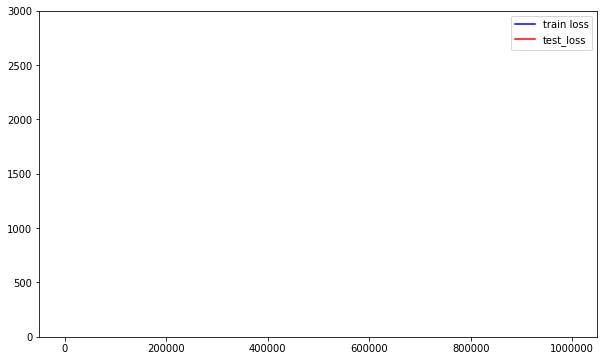

In [108]:
plt.figure(1, figsize=(10,  6))
plt.plot(train_loss_list, c='b', label='train loss')
plt.plot(test_loss_list, c='r', label='test_loss')
plt.legend(loc='best')
plt.ylim(0, 3000)
plt.show()

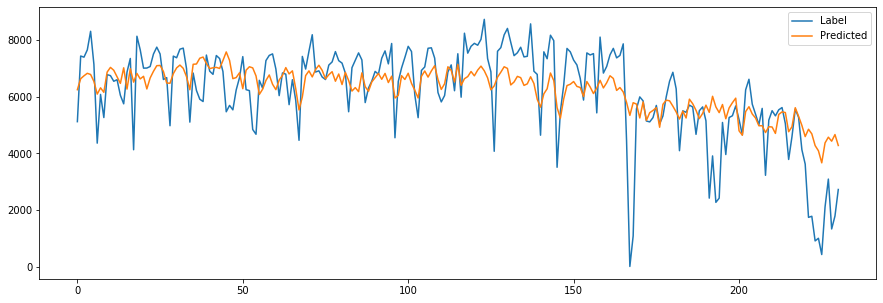

In [109]:
y_pred = model(X_test)
y_pred = y_pred.detach().numpy()
 
plt.figure(figsize=(15,5))
plt.plot(np.array(y_test))
plt.plot(y_pred)
plt.legend(["Label", "Predicted"])